In [1]:
### IMPORT STATEMENTS ###

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import string
from models import *
from configs import cfg
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [2]:
### HELPER FUNCTIONS ###

# returns a pandas dataframe of the given file
# fname: string; path to the file
# num_rows: int; number of rows to read (for partial datasets)
# return: pandas Dataframe
def load_data(fname, num_rows = None):
    return pd.read_csv(fname, nrows = num_rows)


# creates a one-hot encoding matrix for the given data
# data: 1d numpy array; list of items/features to encode
# dictionary: dict; mapping from the item to its index
# return: 2d numpy array
def encode_one_hot(data, dictionary):
    # creates the 2d array of zeros
    one_hot_encoding = np.zeros((data.shape[0], len(dictionary)))
    
    # gathers the respective indices of each item
    data_indices = [dictionary[item] for item in data]

    # encodes the 1 for all the items
    one_hot_encoding[range(data.shape[0]), data_indices] = 1
    
    return one_hot_encoding


# converts a one-hot encoding of the reviews into strings
# data: 3d torch list; list of one-hot encoding
# dictionary: dict; mapping from the index to the character
# return: review strings (1d list)
def decode_one_hot_reviews(data):
    extended_char = cfg['valid_char'] + 'SEP'
    decoded = [''.join([extended_char[torch.argmax(c)] for c in review]) for review in data]
    #decoded = [''.join([cfg['valid_char'][torch.argmax(c)] 
                #if torch.argmax(c) < cfg['valid_char_len'] 
                #else '' for c in review]) for review in data]
    
    return decoded


# cleans and processes (feature encoding) the training data
# orig_data: pandas Dataframe; raw data that is outputted from load_data
# returns: features (2d numpy array; one-hot), labels (1d numpy array of strings), beer dictionary (dict)
def process_train_data(orig_data):
    print ("Processing training data")
    print ("Original data shape: " + str(orig_data.shape))
    
    # takes the relevant columns
    data = orig_data[['beer/style', 'review/overall', 'review/text']].copy()
    
    # --- DATA CLEANING ---
    
    # drops the rows with missing data
    data.replace('', np.nan, inplace = True)
    data.dropna(inplace = True)
    data.reset_index(drop = True, inplace = True)

    # sets all characters to lower case
    data['beer/style'] = data['beer/style'].str.lower()
    data['review/text'] = data['review/text'].str.lower()

    # converts all whitespace (space, tabs, newlines, etc.) into spaces
    whitespace_regex = '[' + string.whitespace + ']'
    data['review/text'] = data['review/text'].str.replace(whitespace_regex, ' ', regex = True)

    # removes all invalid characters
    invalid_char_regex = '[^' + cfg['valid_char'] + ']'
    data['review/text'] = data['review/text'].str.replace(invalid_char_regex, '', regex = True)
    
    print ("Data shape after cleaning: " + str(data.shape))
    
    # --- DATA PROCESSING ---
    
    # creates a list of beer and a dictionary to map a beer style to an index
    beer_list = data['beer/style'].unique()
    beer_to_index = dict(zip(beer_list, range(beer_list.shape[0])))
    print ("Number of unique beers: " + str(beer_list.shape[0]))

    # creates the input features
    beer_encoding = encode_one_hot(data['beer/style'].values, beer_to_index)
    score_encoding = data['review/overall'].values
    score_encoding = score_encoding.reshape(score_encoding.shape[0], 1)
    input_features = np.hstack((beer_encoding, score_encoding))
    print ("Input feature matrix shape: " + str(input_features.shape))
    
    # creates the labels
    labels = data['review/text'].values
    print ("Labels matrix shape: " + str(labels.shape))
    
    return input_features, labels, beer_to_index


# updates the configurations based on the results of the processed dataset
def update_configurations(feature_length):
    # sets the models' input dimensions to the size of features (beer style + score) + character encoding
    cfg['input_dim'] = feature_length + cfg['output_dim']

    
# splits the dataset + labels into a training and validation set
# features: numpy array
# labels: numpy array
# percent_training: float; percentage (from 0.0 to 1.0) of data to be used for training
# returns: training features, training labels, validation features, validation labels (all numpy arrays)
def train_valid_split(features, labels, percent_training):
    # gets the index of where to split
    training_last_index = int(percent_training * features.shape[0])

    x_train = features[:training_last_index]
    y_train = labels[:training_last_index]

    x_valid = features[training_last_index:]
    y_valid = labels[training_last_index:]
    
    print ("Training set size: " + str(x_train.shape[0]))
    print ("Validation set size: " + str(x_valid.shape[0]))
    
    return x_train, y_train, x_valid, y_valid
    

# cleans and processes (feature encoding) the testing data
# orig_data: pandas Dataframe; raw data that is outputted from load_data
# dictionary: dict; mapping from the beer style to its index (output of process_train_data)
# returns: features (2d numpy array; one-hot)
def process_test_data(orig_data, dictionary):  
    print ("Processing the testing data")
    print ("Original data shape: " + str(orig_data.shape))
    
    # takes the relevant columns
    data = orig_data[['beer/style', 'review/overall']].copy()
    
    # --- DATA CLEANING ---
    
    # sets all characters to lower case
    data['beer/style'] = data['beer/style'].str.lower()
    
    # --- DATA PROCESSING ---
    
    # creates the input features
    beer_encoding = encode_one_hot(data['beer/style'].values, dictionary)
    score_encoding = data['review/overall'].values
    score_encoding = score_encoding.reshape(score_encoding.shape[0], 1)
    input_features = np.hstack((beer_encoding, score_encoding))
    print ("Input feature matrix shape: " + str(input_features.shape))
        
    return input_features


# pads the reviews so that all reviews in the set have an equal size
# and adds the <SOS> and <EOS> tags to the beginning and end of the reviews
# orig_data: 2d list of ints; list of reviews with the characters converted to their respective indices
# outputs: 2d numpy array of ints; padded reviews with the characters as indices
def pad_data(orig_data):
    # defines the character indices for the <SOS>, <EOS>, and <PAD> tags
    sos_tag_index = cfg['valid_char_len']
    eos_tag_index = sos_tag_index + 1
    pad_tag_index = eos_tag_index + 1
    
    # finds the longest review length
    review_lengths = [len(review) for review in orig_data]
    longest_review_length = np.max(review_lengths)
    
    # pads the reviews and adds the <SOS> and <EOS> tags
    padded_reviews = []
    for review in orig_data:
        pad_length = longest_review_length - len(review)
        padded_review = [sos_tag_index] + review + [eos_tag_index] + [pad_tag_index] * pad_length
        padded_reviews.append(padded_review)
        
    return np.array(padded_reviews)


def train(model, model_name, criterion, optimizer, computing_device, x_train, y_train, x_valid, y_valid, cfg):
    train_loss = []
    valid_loss = []
    valid_bleu = []

    start_time = time.time()
    
    softmax = nn.LogSoftmax(dim = 1)
    bleu_smoothing = SmoothingFunction()
    
    early_stop_count = 0
    min_loss = 100

    for epoch in range(1, cfg['epochs'] + 1):

        print ('----- Epoch #' + str(epoch) + ' -----')

        start_index = 0
        end_index = cfg['batch_size']

        losses = []

        print ('----- Training -----')
        while start_index < len(x_train):
            # takes the minibatch subset
            batch_x = x_train[start_index:end_index]
            batch_y = y_train[start_index:end_index]

            # converts the reviews char -> index
            indexed_reviews = [[char_to_index[c] for c in review] for review in batch_y]

            # pads the reviews
            padded_reviews = pad_data(indexed_reviews)

            # converts the review to a one-hot encoding
            # and concatenates this to the input features
            one_hot_length = cfg['output_dim']
            final_batch_x = []
            for features, reviews in zip(batch_x, padded_reviews):
                for char_index in reviews[:-1]:
                    one_hot_encoding = np.zeros(one_hot_length)
                    one_hot_encoding[char_index] = 1
                    final_features = np.hstack((features, one_hot_encoding))
                    final_batch_x.append(final_features)

            # converts the final array into a numpy array
            final_batch_x = np.array(final_batch_x)

            # resizes the flattened array into batch_size x sequence_length x feature_length
            final_batch_x.resize(padded_reviews.shape[0], padded_reviews.shape[1] - 1, final_batch_x.shape[1])

            # converts final input array to tensor
            final_batch_x = torch.from_numpy(final_batch_x).float().to(computing_device)

            # zeros the gradients
            optimizer.zero_grad()

            # passes the final input array to the model's forward pass
            outputs, _ = model(final_batch_x)
            soft_outputs = softmax(outputs)

            # prints the actual reviews vs the predicted reviews
            actual_reviews = batch_y
            predicted_reviews = decode_one_hot_reviews(soft_outputs)
            
            for i in range(1):
                print ("Actual Review: " + actual_reviews[i])
                print ("Predicted Review: " + predicted_reviews[i])
            
            # reshapes the outputs to N x feature_length (for the loss function)
            outputs = outputs.contiguous().view(-1, outputs.shape[2])

            # creates the targets and reshapes it to a single dimension
            targets = torch.from_numpy(padded_reviews[:, 1:]).long().to(computing_device)
            targets = targets.contiguous().view(-1)

            # passes the outputs and targets to the loss function and backpropagates
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            print("E" + str(epoch) + "T Batch start index: " + str(start_index) + " | Loss: " + str(loss.item()))
            print("Time elapsed: " + str(time.time() - start_time))

            start_index = end_index
            end_index += cfg['batch_size']
            
            # stops training when the remaining data count is less than a minibatch
            if end_index > len(x_train):
                break


        train_loss.append(np.mean(losses))
        torch.save(model, model_name + "_e" + str(epoch) + ".pt")
        print()

        print ('----- Validating -----')
        start_index = 0
        end_index = cfg['batch_size']

        losses = []
        bleus = []

        with torch.no_grad():

            while start_index < len(x_valid):
                # takes the minibatch subset
                batch_x = x_valid[start_index:end_index]
                batch_y = y_valid[start_index:end_index]

                # converts the reviews char -> index
                indexed_reviews = [[char_to_index[c] for c in review] for review in batch_y]

                # pads the reviews
                padded_reviews = pad_data(indexed_reviews)

                # converts the review to a one-hot encoding
                # and concatenates this to the input features
                one_hot_length = cfg['output_dim']
                final_batch_x = []
                for features, reviews in zip(batch_x, padded_reviews):
                    for char_index in reviews[:-1]:
                        one_hot_encoding = np.zeros(one_hot_length)
                        one_hot_encoding[char_index] = 1
                        final_features = np.hstack((features, one_hot_encoding))
                        final_batch_x.append(final_features)

                # converts the final array into a numpy array
                final_batch_x = np.array(final_batch_x)

                # resizes the flattened array into batch_size x sequence_length x feature_length
                final_batch_x.resize(padded_reviews.shape[0], padded_reviews.shape[1] - 1, final_batch_x.shape[1])

                # converts final input array to tensors
                final_batch_x = torch.from_numpy(final_batch_x).float().to(computing_device)

                # passes the final input array to the model's forward pass
                outputs, _ = model(final_batch_x)
                soft_outputs = softmax(outputs)
                
                # prints the actual reviews vs the predicted reviews
                actual_reviews = batch_y
                predicted_reviews = decode_one_hot_reviews(soft_outputs)
                
                for a, p in zip(actual_reviews, predicted_reviews):
                    bleus.append(sentence_bleu(a.split(), p.split(), weights = [1.0], smoothing_function = bleu_smoothing.method1))
                    
                for i in range(1):
                    print ("Actual Review: " + actual_reviews[i])
                    print ("Predicted Review: " + predicted_reviews[i])


                # resizes the outputs to N x feature_length (for the loss function)
                outputs = outputs.contiguous().view(-1, outputs.shape[2])

                # creates the targets and reshapes it to a single dimension
                targets = torch.from_numpy(padded_reviews[:, 1:]).long().to(computing_device)
                targets = targets.contiguous().view(-1)

                # passes the outputs and targets to the loss function
                loss = criterion(outputs, targets)

                losses.append(loss.item())

                print("E" + str(epoch) + "V Batch start index: " + str(start_index))
                print("Loss: " + str(loss.item()) + " | BLEU score: " + str(np.mean(bleus)))
                print("Time elapsed: " + str(time.time() - start_time))

                start_index = end_index
                end_index += cfg['batch_size']
                
                # 
                if end_index > len(x_valid):
                    break


        average_loss = np.mean(losses)
        valid_loss.append(average_loss)
        valid_bleu.append(np.mean(bleus))
        
        print()

        # checks for early stopping when the validation loss is higher for x consecutive epochs
        if average_loss >= min_loss:
            early_stop_count += 1

            if early_stop_count >= cfg['early_stop']:
                break

        else:
            early_stop_count = 0
            min_loss = average_loss
            
    return train_loss, valid_loss, valid_bleu
    
    
def process_results(model_name, train_loss, valid_loss, valid_bleu):
    # summarizes the results
    print (model_name + " Results:")
    print ("Training Loss: " + str(train_loss))
    print ("Validation Loss: " + str(valid_loss))
    print ("Validation Bleu Score: " + str(valid_bleu))

    # graphs the loss curves
    plt.clf()
    plt.plot(range(len(train_loss)), train_loss, 'b--', label = 'Training Loss')
    plt.plot(range(len(valid_loss)), valid_loss, 'r--', label = 'Validation Loss')

    plt.grid(True)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(model_name + " Loss Curve")
    plt.legend(loc="upper right")

    plt.savefig(model_name + " Loss.png")
    
    
    # graphs the bleu score curve
    plt.clf()
    plt.plot(range(len(valid_bleu)), valid_bleu, 'r--', label = 'Validation Bleu Score')
    
    plt.grid(True)
    plt.xlabel("Epoch")
    plt.ylabel("Bleu Score")
    plt.title(model_name + " Bleu Score Curve")
    plt.legend(loc="lower right")

    plt.savefig(model_name + " Bleu Score.png")
    
    
def sample(outputs, temperature):
    #logged = np.log(outputs) / temperature
    #exped = np.exp(logged)
    #sigmoided = exped / np.sum(exped)
    distribution = outputs.div(temperature).exp()
    print ('distribution')
    print (distribution)
    return torch.multinomial(distribution, 1)[0]
    
    
    #return np.random.multinomial(1, sigmoided)
    
def generate(model, x_test, cfg):
    # TODO: Given n rows in test data, generate a list of n strings, where each string is the review
    # corresponding to each input row in test data.
    
    predicted_reviews = []
    extended_char = cfg['valid_char'] + 'SEP'
    
    start_index = 0
    end_index = cfg['batch_size']
    
    start_time = time.time()
    softmax = nn.Softmax(dim = 2)

    print ('----- Testing -----')
    with torch.no_grad():
        while start_index < len(x_test):
            # takes the minibatch subset
            batch_x = x_test[start_index:end_index]

            # sets the outputs as the <SOS> tag for each review
            outputs = np.zeros((cfg['batch_size'], cfg['output_dim']))
            outputs[:, cfg['valid_char_len']] = 1

            # initializes the states
            ht = None
            ct = None

            # initializes the predicted sentences
            sentences = [[] for _ in range(cfg['batch_size'])]

            # samples the next character until all are either <EOS> or <PAD> (all 1s are in the last 2 columns)
            while np.sum(outputs[:, -2:]) < cfg['batch_size'] and len(sentences[0]) < cfg['max_len']:
                # concatenates the outputs (previous characters) to the metadata to get the inputs
                final_batch_x = np.hstack((batch_x, outputs))

                # resizes the array into batch_size x sequence_length (1) x feature_length
                final_batch_x.resize(final_batch_x.shape[0], 1, final_batch_x.shape[1])

                # converts final input array to tensor
                final_batch_x = torch.from_numpy(final_batch_x).float().to(computing_device)

                # passes the final input array to the model's forward pass
                if isinstance(model, bLSTM):
                    outputs, (ht, ct) = model(final_batch_x, ht, ct)

                else:
                    outputs, ht = model(final_batch_x, ht)
                    

                #outputs = np.array([sample(c[0], cfg['gen_temp']) for c in outputs])
                #outputs = outputs.numpy()
                #outputs = outputs.reshape(outputs.shape[0], outputs.shape[2])
                #outputs = outputs / cfg['gen_temp']
                #outputs = np.exp(outputs)
                #outputs = outputs / np.sum(outputs, axis = 1)[:, None]
                
                outputs = outputs.div(cfg['gen_temp'])
                
                outputs = softmax(outputs)
                
                outputs = outputs.contiguous().view(outputs.shape[0], outputs.shape[2])
                
                outputs = torch.multinomial(outputs, 1)
                outputs = outputs.numpy()
                sentences = np.hstack((sentences, outputs))
                
                
                indexes = outputs.reshape(cfg['batch_size'])
                outputs = np.zeros((cfg['batch_size'], cfg['output_dim']))
                outputs[range(cfg['batch_size']), indexes] = 1


            decoded = [''.join([extended_char[int(c)] for c in review]) for review in sentences]
            predicted_reviews.append(decoded)
            '''
            for s in sentences:
                decoded = ''
                for c in s:
                    print(type(c))
                    decoded = decoded + extended_char[c]

                predicted_reviews.append(decoded)
            '''

            #print ("Predicted Review: " + predicted_reviews[start_index])
            print ("Predicted Review: " + decoded[0])

            print("Batch start index: " + str(start_index))
            print("Time elapsed: " + str(time.time() - start_time))

            start_index = end_index
            end_index += cfg['batch_size']

            if start_index == len(x_test):
                break

            # case when the remaining data count is less than a minibatch
            if end_index > len(x_test):
                # adjusts the start and end indices to make the last subset the size of a minibatch
                end_index = len(x_test)
                start_index = end_index - cfg['batch_size']

                # removes the last few predictions to avoid duplicates
                predicted_reviews = predicted_reviews[:start_index]

    print()
    return predicted_reviews
    
    
def save_to_file(outputs, fname):
    # TODO: Given the list of generated review outputs and output file name, save all these reviews to
    # the file in .txt format.
    raise NotImplementedError


In [3]:
### MAIN FUNCTION ###

train_data_fname = "Beeradvocate_Train.csv"
test_data_fname = "Beeradvocate_Test.csv"
out_fname = "Output_Reviews.txt"

# loads the data
train_data = load_data(train_data_fname, cfg['num_data'])
#test_data = load_data(test_data_fname, 50)

# processes the data to get the train, valid, and test sets
train_data, train_labels, beer_to_index = process_train_data(train_data)
x_train, y_train, x_valid, y_valid = train_valid_split(train_data, train_labels, cfg['train_percentage'])
#x_test = process_test_data(test_data, beer_to_index)

# updates the configurations based on the processed data
update_configurations(x_train.shape[1])

# creates the dictionaries to map a character to its index in a one-hot encoding
char_to_index = dict(zip(list(cfg['valid_char']), range(cfg['valid_char_len'])))

# gets the computing device (either cuda or cpu)
if torch.cuda.is_available():
    computing_device = torch.device("cuda")
    cfg['cuda'] = True
    
else:
    computing_device = torch.device("cpu")
    cfg['cuda'] = False

Processing training data
Original data shape: (5000, 14)
Data shape after cleaning: (4999, 3)
Number of unique beers: 78
Input feature matrix shape: (4999, 79)
Labels matrix shape: (4999,)
Training set size: 3999
Validation set size: 1000


In [4]:
# defines the hyperparameters
model_number = '2'

#cfg['num_data'] = 20000
#cfg['batch_size'] = 16

cfg['hidden_dim'] = 16
cfg['layers'] = 2
cfg['learning_rate'] = 0.01

In [ ]:
# trains the LSTM model
model = bLSTM(cfg).to(computing_device)
optimizer = optim.Adam(model.parameters(), cfg['learning_rate'])
criterion = nn.CrossEntropyLoss()

train_loss, valid_loss, valid_bleu = train(model, "LSTM" + model_number, criterion, optimizer, computing_device, 
                                           x_train, y_train, x_valid, y_valid, cfg)

process_results("LSTM Model " + model_number, train_loss, valid_loss, valid_bleu)

predicted_reviews = generate(model, x_train, cfg)
#print (predicted_reviews)

----- Epoch #1 -----
----- Training -----
Actual Review: a lot of foam. but a lot. in the smell some banana, and then lactic and tart. not a good start. quite dark orange in color, with a lively carbonation (now visible, under the foam). again tending to lactic sourness. same for the taste. with some yeast and banana.
Predicted Review: PPPwwwwwwww3wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwPwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww334kkkkkkzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz

Actual Review: i bought a six-pack of caldera pale ale at a grocery store. poured in to a pint glass.  pours a rich gold color and is ever so slightly hazy. creamy white head caps the beer and is quite resilient. the head dissipates in ridges and valleys, finally getting down to small islands of foam on the surface of the brew..  smell is fairly faint. some hoppy fruity esters perhaps, but generally unremarkable.  taste is a bitter flavor, like sour citrus. a little malt flavor sneaks in too. strong flavors for a pale, almost approaching what one would expect from an ipa.  mouthfeel is light, crisp and clean, but dry. not watery, but light on the tongue.   a drinkable pale ale, but i think the sour citrus flavor is a bit over done for the style. i'd have this again though. the packaging (cans) are great for camping, tailgates and the like, but it's a bit overpriced in my area at $8 a sixer.
Predicted Review: ---rrrrrdddrwdddddwww3iswwdrdddwwwddwdrdwddwwwwrEwwvqwwwddddd2dbblwwdddddddrwd

E1T Batch start index: 192 | Loss: 2.7144935131073
Time elapsed: 161.23203444480896
Actual Review: a- black with thin tan head. good lace  s- sweet, slight hint of estersfruit, roasted malt...typical porter nose  t- similar to nose. initial slight esteryfruitiness transitions smoothly to roasty-sweet, coffeechocolate finish. one of the best balances of hops-malt i've had in a porter.  m- full bodied, silky and slightly creamy. perfect for the style.  d- very sessionable....very close to perfect for the style
Predicted Review: --------222jjjjjjjjhjjjhhjjjjhhhoshh*jdhhhhhhhjdjjhhhjjjjhhhhjhhhhhhhjjhhjhhjjhhh*hhjhhhj*jhhhh*jjjdjhhjjjjjhhhhjhhhhhhhjjh**hhhhhhhdhhhhhhhj*hhhhhhhhjhjjjdhhhhjjhjhhhhjjjhhjjjhhhhh*cchhchhhhh**hhdhshddjjhjjssdddjdddhdjdhhhhhhhhhhhohhhhhhjhhjhjhhjh*hjdhhhhhhhjhss;*jhhhhjhhjhhhhhjhhhhhjjhhhhhhhhhhhhhhhjhhhhhhjdhjhhhhhhhhjhjhhjdddddhhjjhjjjhhhhhhhjhhhdhjjhhhhhhjjdhhjhhhjhda*jjooo*oodhhhhhdhhhhhjjhjjjhhhjhhhjhhhdhjdd;;;PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E1T Batch start index: 320 | Loss: 2.248098373413086
Time elapsed: 231.13474035263062
Actual Review: the can oozed with creamy foam before i poured it. needledd to say the head was soft and creamy. it sat atop the cloudy caramelorange body for a good amount of time before sinking. it left an excellent wall of lace, topping it all off.  the nose had a good complex hop aroma, just a tad short on intensity. hints of pineapple, fresh tomato vines, fresh grass, and a dash of astringency and metallic twang make up the one-sided hop aroma.  the flavor is excellent. it takes what the nose started and cranks it up a notch. passion fruit sweetness meets a bold herbal grassy profile, and the two work together great. malt knows its roll.... the shy pale toasty backbone. the finish is bone dry with grassy bitterness.   this one is pretty dry right from the get-go. the carbonation is perfect and keeps it feeling on the light and crisp side. my mouth needs the constant reinforcement of another drink.

E1T Batch start index: 448 | Loss: 2.0544073581695557
Time elapsed: 300.39736890792847
Actual Review: pour was a deep copper with a slight hazy ruby tint. fluffy cloud like head with decent retention and lacing  huge malts with a slight citrus and floral hop scent. mainly orange and pineapple.  bitter up front, a strong pine bitterness with bits of earthy and citrus bitterness. a bit of white grapefruit, orange, and sweet biscuit malts.   very full bodied with proper carbonation. the perfect bite to accompany the flavors.  not bad, has a lot of deep bitterness and is a solid ipa. i would prefer some floral flavors but that is just me. the price here would have me thinking twice about getting more but i would have no issues drinking this again.
Predicted Review: ----------???$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$zzzzzzzz$$zzzzzzzzzzzzzzz44z444z44'4444k''''55q5555555555'5555555555555555555555555555555555555555555555555555555555555

E1T Batch start index: 576 | Loss: 1.8444061279296875
Time elapsed: 393.7876522541046
Actual Review: served cool from a 12 oz can into a boston lager glass.  pours crystal clear with a fluffy off-white head that leads loads of lacing on the glass. nice orange light-amber color bordering on light coppery tone.  aroma is just loaded with citrusy, tangerine hops. not much subtlety there.  flavor is a lot more complex. there's tangerine, pine, and floral hops. a touch of caramel and a touch of maltiness, and even a touch of grassiness. nicely balanced (for what it is) but practically speaking, still hop-heavy.  mouthfeel is suitably bitter, but not near the max of the style, and has a nice dry finish--refreshing compared to many heavy, sugary ipas in its class.   drinkability is good, but the bitter front and dry finish might actually go better with a bit less flavor and aroma. this is a nice complement to their pale ale, one of my favorite beers, and i think i like this one's hop bill eve

E1T Batch start index: 704 | Loss: 2.0985939502716064
Time elapsed: 456.90124011039734
Actual Review: taste- caramel, grains, nutty maltiness, resiny hoppiness, black pepper  color- orange amber  clarity- clear  smell- malt, caramel, perfumy hops, sour notes  body- medium weight on the palate, hoppy bite at the front of the mouth, soft feel  appearance- thin, slightly off-white head with very little carbonation and lace retention  overall impression- average beer, website says it is a larger version of their ipa, slightly above average  notes and comments- website says 100 ibus...to me, the beer didn't show it  beer spy- ashland or, june 2011, 22oz  glassware: pint
Predicted Review: 2!-:::--------??????????????????????????????????????????????$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

E1T Batch start index: 832 | Loss: 1.5082266330718994
Time elapsed: 525.1393427848816
Actual Review: a - a fingers and a half worth of rich creamy light tan head... average retention ultimate fades leaving a thick frothy lacing... the lacing clings to the sides of the glass on the way down... a medium amber bronze color with some orange highlights... mildly hazy... extremely tiny moderate paced carbonation...   s - very sweet malty aroma... loads of caramel... toffee... slightly nutty... biscuit... quite pleasant... deep done, there are also some very minor hoppy notes...   t - the strong malt base alluded to by the nose shines through... caramel... biscuit... the hop presence come through stronger on the palette, but is still is quite mellow...   m - a tad on the thin side of medium bodied... slight carbonation on the tongue... silky smooth... refreshing... a slight hop puckering at finish...   d - extremely easy drinking... quite enjoyable and quite sessionable... another impressive 

E1T Batch start index: 960 | Loss: 2.036406993865967
Time elapsed: 576.2614943981171
Actual Review: i was excited about this beer when it came out! the bottle looked neat and the commercial made it seem tasteful! this was not the case.   mgd 64 tastes way better than amstel light.  what did they do w the taste! seriously this is most tasteless light beer my palet has brought down!  color looks nice though! lol! aroma is shit everything about this sucks!  next time you buy a six pack of this remember that there is 6 pack of o'douls light for way cheaper!
Predicted Review: *4::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::?????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????$????$$?$$$?$$$$$?$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$7$7$$$$$$$$$$$$77$$$$$$$$$$$$777$7$$$$$7$7777777wwwwwwwwwwwwwwwwwwwwwwww

E1T Batch start index: 1120 | Loss: 1.488981008529663
Time elapsed: 643.6703004837036
Actual Review: if you want a good diet beer, this is the one for you. it's very not bad in the flavor department, and it's healthier than a can of dr pepper. seriously, it has 0 fat, and only around 85 calories. it is good especially in the summer at bbq's and other functions. great at tailgate parties and other sporting events. solid flavor will keep you a regular customer.
Predicted Review: 4:::::::::::::::::::::::::::::::???????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????$?$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$77$77$77EEEE-EEE--EEEEEEEE9EEEEEE99E9E;;;;;;;;;;;;;;;;,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,aaaaaaaaaattttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E1T Batch start index: 1280 | Loss: 2.1367125511169434
Time elapsed: 714.489739894867
Actual Review: another weak pea colored brew with a white head of small to large bubbles that leaves very little lacing. it has a low quality aroma that reminds me of getting sick to my stomach. oh not another one of these brews! it has a very small hoppy flavor smooth and with no fore or after bite. its low alcohol content is also not a plus for me. can i have a stout please! gf rating said it smells like cheap beer, looks like cheap beer, so it must be cheap beer! lol.
Predicted Review: 4::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::???????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????$$$$$$$$$$$$7777$77777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777qqqvqqvvvqqqqkkkk

E1T Batch start index: 1440 | Loss: 1.3823055028915405
Time elapsed: 786.8976998329163
Actual Review: i must be masochistic, coz i can't for the life of me explain why i sometimes still drink this.  weak, watery, unimpressing smell and taste, there's the expected hops and some malt, but ye gods, why on earth is this beer so omnipresent and popular (pun intended)?  every once in a while, on a warm terrace in greece, i let my guard down and order me one of these, immediately regretting it on the first sip. tohether with heineken, bud and the likes, i tend to give this the label industrial waste.  stay clear of it, there's hundreds of beers more worthy of the name out there.
Predicted Review: 4::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::?????????????????????????????????????????$$$$$$$$$$77777777777

E1T Batch start index: 1600 | Loss: 1.9109797477722168
Time elapsed: 831.8124706745148
Actual Review: review from my titanic backlog. drank in july 2010, on the way from chicago to tampa. this stuff was so good, i think about it to this day.  a - it pours a very reddish mahogany hue, somewhat hazy, and is capped with a perfect inch of off-white head. i have never seen a cask beer look as good (or taste as good) as it does at the broad ripple. these guys are converting me to a 'real ale' fan.  s - the brew is more golden in aroma than its hue would suggest. i was expecting peat and toffee but instead found delicious golden raisin and richer nutty cocoa flavors, and not so much roastiness. the hop is very mild and adds perhaps a smoothing tea-like mellowness.  t - this beer has officially won me over in terms of appreciation of cask ale. it has an unbelievable depth of flavor. i get tremendously delectable golden-fruity malt, notes of cocoa, hazelnut, herbal-tea-like hop and a caramel ri

E1T Batch start index: 1728 | Loss: 1.3904871940612793
Time elapsed: 930.9463353157043
Actual Review: draft at the brewpub.  poured a clear orange color with an average frothy white head that mostly lasted with excellent lacing. moderate pumpkin pie aroma. medium body. medium pumpkin bittersweet flavor with a medium bittersweet finish of moderate duration.  i would not recommend this to a friend.
Predicted Review: ?:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::?????????????????????????????$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$4444444444444444444444444444444444444xxxxxxxyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyywwwwwwwwwwwwwwwwwwwwwwwwwwwwffffffffffffffffffffffffffffmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm

E1T Batch start index: 1888 | Loss: 1.5611027479171753
Time elapsed: 1003.8318095207214
Actual Review: this was probably the best of the four beers available at the moon river outpost in cartersville. it leans more toward hop bitterness than hop flavor than i prefer in an ipa, but it was still a tasty beer. there was a good bit of a fruitines something like dried apricots, grassy hops and a touch of sweet malt. the flavor had grapefruit-rind bitterness backed up by a pleasant fruitiness and a touch of malt. pretty tasty.
Predicted Review: :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::??????????????????????????????????????????777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777ppppppppppppppppppppppaaaaaaaaaaaaaa

E1T Batch start index: 2016 | Loss: 1.3580189943313599
Time elapsed: 1085.055786371231
Actual Review: light cloudiness to the lighter amber color. not much head but there is plenty of spotty lace.  raw and grainy with a molicum floral hop nose. slightly sour.  drawn off by a pull tap, served warm. sour grain on the initial taste but with far more hop bitterness than the smell would indicate. good body, high carbonation for a pulled beer.
Predicted Review: :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::?????????????????????????????????????????????????????????7777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777EEEEEEElloooooooooooooooooooooooooo

E1T Batch start index: 2144 | Loss: 1.2909997701644897
Time elapsed: 1155.3497915267944
Actual Review: pours a hazy, ambercopper color. 23 inch head of an off-white color. good retention and good lacing. smells of strong hops, alcohol, dark citrus, and sweet malt. fits the style of an american pale ale. mouth feel is smooth and sharp with an average carbonation level. tastes of floral hops, sweet malt, and slight grain. overall, a good body and drinkability.
Predicted Review: :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::?????????????????????????????????????????????zzzzzzz7777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

E1T Batch start index: 2272 | Loss: 2.02439284324646
Time elapsed: 1231.4414489269257
Actual Review: a golden look, bordering on copper, and a sticky white head on top.  typical fest-aroma, defined mostly by some spicy hops and a juicy, caramelesque, somewhat dryish malt-profile. there is a slight boozy quality too, which works well together with the dusty note next to it. the scent of apples freshens it all up.  when tasted, this is moderately sweet upfront with the hops in the background, followed by a bitter moment and a rather grainy malty finish. the aftertaste finds a nice balance between fruitiness and hoppy nuances.  moutfeel is easy-going, smooth and supported by quite a firm body.  this is a very good lager, which tasted best at fridge temperature.
Predicted Review: :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

E1T Batch start index: 2400 | Loss: 1.6431193351745605
Time elapsed: 1299.3729708194733
Actual Review: 330ml bottle thanks to chrisslowbeer.  ruby brown, slightly murky, half a finger just off-white head. leaves a very lasting ring and a slow bead.   upfront sauvin presence, backed up by grapes, sour cherries, raisins, and a touch of candy floss and toffee. truckloads of pungent biscuity malt character. quite a pronounced interplay between hops and malt.   sauvin hops prominent again, but quickly overcome by a biting earthy bitterness. caramel and light toffee malt background doesn't quite keep it in check. some nice nutmeg and woody notes floating around.  pretty full, with moderate and lasting back palate bitterness, exemplified by a rather sizzly carbonation.   solid brew with plenty of intrigue that would show its wares much better if the domineering bitterness was reined in.
Predicted Review: :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

E1T Batch start index: 2528 | Loss: 1.6262414455413818
Time elapsed: 1354.8361146450043
Actual Review: wow, this was so much better in the can than on tap. was darker, brown edge to it at times. aroma was british, but strong, like stone 14th.  taste, great light feel to it relatively speaking big hop mouthfeels of hop varieties in combinations and amounts that i would venture to guess i have not had too many times. alcohol hit me afterwards, but was not noticeable at the time. wish i could get these cans where i am, cool name.
Predicted Review: ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::?????????????????????????????????????????zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz777777777777777777777777777777777777777777777

E1T Batch start index: 2688 | Loss: 1.6626569032669067
Time elapsed: 1429.4301726818085
Actual Review: unpasturized. delicate. wisely designed bottle to preserve freshness. something added to speed up aging, pushing radek's translation of the description. initial; great large had. easy drink. no spectacular appearance and light mouthfeel. pleasantly aggressive carbonation. yet the malts and hops and all work gracefully together in a complex drink that grows on you with each sip. thanks for bringing back georgina. she did it again, brought me a bottle back 14 months later. very good pilsner, noticed aggressive acarbonation and very good malting.lwoered the taste but this fresher bottle was much more creamier head.
Predicted Review: :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

E1T Batch start index: 2848 | Loss: 1.2608383893966675
Time elapsed: 1514.4053156375885
Actual Review: a nice surprice of a great beer.  pours out of the bottle with a nice caramel color with a great pinky of foamy off white head and very good lacing.   the smell is very nice in terms of hops, it has only what i can describe as a very 'raw' hop smell with lots of earthy grass and weed smells, bitter like raw hops right out of the bag you get from the homebrew store!   the taste is much more complex with the bright fruit and grapefruit hops up front with a toasty, honey bread malt undertone that is quite nice and very appropriate for the style. tropical fruits are the main hop character here and the beer ends with a great bitter lingering finish with a great thick body like its from a cask at a pub. some piney hop notes as well as a couple spicy notes, this would go great with spicy food as it's big enough to compete with the spice but also would compliment nicely.   overall a really ni

E1T Batch start index: 2944 | Loss: 1.254799485206604
Time elapsed: 1611.5130956172943
Actual Review: pours a lightly carbonated orange body with a small head on top of a citric aroma that is powerful of oranges and banana and has a good spicy twang in it. a smooth, creamy body that has an amazing citricesque taste of orange, banana, tropical fruit, along with spices and clove that are very evident. has some fluffy yeastwheat twang as well and finish sharp and crosp with a bit of hoppy bitterness. a very good hefe indeed.
Predicted Review: ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

E1T Batch start index: 3040 | Loss: 1.5637513399124146
Time elapsed: 1686.2024335861206
Actual Review: 22oz. bomber poured into a left hand snifter.  a: pours amazingly think in color. very, very dark orange. almost like and unfiltered wheat. thick one inch head with super lacing.  s: holy hops of hell man!! i smell hops with hops and then hops on top of the hops.   t: tastes of pure hops. i mean freakin hops man. just crazy hops. don't get much malt taste at all but the alcohol is fairly noticeable.  m: bitter and then some. slight bubbles and heavy.  d: as much as i like this beer it's really not very drinkable. the bitterness is a mouth shredder. good for one bomber in the evening but that's about all.  at 168 ibu's one of the most pungent, bitter dipa's i've had. shocked it was only 8.2 abv. would recommend any hop head try at least once!
Predicted Review: 4::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

E1T Batch start index: 3136 | Loss: 1.0799486637115479
Time elapsed: 1793.6059901714325
Actual Review: poured into my lovely sa beer glass...no best-by date listed on bottle. viscous copper pour, somewhat hazy, with 2 fingers of manilla frothy head. aroma of dank pink grapefruit. i got a bright semi-sweet first sip, then the onslaught of thick hop flavor hit hard. syrupy goodness of citrus and piney hop flavor. touch of sweet alcohol in the mouthfeel...finished somewhat dry. quite drinkable for such a high ibu, 8.2 dipa. well done.  09-05-09 bought recently at cbx. poured into a duvel glass this time. smells like stinky nuggets and piney grapefruit jam. taste is dense yet refreshing. so much flavor. glad i revisited this one. awesome
Predicted Review: 4:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

E1T Batch start index: 3232 | Loss: 1.1165255308151245
Time elapsed: 1898.5194687843323
Actual Review: poured into a imperial pint glass from a 22oz bomber with no dating on it. a smallthin beige head sits on top of a dark copper head. excellent lacing is left behind. the usual nw citrus hops in the nose. good malt backbone with hops hovering over it to the finish. a good dipa.
Predicted Review: ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::333333333((((((;;;;;;;;;;;;;;;;5555555555555555555555555555555555555555555SSSSSSSSSSSSSSSSSSSSSSSSSSSS,,,,,PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E1T Batch start index: 3328 | Loss: 1.171431303024292
Time elapsed: 1996.337462425232
Actual Review: poured into tulip glass.  appearance: a glowing golden brown bodied beer with a white head. little bit of lacing and head retention is decent considering the style.  smell: lots of things going on here. huge barrel notes of oak and vanilla. spicy notes that are coming from the belgian yeast. smells really malty. wow.  taste: fairly similiar to the nose. nice malty beer that has a huge caramel and toffee malt profile. the whiskey barrel adds strong oak and vanilla notes to the mix; which really compliments the malt forward profile. to add good measure... the belgian yeast adds a lively spice that keeps things interesting.   mouthfeel: this beer is full bodied and has low carbonation. smooth and delicious. this beer is 11 and the only way of knowing is looking at the label. no boozey burn and no harshness is encountered. its hard to believe that this beer has not been in a cellar for a fe

E1T Batch start index: 3424 | Loss: 1.3402024507522583
Time elapsed: 2083.3762414455414
Actual Review: dark gold colour with a creamy off-white head. nice head retention. great lacing.  crisp frezh piney hop aroma. nothing special but still good.  rounded and malty with a distinct hop edge. slightly fruity.  medium body with moderate carbonation. fine.  a decent apa with some nice hoppy notes. for me the malt is a touch too bready and sweet.  thanks to will (futura123) for an enjoyable beer.
Predicted Review: ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::44444444444444444444444444444444444444444444444444444444!!!!!555555555555555555SSSSSSSSSSSS

E1T Batch start index: 3520 | Loss: 1.345186471939087
Time elapsed: 2196.375957965851
Actual Review: served in a glass mug.  maybe someone can remix the classic who song, huh? nah, maybe not. anyway, this thing pours a straight obsidian topped by a finger of burnt sienna foam. the nose comprises burnt rubber, fusels, roasted malts, coffee, and chocolate-covered raisins. the taste holds a surprising amount of hops, with some heavy pine, flower, and greens piercing the dark backdrop, which itself is composed of pretzels, dark chocolate, and light roasted malts. honestly, the hoppiness really takes hold, and the stout-like qualities are overshadowed and buried. the body is a hefty medium, with a light moderate carbonation and a thick, chewy feel. overall, i did not care all that much for this one. the hoppiness took away from what could've been a great stout and kept me from really wanting to finish my portion of the bottle.
Predicted Review: 4::::::::::::::::::::::::::l:::::::::::::::l:l

E1T Batch start index: 3616 | Loss: 1.2359776496887207
Time elapsed: 2308.5558857917786
Actual Review: poured into a snifter. pours like motor oil, very thick. no light what so ever gets through. with a thin (14 inch) dark brown head that does not last. leaves just a wisp of bubbles behind.  aromas of dark chocolate, coffee, roasted malts.  first sip not as creamy as boris. dark chocolate flavors linger at the end, with roast malt and coffee bringing up the rear. unless my taste buds are burned out, i can't detect any hop flavor, if it is indeed dry hopped and first wort hopped. the roast and chocolate overpower everything else. not that that is a bad thing. very little hint of alcohol that is going to smack me later on.  mouthfeel is full and luscious. drying roast, but not astrigent.  overall drinkability is good. boris wowed me. this is good, but not wow good. maybe the extra roasted malt dampened the oatmeal. lacks the creamy goodness of boris. but, i bet this would be one killer d

E1T Batch start index: 3744 | Loss: 1.3941773176193237
Time elapsed: 2404.2307159900665
Actual Review: bomber split with the family during a cookout and poured into a cervoise. this brew appears a hazed color of lemonade but with a dark yellow to orange coloration. there is no head formation despite lots of fizz and rising bubbles of carbonation to the surface. a swirl does nothing for the appearance.  the smell of this brew is very fruity with hints of lemon zest and pulp. tons of fruity sweet indications fill the nose. there is a minor fruity malt or alcohol inclusion through the middle but the lemon remains dominating. as it warms, a light amount of sulfur is evident which mixes with a smell that gets somewhat more like grain but that is stretching it.  the taste of this brew is like lemony candy. it is very sweet with some zest, rinds and pulp addition but without the expected bitterness associated with that arrangement of ingredients. very candy-like across the board like lemon an

E1T Batch start index: 3840 | Loss: 0.9140869379043579
Time elapsed: 2470.7035212516785
Actual Review: a very serviceable, sturdy ipa. good golden-to-amber color with a decent, foamy head as i poured from a 22oz bottle. stronger on the hop aroma than the bitterness, though i can't peg the aroma hops used. it's got a decent malt character, which balances well with the strong hop flavor. it's got a little whiff of grapefruit. not, perhaps, the best ipa ever made, but not one i am in the least disappointed by.
Predicted Review: :aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa44444444444444444444444444444SSSSSSSSSSSSSSSSSSSSSSSSSSSSSS

E1V Batch start index: 0
Loss: 1.1525391340255737 | BLEU score: 0.0
Time elapsed: 2541.0421590805054
Actual Review: 22 ounce bottle into snifter. pours slightly hazy red color with a fairly dense 2 finger off white head with great retention that reduces to a thin lacing cap. some decent lacing on the glass. aromas of caramel, bourbon, dark fruits, cinnamon, and some honey. taste of oak, bourbon, caramel, roasted malt, and molasses. fairly dry finish, but there is some lingering flavors of bourbon, caramel, and dark fruit sweetness that lasts for a decent period after the finish. no real significant amount of bitterness was noted, but there was a small amount. medium carbonation and medium-full bodied. very smooth drinking with minimal alcohol noticed, only a small warming after the finish. overall quite a tasty scotch ale we have here. good stuff.
Predicted Review: 4aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

Actual Review: first, the notes on the label regarding this beer are clearly nabbed from the verse lyrics of black sabbath's lady evil (1980, 'heaven and hell'). if you know the song, check it out and tell me it's not true. great move!  if a pour can indicate mouthfeel, i'm just going to predict this is thin and maybe even watery. we'll see, but it poured out kind of limp and stringy like...and the thin head flattens to absolutely nothing quickly (no skim, no crown). at 8.4, i can't imagine this is dead or old, but it looks that way. color is nice though, a burnt autumn-leaf orange-rust, not unlike the guts of the pumpkin itself.  the nose is more like it, balanced between the spices (cinnamon, ginger, nutmeg, allspice, clover) and the flesh of the almighty hallowe'en squash. pretty straightforward pumpkin ale aroma, reminiscent of cottonwood's version; solid if unspectacular.  flavor lays out the spices and squash in equal measure, as in the nose. ginger spikes out a little from the r

Actual Review: my first foray into the world of hoppin frog was a bit disappointing. bought a 22 oz bomber along with a bunch of other fall beers and kept it aside to taste on its own. shared it with a buddy, poured into 8 oz tulip glasses. a beautiful burnt orange color and great smells of clove and nutmeg...but where's the carbonation? no head, no lacing. the taste is strongly clove with other spices and pumpkin in the background, but the sweetness lingers and becomes cloying with good carbonation to scrub the tongue. there's a good alcohol presence that made me check the bottle to see if it was barrel aged but again, the sweetness is overwhelming without carbonation. overall, interesting, but not one of my favorites this season. kind of made me want a whiskey...
Predicted Review: $aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

Actual Review: poured from a 22oz bottle into a pint glass. emerges clear and amber cinnamon colored with a light nutmeg colored head. foam is decent in size but lacks any real sustenance. a bit thin and cola-like.   aroma is beautifully festive. largely cinnamon with nutmeg, ginger, and allspice. i know some people dont like this type of beer, but if you dig the festive, spicy beers, this one is for you. the nose is a bit strong but i dont mind.   solid pumpkin pie spice type flavor as well. again, it is on the border of overdoing it but i dont think they did. this one certainly isnt subtle but it isnt too overpowering either. malty body with sweet cinnamon and nutmeg. a little thin and perhaps a bit overcarbonated, so this one was a letdown in the mouthfeel department.   i know this isnt everyones cup of tea, but it is a very spicy (festive spice, that is) beer that is balanced yet strongly flavored. spiced beers are hard to get right and this one is pretty close. i couldnt taste the

Actual Review: green cap  a - pours black, black, black into my pint glass with a little under one finger of tan head that dissipates quickly and leaves very little lace.  s - whiskey is the most present, but there are many layers here. sweet vanilla, chocolate, dark fruit in the way of raisin and figs, roasted malts, toasted oats, and a bit of booziness.  t - taste like the nose is whiskey up front, yet very sweet chocolate, vanilla and molasses tones. as it mellows on the palate a wash of many flavors come out, espresso, oatmeal, figs, raisins, roasted malts, kind of a dry bittersweet cocoa near the end, as well as the alcohol which is present, but in a good way in my opinion.  m - smooth, creamy and well rounded, not too much carbonation, great for the style.  d - this is for sure one of my new favorite imperial stouts and will be sure to seek it out in the future. highly recommended!
Predicted Review: 4:aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

Actual Review: poured from a bomber into a pint glass. enjoyed this one to celebrate my 24th birthday.  black pour. very small tan head retains well, and leaves some nice lacing.  aroma is of sweet whiskey, charred malts, and oatmeal. basically smells like a spiked black coffee.  great subtle whiskey flavor. barrel aging imparts a nice sweet, but not hot flavor. lots of great subtle flavors rather than bold, overpowering ones. that said, ba boris has a monstrous roasted malt character, giving it loads of dark chocolate and coffee flavors.  nice, thick, rich body. carbonation is appropriate. slight creaminess. ridiculously easy drinker for a 9 ba imperial stout. i set the glass down during the first contemplative sip, then immediately picked it back up for more. it was a challenge to let this one warm up. great stuff.
Predicted Review: 4:aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

Actual Review: buckeyeboy brought this to the pennsylvania vs. ohio beer tasting on saturday.. ohio won the tasting.. penn state lost the damn game... poured into a big wine goblet.  deeeep dark brown head.. good retention and significant lacing... swirling the beer coats the glass ... nearly stains the glass.  the aroma is very much complimented by the barrels.. vanilla goes great with chocolate and the lite coffee .. big and roasty of course with something that reminds me of cinnamon.  flavor is a restrained monster... deep dark chocolate is firmed up by some good malty sweetness.. the barrel and the bourbon really comes in mid-palate and lasts forever.. less coffee than the nose.. but some minor espresso is there for sure and helps with a bit of acidity.. as it warms, some dark cherry really comes out too... the body is near perfect.. the carbonation is lighter than expected but pushes a velvety mouthfeel.. this is a very nice stout.  thanks jeremy.... i knew you were bringing the r

Actual Review: notes from 110211  *bomber w a 10oz nonic   a: pours a shiny black licorice color with a sort of lighter crimson edge to it. almost no head but just a rim of turbinado sugar color foam on topmaybe half a finger at most with low retention and some dotted lace. just dark and oily looking.   s: smells a bit woody with an earth and spice mix going on. vanilla beans, caramelized malts, and a hint of chocolate. some alcohol aromas exude. really rather complex array of aromas here.   t: wow this is a big robust stout with lots going on. tastes of charred roasty grains, earthy, with a distinct whisky note. a touch harsh but the whisky barrel treatment is rather subtle and not completely overbearing here. dark chocolates. slightly sweeter with some hints of vanilla. hops start midway and spike the back of the palate bringing a sort of dark fruit component to the brew. a little bit of alcohol heat and a dry roast coffee aftertaste.  m: has a rather smooth mouthfeel overall. medium

Actual Review: sampled at the cleveland beer fest 51411. poured black with a tan colored head that has enough carbonation to leave a small ring that lasts. notes of, whiskey, and heavily roasted malt and burnt chocolate fill the nose. this is a full bodied stout with yeast flavors enhanced by malt, burnt chocolate, coffee and a lingering hint of hop on finish. a little hot on the alcohol. i would love to let a bottle sit for a year or so.
Predicted Review: :aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa4444444444444444444444555555555555SSSSSSSSSSSSSSSSSSSSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 oz bomber at 50 degrees into a stone irs tulip.  a: it pours pure opaque black with a two-finger dome of chocolate milk colored creaminess. it holds up very well and the lacing is exceptional.  s: milk chocolate, sweet dark fruits, some anise-licorice notes, and light to average roastiness.  t: strong milk chocolate, sweet figs and dates, moderate and semi-citrusy hoppiness, and anise and licorice late. there is a lack of roastiness in this that makes it refreshingly unique.  m: this is the most velvety-smooth imperial stout i've ever had. b.o.r.i.s. on nitro-tap might not be much smoother.  d: it goes down easily and i feel as if i could go for another.
Predicted Review: 4:aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

E2T Batch start index: 32 | Loss: 1.6076985597610474
Time elapsed: 2736.663551568985
Actual Review: i received this one in a bif recently and it was the first thing i grabbed out of the fridge when i got home on friday. served cold and poured into a pint glass, this one was consumed on 07312009.  appearance - one of the best pours from a pale ale you could possibly ask for. seriously. big head of white foam on top that barely falls back down to earth. wonderful clear amber color that really just looks the part perfectly. lots of carbonation creeping up the glass throughout and a really nice coating of spider like webbing.  smell - aroma is lighter then i would have thought. nice light grains, a touch of piney hops. as it warms a bit of citrus starts to come though, but again, lighter then i would have thought.  taste - crisp, clean, the first sip has a biting touch to it as the pine and citrus start to roll through. nice grains come in mid palate and then it rolls right back into a nic

E2T Batch start index: 128 | Loss: 1.138999342918396
Time elapsed: 2804.3757586479187
Actual Review: 12oz can. a) pours with a finger thick, white head that takes awhile to settle. slightly hazy body. active carbonation. gold in color. nice sticky lacing on the drink down. s) pink grapefruit. a hint of evergreen. t) the initial flavors are washed out by the fizz. once beyond that some dry nutty-ness liken to walnut. grapefruit rind. a mellow sweetness throughout but not the main stay. a nice hop bite in the finish, but seems a bit too much for a pale ale. m) quite fizzy. medium body. dry. d) a decent brew. i'd have another.
Predicted Review: $aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

E2T Batch start index: 256 | Loss: 1.477914571762085
Time elapsed: 2873.8455953598022
Actual Review: vintage 2010.  a: quarter finger light mocha fades to translucent of the same. beer is dark, dark brown. no lacing to speak of.  s: extra roasty. coffee, graham, cocoa, malt, licorice. i can say, however, the hops are still quite present. piney, resiny. malt dominant, but still hoppy.  t: roast, cocoa, coffee, lighter hops with earthy feel. good beer. not spending much time here, but this is really good.  m: thick and syrupy. like a good beer should be in this genre.   d: this is a really good beer. i hate to be a slave to price point, but at nearly $13 for a bomber, i want to be wowed. the beer is good, really really good. if under $9bomber, i would be all about this one.
Predicted Review: $aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

E2T Batch start index: 384 | Loss: 1.511658787727356
Time elapsed: 2936.3067767620087
Actual Review: a: poured from a can into the duvel tulip. dark orange, amber and nearing a light brown. reddish tones. head is fairly thin and fizzy.  s: smells fantastic. big piney hops along with a nice malt backbone. a bit of tart citrus and some grapefruit. some peaches and grapes.  t: good hop bitterness, sweet fruits from the nose turn into rather bitter fruits on the palate. grapefruit and some unripe orange. citrus rind and zest.   m: slick and a bit malty on the tongue. carbonation is just about right, doesn't bite back quite enough.  d: easily drinkable beer, love the hopmalt balance, especially for a west coast ipa. great beer that i continue to revisit.
Predicted Review: $aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

E2T Batch start index: 480 | Loss: 0.8904483914375305
Time elapsed: 3024.0847153663635
Actual Review: a: pours a hazy orangereddish with a soapy, foamy head. lots of bubbles of small carbonation.  s: pine, citrus, and grapefruit all the way, almost to the point of smelling like a fresca! (how's that for an obscure reference). the malt is also noticeable in the form of a little fruitness.  t: wow! the hops pack a whallop both in the nose and in the finish of the taste, but the sweet malt coats the tongue and the throat and balances out nicely. the aftertaste of so many hops does take down the mouthfeel a bit, but the taste is definitely...tasty!!!  m: the hops sting a bit, even in the mouthfeel, but the malt is moderately thick, which helps wash everything down. the only drawback i can see is that the hops stick around so much in the aftertaste. it wants me to drink more, but it still is a little surprising.  d: this is a good ipa. almost like a firestone pale ale supercharged; the hops

E2T Batch start index: 608 | Loss: 1.1927118301391602
Time elapsed: 3095.5648758411407
Actual Review: i had this on tap at caprils restaurant in portland, or. this is great place to go for really inventive food.  the beer was a slightly cloudy bronze orange with a nice white head. good lacing.  nice citrus nose. not, sure, but im guessing cascade hops. whiffs of fresh bread as well.  this is a nice solid ipa. a liberal use of hops adds a distinctive citrus bite. some more floral tones emerge  way through the beer. seems slightly under malted, but still tasty.   the carbonation is perfect for this beer and it also has a slightly oily quality. drinkabity suffers a touch by the slight lack of balance. still, an enjoyable ipa.
Predicted Review: $$$$$$$$$$aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

E2T Batch start index: 736 | Loss: 1.3602254390716553
Time elapsed: 3156.99178981781
Actual Review: on tap at horse brass, 7.9.2010, $4.75 imperial pint.  one finger creamy white head, medium-fast dissipation with some lacing. reddish amber clear body, no visible carbonation. the nose is spicy, piny hops and caramel malts, battling for attention, nicely balanced. taste is a bit of malty sweetness upfront, firm malt backbone in the middle, and a lingering fairly bitter resiny hop finish. mouthfeel is pretty full, not much effervescence, fairly dry, resiny and a bit sticky. there is some pretty serious hoppiness in play here, not overly bitter. looking forward to comparing this with the bottled version.
Predicted Review: $$$$$$$$$$$$$$$$$$$$$$$$$aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaalllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll

E2T Batch start index: 864 | Loss: 1.336294174194336
Time elapsed: 3225.3656067848206
Actual Review: purchased at the spar chain grocery store in church stretton, shropshire (where i got plenty of other welsh bottled beers!); bottle-conditioned in a 500ml brown bottle, bb 190509, served cool in a straight imperial pint glass.  a: dark reddish amber in colour, the carbonation comes very light and quiet, supporting an equally restricted thin sheet of off-white foam. s: besides the dominant influence of yeastiness, traditional aroma of golding-like tangerine-ish fruity hoppiness intertwines with raw-ish nuttiness, boiled root veggie, herbal tea and a touch of brown sugar. very light and quiet in terms of aroma. t: a lightly sour-sweet yeasty foretaste backed by powdery biscuity malts, boiled kidney beans and brown malts is ensued by a slightly chewy, ground-root-herb-like bitter-sweetness with a wee bit of spice. restrained in hop-bitterness in the end while the lightly sour  faintly smok

E2T Batch start index: 992 | Loss: 1.1610655784606934
Time elapsed: 3272.7243192195892
Actual Review: i purchased this beer in mr. moes, coconut grove, florida which is a bar. it seemed delightful, but it lacked the aroma i was looking for. well it doesn't have much of a scent to begin with but overall its not a bad beer. the taste is a bit hoppy, i wouldn't suggest this beer to someone, but maybe it tastes better on tap...until then my decision on this beer is average.
Predicted Review: $aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaattttttttttttttttlllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll4444SSSSSSSSSSSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E2T Batch start index: 1120 | Loss: 0.9686437845230103
Time elapsed: 3322.024033308029
Actual Review: if you want a good diet beer, this is the one for you. it's very not bad in the flavor department, and it's healthier than a can of dr pepper. seriously, it has 0 fat, and only around 85 calories. it is good especially in the summer at bbq's and other functions. great at tailgate parties and other sporting events. solid flavor will keep you a regular customer.
Predicted Review: $aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaattttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttllllllllllllllllllllllllllllllllllllllllllllllllllll4444SSSSSSSSSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E2T Batch start index: 1280 | Loss: 1.5431933403015137
Time elapsed: 3391.791909456253
Actual Review: another weak pea colored brew with a white head of small to large bubbles that leaves very little lacing. it has a low quality aroma that reminds me of getting sick to my stomach. oh not another one of these brews! it has a very small hoppy flavor smooth and with no fore or after bite. its low alcohol content is also not a plus for me. can i have a stout please! gf rating said it smells like cheap beer, looks like cheap beer, so it must be cheap beer! lol.
Predicted Review: 2aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaattttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt

E2T Batch start index: 1440 | Loss: 0.9282877445220947
Time elapsed: 3463.8464024066925
Actual Review: i must be masochistic, coz i can't for the life of me explain why i sometimes still drink this.  weak, watery, unimpressing smell and taste, there's the expected hops and some malt, but ye gods, why on earth is this beer so omnipresent and popular (pun intended)?  every once in a while, on a warm terrace in greece, i let my guard down and order me one of these, immediately regretting it on the first sip. tohether with heineken, bud and the likes, i tend to give this the label industrial waste.  stay clear of it, there's hundreds of beers more worthy of the name out there.
Predicted Review: 2aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

E2T Batch start index: 1600 | Loss: 1.4027873277664185
Time elapsed: 3508.2125227451324
Actual Review: review from my titanic backlog. drank in july 2010, on the way from chicago to tampa. this stuff was so good, i think about it to this day.  a - it pours a very reddish mahogany hue, somewhat hazy, and is capped with a perfect inch of off-white head. i have never seen a cask beer look as good (or taste as good) as it does at the broad ripple. these guys are converting me to a 'real ale' fan.  s - the brew is more golden in aroma than its hue would suggest. i was expecting peat and toffee but instead found delicious golden raisin and richer nutty cocoa flavors, and not so much roastiness. the hop is very mild and adds perhaps a smoothing tea-like mellowness.  t - this beer has officially won me over in terms of appreciation of cask ale. it has an unbelievable depth of flavor. i get tremendously delectable golden-fruity malt, notes of cocoa, hazelnut, herbal-tea-like hop and a caramel r

E2T Batch start index: 1728 | Loss: 0.9661953449249268
Time elapsed: 3603.1184849739075
Actual Review: draft at the brewpub.  poured a clear orange color with an average frothy white head that mostly lasted with excellent lacing. moderate pumpkin pie aroma. medium body. medium pumpkin bittersweet flavor with a medium bittersweet finish of moderate duration.  i would not recommend this to a friend.
Predicted Review: 2aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaattttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt844SSSSSSSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E2T Batch start index: 1888 | Loss: 1.1466926336288452
Time elapsed: 3680.076727628708
Actual Review: this was probably the best of the four beers available at the moon river outpost in cartersville. it leans more toward hop bitterness than hop flavor than i prefer in an ipa, but it was still a tasty beer. there was a good bit of a fruitines something like dried apricots, grassy hops and a touch of sweet malt. the flavor had grapefruit-rind bitterness backed up by a pleasant fruitiness and a touch of malt. pretty tasty.
Predicted Review: 2aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaataattttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt445555PPPPPPPPPPPPPPPPPPPPPPPPPP

E2T Batch start index: 2016 | Loss: 0.9816819429397583
Time elapsed: 3763.8380563259125
Actual Review: light cloudiness to the lighter amber color. not much head but there is plenty of spotty lace.  raw and grainy with a molicum floral hop nose. slightly sour.  drawn off by a pull tap, served warm. sour grain on the initial taste but with far more hop bitterness than the smell would indicate. good body, high carbonation for a pulled beer.
Predicted Review: 2aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaattatttttttattttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt84455555555PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E2T Batch start index: 2144 | Loss: 0.9530206322669983
Time elapsed: 3833.636260509491
Actual Review: pours a hazy, ambercopper color. 23 inch head of an off-white color. good retention and good lacing. smells of strong hops, alcohol, dark citrus, and sweet malt. fits the style of an american pale ale. mouth feel is smooth and sharp with an average carbonation level. tastes of floral hops, sweet malt, and slight grain. overall, a good body and drinkability.
Predicted Review: 2aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaataatttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt444555555PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E2T Batch start index: 2272 | Loss: 1.6205683946609497
Time elapsed: 3909.307771921158
Actual Review: a golden look, bordering on copper, and a sticky white head on top.  typical fest-aroma, defined mostly by some spicy hops and a juicy, caramelesque, somewhat dryish malt-profile. there is a slight boozy quality too, which works well together with the dusty note next to it. the scent of apples freshens it all up.  when tasted, this is moderately sweet upfront with the hops in the background, followed by a bitter moment and a rather grainy malty finish. the aftertaste finds a nice balance between fruitiness and hoppy nuances.  moutfeel is easy-going, smooth and supported by quite a firm body.  this is a very good lager, which tasted best at fridge temperature.
Predicted Review: 2aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaalaaalaaalaaallllalllllalllllllllllallllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll

E2T Batch start index: 2400 | Loss: 1.2938930988311768
Time elapsed: 3977.476020336151
Actual Review: 330ml bottle thanks to chrisslowbeer.  ruby brown, slightly murky, half a finger just off-white head. leaves a very lasting ring and a slow bead.   upfront sauvin presence, backed up by grapes, sour cherries, raisins, and a touch of candy floss and toffee. truckloads of pungent biscuity malt character. quite a pronounced interplay between hops and malt.   sauvin hops prominent again, but quickly overcome by a biting earthy bitterness. caramel and light toffee malt background doesn't quite keep it in check. some nice nutmeg and woody notes floating around.  pretty full, with moderate and lasting back palate bitterness, exemplified by a rather sizzly carbonation.   solid brew with plenty of intrigue that would show its wares much better if the domineering bitterness was reined in.
Predicted Review: ?oaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

E2T Batch start index: 2528 | Loss: 1.3332304954528809
Time elapsed: 4033.555563926697
Actual Review: wow, this was so much better in the can than on tap. was darker, brown edge to it at times. aroma was british, but strong, like stone 14th.  taste, great light feel to it relatively speaking big hop mouthfeels of hop varieties in combinations and amounts that i would venture to guess i have not had too many times. alcohol hit me afterwards, but was not noticeable at the time. wish i could get these cans where i am, cool name.
Predicted Review: (aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaalaalaaalaaaaalaalaaaallallllllllllllllaallalllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt445555PPPPPPPPPPPPPP

E2T Batch start index: 2688 | Loss: 1.3948124647140503
Time elapsed: 4108.0466475486755
Actual Review: unpasturized. delicate. wisely designed bottle to preserve freshness. something added to speed up aging, pushing radek's translation of the description. initial; great large had. easy drink. no spectacular appearance and light mouthfeel. pleasantly aggressive carbonation. yet the malts and hops and all work gracefully together in a complex drink that grows on you with each sip. thanks for bringing back georgina. she did it again, brought me a bottle back 14 months later. very good pilsner, noticed aggressive acarbonation and very good malting.lwoered the taste but this fresher bottle was much more creamier head.
Predicted Review: (aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

E2T Batch start index: 2848 | Loss: 1.0553874969482422
Time elapsed: 4190.740106105804
Actual Review: a nice surprice of a great beer.  pours out of the bottle with a nice caramel color with a great pinky of foamy off white head and very good lacing.   the smell is very nice in terms of hops, it has only what i can describe as a very 'raw' hop smell with lots of earthy grass and weed smells, bitter like raw hops right out of the bag you get from the homebrew store!   the taste is much more complex with the bright fruit and grapefruit hops up front with a toasty, honey bread malt undertone that is quite nice and very appropriate for the style. tropical fruits are the main hop character here and the beer ends with a great bitter lingering finish with a great thick body like its from a cask at a pub. some piney hop notes as well as a couple spicy notes, this would go great with spicy food as it's big enough to compete with the spice but also would compliment nicely.   overall a really nic

E2T Batch start index: 2944 | Loss: 1.0888513326644897
Time elapsed: 4290.423365116119
Actual Review: pours a lightly carbonated orange body with a small head on top of a citric aroma that is powerful of oranges and banana and has a good spicy twang in it. a smooth, creamy body that has an amazing citricesque taste of orange, banana, tropical fruit, along with spices and clove that are very evident. has some fluffy yeastwheat twang as well and finish sharp and crosp with a bit of hoppy bitterness. a very good hefe indeed.
Predicted Review: 2olllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt44455555555PPPPPPPPPPPPPPPPP

E2T Batch start index: 3040 | Loss: 1.375223159790039
Time elapsed: 4367.962294101715
Actual Review: 22oz. bomber poured into a left hand snifter.  a: pours amazingly think in color. very, very dark orange. almost like and unfiltered wheat. thick one inch head with super lacing.  s: holy hops of hell man!! i smell hops with hops and then hops on top of the hops.   t: tastes of pure hops. i mean freakin hops man. just crazy hops. don't get much malt taste at all but the alcohol is fairly noticeable.  m: bitter and then some. slight bubbles and heavy.  d: as much as i like this beer it's really not very drinkable. the bitterness is a mouth shredder. good for one bomber in the evening but that's about all.  at 168 ibu's one of the most pungent, bitter dipa's i've had. shocked it was only 8.2 abv. would recommend any hop head try at least once!
Predicted Review: 2lllaaaallallallllllalallalllllllllllllllllllaallllllllllllllllllllllllllllllllllalllllllllllllllllllllllalllllllllllllllllllllll

E2T Batch start index: 3136 | Loss: 0.9409669041633606
Time elapsed: 4473.121292591095
Actual Review: poured into my lovely sa beer glass...no best-by date listed on bottle. viscous copper pour, somewhat hazy, with 2 fingers of manilla frothy head. aroma of dank pink grapefruit. i got a bright semi-sweet first sip, then the onslaught of thick hop flavor hit hard. syrupy goodness of citrus and piney hop flavor. touch of sweet alcohol in the mouthfeel...finished somewhat dry. quite drinkable for such a high ibu, 8.2 dipa. well done.  09-05-09 bought recently at cbx. poured into a duvel glass this time. smells like stinky nuggets and piney grapefruit jam. taste is dense yet refreshing. so much flavor. glad i revisited this one. awesome
Predicted Review: 8dlaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaalaalaaallllaalaaaaallalllllllllllllllllllllllllllallllllllllllllllllllllllllllllalllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll

E2T Batch start index: 3232 | Loss: 1.0021765232086182
Time elapsed: 4578.101475954056
Actual Review: poured into a imperial pint glass from a 22oz bomber with no dating on it. a smallthin beige head sits on top of a dark copper head. excellent lacing is left behind. the usual nw citrus hops in the nose. good malt backbone with hops hovering over it to the finish. a good dipa.
Predicted Review: 2llllllnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnlnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnlnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnlnnnnnnnnnnnnnnnnnnnntttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt4445555555555555555555555555555555555555555555555555555555555PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E2T Batch start index: 3328 | Loss: 1.0598112344741821
Time elapsed: 4676.960728168488
Actual Review: poured into tulip glass.  appearance: a glowing golden brown bodied beer with a white head. little bit of lacing and head retention is decent considering the style.  smell: lots of things going on here. huge barrel notes of oak and vanilla. spicy notes that are coming from the belgian yeast. smells really malty. wow.  taste: fairly similiar to the nose. nice malty beer that has a huge caramel and toffee malt profile. the whiskey barrel adds strong oak and vanilla notes to the mix; which really compliments the malt forward profile. to add good measure... the belgian yeast adds a lively spice that keeps things interesting.   mouthfeel: this beer is full bodied and has low carbonation. smooth and delicious. this beer is 11 and the only way of knowing is looking at the label. no boozey burn and no harshness is encountered. its hard to believe that this beer has not been in a cellar for a f

E2T Batch start index: 3424 | Loss: 1.2367974519729614
Time elapsed: 4761.737424612045
Actual Review: dark gold colour with a creamy off-white head. nice head retention. great lacing.  crisp frezh piney hop aroma. nothing special but still good.  rounded and malty with a distinct hop edge. slightly fruity.  medium body with moderate carbonation. fine.  a decent apa with some nice hoppy notes. for me the malt is a touch too bready and sweet.  thanks to will (futura123) for an enjoyable beer.
Predicted Review: 222pppppdddddddddddlllllllllllllllllllllllllllllnnnnannnaannanaaaaaaaaannaaanaaaaaaaaaaaaaaannaaanannaannannnnnaaannnnanattntttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt444555555555555555555555555555555555555555555555555PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E2T Batch start index: 3520 | Loss: 1.2613359689712524
Time elapsed: 4869.97193980217
Actual Review: served in a glass mug.  maybe someone can remix the classic who song, huh? nah, maybe not. anyway, this thing pours a straight obsidian topped by a finger of burnt sienna foam. the nose comprises burnt rubber, fusels, roasted malts, coffee, and chocolate-covered raisins. the taste holds a surprising amount of hops, with some heavy pine, flower, and greens piercing the dark backdrop, which itself is composed of pretzels, dark chocolate, and light roasted malts. honestly, the hoppiness really takes hold, and the stout-like qualities are overshadowed and buried. the body is a hefty medium, with a light moderate carbonation and a thick, chewy feel. overall, i did not care all that much for this one. the hoppiness took away from what could've been a great stout and kept me from really wanting to finish my portion of the bottle.
Predicted Review: 322222222222222222222pppppppppppppppppppppdddd

E2T Batch start index: 3616 | Loss: 1.1678789854049683
Time elapsed: 4979.593145132065
Actual Review: poured into a snifter. pours like motor oil, very thick. no light what so ever gets through. with a thin (14 inch) dark brown head that does not last. leaves just a wisp of bubbles behind.  aromas of dark chocolate, coffee, roasted malts.  first sip not as creamy as boris. dark chocolate flavors linger at the end, with roast malt and coffee bringing up the rear. unless my taste buds are burned out, i can't detect any hop flavor, if it is indeed dry hopped and first wort hopped. the roast and chocolate overpower everything else. not that that is a bad thing. very little hint of alcohol that is going to smack me later on.  mouthfeel is full and luscious. drying roast, but not astrigent.  overall drinkability is good. boris wowed me. this is good, but not wow good. maybe the extra roasted malt dampened the oatmeal. lacks the creamy goodness of boris. but, i bet this would be one killer de

E2T Batch start index: 3744 | Loss: 1.3325941562652588
Time elapsed: 5071.871203422546
Actual Review: bomber split with the family during a cookout and poured into a cervoise. this brew appears a hazed color of lemonade but with a dark yellow to orange coloration. there is no head formation despite lots of fizz and rising bubbles of carbonation to the surface. a swirl does nothing for the appearance.  the smell of this brew is very fruity with hints of lemon zest and pulp. tons of fruity sweet indications fill the nose. there is a minor fruity malt or alcohol inclusion through the middle but the lemon remains dominating. as it warms, a light amount of sulfur is evident which mixes with a smell that gets somewhat more like grain but that is stretching it.  the taste of this brew is like lemony candy. it is very sweet with some zest, rinds and pulp addition but without the expected bitterness associated with that arrangement of ingredients. very candy-like across the board like lemon and

E2T Batch start index: 3840 | Loss: 0.8674294948577881
Time elapsed: 5138.2773180007935
Actual Review: a very serviceable, sturdy ipa. good golden-to-amber color with a decent, foamy head as i poured from a 22oz bottle. stronger on the hop aroma than the bitterness, though i can't peg the aroma hops used. it's got a decent malt character, which balances well with the strong hop flavor. it's got a little whiff of grapefruit. not, perhaps, the best ipa ever made, but not one i am in the least disappointed by.
Predicted Review: 222222222222222222pppppppppppppppppppppdddddddddddddddlllllllllllllllllllllllllllllllalaaoaooaooaaoottatttttttttttttottttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt445555PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E2V Batch start index: 0
Loss: 1.110167384147644 | BLEU score: 0.0
Time elapsed: 5207.8324518203735
Actual Review: 22 ounce bottle into snifter. pours slightly hazy red color with a fairly dense 2 finger off white head with great retention that reduces to a thin lacing cap. some decent lacing on the glass. aromas of caramel, bourbon, dark fruits, cinnamon, and some honey. taste of oak, bourbon, caramel, roasted malt, and molasses. fairly dry finish, but there is some lingering flavors of bourbon, caramel, and dark fruit sweetness that lasts for a decent period after the finish. no real significant amount of bitterness was noted, but there was a small amount. medium carbonation and medium-full bodied. very smooth drinking with minimal alcohol noticed, only a small warming after the finish. overall quite a tasty scotch ale we have here. good stuff.
Predicted Review: 3(222222222222222222222222222222222222222222222222222pppppppppppppppppppppppppppppppdddddddddddddddddllllllllllllllllllllll

Actual Review: first, the notes on the label regarding this beer are clearly nabbed from the verse lyrics of black sabbath's lady evil (1980, 'heaven and hell'). if you know the song, check it out and tell me it's not true. great move!  if a pour can indicate mouthfeel, i'm just going to predict this is thin and maybe even watery. we'll see, but it poured out kind of limp and stringy like...and the thin head flattens to absolutely nothing quickly (no skim, no crown). at 8.4, i can't imagine this is dead or old, but it looks that way. color is nice though, a burnt autumn-leaf orange-rust, not unlike the guts of the pumpkin itself.  the nose is more like it, balanced between the spices (cinnamon, ginger, nutmeg, allspice, clover) and the flesh of the almighty hallowe'en squash. pretty straightforward pumpkin ale aroma, reminiscent of cottonwood's version; solid if unspectacular.  flavor lays out the spices and squash in equal measure, as in the nose. ginger spikes out a little from the r

Actual Review: my first foray into the world of hoppin frog was a bit disappointing. bought a 22 oz bomber along with a bunch of other fall beers and kept it aside to taste on its own. shared it with a buddy, poured into 8 oz tulip glasses. a beautiful burnt orange color and great smells of clove and nutmeg...but where's the carbonation? no head, no lacing. the taste is strongly clove with other spices and pumpkin in the background, but the sweetness lingers and becomes cloying with good carbonation to scrub the tongue. there's a good alcohol presence that made me check the bottle to see if it was barrel aged but again, the sweetness is overwhelming without carbonation. overall, interesting, but not one of my favorites this season. kind of made me want a whiskey...
Predicted Review: 3222222222222222222222222222222222222222222222222pppppppppppppppppppppppppppppppppppdddddddddddddddllllllllllllllllllllllllllllllaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

Actual Review: poured from a 22oz bottle into a pint glass. emerges clear and amber cinnamon colored with a light nutmeg colored head. foam is decent in size but lacks any real sustenance. a bit thin and cola-like.   aroma is beautifully festive. largely cinnamon with nutmeg, ginger, and allspice. i know some people dont like this type of beer, but if you dig the festive, spicy beers, this one is for you. the nose is a bit strong but i dont mind.   solid pumpkin pie spice type flavor as well. again, it is on the border of overdoing it but i dont think they did. this one certainly isnt subtle but it isnt too overpowering either. malty body with sweet cinnamon and nutmeg. a little thin and perhaps a bit overcarbonated, so this one was a letdown in the mouthfeel department.   i know this isnt everyones cup of tea, but it is a very spicy (festive spice, that is) beer that is balanced yet strongly flavored. spiced beers are hard to get right and this one is pretty close. i couldnt taste the

Actual Review: green cap  a - pours black, black, black into my pint glass with a little under one finger of tan head that dissipates quickly and leaves very little lace.  s - whiskey is the most present, but there are many layers here. sweet vanilla, chocolate, dark fruit in the way of raisin and figs, roasted malts, toasted oats, and a bit of booziness.  t - taste like the nose is whiskey up front, yet very sweet chocolate, vanilla and molasses tones. as it mellows on the palate a wash of many flavors come out, espresso, oatmeal, figs, raisins, roasted malts, kind of a dry bittersweet cocoa near the end, as well as the alcohol which is present, but in a good way in my opinion.  m - smooth, creamy and well rounded, not too much carbonation, great for the style.  d - this is for sure one of my new favorite imperial stouts and will be sure to seek it out in the future. highly recommended!
Predicted Review: 322222222222222222222222222222222pppppppppppppppppppppppppppppppppppppddddddddddd

Actual Review: poured from a bomber into a pint glass. enjoyed this one to celebrate my 24th birthday.  black pour. very small tan head retains well, and leaves some nice lacing.  aroma is of sweet whiskey, charred malts, and oatmeal. basically smells like a spiked black coffee.  great subtle whiskey flavor. barrel aging imparts a nice sweet, but not hot flavor. lots of great subtle flavors rather than bold, overpowering ones. that said, ba boris has a monstrous roasted malt character, giving it loads of dark chocolate and coffee flavors.  nice, thick, rich body. carbonation is appropriate. slight creaminess. ridiculously easy drinker for a 9 ba imperial stout. i set the glass down during the first contemplative sip, then immediately picked it back up for more. it was a challenge to let this one warm up. great stuff.
Predicted Review: 32222222222222222222222222222222ppppppppppppppppppppppppppppppppppppdddddddddddddddddddddlllllllllllllllllllllllllllllllllllllllllllaaaaaaaaaaaaaaaaaaaaa

Actual Review: buckeyeboy brought this to the pennsylvania vs. ohio beer tasting on saturday.. ohio won the tasting.. penn state lost the damn game... poured into a big wine goblet.  deeeep dark brown head.. good retention and significant lacing... swirling the beer coats the glass ... nearly stains the glass.  the aroma is very much complimented by the barrels.. vanilla goes great with chocolate and the lite coffee .. big and roasty of course with something that reminds me of cinnamon.  flavor is a restrained monster... deep dark chocolate is firmed up by some good malty sweetness.. the barrel and the bourbon really comes in mid-palate and lasts forever.. less coffee than the nose.. but some minor espresso is there for sure and helps with a bit of acidity.. as it warms, some dark cherry really comes out too... the body is near perfect.. the carbonation is lighter than expected but pushes a velvety mouthfeel.. this is a very nice stout.  thanks jeremy.... i knew you were bringing the r

Actual Review: notes from 110211  *bomber w a 10oz nonic   a: pours a shiny black licorice color with a sort of lighter crimson edge to it. almost no head but just a rim of turbinado sugar color foam on topmaybe half a finger at most with low retention and some dotted lace. just dark and oily looking.   s: smells a bit woody with an earth and spice mix going on. vanilla beans, caramelized malts, and a hint of chocolate. some alcohol aromas exude. really rather complex array of aromas here.   t: wow this is a big robust stout with lots going on. tastes of charred roasty grains, earthy, with a distinct whisky note. a touch harsh but the whisky barrel treatment is rather subtle and not completely overbearing here. dark chocolates. slightly sweeter with some hints of vanilla. hops start midway and spike the back of the palate bringing a sort of dark fruit component to the brew. a little bit of alcohol heat and a dry roast coffee aftertaste.  m: has a rather smooth mouthfeel overall. medium

Actual Review: sampled at the cleveland beer fest 51411. poured black with a tan colored head that has enough carbonation to leave a small ring that lasts. notes of, whiskey, and heavily roasted malt and burnt chocolate fill the nose. this is a full bodied stout with yeast flavors enhanced by malt, burnt chocolate, coffee and a lingering hint of hop on finish. a little hot on the alcohol. i would love to let a bottle sit for a year or so.
Predicted Review: 22222222pppppppppppppppppppppppppppppppdddddddddddddddddddddddlllllllllllllllllllllllllllllllllllllllllllllllnnnnnnnnnnnnttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt44555555PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 oz bomber at 50 degrees into a stone irs tulip.  a: it pours pure opaque black with a two-finger dome of chocolate milk colored creaminess. it holds up very well and the lacing is exceptional.  s: milk chocolate, sweet dark fruits, some anise-licorice notes, and light to average roastiness.  t: strong milk chocolate, sweet figs and dates, moderate and semi-citrusy hoppiness, and anise and licorice late. there is a lack of roastiness in this that makes it refreshingly unique.  m: this is the most velvety-smooth imperial stout i've ever had. b.o.r.i.s. on nitro-tap might not be much smoother.  d: it goes down easily and i feel as if i could go for another.
Predicted Review: 3222222222222222222222222222222222222pppppppppppppppppppppppppppppppppddddddddddddddddddlllllllllllllllllllllllllllllllllllalaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaataataaatttttattttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt

E3T Batch start index: 32 | Loss: 1.5595438480377197
Time elapsed: 5404.015361070633
Actual Review: i received this one in a bif recently and it was the first thing i grabbed out of the fridge when i got home on friday. served cold and poured into a pint glass, this one was consumed on 07312009.  appearance - one of the best pours from a pale ale you could possibly ask for. seriously. big head of white foam on top that barely falls back down to earth. wonderful clear amber color that really just looks the part perfectly. lots of carbonation creeping up the glass throughout and a really nice coating of spider like webbing.  smell - aroma is lighter then i would have thought. nice light grains, a touch of piney hops. as it warms a bit of citrus starts to come though, but again, lighter then i would have thought.  taste - crisp, clean, the first sip has a biting touch to it as the pine and citrus start to roll through. nice grains come in mid palate and then it rolls right back into a nic

E3T Batch start index: 128 | Loss: 1.103810429573059
Time elapsed: 5470.90244436264
Actual Review: 12oz can. a) pours with a finger thick, white head that takes awhile to settle. slightly hazy body. active carbonation. gold in color. nice sticky lacing on the drink down. s) pink grapefruit. a hint of evergreen. t) the initial flavors are washed out by the fizz. once beyond that some dry nutty-ness liken to walnut. grapefruit rind. a mellow sweetness throughout but not the main stay. a nice hop bite in the finish, but seems a bit too much for a pale ale. m) quite fizzy. medium body. dry. d) a decent brew. i'd have another.
Predicted Review: 3222222222222222222222222pppppppppppppppppppddddddddddddddlllllllllllllllllllllaalaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaattatattttttttttattttttttttttttttttttatttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt

E3T Batch start index: 256 | Loss: 1.442954182624817
Time elapsed: 5540.828063011169
Actual Review: vintage 2010.  a: quarter finger light mocha fades to translucent of the same. beer is dark, dark brown. no lacing to speak of.  s: extra roasty. coffee, graham, cocoa, malt, licorice. i can say, however, the hops are still quite present. piney, resiny. malt dominant, but still hoppy.  t: roast, cocoa, coffee, lighter hops with earthy feel. good beer. not spending much time here, but this is really good.  m: thick and syrupy. like a good beer should be in this genre.   d: this is a really good beer. i hate to be a slave to price point, but at nearly $13 for a bomber, i want to be wowed. the beer is good, really really good. if under $9bomber, i would be all about this one.
Predicted Review: 3222222pppppppdddlllllllllaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaanaanaanaaannaaana

E3T Batch start index: 384 | Loss: 1.4794498682022095
Time elapsed: 5602.92987704277
Actual Review: a: poured from a can into the duvel tulip. dark orange, amber and nearing a light brown. reddish tones. head is fairly thin and fizzy.  s: smells fantastic. big piney hops along with a nice malt backbone. a bit of tart citrus and some grapefruit. some peaches and grapes.  t: good hop bitterness, sweet fruits from the nose turn into rather bitter fruits on the palate. grapefruit and some unripe orange. citrus rind and zest.   m: slick and a bit malty on the tongue. carbonation is just about right, doesn't bite back quite enough.  d: easily drinkable beer, love the hopmalt balance, especially for a west coast ipa. great beer that i continue to revisit.
Predicted Review: 32222ppppddllllaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaanaaaanaanaaaanaaananaanaannanaannanannn

E3T Batch start index: 480 | Loss: 0.8653631806373596
Time elapsed: 5689.98952293396
Actual Review: a: pours a hazy orangereddish with a soapy, foamy head. lots of bubbles of small carbonation.  s: pine, citrus, and grapefruit all the way, almost to the point of smelling like a fresca! (how's that for an obscure reference). the malt is also noticeable in the form of a little fruitness.  t: wow! the hops pack a whallop both in the nose and in the finish of the taste, but the sweet malt coats the tongue and the throat and balances out nicely. the aftertaste of so many hops does take down the mouthfeel a bit, but the taste is definitely...tasty!!!  m: the hops sting a bit, even in the mouthfeel, but the malt is moderately thick, which helps wash everything down. the only drawback i can see is that the hops stick around so much in the aftertaste. it wants me to drink more, but it still is a little surprising.  d: this is a good ipa. almost like a firestone pale ale supercharged; the hops a

E3T Batch start index: 608 | Loss: 1.1702790260314941
Time elapsed: 5760.042614936829
Actual Review: i had this on tap at caprils restaurant in portland, or. this is great place to go for really inventive food.  the beer was a slightly cloudy bronze orange with a nice white head. good lacing.  nice citrus nose. not, sure, but im guessing cascade hops. whiffs of fresh bread as well.  this is a nice solid ipa. a liberal use of hops adds a distinctive citrus bite. some more floral tones emerge  way through the beer. seems slightly under malted, but still tasty.   the carbonation is perfect for this beer and it also has a slightly oily quality. drinkabity suffers a touch by the slight lack of balance. still, an enjoyable ipa.
Predicted Review: 33222222ppppppaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaoaaaaaaoaaaaaaaaaaoaaoaaaaaaoaaaaoaaaaaoaaooaaaaooaaaoaoaaaaaaoaoaaoaaaaaaoaoaaaooaaaaaoaaaaoaoaaoaoaaoaoaonaonanaon

E3T Batch start index: 736 | Loss: 1.3397070169448853
Time elapsed: 5821.962797880173
Actual Review: on tap at horse brass, 7.9.2010, $4.75 imperial pint.  one finger creamy white head, medium-fast dissipation with some lacing. reddish amber clear body, no visible carbonation. the nose is spicy, piny hops and caramel malts, battling for attention, nicely balanced. taste is a bit of malty sweetness upfront, firm malt backbone in the middle, and a lingering fairly bitter resiny hop finish. mouthfeel is pretty full, not much effervescence, fairly dry, resiny and a bit sticky. there is some pretty serious hoppiness in play here, not overly bitter. looking forward to comparing this with the bottled version.
Predicted Review: 322222ppppppplllaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaanaanaaaanaaaaaaaanaanananaaaanannaananaannaanaaannnnnnaannananaannnananannnannnnnnnnnnannnnanaanannnnnaannn

E3T Batch start index: 864 | Loss: 1.3167906999588013
Time elapsed: 5902.95893573761
Actual Review: purchased at the spar chain grocery store in church stretton, shropshire (where i got plenty of other welsh bottled beers!); bottle-conditioned in a 500ml brown bottle, bb 190509, served cool in a straight imperial pint glass.  a: dark reddish amber in colour, the carbonation comes very light and quiet, supporting an equally restricted thin sheet of off-white foam. s: besides the dominant influence of yeastiness, traditional aroma of golding-like tangerine-ish fruity hoppiness intertwines with raw-ish nuttiness, boiled root veggie, herbal tea and a touch of brown sugar. very light and quiet in terms of aroma. t: a lightly sour-sweet yeasty foretaste backed by powdery biscuity malts, boiled kidney beans and brown malts is ensued by a slightly chewy, ground-root-herb-like bitter-sweetness with a wee bit of spice. restrained in hop-bitterness in the end while the lightly sour  faintly smoky

E3T Batch start index: 992 | Loss: 1.144577145576477
Time elapsed: 5953.405186653137
Actual Review: i purchased this beer in mr. moes, coconut grove, florida which is a bar. it seemed delightful, but it lacked the aroma i was looking for. well it doesn't have much of a scent to begin with but overall its not a bad beer. the taste is a bit hoppy, i wouldn't suggest this beer to someone, but maybe it tastes better on tap...until then my decision on this beer is average.
Predicted Review: 332222222pppppppppdrrrrrrrrraaannaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaanaaaaaaannanaaanannanaaanaannannaanntnttttnttttttttttttttttttttttttatttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt tttttttttttttttttttttttttttttttttttttttttttttttt 4555PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E3T Batch start index: 1120 | Loss: 0.9547994136810303
Time elapsed: 6003.175871133804
Actual Review: if you want a good diet beer, this is the one for you. it's very not bad in the flavor department, and it's healthier than a can of dr pepper. seriously, it has 0 fat, and only around 85 calories. it is good especially in the summer at bbq's and other functions. great at tailgate parties and other sporting events. solid flavor will keep you a regular customer.
Predicted Review: 32222222pppppppppddrrlllllllaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaataaaaaaataaatattattttttttttttttttttttttttttttttttttttttttttttttttttttttatttttttttttttttttttttttttttttttttttttttttttttttttttttatttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt tttttttttttttttttttttttttttttttttttttttttttttt 4555PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E3T Batch start index: 1280 | Loss: 1.5272343158721924
Time elapsed: 6066.177642822266
Actual Review: another weak pea colored brew with a white head of small to large bubbles that leaves very little lacing. it has a low quality aroma that reminds me of getting sick to my stomach. oh not another one of these brews! it has a very small hoppy flavor smooth and with no fore or after bite. its low alcohol content is also not a plus for me. can i have a stout please! gf rating said it smells like cheap beer, looks like cheap beer, so it must be cheap beer! lol.
Predicted Review: 3222pppppppddlllllllaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaoaaaaoaaaooaoaaaoaoaaoaaaoaaoaoaoaaooaaoaaoaaooaoaoaoooaoooooaooooaoloooooaolaloaoloololaol oo  o  o       aa                                 aa                                                                                                                                                    ot                                                     

E3T Batch start index: 1440 | Loss: 0.9179569482803345
Time elapsed: 6143.082810878754
Actual Review: i must be masochistic, coz i can't for the life of me explain why i sometimes still drink this.  weak, watery, unimpressing smell and taste, there's the expected hops and some malt, but ye gods, why on earth is this beer so omnipresent and popular (pun intended)?  every once in a while, on a warm terrace in greece, i let my guard down and order me one of these, immediately regretting it on the first sip. tohether with heineken, bud and the likes, i tend to give this the label industrial waste.  stay clear of it, there's hundreds of beers more worthy of the name out there.
Predicted Review: 32222ppppppdlaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaooaaaoaoaaoaaoa aoa aaa   aa  aa  aa         aa                                    

E3T Batch start index: 1600 | Loss: 1.391558051109314
Time elapsed: 6188.876277446747
Actual Review: review from my titanic backlog. drank in july 2010, on the way from chicago to tampa. this stuff was so good, i think about it to this day.  a - it pours a very reddish mahogany hue, somewhat hazy, and is capped with a perfect inch of off-white head. i have never seen a cask beer look as good (or taste as good) as it does at the broad ripple. these guys are converting me to a 'real ale' fan.  s - the brew is more golden in aroma than its hue would suggest. i was expecting peat and toffee but instead found delicious golden raisin and richer nutty cocoa flavors, and not so much roastiness. the hop is very mild and adds perhaps a smoothing tea-like mellowness.  t - this beer has officially won me over in terms of appreciation of cask ale. it has an unbelievable depth of flavor. i get tremendously delectable golden-fruity malt, notes of cocoa, hazelnut, herbal-tea-like hop and a caramel ric

E3T Batch start index: 1728 | Loss: 0.9559267163276672
Time elapsed: 6285.967481136322
Actual Review: draft at the brewpub.  poured a clear orange color with an average frothy white head that mostly lasted with excellent lacing. moderate pumpkin pie aroma. medium body. medium pumpkin bittersweet flavor with a medium bittersweet finish of moderate duration.  i would not recommend this to a friend.
Predicted Review: 322pppdddddllllloaoaaaaaooaooaaoaoao oaoo o  a  a  o                                                                          a                           a            o                                                                                                                                  4*55PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E3T Batch start index: 1888 | Loss: 1.1372781991958618
Time elapsed: 6362.871779918671
Actual Review: this was probably the best of the four beers available at the moon river outpost in cartersville. it leans more toward hop bitterness than hop flavor than i prefer in an ipa, but it was still a tasty beer. there was a good bit of a fruitines something like dried apricots, grassy hops and a touch of sweet malt. the flavor had grapefruit-rind bitterness backed up by a pleasant fruitiness and a touch of malt. pretty tasty.
Predicted Review: 322pppppdddloaoaaoaaaoaaoaaaoaaaaoaaoaaaaooaaaoaooaoaaoaooaoaoaaooaaaoaooaoaoooaoaoaaooooooaaoaaoaaooaaooaoaooooaoooooaaoooaaoooooooooaooooaoooaoaoaooaoo oaoaoo o oa oa oa    ooo o  o   o   aao            aa                                                                                                        oa                                                                                                               455PPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E3T Batch start index: 2016 | Loss: 0.9725813865661621
Time elapsed: 6446.357919931412
Actual Review: light cloudiness to the lighter amber color. not much head but there is plenty of spotty lace.  raw and grainy with a molicum floral hop nose. slightly sour.  drawn off by a pull tap, served warm. sour grain on the initial taste but with far more hop bitterness than the smell would indicate. good body, high carbonation for a pulled beer.
Predicted Review: 22ppppddddlllooooooooooooooooooooooooooooooooaooooooooooooooooooooooooooooooooooooooooooooooo oooo oo ooo    o o    o    o                    oo             oo                                     o                                                                                                                                               4*555PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E3T Batch start index: 2144 | Loss: 0.9452870488166809
Time elapsed: 6514.963309288025
Actual Review: pours a hazy, ambercopper color. 23 inch head of an off-white color. good retention and good lacing. smells of strong hops, alcohol, dark citrus, and sweet malt. fits the style of an american pale ale. mouth feel is smooth and sharp with an average carbonation level. tastes of floral hops, sweet malt, and slight grain. overall, a good body and drinkability.
Predicted Review: 322ppppppdddllloooooooooooooooooaaaaaooooooooooooooooooooooooooooooooaoooooooooooooooooooooooooooooooaoo oooo ooo     o                                          oo                                      o                                                                                                                                                              4455PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E3T Batch start index: 2272 | Loss: 1.6112934350967407
Time elapsed: 6590.682708024979
Actual Review: a golden look, bordering on copper, and a sticky white head on top.  typical fest-aroma, defined mostly by some spicy hops and a juicy, caramelesque, somewhat dryish malt-profile. there is a slight boozy quality too, which works well together with the dusty note next to it. the scent of apples freshens it all up.  when tasted, this is moderately sweet upfront with the hops in the background, followed by a bitter moment and a rather grainy malty finish. the aftertaste finds a nice balance between fruitiness and hoppy nuances.  moutfeel is easy-going, smooth and supported by quite a firm body.  this is a very good lager, which tasted best at fridge temperature.
Predicted Review: 3222pppppppppdddlaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaooaaoaoaoaoaaaooaaoaoaaooaaoooaoaaoaoaoooooaoaaaooooaooaoaoaooooaooooooooooooo

E3T Batch start index: 2400 | Loss: 1.2857842445373535
Time elapsed: 6661.144111633301
Actual Review: 330ml bottle thanks to chrisslowbeer.  ruby brown, slightly murky, half a finger just off-white head. leaves a very lasting ring and a slow bead.   upfront sauvin presence, backed up by grapes, sour cherries, raisins, and a touch of candy floss and toffee. truckloads of pungent biscuity malt character. quite a pronounced interplay between hops and malt.   sauvin hops prominent again, but quickly overcome by a biting earthy bitterness. caramel and light toffee malt background doesn't quite keep it in check. some nice nutmeg and woody notes floating around.  pretty full, with moderate and lasting back palate bitterness, exemplified by a rather sizzly carbonation.   solid brew with plenty of intrigue that would show its wares much better if the domineering bitterness was reined in.
Predicted Review: 33222222ppppppppppaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

E3T Batch start index: 2528 | Loss: 1.3260228633880615
Time elapsed: 6719.48286318779
Actual Review: wow, this was so much better in the can than on tap. was darker, brown edge to it at times. aroma was british, but strong, like stone 14th.  taste, great light feel to it relatively speaking big hop mouthfeels of hop varieties in combinations and amounts that i would venture to guess i have not had too many times. alcohol hit me afterwards, but was not noticeable at the time. wish i could get these cans where i am, cool name.
Predicted Review: 3222222ppppppppppdddlaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa aaaa aaa a aaaaaaaa                                                                                                                                                                             a                                                              o                                                  s455PPPPPPPPPPPPPPPPPP

E3T Batch start index: 2688 | Loss: 1.3883452415466309
Time elapsed: 6798.996554136276
Actual Review: unpasturized. delicate. wisely designed bottle to preserve freshness. something added to speed up aging, pushing radek's translation of the description. initial; great large had. easy drink. no spectacular appearance and light mouthfeel. pleasantly aggressive carbonation. yet the malts and hops and all work gracefully together in a complex drink that grows on you with each sip. thanks for bringing back georgina. she did it again, brought me a bottle back 14 months later. very good pilsner, noticed aggressive acarbonation and very good malting.lwoered the taste but this fresher bottle was much more creamier head.
Predicted Review: 3222222ppppppppppppppdlaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaooaaaaao a aoa a          

E3T Batch start index: 2848 | Loss: 1.0492980480194092
Time elapsed: 6883.097936630249
Actual Review: a nice surprice of a great beer.  pours out of the bottle with a nice caramel color with a great pinky of foamy off white head and very good lacing.   the smell is very nice in terms of hops, it has only what i can describe as a very 'raw' hop smell with lots of earthy grass and weed smells, bitter like raw hops right out of the bag you get from the homebrew store!   the taste is much more complex with the bright fruit and grapefruit hops up front with a toasty, honey bread malt undertone that is quite nice and very appropriate for the style. tropical fruits are the main hop character here and the beer ends with a great bitter lingering finish with a great thick body like its from a cask at a pub. some piney hop notes as well as a couple spicy notes, this would go great with spicy food as it's big enough to compete with the spice but also would compliment nicely.   overall a really nic

E3T Batch start index: 2944 | Loss: 1.0913618803024292
Time elapsed: 6980.326559305191
Actual Review: pours a lightly carbonated orange body with a small head on top of a citric aroma that is powerful of oranges and banana and has a good spicy twang in it. a smooth, creamy body that has an amazing citricesque taste of orange, banana, tropical fruit, along with spices and clove that are very evident. has some fluffy yeastwheat twang as well and finish sharp and crosp with a bit of hoppy bitterness. a very good hefe indeed.
Predicted Review: 32ppppppppppddddddddlllooooaooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo o oo oo oooo o o o   o   o o                      aa                                                                                                                                                o                                                                                                   o                        o4*555PPPPPPPPPPPPPPPPPPPPPPP

E3T Batch start index: 3040 | Loss: 1.369364857673645
Time elapsed: 7055.608987092972
Actual Review: 22oz. bomber poured into a left hand snifter.  a: pours amazingly think in color. very, very dark orange. almost like and unfiltered wheat. thick one inch head with super lacing.  s: holy hops of hell man!! i smell hops with hops and then hops on top of the hops.   t: tastes of pure hops. i mean freakin hops man. just crazy hops. don't get much malt taste at all but the alcohol is fairly noticeable.  m: bitter and then some. slight bubbles and heavy.  d: as much as i like this beer it's really not very drinkable. the bitterness is a mouth shredder. good for one bomber in the evening but that's about all.  at 168 ibu's one of the most pungent, bitter dipa's i've had. shocked it was only 8.2 abv. would recommend any hop head try at least once!
Predicted Review: 32222ppppppppppppppppdaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

E3T Batch start index: 3136 | Loss: 0.935558557510376
Time elapsed: 7162.094525814056
Actual Review: poured into my lovely sa beer glass...no best-by date listed on bottle. viscous copper pour, somewhat hazy, with 2 fingers of manilla frothy head. aroma of dank pink grapefruit. i got a bright semi-sweet first sip, then the onslaught of thick hop flavor hit hard. syrupy goodness of citrus and piney hop flavor. touch of sweet alcohol in the mouthfeel...finished somewhat dry. quite drinkable for such a high ibu, 8.2 dipa. well done.  09-05-09 bought recently at cbx. poured into a duvel glass this time. smells like stinky nuggets and piney grapefruit jam. taste is dense yet refreshing. so much flavor. glad i revisited this one. awesome
Predicted Review: 3222222222ppppppppppppppppppppppaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaoaaaa

E3T Batch start index: 3232 | Loss: 0.9963425993919373
Time elapsed: 7265.464020490646
Actual Review: poured into a imperial pint glass from a 22oz bomber with no dating on it. a smallthin beige head sits on top of a dark copper head. excellent lacing is left behind. the usual nw citrus hops in the nose. good malt backbone with hops hovering over it to the finish. a good dipa.
Predicted Review: 2222pppppppppppppppppppppddddddddrrrrrlllllllloooooooooooooo oo           oo                                                                                                                                                                                                          4445555555555555555555555555555555555555555PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E3T Batch start index: 3328 | Loss: 1.05459725856781
Time elapsed: 7364.501079797745
Actual Review: poured into tulip glass.  appearance: a glowing golden brown bodied beer with a white head. little bit of lacing and head retention is decent considering the style.  smell: lots of things going on here. huge barrel notes of oak and vanilla. spicy notes that are coming from the belgian yeast. smells really malty. wow.  taste: fairly similiar to the nose. nice malty beer that has a huge caramel and toffee malt profile. the whiskey barrel adds strong oak and vanilla notes to the mix; which really compliments the malt forward profile. to add good measure... the belgian yeast adds a lively spice that keeps things interesting.   mouthfeel: this beer is full bodied and has low carbonation. smooth and delicious. this beer is 11 and the only way of knowing is looking at the label. no boozey burn and no harshness is encountered. its hard to believe that this beer has not been in a cellar for a few

E3T Batch start index: 3424 | Loss: 1.2333557605743408
Time elapsed: 7449.5905549526215
Actual Review: dark gold colour with a creamy off-white head. nice head retention. great lacing.  crisp frezh piney hop aroma. nothing special but still good.  rounded and malty with a distinct hop edge. slightly fruity.  medium body with moderate carbonation. fine.  a decent apa with some nice hoppy notes. for me the malt is a touch too bready and sweet.  thanks to will (futura123) for an enjoyable beer.
Predicted Review: 32222222222222ppppppppppppppppppppppppppppppppppppppppppppppppppppdddddrrrrrrrrllllllllllllllllllllllaaaaaoaoaooaa      a                                t   tt t  tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt t tt tttt t tt   t     t      t                                                                        a                          44555555555PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E3T Batch start index: 3520 | Loss: 1.2565630674362183
Time elapsed: 7556.637417793274
Actual Review: served in a glass mug.  maybe someone can remix the classic who song, huh? nah, maybe not. anyway, this thing pours a straight obsidian topped by a finger of burnt sienna foam. the nose comprises burnt rubber, fusels, roasted malts, coffee, and chocolate-covered raisins. the taste holds a surprising amount of hops, with some heavy pine, flower, and greens piercing the dark backdrop, which itself is composed of pretzels, dark chocolate, and light roasted malts. honestly, the hoppiness really takes hold, and the stout-like qualities are overshadowed and buried. the body is a hefty medium, with a light moderate carbonation and a thick, chewy feel. overall, i did not care all that much for this one. the hoppiness took away from what could've been a great stout and kept me from really wanting to finish my portion of the bottle.
Predicted Review: 332222222222222222222222222222222pppppppppppp

E3T Batch start index: 3616 | Loss: 1.1617239713668823
Time elapsed: 7666.14962887764
Actual Review: poured into a snifter. pours like motor oil, very thick. no light what so ever gets through. with a thin (14 inch) dark brown head that does not last. leaves just a wisp of bubbles behind.  aromas of dark chocolate, coffee, roasted malts.  first sip not as creamy as boris. dark chocolate flavors linger at the end, with roast malt and coffee bringing up the rear. unless my taste buds are burned out, i can't detect any hop flavor, if it is indeed dry hopped and first wort hopped. the roast and chocolate overpower everything else. not that that is a bad thing. very little hint of alcohol that is going to smack me later on.  mouthfeel is full and luscious. drying roast, but not astrigent.  overall drinkability is good. boris wowed me. this is good, but not wow good. maybe the extra roasted malt dampened the oatmeal. lacks the creamy goodness of boris. but, i bet this would be one killer des

E3T Batch start index: 3744 | Loss: 1.326992392539978
Time elapsed: 7765.396931648254
Actual Review: bomber split with the family during a cookout and poured into a cervoise. this brew appears a hazed color of lemonade but with a dark yellow to orange coloration. there is no head formation despite lots of fizz and rising bubbles of carbonation to the surface. a swirl does nothing for the appearance.  the smell of this brew is very fruity with hints of lemon zest and pulp. tons of fruity sweet indications fill the nose. there is a minor fruity malt or alcohol inclusion through the middle but the lemon remains dominating. as it warms, a light amount of sulfur is evident which mixes with a smell that gets somewhat more like grain but that is stretching it.  the taste of this brew is like lemony candy. it is very sweet with some zest, rinds and pulp addition but without the expected bitterness associated with that arrangement of ingredients. very candy-like across the board like lemon and 

E3T Batch start index: 3840 | Loss: 0.863592267036438
Time elapsed: 7830.457827329636
Actual Review: a very serviceable, sturdy ipa. good golden-to-amber color with a decent, foamy head as i poured from a 22oz bottle. stronger on the hop aroma than the bitterness, though i can't peg the aroma hops used. it's got a decent malt character, which balances well with the strong hop flavor. it's got a little whiff of grapefruit. not, perhaps, the best ipa ever made, but not one i am in the least disappointed by.
Predicted Review: 3322222222222222222222222222pppppppppppppppppppppppppppppppppppppppppppppppppppppppppdrddrddrddrddlllllllaallaaoooaooaoooooo oa oa   a   a     a    t   tt tt tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt ttt  4*555PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E3V Batch start index: 0
Loss: 1.1055264472961426 | BLEU score: 0.20940145710988178
Time elapsed: 7899.303694725037
Actual Review: 22 ounce bottle into snifter. pours slightly hazy red color with a fairly dense 2 finger off white head with great retention that reduces to a thin lacing cap. some decent lacing on the glass. aromas of caramel, bourbon, dark fruits, cinnamon, and some honey. taste of oak, bourbon, caramel, roasted malt, and molasses. fairly dry finish, but there is some lingering flavors of bourbon, caramel, and dark fruit sweetness that lasts for a decent period after the finish. no real significant amount of bitterness was noted, but there was a small amount. medium carbonation and medium-full bodied. very smooth drinking with minimal alcohol noticed, only a small warming after the finish. overall quite a tasty scotch ale we have here. good stuff.
Predicted Review: 33332222222222222222222222222222222222222222222222222222222222222pppppppppppppppppppppppppppppppppppppppppp

Actual Review: first, the notes on the label regarding this beer are clearly nabbed from the verse lyrics of black sabbath's lady evil (1980, 'heaven and hell'). if you know the song, check it out and tell me it's not true. great move!  if a pour can indicate mouthfeel, i'm just going to predict this is thin and maybe even watery. we'll see, but it poured out kind of limp and stringy like...and the thin head flattens to absolutely nothing quickly (no skim, no crown). at 8.4, i can't imagine this is dead or old, but it looks that way. color is nice though, a burnt autumn-leaf orange-rust, not unlike the guts of the pumpkin itself.  the nose is more like it, balanced between the spices (cinnamon, ginger, nutmeg, allspice, clover) and the flesh of the almighty hallowe'en squash. pretty straightforward pumpkin ale aroma, reminiscent of cottonwood's version; solid if unspectacular.  flavor lays out the spices and squash in equal measure, as in the nose. ginger spikes out a little from the r

Actual Review: my first foray into the world of hoppin frog was a bit disappointing. bought a 22 oz bomber along with a bunch of other fall beers and kept it aside to taste on its own. shared it with a buddy, poured into 8 oz tulip glasses. a beautiful burnt orange color and great smells of clove and nutmeg...but where's the carbonation? no head, no lacing. the taste is strongly clove with other spices and pumpkin in the background, but the sweetness lingers and becomes cloying with good carbonation to scrub the tongue. there's a good alcohol presence that made me check the bottle to see if it was barrel aged but again, the sweetness is overwhelming without carbonation. overall, interesting, but not one of my favorites this season. kind of made me want a whiskey...
Predicted Review: **333333222222222222222222222222222222222222222222222222222222222222222222222222222ppppppppppppppppppppppppppppppppppppppppppppooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo

Actual Review: poured from a 22oz bottle into a pint glass. emerges clear and amber cinnamon colored with a light nutmeg colored head. foam is decent in size but lacks any real sustenance. a bit thin and cola-like.   aroma is beautifully festive. largely cinnamon with nutmeg, ginger, and allspice. i know some people dont like this type of beer, but if you dig the festive, spicy beers, this one is for you. the nose is a bit strong but i dont mind.   solid pumpkin pie spice type flavor as well. again, it is on the border of overdoing it but i dont think they did. this one certainly isnt subtle but it isnt too overpowering either. malty body with sweet cinnamon and nutmeg. a little thin and perhaps a bit overcarbonated, so this one was a letdown in the mouthfeel department.   i know this isnt everyones cup of tea, but it is a very spicy (festive spice, that is) beer that is balanced yet strongly flavored. spiced beers are hard to get right and this one is pretty close. i couldnt taste the

Actual Review: green cap  a - pours black, black, black into my pint glass with a little under one finger of tan head that dissipates quickly and leaves very little lace.  s - whiskey is the most present, but there are many layers here. sweet vanilla, chocolate, dark fruit in the way of raisin and figs, roasted malts, toasted oats, and a bit of booziness.  t - taste like the nose is whiskey up front, yet very sweet chocolate, vanilla and molasses tones. as it mellows on the palate a wash of many flavors come out, espresso, oatmeal, figs, raisins, roasted malts, kind of a dry bittersweet cocoa near the end, as well as the alcohol which is present, but in a good way in my opinion.  m - smooth, creamy and well rounded, not too much carbonation, great for the style.  d - this is for sure one of my new favorite imperial stouts and will be sure to seek it out in the future. highly recommended!
Predicted Review: 33222222222222222222222222222222222222222222ppppppppppppppppppppppppppppppppppppp

E3V Batch start index: 544
Loss: 0.8074958920478821 | BLEU score: 0.2126818121403201
Time elapsed: 7988.957500934601
Actual Review: poured from a bomber into a pint glass. enjoyed this one to celebrate my 24th birthday.  black pour. very small tan head retains well, and leaves some nice lacing.  aroma is of sweet whiskey, charred malts, and oatmeal. basically smells like a spiked black coffee.  great subtle whiskey flavor. barrel aging imparts a nice sweet, but not hot flavor. lots of great subtle flavors rather than bold, overpowering ones. that said, ba boris has a monstrous roasted malt character, giving it loads of dark chocolate and coffee flavors.  nice, thick, rich body. carbonation is appropriate. slight creaminess. ridiculously easy drinker for a 9 ba imperial stout. i set the glass down during the first contemplative sip, then immediately picked it back up for more. it was a challenge to let this one warm up. great stuff.
Predicted Review: 332222222222222222222222222222222222

Actual Review: buckeyeboy brought this to the pennsylvania vs. ohio beer tasting on saturday.. ohio won the tasting.. penn state lost the damn game... poured into a big wine goblet.  deeeep dark brown head.. good retention and significant lacing... swirling the beer coats the glass ... nearly stains the glass.  the aroma is very much complimented by the barrels.. vanilla goes great with chocolate and the lite coffee .. big and roasty of course with something that reminds me of cinnamon.  flavor is a restrained monster... deep dark chocolate is firmed up by some good malty sweetness.. the barrel and the bourbon really comes in mid-palate and lasts forever.. less coffee than the nose.. but some minor espresso is there for sure and helps with a bit of acidity.. as it warms, some dark cherry really comes out too... the body is near perfect.. the carbonation is lighter than expected but pushes a velvety mouthfeel.. this is a very nice stout.  thanks jeremy.... i knew you were bringing the r

Actual Review: notes from 110211  *bomber w a 10oz nonic   a: pours a shiny black licorice color with a sort of lighter crimson edge to it. almost no head but just a rim of turbinado sugar color foam on topmaybe half a finger at most with low retention and some dotted lace. just dark and oily looking.   s: smells a bit woody with an earth and spice mix going on. vanilla beans, caramelized malts, and a hint of chocolate. some alcohol aromas exude. really rather complex array of aromas here.   t: wow this is a big robust stout with lots going on. tastes of charred roasty grains, earthy, with a distinct whisky note. a touch harsh but the whisky barrel treatment is rather subtle and not completely overbearing here. dark chocolates. slightly sweeter with some hints of vanilla. hops start midway and spike the back of the palate bringing a sort of dark fruit component to the brew. a little bit of alcohol heat and a dry roast coffee aftertaste.  m: has a rather smooth mouthfeel overall. medium

Actual Review: sampled at the cleveland beer fest 51411. poured black with a tan colored head that has enough carbonation to leave a small ring that lasts. notes of, whiskey, and heavily roasted malt and burnt chocolate fill the nose. this is a full bodied stout with yeast flavors enhanced by malt, burnt chocolate, coffee and a lingering hint of hop on finish. a little hot on the alcohol. i would love to let a bottle sit for a year or so.
Predicted Review: 3222222222222pppppppppppppppppppppppp2p22pppppppppppppppppppppppppppppppppppppddddddddrddrdrdrdddrrdrdrlllllllllllala aoo aaa    a     a     a                                                                                                                                                                                                                                                                                              4*5555PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 oz bomber at 50 degrees into a stone irs tulip.  a: it pours pure opaque black with a two-finger dome of chocolate milk colored creaminess. it holds up very well and the lacing is exceptional.  s: milk chocolate, sweet dark fruits, some anise-licorice notes, and light to average roastiness.  t: strong milk chocolate, sweet figs and dates, moderate and semi-citrusy hoppiness, and anise and licorice late. there is a lack of roastiness in this that makes it refreshingly unique.  m: this is the most velvety-smooth imperial stout i've ever had. b.o.r.i.s. on nitro-tap might not be much smoother.  d: it goes down easily and i feel as if i could go for another.
Predicted Review: 332222222222222222222222222222222222222222222222ppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppprddrddddlalllaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaataaaaataataaaattttattttatttttatttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt

E4T Batch start index: 32 | Loss: 1.5541067123413086
Time elapsed: 8107.010979652405
Actual Review: i received this one in a bif recently and it was the first thing i grabbed out of the fridge when i got home on friday. served cold and poured into a pint glass, this one was consumed on 07312009.  appearance - one of the best pours from a pale ale you could possibly ask for. seriously. big head of white foam on top that barely falls back down to earth. wonderful clear amber color that really just looks the part perfectly. lots of carbonation creeping up the glass throughout and a really nice coating of spider like webbing.  smell - aroma is lighter then i would have thought. nice light grains, a touch of piney hops. as it warms a bit of citrus starts to come though, but again, lighter then i would have thought.  taste - crisp, clean, the first sip has a biting touch to it as the pine and citrus start to roll through. nice grains come in mid palate and then it rolls right back into a nic

E4T Batch start index: 128 | Loss: 1.0994263887405396
Time elapsed: 8174.901820898056
Actual Review: 12oz can. a) pours with a finger thick, white head that takes awhile to settle. slightly hazy body. active carbonation. gold in color. nice sticky lacing on the drink down. s) pink grapefruit. a hint of evergreen. t) the initial flavors are washed out by the fizz. once beyond that some dry nutty-ness liken to walnut. grapefruit rind. a mellow sweetness throughout but not the main stay. a nice hop bite in the finish, but seems a bit too much for a pale ale. m) quite fizzy. medium body. dry. d) a decent brew. i'd have another.
Predicted Review: 332222222222222222222222222222pppppppppppppppppppppppppppppppppppppppppppppdddrdddallaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaataatataaataaaataaataaaattaaattattttatttttttttttatattttattttatttt  t attttt t t t  tttt t ttt t tt t   t t tt t   t     t    tt     t    t                                                                   

E4T Batch start index: 256 | Loss: 1.4384868144989014
Time elapsed: 8244.884459257126
Actual Review: vintage 2010.  a: quarter finger light mocha fades to translucent of the same. beer is dark, dark brown. no lacing to speak of.  s: extra roasty. coffee, graham, cocoa, malt, licorice. i can say, however, the hops are still quite present. piney, resiny. malt dominant, but still hoppy.  t: roast, cocoa, coffee, lighter hops with earthy feel. good beer. not spending much time here, but this is really good.  m: thick and syrupy. like a good beer should be in this genre.   d: this is a really good beer. i hate to be a slave to price point, but at nearly $13 for a bomber, i want to be wowed. the beer is good, really really good. if under $9bomber, i would be all about this one.
Predicted Review: 33222222222222pppppppppppppppppppaapaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaanaaaaaaaanaaaaanaaannnaaa

E4T Batch start index: 384 | Loss: 1.4752925634384155
Time elapsed: 8305.127518177032
Actual Review: a: poured from a can into the duvel tulip. dark orange, amber and nearing a light brown. reddish tones. head is fairly thin and fizzy.  s: smells fantastic. big piney hops along with a nice malt backbone. a bit of tart citrus and some grapefruit. some peaches and grapes.  t: good hop bitterness, sweet fruits from the nose turn into rather bitter fruits on the palate. grapefruit and some unripe orange. citrus rind and zest.   m: slick and a bit malty on the tongue. carbonation is just about right, doesn't bite back quite enough.  d: easily drinkable beer, love the hopmalt balance, especially for a west coast ipa. great beer that i continue to revisit.
Predicted Review: 33222222222pppppppppppppppaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaoaaaaoaaaaaaaaaaaaaaaaaaaaaaaaaaooaaaaaaoaaaaaaoaaaoaaoaoaaoaaaa aaaoa aa aa aa aaa aaaa 

E4T Batch start index: 480 | Loss: 0.8618991374969482
Time elapsed: 8391.447937011719
Actual Review: a: pours a hazy orangereddish with a soapy, foamy head. lots of bubbles of small carbonation.  s: pine, citrus, and grapefruit all the way, almost to the point of smelling like a fresca! (how's that for an obscure reference). the malt is also noticeable in the form of a little fruitness.  t: wow! the hops pack a whallop both in the nose and in the finish of the taste, but the sweet malt coats the tongue and the throat and balances out nicely. the aftertaste of so many hops does take down the mouthfeel a bit, but the taste is definitely...tasty!!!  m: the hops sting a bit, even in the mouthfeel, but the malt is moderately thick, which helps wash everything down. the only drawback i can see is that the hops stick around so much in the aftertaste. it wants me to drink more, but it still is a little surprising.  d: this is a good ipa. almost like a firestone pale ale supercharged; the hops 

E4T Batch start index: 608 | Loss: 1.1666043996810913
Time elapsed: 8463.903600692749
Actual Review: i had this on tap at caprils restaurant in portland, or. this is great place to go for really inventive food.  the beer was a slightly cloudy bronze orange with a nice white head. good lacing.  nice citrus nose. not, sure, but im guessing cascade hops. whiffs of fresh bread as well.  this is a nice solid ipa. a liberal use of hops adds a distinctive citrus bite. some more floral tones emerge  way through the beer. seems slightly under malted, but still tasty.   the carbonation is perfect for this beer and it also has a slightly oily quality. drinkabity suffers a touch by the slight lack of balance. still, an enjoyable ipa.
Predicted Review: 333222222222p22ppppppapppapaaaapaapaapaaapaaaaaaanaanacaaaaanaanaaaannaaaananaanaanaanaaannaananaanaananaannaaaaaanaannaaanaanaaanaaaanaaanaanaaanaanananaanaanaaanaananaaananaannaoannnaaanananoaaananaanaaaaaananoaananaaaannaaa anaa anaana aanaana aa 

E4T Batch start index: 736 | Loss: 1.335217833518982
Time elapsed: 8526.548147439957
Actual Review: on tap at horse brass, 7.9.2010, $4.75 imperial pint.  one finger creamy white head, medium-fast dissipation with some lacing. reddish amber clear body, no visible carbonation. the nose is spicy, piny hops and caramel malts, battling for attention, nicely balanced. taste is a bit of malty sweetness upfront, firm malt backbone in the middle, and a lingering fairly bitter resiny hop finish. mouthfeel is pretty full, not much effervescence, fairly dry, resiny and a bit sticky. there is some pretty serious hoppiness in play here, not overly bitter. looking forward to comparing this with the bottled version.
Predicted Review: 33222222p22ppppppppppppa:a2aa:::aa::a:aaraanannaaanaaoaananannaanaaaannanaaananaannanaananaaaanaaaanaananannaaanaaaananaananan aanaanaaanaanaaaannaaanannaanaananaanaanaananan a ananaanananaa  nanna  ana   aana aanananaaana  naan  ana a  aan   a   a a  a anaa a aa   a    

E4T Batch start index: 864 | Loss: 1.312803864479065
Time elapsed: 8607.972917556763
Actual Review: purchased at the spar chain grocery store in church stretton, shropshire (where i got plenty of other welsh bottled beers!); bottle-conditioned in a 500ml brown bottle, bb 190509, served cool in a straight imperial pint glass.  a: dark reddish amber in colour, the carbonation comes very light and quiet, supporting an equally restricted thin sheet of off-white foam. s: besides the dominant influence of yeastiness, traditional aroma of golding-like tangerine-ish fruity hoppiness intertwines with raw-ish nuttiness, boiled root veggie, herbal tea and a touch of brown sugar. very light and quiet in terms of aroma. t: a lightly sour-sweet yeasty foretaste backed by powdery biscuity malts, boiled kidney beans and brown malts is ensued by a slightly chewy, ground-root-herb-like bitter-sweetness with a wee bit of spice. restrained in hop-bitterness in the end while the lightly sour  faintly smoky

E4T Batch start index: 992 | Loss: 1.140505313873291
Time elapsed: 8655.304438829422
Actual Review: i purchased this beer in mr. moes, coconut grove, florida which is a bar. it seemed delightful, but it lacked the aroma i was looking for. well it doesn't have much of a scent to begin with but overall its not a bad beer. the taste is a bit hoppy, i wouldn't suggest this beer to someone, but maybe it tastes better on tap...until then my decision on this beer is average.
Predicted Review: 32222222p2pp2ppppkppppmrpaaaraarraraa a aa a a a  a a a   aaa aaa  a aa a a  a   a  a  a  a   a aa  a  aa aa  a a a a a a a   aa  a a a  a a  aaa  a     a a  a aa a a  a a a a a  aa    a    aa  a a a aaa   a   a aa  aa  a s   a     a  a aa  s      a s   s  a s       s    ss   s  s  s     ss  ss  s s  s      ss     s  s      s   ss    ss s  s     s  s    ss   s  s s      4*SSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E4T Batch start index: 1120 | Loss: 0.9502825736999512
Time elapsed: 8704.61694598198
Actual Review: if you want a good diet beer, this is the one for you. it's very not bad in the flavor department, and it's healthier than a can of dr pepper. seriously, it has 0 fat, and only around 85 calories. it is good especially in the summer at bbq's and other functions. great at tailgate parties and other sporting events. solid flavor will keep you a regular customer.
Predicted Review: 322222222ppp2p2ppppkprrpaarrararar a  a a a a a  aa  o a aa aa a at oaa  a aa a a a a aa    a a a  a a a  a aa  a a  aa a aa aa aa  a aa     a a  a    a  a  a   a::    a a a aa a a    aaasa a a    s  a  a    a    a  as a as a a  ss as  sss s s a s  s as   s      s s   s  s   s    s  s    s s s  s ss   s    s k s   s  s  s s k ss  ssss   s   s s    s sss    s s 4SSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E4T Batch start index: 1280 | Loss: 1.5208665132522583
Time elapsed: 8760.362280845642
Actual Review: another weak pea colored brew with a white head of small to large bubbles that leaves very little lacing. it has a low quality aroma that reminds me of getting sick to my stomach. oh not another one of these brews! it has a very small hoppy flavor smooth and with no fore or after bite. its low alcohol content is also not a plus for me. can i have a stout please! gf rating said it smells like cheap beer, looks like cheap beer, so it must be cheap beer! lol.
Predicted Review: 322p22p222rr22prr2arararraaaraaaraaaraaararaar  ar araraaao aaraoraaraaaroaoaraaar :roa:raraaraaaraararao :raaa  araa aa   ararara araoa aaa ara  aa a  a  aa a a  aaa  aara a a aa : aaa aa a aa aa a a  a a   aaa a a: aaa  a a: a k a assa o  k a : as k  aas a ks aasa k  a k as  a ass a  : a ks as ks a kss a  a k  k k  ks ak k k  k  sss  :s as ks : k k i   k k    a:  ks s s k    k sk k ks ks s kss   ks  s ks  s ks s k

E4T Batch start index: 1440 | Loss: 0.9116069078445435
Time elapsed: 8834.055891513824
Actual Review: i must be masochistic, coz i can't for the life of me explain why i sometimes still drink this.  weak, watery, unimpressing smell and taste, there's the expected hops and some malt, but ye gods, why on earth is this beer so omnipresent and popular (pun intended)?  every once in a while, on a warm terrace in greece, i let my guard down and order me one of these, immediately regretting it on the first sip. tohether with heineken, bud and the likes, i tend to give this the label industrial waste.  stay clear of it, there's hundreds of beers more worthy of the name out there.
Predicted Review: 3222pp222r22rrr2arrar2r22r22r22ra2a2rra2aar22rrr2rr22r2rra2rra2aar2r2rr2rar2r 2rar222raraa2aar  22arr2r2arararr2rar2rar rraa2r2r222rar2ar arr2aarar2r2aar2rrar2arr2arar2rar2rr2r22r2ar2:ra2rr2arr r2aar2ra2rraaa2r 2aar 2:rra2rr2r2araar raa2rar2nra 2ra22n a2raararr a22:r2rar2ra2r2ra2r2aar2rr2ra:r2ara2:or

E4T Batch start index: 1600 | Loss: 1.3788573741912842
Time elapsed: 8879.390258312225
Actual Review: review from my titanic backlog. drank in july 2010, on the way from chicago to tampa. this stuff was so good, i think about it to this day.  a - it pours a very reddish mahogany hue, somewhat hazy, and is capped with a perfect inch of off-white head. i have never seen a cask beer look as good (or taste as good) as it does at the broad ripple. these guys are converting me to a 'real ale' fan.  s - the brew is more golden in aroma than its hue would suggest. i was expecting peat and toffee but instead found delicious golden raisin and richer nutty cocoa flavors, and not so much roastiness. the hop is very mild and adds perhaps a smoothing tea-like mellowness.  t - this beer has officially won me over in terms of appreciation of cask ale. it has an unbelievable depth of flavor. i get tremendously delectable golden-fruity malt, notes of cocoa, hazelnut, herbal-tea-like hop and a caramel ri

E4T Batch start index: 1728 | Loss: 0.9431585073471069
Time elapsed: 8974.398275136948
Actual Review: draft at the brewpub.  poured a clear orange color with an average frothy white head that mostly lasted with excellent lacing. moderate pumpkin pie aroma. medium body. medium pumpkin bittersweet flavor with a medium bittersweet finish of moderate duration.  i would not recommend this to a friend.
Predicted Review: 2p2rra2raaaaraaanaararaaorranranaaanraananaanaananaaanaaanaananananananaanaaananaanrraaanaaanraanaanranraanaaan anaanaaaananaaraanrnananaoraoanaaonnanananraanrrraaanrnraanrrraaoraoanaaanaananannaanananaaanaaanaanrrraaanaananannaannanraanraannnanananranannanaanaanranaanaaananaananaaanraanananannanr4*SSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E4T Batch start index: 1888 | Loss: 1.119184970855713
Time elapsed: 9045.921183347702
Actual Review: this was probably the best of the four beers available at the moon river outpost in cartersville. it leans more toward hop bitterness than hop flavor than i prefer in an ipa, but it was still a tasty beer. there was a good bit of a fruitines something like dried apricots, grassy hops and a touch of sweet malt. the flavor had grapefruit-rind bitterness backed up by a pleasant fruitiness and a touch of malt. pretty tasty.
Predicted Review: 222rr22rr2a2r2r22r2a2r22r a2rr2a2r2rr a22rrar2r2rr2ra2r2ra2a2r22rra22r2ra2r aar a2ra22raarar2r22rr2ra22rrar22rar2ar2rar22ra22raaraar  2a2ra22ra2r2r2ra2a2ra2r2a2rrra2ra2na2rarr22ra2ra22n 2rar222n2an an22nrar2a2nan22n 2n2arrr22ra2nr2n2rarraran 2rr2na2raa22ran2nanrr2na2n2na n2a2n  n22na 2nan2n2an 222n 2r2nra22n2ar2a2n2n2n2na22nr2a2nan anra 2nan22naanaan  22n2anr2na22n2n2a2nr naa2nanranan  2nan2n2an 222n 22n2an2a2naan2an an 4SSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E4T Batch start index: 2016 | Loss: 0.9493427276611328
Time elapsed: 9129.571921348572
Actual Review: light cloudiness to the lighter amber color. not much head but there is plenty of spotty lace.  raw and grainy with a molicum floral hop nose. slightly sour.  drawn off by a pull tap, served warm. sour grain on the initial taste but with far more hop bitterness than the smell would indicate. good body, high carbonation for a pulled beer.
Predicted Review: 22r222222rrrrarrraaraaaraaraaaraaraaraaarararaaraaaraaaarrraaraaaararar aaaraararrararaaraararraaaraararaaarraraaraaaraarararaarararaaaraaar rrararaaaararrraraararaaarrraararaaraaaarararraarraaraararrraaaarraaraaaararararraaar araaraaaraaarraaaranaaraaaraanaar  aaanaaaanaranaaaan ananarrananraanrraanrrraanaaaanaanananraanraanaanaanraanran4SSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E4T Batch start index: 2144 | Loss: 0.91768878698349
Time elapsed: 9198.889083147049
Actual Review: pours a hazy, ambercopper color. 23 inch head of an off-white color. good retention and good lacing. smells of strong hops, alcohol, dark citrus, and sweet malt. fits the style of an american pale ale. mouth feel is smooth and sharp with an average carbonation level. tastes of floral hops, sweet malt, and slight grain. overall, a good body and drinkability.
Predicted Review: 22rr2r2raarannanaanaanaanaaananana22anoaaaannnannanoannnraananaanananaannnaananoannoanonaannnaananoanananaanannanaanoaaanonnanaanananannaaaanaannnanonanannaaanaanannanaaananananannanoananananoaanananannaannaaannnaannanannaaanonananaaaanaaandananananaanaanonanndaanananaannannannanananaaanonnanannaaanaanandnananaaaaaanndnanananaananaannnaannnandnanandanananann4SSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E4T Batch start index: 2272 | Loss: 1.563785433769226
Time elapsed: 9275.492800474167
Actual Review: a golden look, bordering on copper, and a sticky white head on top.  typical fest-aroma, defined mostly by some spicy hops and a juicy, caramelesque, somewhat dryish malt-profile. there is a slight boozy quality too, which works well together with the dusty note next to it. the scent of apples freshens it all up.  when tasted, this is moderately sweet upfront with the hops in the background, followed by a bitter moment and a rather grainy malty finish. the aftertaste finds a nice balance between fruitiness and hoppy nuances.  moutfeel is easy-going, smooth and supported by quite a firm body.  this is a very good lager, which tasted best at fridge temperature.
Predicted Review: 2u22r2rroa2rranaanannanoaanoaanaanananonanaranaanaaananaannnanoaananaaanananaarnna nanannannnnonnaannaanaanarnanarananaanaranonanaannannaanananannnnnnarnanaanaanannnaaanaa aannnannaaananannanananaaaaannanannnanana

E4T Batch start index: 2400 | Loss: 1.2406973838806152
Time elapsed: 9346.703256607056
Actual Review: 330ml bottle thanks to chrisslowbeer.  ruby brown, slightly murky, half a finger just off-white head. leaves a very lasting ring and a slow bead.   upfront sauvin presence, backed up by grapes, sour cherries, raisins, and a touch of candy floss and toffee. truckloads of pungent biscuity malt character. quite a pronounced interplay between hops and malt.   sauvin hops prominent again, but quickly overcome by a biting earthy bitterness. caramel and light toffee malt background doesn't quite keep it in check. some nice nutmeg and woody notes floating around.  pretty full, with moderate and lasting back palate bitterness, exemplified by a rather sizzly carbonation.   solid brew with plenty of intrigue that would show its wares much better if the domineering bitterness was reined in.
Predicted Review: 3***2222r222r222raada2na222nrrana2nnana22rana22naanadana2a2na2raanna2nadanadnaana2anra2nrr

E4T Batch start index: 2528 | Loss: 1.2746502161026
Time elapsed: 9405.376636505127
Actual Review: wow, this was so much better in the can than on tap. was darker, brown edge to it at times. aroma was british, but strong, like stone 14th.  taste, great light feel to it relatively speaking big hop mouthfeels of hop varieties in combinations and amounts that i would venture to guess i have not had too many times. alcohol hit me afterwards, but was not noticeable at the time. wish i could get these cans where i am, cool name.
Predicted Review: 2222r222rra2rrarnaanaaaanaanaandaaanaandaaandandaanonaannannaananaaanaaannonaananaanaaanannnanananaannaaanannanaanaa aandonaanona andna?aaanaaannannaaannaaanoaaadnnaaananaaananananana onnondoaanoaanoaannaa nna annaanoaanannannnandaanaandnanndnandnanann a aaanaanaannanaandananaanaannnnanaananainaaannaannaandnaanannnanaananaaanaaanannanaanannnaanaaannainaainanannaananaaaanaanannaannaanaannanaanaaaannnaandnaaanananananaannaainann4SSPPPPPPPPPPPPPPPPPPPP

E4T Batch start index: 2688 | Loss: 1.3343517780303955
Time elapsed: 9482.205325841904
Actual Review: unpasturized. delicate. wisely designed bottle to preserve freshness. something added to speed up aging, pushing radek's translation of the description. initial; great large had. easy drink. no spectacular appearance and light mouthfeel. pleasantly aggressive carbonation. yet the malts and hops and all work gracefully together in a complex drink that grows on you with each sip. thanks for bringing back georgina. she did it again, brought me a bottle back 14 months later. very good pilsner, noticed aggressive acarbonation and very good malting.lwoered the taste but this fresher bottle was much more creamier head.
Predicted Review: 2.v2rr2rarannnarnanananna2n nanannnnoannaanaaanaanaaannnaanaaannaann naananaanfaannnnnaanaaannnanoanondanaannanfaaannnoaraaand ananndan aaanannnaanoanndnanfnannanaaannoahnaanaannnannnnanandanaanaaanaanananahnoannandanandnahnoahh2nnoaannanaahnnnndahnanoahnn nan

E4T Batch start index: 2848 | Loss: 0.9974340796470642
Time elapsed: 9565.508155345917
Actual Review: a nice surprice of a great beer.  pours out of the bottle with a nice caramel color with a great pinky of foamy off white head and very good lacing.   the smell is very nice in terms of hops, it has only what i can describe as a very 'raw' hop smell with lots of earthy grass and weed smells, bitter like raw hops right out of the bag you get from the homebrew store!   the taste is much more complex with the bright fruit and grapefruit hops up front with a toasty, honey bread malt undertone that is quite nice and very appropriate for the style. tropical fruits are the main hop character here and the beer ends with a great bitter lingering finish with a great thick body like its from a cask at a pub. some piney hop notes as well as a couple spicy notes, this would go great with spicy food as it's big enough to compete with the spice but also would compliment nicely.   overall a really nic

E4T Batch start index: 2944 | Loss: 1.0332272052764893
Time elapsed: 9661.255955219269
Actual Review: pours a lightly carbonated orange body with a small head on top of a citric aroma that is powerful of oranges and banana and has a good spicy twang in it. a smooth, creamy body that has an amazing citricesque taste of orange, banana, tropical fruit, along with spices and clove that are very evident. has some fluffy yeastwheat twang as well and finish sharp and crosp with a bit of hoppy bitterness. a very good hefe indeed.
Predicted Review: 22rrppanahuohhhuahnohndndnnanon onahnnnahnohhnaahnohhhnnnandahndhn anahnohnahnonanahhndhn ahnanownohn anon on an nahn n nan nahnnanahnnnaahnanahhn ohndhnonanaahnndhnahhnnanahnnnahhndhhnnan ananandohhuohnan nnnohn onon hnon onnohn n nnohhndnanohhhnnwnonon ohhuohhhhnhn hn nahhuhnohhndhnonohnonanhnnn onhhn hhnhnohhu dnannn ohhnndhhhn ohn hhnohhn nhhndn hhhhnoahn nhhhn khhuohhnhhnohn hhndonhhnohnoon  nhnohnonhhnnnhhn nondnnnnn4SSSSPPPPPPPPPPPPPPPPPPPPPPP

E4T Batch start index: 3040 | Loss: 1.2989680767059326
Time elapsed: 9738.106858253479
Actual Review: 22oz. bomber poured into a left hand snifter.  a: pours amazingly think in color. very, very dark orange. almost like and unfiltered wheat. thick one inch head with super lacing.  s: holy hops of hell man!! i smell hops with hops and then hops on top of the hops.   t: tastes of pure hops. i mean freakin hops man. just crazy hops. don't get much malt taste at all but the alcohol is fairly noticeable.  m: bitter and then some. slight bubbles and heavy.  d: as much as i like this beer it's really not very drinkable. the bitterness is a mouth shredder. good for one bomber in the evening but that's about all.  at 168 ibu's one of the most pungent, bitter dipa's i've had. shocked it was only 8.2 abv. would recommend any hop head try at least once!
Predicted Review: 22222,22ua2nkh2nndnnandononohn ohhn  aahn onfnahnnohnnddananandahnahhndohndhhuonwnahnfnnohnfnaynfahnon onnanohn ohhnonon  an dno

E4T Batch start index: 3136 | Loss: 0.8838125467300415
Time elapsed: 9841.383244276047
Actual Review: poured into my lovely sa beer glass...no best-by date listed on bottle. viscous copper pour, somewhat hazy, with 2 fingers of manilla frothy head. aroma of dank pink grapefruit. i got a bright semi-sweet first sip, then the onslaught of thick hop flavor hit hard. syrupy goodness of citrus and piney hop flavor. touch of sweet alcohol in the mouthfeel...finished somewhat dry. quite drinkable for such a high ibu, 8.2 dipa. well done.  09-05-09 bought recently at cbx. poured into a duvel glass this time. smells like stinky nuggets and piney grapefruit jam. taste is dense yet refreshing. so much flavor. glad i revisited this one. awesome
Predicted Review: 22xrprdbrdbnb2uh2uhnbnoanbhnndhhhun nnndnbhnnbnonoyndnbhn bnnondhhudbhnnohu hnnnohudbnfhhnndnbanonbhndhhnhnnbhufhhhh2udbnfdhn hhu nbhnohhndhnhhnn nonbnonbn hyn bhhudbhhhudn bnndnhnhhndhnohhubhhh2nonn hnn hhnbfbh2ndnbhhn hhhuon  bnndhhhu hh

E4T Batch start index: 3232 | Loss: 0.9401358962059021
Time elapsed: 9947.120651483536
Actual Review: poured into a imperial pint glass from a 22oz bomber with no dating on it. a smallthin beige head sits on top of a dark copper head. excellent lacing is left behind. the usual nw citrus hops in the nose. good malt backbone with hops hovering over it to the finish. a good dipa.
Predicted Review: 22urpddbndbnbnbnbhnbnnbhhndbhhhn  ahhnbhnbhhuahhnbhnbhhnbhhhnband dbhndhnbnbnbahnbhhhndhhnnbnbhnn bhnbfhndhhndhn onbanbhhhufhnbhhnn  bnbhnbhn bhhnbndahn bhn bhhnbnd  bhhnbn nnbhhhhhubhn bhnddhndhhhnbhn n bhnn bhnbhhhnbhhndnbhnbhhhnddhhnbnbndbhnhnbhnbhhnbhhnbhndn bnbnbhnn banbn 4*SSSSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E4T Batch start index: 3328 | Loss: 0.9936048984527588
Time elapsed: 10045.414970874786
Actual Review: poured into tulip glass.  appearance: a glowing golden brown bodied beer with a white head. little bit of lacing and head retention is decent considering the style.  smell: lots of things going on here. huge barrel notes of oak and vanilla. spicy notes that are coming from the belgian yeast. smells really malty. wow.  taste: fairly similiar to the nose. nice malty beer that has a huge caramel and toffee malt profile. the whiskey barrel adds strong oak and vanilla notes to the mix; which really compliments the malt forward profile. to add good measure... the belgian yeast adds a lively spice that keeps things interesting.   mouthfeel: this beer is full bodied and has low carbonation. smooth and delicious. this beer is 11 and the only way of knowing is looking at the label. no boozey burn and no harshness is encountered. its hard to believe that this beer has not been in a cellar for a 

E4T Batch start index: 3424 | Loss: 1.161900281906128
Time elapsed: 10130.839688301086
Actual Review: dark gold colour with a creamy off-white head. nice head retention. great lacing.  crisp frezh piney hop aroma. nothing special but still good.  rounded and malty with a distinct hop edge. slightly fruity.  medium body with moderate carbonation. fine.  a decent apa with some nice hoppy notes. for me the malt is a touch too bready and sweet.  thanks to will (futura123) for an enjoyable beer.
Predicted Review: 22.j222ukdb2upndkooukoouboounbnbndf bonfnbonn  bonbnbonn bondn bn d booundhonbndbnbooou booouboooufn bonfonbnbn bondbndbooonbnndhoudboonbbooun  booun  n bnd boufbnboubhoubon bndhoooubon bn boonbooonboound  boou  nboou  boubhoou nbndnboubondnd    bondn boubonbn bonbnboubhoonbnbonbnbonbhnbondn  bonbooubooubondbon bnbonnbooounbooun  bnd boound boooudbuhonboubboooudndnhoouhonbondbn bn  bonbonnbn4SSSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E4T Batch start index: 3520 | Loss: 1.1811951398849487
Time elapsed: 10239.652153730392
Actual Review: served in a glass mug.  maybe someone can remix the classic who song, huh? nah, maybe not. anyway, this thing pours a straight obsidian topped by a finger of burnt sienna foam. the nose comprises burnt rubber, fusels, roasted malts, coffee, and chocolate-covered raisins. the taste holds a surprising amount of hops, with some heavy pine, flower, and greens piercing the dark backdrop, which itself is composed of pretzels, dark chocolate, and light roasted malts. honestly, the hoppiness really takes hold, and the stout-like qualities are overshadowed and buried. the body is a hefty medium, with a light moderate carbonation and a thick, chewy feel. overall, i did not care all that much for this one. the hoppiness took away from what could've been a great stout and kept me from really wanting to finish my portion of the bottle.
Predicted Review: 22.j2xpbrk2rb22uddb2ubnboounbnbonbnndnboufho

E4T Batch start index: 3616 | Loss: 1.093308448791504
Time elapsed: 10343.733982801437
Actual Review: poured into a snifter. pours like motor oil, very thick. no light what so ever gets through. with a thin (14 inch) dark brown head that does not last. leaves just a wisp of bubbles behind.  aromas of dark chocolate, coffee, roasted malts.  first sip not as creamy as boris. dark chocolate flavors linger at the end, with roast malt and coffee bringing up the rear. unless my taste buds are burned out, i can't detect any hop flavor, if it is indeed dry hopped and first wort hopped. the roast and chocolate overpower everything else. not that that is a bad thing. very little hint of alcohol that is going to smack me later on.  mouthfeel is full and luscious. drying roast, but not astrigent.  overall drinkability is good. boris wowed me. this is good, but not wow good. maybe the extra roasted malt dampened the oatmeal. lacks the creamy goodness of boris. but, i bet this would be one killer de

E4T Batch start index: 3744 | Loss: 1.2399381399154663
Time elapsed: 10444.573915719986
Actual Review: bomber split with the family during a cookout and poured into a cervoise. this brew appears a hazed color of lemonade but with a dark yellow to orange coloration. there is no head formation despite lots of fizz and rising bubbles of carbonation to the surface. a swirl does nothing for the appearance.  the smell of this brew is very fruity with hints of lemon zest and pulp. tons of fruity sweet indications fill the nose. there is a minor fruity malt or alcohol inclusion through the middle but the lemon remains dominating. as it warms, a light amount of sulfur is evident which mixes with a smell that gets somewhat more like grain but that is stretching it.  the taste of this brew is like lemony candy. it is very sweet with some zest, rinds and pulp addition but without the expected bitterness associated with that arrangement of ingredients. very candy-like across the board like lemon an

E4T Batch start index: 3840 | Loss: 0.8021569848060608
Time elapsed: 10510.989726543427
Actual Review: a very serviceable, sturdy ipa. good golden-to-amber color with a decent, foamy head as i poured from a 22oz bottle. stronger on the hop aroma than the bitterness, though i can't peg the aroma hops used. it's got a decent malt character, which balances well with the strong hop flavor. it's got a little whiff of grapefruit. not, perhaps, the best ipa ever made, but not one i am in the least disappointed by.
Predicted Review: 2xb2uj.b2rk2rbnnbornboorkd bnb  born borb  d bn  borbooubnboorbaorborbndd bounbnborn bn bnbound  boouborbooubooubhornbooorgd bordboorborborb bnboordboorborbhnbb    boorndborborf  borbooorbnb bnborbfhn    bnb  borbonborbnddhorbbooorb borb boorbooorb dbn borkboorbhooorbooorddhorbooorbnb bnb  borbonborbhonboordboudhoorb dbn b borb borbbnbk boorbor borb bnbnboor   boukhorbord bnbnbordboorborn boor  bonndd  boun4SSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E4V Batch start index: 0
Loss: 1.0326532125473022 | BLEU score: 0.042585884818775815
Time elapsed: 10580.887229681015
Actual Review: 22 ounce bottle into snifter. pours slightly hazy red color with a fairly dense 2 finger off white head with great retention that reduces to a thin lacing cap. some decent lacing on the glass. aromas of caramel, bourbon, dark fruits, cinnamon, and some honey. taste of oak, bourbon, caramel, roasted malt, and molasses. fairly dry finish, but there is some lingering flavors of bourbon, caramel, and dark fruit sweetness that lasts for a decent period after the finish. no real significant amount of bitterness was noted, but there was a small amount. medium carbonation and medium-full bodied. very smooth drinking with minimal alcohol noticed, only a small warming after the finish. overall quite a tasty scotch ale we have here. good stuff.
Predicted Review: 32222x.brb2ub22rbnkbnboorkbnbnbounddboorbaoorborbnbor bouonboorboorbornborbord  booorbbnbouboooorbnborn b

Actual Review: first, the notes on the label regarding this beer are clearly nabbed from the verse lyrics of black sabbath's lady evil (1980, 'heaven and hell'). if you know the song, check it out and tell me it's not true. great move!  if a pour can indicate mouthfeel, i'm just going to predict this is thin and maybe even watery. we'll see, but it poured out kind of limp and stringy like...and the thin head flattens to absolutely nothing quickly (no skim, no crown). at 8.4, i can't imagine this is dead or old, but it looks that way. color is nice though, a burnt autumn-leaf orange-rust, not unlike the guts of the pumpkin itself.  the nose is more like it, balanced between the spices (cinnamon, ginger, nutmeg, allspice, clover) and the flesh of the almighty hallowe'en squash. pretty straightforward pumpkin ale aroma, reminiscent of cottonwood's version; solid if unspectacular.  flavor lays out the spices and squash in equal measure, as in the nose. ginger spikes out a little from the r

Actual Review: my first foray into the world of hoppin frog was a bit disappointing. bought a 22 oz bomber along with a bunch of other fall beers and kept it aside to taste on its own. shared it with a buddy, poured into 8 oz tulip glasses. a beautiful burnt orange color and great smells of clove and nutmeg...but where's the carbonation? no head, no lacing. the taste is strongly clove with other spices and pumpkin in the background, but the sweetness lingers and becomes cloying with good carbonation to scrub the tongue. there's a good alcohol presence that made me check the bottle to see if it was barrel aged but again, the sweetness is overwhelming without carbonation. overall, interesting, but not one of my favorites this season. kind of made me want a whiskey...
Predicted Review: 32222up.j22upddbrdddbo2rboupkdbrdboudbn booudbounbnboufbor  dbn       boun   bnboooubhoubor bnd   bouddbnbounboou brdd  bord boun  bn  bou bhndbn    borbor b bn bnd brd  bubnd  bndbouddbnboun   boun   bn   

Actual Review: poured from a 22oz bottle into a pint glass. emerges clear and amber cinnamon colored with a light nutmeg colored head. foam is decent in size but lacks any real sustenance. a bit thin and cola-like.   aroma is beautifully festive. largely cinnamon with nutmeg, ginger, and allspice. i know some people dont like this type of beer, but if you dig the festive, spicy beers, this one is for you. the nose is a bit strong but i dont mind.   solid pumpkin pie spice type flavor as well. again, it is on the border of overdoing it but i dont think they did. this one certainly isnt subtle but it isnt too overpowering either. malty body with sweet cinnamon and nutmeg. a little thin and perhaps a bit overcarbonated, so this one was a letdown in the mouthfeel department.   i know this isnt everyones cup of tea, but it is a very spicy (festive spice, that is) beer that is balanced yet strongly flavored. spiced beers are hard to get right and this one is pretty close. i couldnt taste the

Actual Review: green cap  a - pours black, black, black into my pint glass with a little under one finger of tan head that dissipates quickly and leaves very little lace.  s - whiskey is the most present, but there are many layers here. sweet vanilla, chocolate, dark fruit in the way of raisin and figs, roasted malts, toasted oats, and a bit of booziness.  t - taste like the nose is whiskey up front, yet very sweet chocolate, vanilla and molasses tones. as it mellows on the palate a wash of many flavors come out, espresso, oatmeal, figs, raisins, roasted malts, kind of a dry bittersweet cocoa near the end, as well as the alcohol which is present, but in a good way in my opinion.  m - smooth, creamy and well rounded, not too much carbonation, great for the style.  d - this is for sure one of my new favorite imperial stouts and will be sure to seek it out in the future. highly recommended!
Predicted Review: 322xxpb2ub22ubrbounddboouborboouborboorbooufd bouborfdboor dborbborborbbonbn   db

Actual Review: poured from a bomber into a pint glass. enjoyed this one to celebrate my 24th birthday.  black pour. very small tan head retains well, and leaves some nice lacing.  aroma is of sweet whiskey, charred malts, and oatmeal. basically smells like a spiked black coffee.  great subtle whiskey flavor. barrel aging imparts a nice sweet, but not hot flavor. lots of great subtle flavors rather than bold, overpowering ones. that said, ba boris has a monstrous roasted malt character, giving it loads of dark chocolate and coffee flavors.  nice, thick, rich body. carbonation is appropriate. slight creaminess. ridiculously easy drinker for a 9 ba imperial stout. i set the glass down during the first contemplative sip, then immediately picked it back up for more. it was a challenge to let this one warm up. great stuff.
Predicted Review: 322xp.db22ub2ubouboukhndd bnborddboor d bndbn   boor brd borbouf borf borboooooorbborn  booorbooound boub boorbboordborn borf    borff bnd bornbn borbnbo

Actual Review: buckeyeboy brought this to the pennsylvania vs. ohio beer tasting on saturday.. ohio won the tasting.. penn state lost the damn game... poured into a big wine goblet.  deeeep dark brown head.. good retention and significant lacing... swirling the beer coats the glass ... nearly stains the glass.  the aroma is very much complimented by the barrels.. vanilla goes great with chocolate and the lite coffee .. big and roasty of course with something that reminds me of cinnamon.  flavor is a restrained monster... deep dark chocolate is firmed up by some good malty sweetness.. the barrel and the bourbon really comes in mid-palate and lasts forever.. less coffee than the nose.. but some minor espresso is there for sure and helps with a bit of acidity.. as it warms, some dark cherry really comes out too... the body is near perfect.. the carbonation is lighter than expected but pushes a velvety mouthfeel.. this is a very nice stout.  thanks jeremy.... i knew you were bringing the r

Actual Review: notes from 110211  *bomber w a 10oz nonic   a: pours a shiny black licorice color with a sort of lighter crimson edge to it. almost no head but just a rim of turbinado sugar color foam on topmaybe half a finger at most with low retention and some dotted lace. just dark and oily looking.   s: smells a bit woody with an earth and spice mix going on. vanilla beans, caramelized malts, and a hint of chocolate. some alcohol aromas exude. really rather complex array of aromas here.   t: wow this is a big robust stout with lots going on. tastes of charred roasty grains, earthy, with a distinct whisky note. a touch harsh but the whisky barrel treatment is rather subtle and not completely overbearing here. dark chocolates. slightly sweeter with some hints of vanilla. hops start midway and spike the back of the palate bringing a sort of dark fruit component to the brew. a little bit of alcohol heat and a dry roast coffee aftertaste.  m: has a rather smooth mouthfeel overall. medium

Actual Review: sampled at the cleveland beer fest 51411. poured black with a tan colored head that has enough carbonation to leave a small ring that lasts. notes of, whiskey, and heavily roasted malt and burnt chocolate fill the nose. this is a full bodied stout with yeast flavors enhanced by malt, burnt chocolate, coffee and a lingering hint of hop on finish. a little hot on the alcohol. i would love to let a bottle sit for a year or so.
Predicted Review: 22.b22u.bnkooorbooubnk d borndbor booooooooound  boorbooorbborbordboubnd  born boorkhor bn    bhorbord d   borbornbnbnboorbboorddboorkhor bf bork  brd boor bn  bnd bornbnb born bn borbbond boudddboorbrb d borbbooorbor   boor bn bnbouddbou    boorn borbborn  booorbnb bn    bn borborbb boudddboorbrb d  boukbn bnd bnbord  d   bor  brdborkhrdbord  b bnborbbonbordbrdboorbnbhrd d bnboun  borbnborbordbnboubbonbonbhouborbn  dhrboorn4SSSSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 oz bomber at 50 degrees into a stone irs tulip.  a: it pours pure opaque black with a two-finger dome of chocolate milk colored creaminess. it holds up very well and the lacing is exceptional.  s: milk chocolate, sweet dark fruits, some anise-licorice notes, and light to average roastiness.  t: strong milk chocolate, sweet figs and dates, moderate and semi-citrusy hoppiness, and anise and licorice late. there is a lack of roastiness in this that makes it refreshingly unique.  m: this is the most velvety-smooth imperial stout i've ever had. b.o.r.i.s. on nitro-tap might not be much smoother.  d: it goes down easily and i feel as if i could go for another.
Predicted Review: 32222222u22uk2rkoooooupbnn bndd bnbooudnbnbdboupnk bounbnbhound boufnbnbn   boouboooubborboounbndd dboubnbndbooubrbnk boubbooubnk  boounbnd    bnbhorf  brkboub boufkhnd boouborbnddbn bnborbbn   k boorboubboooubrbnk  booundborbbooound  borbnbnd    bnbrbnbnbork   bnd borkbwooubnbnb d boun bnd    booubo

E5T Batch start index: 32 | Loss: 1.4486244916915894
Time elapsed: 10798.386898040771
Actual Review: i received this one in a bif recently and it was the first thing i grabbed out of the fridge when i got home on friday. served cold and poured into a pint glass, this one was consumed on 07312009.  appearance - one of the best pours from a pale ale you could possibly ask for. seriously. big head of white foam on top that barely falls back down to earth. wonderful clear amber color that really just looks the part perfectly. lots of carbonation creeping up the glass throughout and a really nice coating of spider like webbing.  smell - aroma is lighter then i would have thought. nice light grains, a touch of piney hops. as it warms a bit of citrus starts to come though, but again, lighter then i would have thought.  taste - crisp, clean, the first sip has a biting touch to it as the pine and citrus start to roll through. nice grains come in mid palate and then it rolls right back into a ni

E5T Batch start index: 128 | Loss: 1.0180649757385254
Time elapsed: 10866.982075691223
Actual Review: 12oz can. a) pours with a finger thick, white head that takes awhile to settle. slightly hazy body. active carbonation. gold in color. nice sticky lacing on the drink down. s) pink grapefruit. a hint of evergreen. t) the initial flavors are washed out by the fizz. once beyond that some dry nutty-ness liken to walnut. grapefruit rind. a mellow sweetness throughout but not the main stay. a nice hop bite in the finish, but seems a bit too much for a pale ale. m) quite fizzy. medium body. dry. d) a decent brew. i'd have another.
Predicted Review: 3*22222uj.bn.b2un.dborbborborkk booorborboork born boorboorbn bnbwnb borborkbonnboorbbfbnborb boud  bnborbnborborf b  d borb bndboubnb borbnboorborborbndkhrkboorboorfbooubanborborfbooorb  bn k bnborddbrdbnbnbhorn  borboorbnd b  bhoorbrbfhnb bor b  brn borboorborbonbrdbnborn d boorbhorbnboorbordb  b   borbn borborbk   boorb  bn khord  bnborbb dhoor

E5T Batch start index: 256 | Loss: 1.3343218564987183
Time elapsed: 10936.102921009064
Actual Review: vintage 2010.  a: quarter finger light mocha fades to translucent of the same. beer is dark, dark brown. no lacing to speak of.  s: extra roasty. coffee, graham, cocoa, malt, licorice. i can say, however, the hops are still quite present. piney, resiny. malt dominant, but still hoppy.  t: roast, cocoa, coffee, lighter hops with earthy feel. good beer. not spending much time here, but this is really good.  m: thick and syrupy. like a good beer should be in this genre.   d: this is a really good beer. i hate to be a slave to price point, but at nearly $13 for a bomber, i want to be wowed. the beer is good, really really good. if under $9bomber, i would be all about this one.
Predicted Review: 32x2p.b.b22*2ubornbounbanbooryf boorbwfborborbord  borboorf bnbnbdbrdhoorborbn bornbor borbonborboooorbb borborbnbfoorboornboud boorbnboorborn bn bouwonn boorc bnbououn borbw borbubnbn bnborboorn bo

E5T Batch start index: 384 | Loss: 1.3687100410461426
Time elapsed: 10995.722173690796
Actual Review: a: poured from a can into the duvel tulip. dark orange, amber and nearing a light brown. reddish tones. head is fairly thin and fizzy.  s: smells fantastic. big piney hops along with a nice malt backbone. a bit of tart citrus and some grapefruit. some peaches and grapes.  t: good hop bitterness, sweet fruits from the nose turn into rather bitter fruits on the palate. grapefruit and some unripe orange. citrus rind and zest.   m: slick and a bit malty on the tongue. carbonation is just about right, doesn't bite back quite enough.  d: easily drinkable beer, love the hopmalt balance, especially for a west coast ipa. great beer that i continue to revisit.
Predicted Review: 3x.b2urk..boorborboryhnkd boorborbnboorf b borbaorb fb  bnborborf bornb fbonborbcdboor,f bordb  dborf   born bn bornbanboorfbnf borbf  boorboorbg borfd  b bnborboorf  borddbnb dboorbdbnborbnborbfborboorf  bnborbor borbaoo

E5T Batch start index: 480 | Loss: 0.7974661588668823
Time elapsed: 11083.577605247498
Actual Review: a: pours a hazy orangereddish with a soapy, foamy head. lots of bubbles of small carbonation.  s: pine, citrus, and grapefruit all the way, almost to the point of smelling like a fresca! (how's that for an obscure reference). the malt is also noticeable in the form of a little fruitness.  t: wow! the hops pack a whallop both in the nose and in the finish of the taste, but the sweet malt coats the tongue and the throat and balances out nicely. the aftertaste of so many hops does take down the mouthfeel a bit, but the taste is definitely...tasty!!!  m: the hops sting a bit, even in the mouthfeel, but the malt is moderately thick, which helps wash everything down. the only drawback i can see is that the hops stick around so much in the aftertaste. it wants me to drink more, but it still is a little surprising.  d: this is a good ipa. almost like a firestone pale ale supercharged; the hops

E5T Batch start index: 608 | Loss: 1.074424386024475
Time elapsed: 11153.754523515701
Actual Review: i had this on tap at caprils restaurant in portland, or. this is great place to go for really inventive food.  the beer was a slightly cloudy bronze orange with a nice white head. good lacing.  nice citrus nose. not, sure, but im guessing cascade hops. whiffs of fresh bread as well.  this is a nice solid ipa. a liberal use of hops adds a distinctive citrus bite. some more floral tones emerge  way through the beer. seems slightly under malted, but still tasty.   the carbonation is perfect for this beer and it also has a slightly oily quality. drinkabity suffers a touch by the slight lack of balance. still, an enjoyable ipa.
Predicted Review: 3xb2r.b22r.bukhorborboorborb bor bn   . bnbhouboorf  brb boor bn boornbooorbrborborbouboornbd bnborb  bnboun  booorbornboor bnboorbugb boorn  boorf  brb dg borb-onborbnboorb born  born borbnbk boorbrborbor bor   bork borg  bougbnboorn   dgbor bnd bor

E5T Batch start index: 736 | Loss: 1.2293587923049927
Time elapsed: 11216.004855155945
Actual Review: on tap at horse brass, 7.9.2010, $4.75 imperial pint.  one finger creamy white head, medium-fast dissipation with some lacing. reddish amber clear body, no visible carbonation. the nose is spicy, piny hops and caramel malts, battling for attention, nicely balanced. taste is a bit of malty sweetness upfront, firm malt backbone in the middle, and a lingering fairly bitter resiny hop finish. mouthfeel is pretty full, not much effervescence, fairly dry, resiny and a bit sticky. there is some pretty serious hoppiness in play here, not overly bitter. looking forward to comparing this with the bottled version.
Predicted Review: 3x,b2rborboorf  boor d borbnbo4orboorboorborb  bbory. boum boryb booornb boorb born  bor.  g bn boor . b b   borbfborbnborbngb bor.b  gbnborbooornboor   borbor  borborborc b    boorbor  bn boorbn bory borggbnb borb bngborbg  borbaongbhouborbhnd     borbnb borb dbn  bor

E5T Batch start index: 864 | Loss: 1.204729676246643
Time elapsed: 11298.360476970673
Actual Review: purchased at the spar chain grocery store in church stretton, shropshire (where i got plenty of other welsh bottled beers!); bottle-conditioned in a 500ml brown bottle, bb 190509, served cool in a straight imperial pint glass.  a: dark reddish amber in colour, the carbonation comes very light and quiet, supporting an equally restricted thin sheet of off-white foam. s: besides the dominant influence of yeastiness, traditional aroma of golding-like tangerine-ish fruity hoppiness intertwines with raw-ish nuttiness, boiled root veggie, herbal tea and a touch of brown sugar. very light and quiet in terms of aroma. t: a lightly sour-sweet yeasty foretaste backed by powdery biscuity malts, boiled kidney beans and brown malts is ensued by a slightly chewy, ground-root-herb-like bitter-sweetness with a wee bit of spice. restrained in hop-bitterness in the end while the lightly sour  faintly smok

E5T Batch start index: 992 | Loss: 1.0474673509597778
Time elapsed: 11345.776116371155
Actual Review: i purchased this beer in mr. moes, coconut grove, florida which is a bar. it seemed delightful, but it lacked the aroma i was looking for. well it doesn't have much of a scent to begin with but overall its not a bad beer. the taste is a bit hoppy, i wouldn't suggest this beer to someone, but maybe it tastes better on tap...until then my decision on this beer is average.
Predicted Review: 3xb2u,bon   boon borngbngboorborn  borbn   boorbr boorg   boorbuor bnborb bnboornb  bory b, .   bornbnboorbor boorbnb b bnbor bornb .gbory bory bnbhorn b  borbnborbrbr bnboorc borborb .borb bornbrbrb g bnb borgbnbor.born. boonbor b bn bnborboor.br bnborrn b  borgb  booon born.borborb     bornbor bnbnbhor b  boryb gbrdborb       gboon borborbn    bn boon born.bn bnbrb b  4SSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E5T Batch start index: 1120 | Loss: 0.8701146245002747
Time elapsed: 11395.414561510086
Actual Review: if you want a good diet beer, this is the one for you. it's very not bad in the flavor department, and it's healthier than a can of dr pepper. seriously, it has 0 fat, and only around 85 calories. it is good especially in the summer at bbq's and other functions. great at tailgate parties and other sporting events. solid flavor will keep you a regular customer.
Predicted Review: 3x.bunnbory.bnborn bornghorng boon bn boorbrg boryhunn bnb  borb boryhorgbnbhoorboorbrghorb bhorc  bnb bnb  borny    .boorgbnboryhr boooouhoub borb    b  bnboor booorb bnb brg  bnb    boooorb .    bnbor born bu brbn b  bnbhoorborborghnbooooorbnb brk  .bourbhn    boornbhrboornbb b borbonn bnb brk  .booubbngbhuhry   bork  boorbrkhorbsbornghun bnborbn  ghornb bng 4SSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E5T Batch start index: 1280 | Loss: 1.3830598592758179
Time elapsed: 11450.045331716537
Actual Review: another weak pea colored brew with a white head of small to large bubbles that leaves very little lacing. it has a low quality aroma that reminds me of getting sick to my stomach. oh not another one of these brews! it has a very small hoppy flavor smooth and with no fore or after bite. its low alcohol content is also not a plus for me. can i have a stout please! gf rating said it smells like cheap beer, looks like cheap beer, so it must be cheap beer! lol.
Predicted Review: 3xk..   bounboounborxn   booufoorb bnboory born br boorwxborborbanborboor boonyhornbr borb borbwonborbng. bnboor bnbornboonf g bnb b boonghouhng  borbr boryw ..borbooorborboorb brnbrnbordbny     brn br boor  boouy  bnboor bnborb boorbsbor brboorbn boorr. bng borb borbor. br bn.bn.borb  bnb bornbnbonn  borr    bn bnb  bordbnboornbor.bornboryhnborbrbnboorr boorn   boooorb ..born bnbooorwd borb boonn.houn  bornb borb 

E5T Batch start index: 1440 | Loss: 0.8406738638877869
Time elapsed: 11522.903713226318
Actual Review: i must be masochistic, coz i can't for the life of me explain why i sometimes still drink this.  weak, watery, unimpressing smell and taste, there's the expected hops and some malt, but ye gods, why on earth is this beer so omnipresent and popular (pun intended)?  every once in a while, on a warm terrace in greece, i let my guard down and order me one of these, immediately regretting it on the first sip. tohether with heineken, bud and the likes, i tend to give this the label industrial waste.  stay clear of it, there's hundreds of beers more worthy of the name out there.
Predicted Review: 3xbornboouaor  b   b bnborgbnborf  bor,boorbor. br borbuboorngboonbnborb g bn boorw,boorfyhoon  boounb borb .  brn boorn  .yhoorw.bny bor b  boor.   boorbubouhon bor. bny borbnborb, borrbunborn  boonbrnbrngbrbn boon bour.borbrbunbhr  . bny borg . .boorrbng  .     bouory brnb bngbnboorw  brsbnborbooo

E5T Batch start index: 1600 | Loss: 1.2790439128875732
Time elapsed: 11568.45141339302
Actual Review: review from my titanic backlog. drank in july 2010, on the way from chicago to tampa. this stuff was so good, i think about it to this day.  a - it pours a very reddish mahogany hue, somewhat hazy, and is capped with a perfect inch of off-white head. i have never seen a cask beer look as good (or taste as good) as it does at the broad ripple. these guys are converting me to a 'real ale' fan.  s - the brew is more golden in aroma than its hue would suggest. i was expecting peat and toffee but instead found delicious golden raisin and richer nutty cocoa flavors, and not so much roastiness. the hop is very mild and adds perhaps a smoothing tea-like mellowness.  t - this beer has officially won me over in terms of appreciation of cask ale. it has an unbelievable depth of flavor. i get tremendously delectable golden-fruity malt, notes of cocoa, hazelnut, herbal-tea-like hop and a caramel ri

E5T Batch start index: 1728 | Loss: 0.8748505711555481
Time elapsed: 11664.3222925663
Actual Review: draft at the brewpub.  poured a clear orange color with an average frothy white head that mostly lasted with excellent lacing. moderate pumpkin pie aroma. medium body. medium pumpkin bittersweet flavor with a medium bittersweet finish of moderate duration.  i would not recommend this to a friend.
Predicted Review: 322r,borbhoorboou,b b boorrn  bnboorngbr  .. borrn bory bn.bnbrg b boorn  boorg born boongbornbb bor b  bory brbhrg    borbn.. born . y borbsb .bornbnb b  bor   bhorn  bor   bhorbsb .boryb . b  .boorbn bory bnbor   bhoryb . b  .bors   br born . d born d    borborrr bordboubnbhn  boon borbnboorn   4*SSSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E5T Batch start index: 1888 | Loss: 1.0442010164260864
Time elapsed: 11736.1349401474
Actual Review: this was probably the best of the four beers available at the moon river outpost in cartersville. it leans more toward hop bitterness than hop flavor than i prefer in an ipa, but it was still a tasty beer. there was a good bit of a fruitines something like dried apricots, grassy hops and a touch of sweet malt. the flavor had grapefruit-rind bitterness backed up by a pleasant fruitiness and a touch of malt. pretty tasty.
Predicted Review: 322rnbor boorbnbonboorbornbor.boorborryhorrw bnbn b borbnbooorborrrborbnborrww  borfhorborb bnbn  bnboorrf bory born bgbor,borbonbe   boonyhor.boorbnyhoonyhnbooug bonyhnbhnb  boryhnboor boorwnbnbor b bourb boorb bor bnborrnborbor bnboorrb .  borbnb. ..borw boorn bnborbnb  boor   bor. bnb bnborrbnbr boourboorbr boorboorbnyhor boorbn.brnb bny borbonbe   borbun br.borbnboorn  . boorrb .   bnb bnborrbnbr borbr booubi bor b  4SSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E5T Batch start index: 2016 | Loss: 0.8907793164253235
Time elapsed: 11821.33096241951
Actual Review: light cloudiness to the lighter amber color. not much head but there is plenty of spotty lace.  raw and grainy with a molicum floral hop nose. slightly sour.  drawn off by a pull tap, served warm. sour grain on the initial taste but with far more hop bitterness than the smell would indicate. good body, high carbonation for a pulled beer.
Predicted Review: 22rbn.boorr  .   borboorborbn  .bnborgborrn  bor,borbnborn borsboor. bn boorr  br boornb borbn boorybng boorn. borb bnborr b bhoor  bbor born  boorbn b borr. booorybbr boorbnborrnborb bouyhn borbonborr.boorn.brnboonbn. b  ybor b borsborb borboor  bor borbb .b   boondbounboorc borrr bn.  b b  borr born  bonbnborborn b   bor bnborrn  borr. 4*SSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E5T Batch start index: 2144 | Loss: 0.8642228841781616
Time elapsed: 11889.533968925476
Actual Review: pours a hazy, ambercopper color. 23 inch head of an off-white color. good retention and good lacing. smells of strong hops, alcohol, dark citrus, and sweet malt. fits the style of an american pale ale. mouth feel is smooth and sharp with an average carbonation level. tastes of floral hops, sweet malt, and slight grain. overall, a good body and drinkability.
Predicted Review: 32xrp.bnborb  bnborborgbrbooren. bo22xuorborn br.bnbhr.bnborb boren. borrnbooong   .bnb borrnborbngy boorar br.booorrbhorg. bnborrny borbooorborn bnb booonbhorwl borb,boorboorbnbr.bnbhnbnb bngborb bnb  borry.boorwhn boorry.bnb boorbooorbehnyhnbrb bnborborrnb  .borbrb bor bn bu.boory boord. booonbhorwl bnb boorbuyhoornk brbrb bv bnborrnborn bnb boorl. bnb b  4SSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E5T Batch start index: 2272 | Loss: 1.498882532119751
Time elapsed: 11965.878853082657
Actual Review: a golden look, bordering on copper, and a sticky white head on top.  typical fest-aroma, defined mostly by some spicy hops and a juicy, caramelesque, somewhat dryish malt-profile. there is a slight boozy quality too, which works well together with the dusty note next to it. the scent of apples freshens it all up.  when tasted, this is moderately sweet upfront with the hops in the background, followed by a bitter moment and a rather grainy malty finish. the aftertaste finds a nice balance between fruitiness and hoppy nuances.  moutfeel is easy-going, smooth and supported by quite a firm body.  this is a very good lager, which tasted best at fridge temperature.
Predicted Review: 3xborr  .borrg bor,. g .,brnbor,bng bng bnboorbn boory born brnbor  boonb b ybounb  b b  bor. .  bornbw borborb boorb bor  bng bnborrb  borb b y  bur borb    yboorn  bory  bor  y  bourg bn bnboorbn.borry boorf y 

E5T Batch start index: 2400 | Loss: 1.169900894165039
Time elapsed: 12034.533514499664
Actual Review: 330ml bottle thanks to chrisslowbeer.  ruby brown, slightly murky, half a finger just off-white head. leaves a very lasting ring and a slow bead.   upfront sauvin presence, backed up by grapes, sour cherries, raisins, and a touch of candy floss and toffee. truckloads of pungent biscuity malt character. quite a pronounced interplay between hops and malt.   sauvin hops prominent again, but quickly overcome by a biting earthy bitterness. caramel and light toffee malt background doesn't quite keep it in check. some nice nutmeg and woody notes floating around.  pretty full, with moderate and lasting back palate bitterness, exemplified by a rather sizzly carbonation.   solid brew with plenty of intrigue that would show its wares much better if the domineering bitterness was reined in.
Predicted Review: ********?zworboorp. borbooxn  bn bnny boora boorny boorbrgb borpg  bora bnborzy baornbor b

E5T Batch start index: 2528 | Loss: 1.2109456062316895
Time elapsed: 12092.694593906403
Actual Review: wow, this was so much better in the can than on tap. was darker, brown edge to it at times. aroma was british, but strong, like stone 14th.  taste, great light feel to it relatively speaking big hop mouthfeels of hop varieties in combinations and amounts that i would venture to guess i have not had too many times. alcohol hit me afterwards, but was not noticeable at the time. wish i could get these cans where i am, cool name.
Predicted Review: 32xx.boon bor borborbnbor,y  bn.bourborgboon,brnborb bor bory.   boorn,br b borbn.bngborb   bnb g bor boorg    bornbooorr, bor, boorrnb444$xboor b  boorr.borb  bourdborbn.bour . bn. booun. . borbhor borr     . br bor borb  .   bn.borybn. .    bn. bnbnn   boon.bnborrr borr    borborr  bnborbnbor bor borrbors borb   bnybn   bon.borbngbn b g.  bornbor bor bor  b  bunbngboonborb  bor  bnborrr bor.boon  bors boor. bnbnb borrrborb  4SSSPPPPPPPPPPPPPPP

E5T Batch start index: 2688 | Loss: 1.2662731409072876
Time elapsed: 12171.846843004227
Actual Review: unpasturized. delicate. wisely designed bottle to preserve freshness. something added to speed up aging, pushing radek's translation of the description. initial; great large had. easy drink. no spectacular appearance and light mouthfeel. pleasantly aggressive carbonation. yet the malts and hops and all work gracefully together in a complex drink that grows on you with each sip. thanks for bringing back georgina. she did it again, brought me a bottle back 14 months later. very good pilsner, noticed aggressive acarbonation and very good malting.lwoered the taste but this fresher bottle was much more creamier head.
Predicted Review: 3xx...b.. b   bouunbng  born g boun brn bornbonborbooun gbrbooong     borb g. . bn.b  borbooor bu bnbn,. boun  . bor, .  boorf b y   br boorbounbonbbn   bng g  g boounyborborbor  bon  boorr  borboooounbnd bbnbounb .bnbny borbr.borrd    . boorr  . b bnbooun  b

E5T Batch start index: 2848 | Loss: 0.9481105804443359
Time elapsed: 12256.973595380783
Actual Review: a nice surprice of a great beer.  pours out of the bottle with a nice caramel color with a great pinky of foamy off white head and very good lacing.   the smell is very nice in terms of hops, it has only what i can describe as a very 'raw' hop smell with lots of earthy grass and weed smells, bitter like raw hops right out of the bag you get from the homebrew store!   the taste is much more complex with the bright fruit and grapefruit hops up front with a toasty, honey bread malt undertone that is quite nice and very appropriate for the style. tropical fruits are the main hop character here and the beer ends with a great bitter lingering finish with a great thick body like its from a cask at a pub. some piney hop notes as well as a couple spicy notes, this would go great with spicy food as it's big enough to compete with the spice but also would compliment nicely.   overall a really ni

E5T Batch start index: 2944 | Loss: 0.988529622554779
Time elapsed: 12352.577164411545
Actual Review: pours a lightly carbonated orange body with a small head on top of a citric aroma that is powerful of oranges and banana and has a good spicy twang in it. a smooth, creamy body that has an amazing citricesque taste of orange, banana, tropical fruit, along with spices and clove that are very evident. has some fluffy yeastwheat twang as well and finish sharp and crosp with a bit of hoppy bitterness. a very good hefe indeed.
Predicted Review: 22xr,.bnborbn.b borborrng  br  .g born borg.bnboorm bonn brrbor,br bnborgb borb b boongbn born gbn,br br  .g  bn, borl . bn, bor bnborrnboorb boorlybn,bng bnboorr,  boorrb born boongbon bn.bnbnb .gborgb b  burbor b br br  .g  bort .  boor. bngboorrg bny .gborg.boorb  bn. boorbnboongbnb borb brbn  .  bon borb boor.bsbe   bbun gboorsybn bour bn. borv   boonbbors boornboorg.bnborybr bor.b.boryb yy    bnborb borrnbong bn.     4*SSSSSSPPPPPPPPPPPPPPPPPPPP

E5T Batch start index: 3040 | Loss: 1.2355436086654663
Time elapsed: 12429.245154380798
Actual Review: 22oz. bomber poured into a left hand snifter.  a: pours amazingly think in color. very, very dark orange. almost like and unfiltered wheat. thick one inch head with super lacing.  s: holy hops of hell man!! i smell hops with hops and then hops on top of the hops.   t: tastes of pure hops. i mean freakin hops man. just crazy hops. don't get much malt taste at all but the alcohol is fairly noticeable.  m: bitter and then some. slight bubbles and heavy.  d: as much as i like this beer it's really not very drinkable. the bitterness is a mouth shredder. good for one bomber in the evening but that's about all.  at 168 ibu's one of the most pungent, bitter dipa's i've had. shocked it was only 8.2 abv. would recommend any hop head try at least once!
Predicted Review: 22xxg borborwaorr,  bnc  bnborbaoorm boorbory bor borr, bnbnb g.b boorc.bncborrn  borb  borb borbmbr  gg  bnbornboorg bny bur  

E5T Batch start index: 3136 | Loss: 0.8394528031349182
Time elapsed: 12532.444931983948
Actual Review: poured into my lovely sa beer glass...no best-by date listed on bottle. viscous copper pour, somewhat hazy, with 2 fingers of manilla frothy head. aroma of dank pink grapefruit. i got a bright semi-sweet first sip, then the onslaught of thick hop flavor hit hard. syrupy goodness of citrus and piney hop flavor. touch of sweet alcohol in the mouthfeel...finished somewhat dry. quite drinkable for such a high ibu, 8.2 dipa. well done.  09-05-09 bought recently at cbx. poured into a duvel glass this time. smells like stinky nuggets and piney grapefruit jam. taste is dense yet refreshing. so much flavor. glad i revisited this one. awesome
Predicted Review: 22xxx,,bnc  bo,borbnc borborrgboor,    b bornb b,borb bornb  brrborgbon bornbrrnbor,brgborrn borw .  gborb  bory.booorr  , br borm y  boorn. bonn  bnbnb br borc.borl.boorbn.brry bnbordbnboorbn.boubn bhurgborb bhorb boongboonbrr b  g .br b

E5T Batch start index: 3232 | Loss: 0.8971993923187256
Time elapsed: 12638.715226888657
Actual Review: poured into a imperial pint glass from a 22oz bomber with no dating on it. a smallthin beige head sits on top of a dark copper head. excellent lacing is left behind. the usual nw citrus hops in the nose. good malt backbone with hops hovering over it to the finish. a good dipa.
Predicted Review: 22xrn,.bng  bnbnbrn.  gborc boor  boorbhnborr.borborgbory borborb . brrbng bnboorw  . .borrb bonn bory brrbor br bnborbybor.bngbonn  bubony  . borb g bn bonbhoorrng  boonbrnnngboooorbbn bor  bngboonbornn borrnborw borblbrn bory bor  borbnb . brbnbbnbborboonbort    bnborrnbonb  4*SSSSSSSSSSSSSSSSSSSSSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E5T Batch start index: 3328 | Loss: 0.9523546695709229
Time elapsed: 12738.969326019287
Actual Review: poured into tulip glass.  appearance: a glowing golden brown bodied beer with a white head. little bit of lacing and head retention is decent considering the style.  smell: lots of things going on here. huge barrel notes of oak and vanilla. spicy notes that are coming from the belgian yeast. smells really malty. wow.  taste: fairly similiar to the nose. nice malty beer that has a huge caramel and toffee malt profile. the whiskey barrel adds strong oak and vanilla notes to the mix; which really compliments the malt forward profile. to add good measure... the belgian yeast adds a lively spice that keeps things interesting.   mouthfeel: this beer is full bodied and has low carbonation. smooth and delicious. this beer is 11 and the only way of knowing is looking at the label. no boozey burn and no harshness is encountered. its hard to believe that this beer has not been in a cellar for a 

E5T Batch start index: 3424 | Loss: 1.1144580841064453
Time elapsed: 12824.938403367996
Actual Review: dark gold colour with a creamy off-white head. nice head retention. great lacing.  crisp frezh piney hop aroma. nothing special but still good.  rounded and malty with a distinct hop edge. slightly fruity.  medium body with moderate carbonation. fine.  a decent apa with some nice hoppy notes. for me the malt is a touch too bready and sweet.  thanks to will (futura123) for an enjoyable beer.
Predicted Review: 22xp,borrnborrrn,borc bnboorrb br b,bong bonn  borb bonn borg .   . boorrgborbng  booornbooorg borrn bor,bnb b  bord  . boorhn gbornboorlnborrn boorrrn  bng borm  borg bnborng .b bor,brnb  boorb .b boorrg  boonn  bhorn borg bornn. . borborrng  . borrn borborb . bnb borg borw borb bor,b bors   bornbonbounbore bn bnborrb borrboorrn bny boorrs booont. borborlnboornn  424!jornbnkbrlbr  bonborrs 4*SSSSSSSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E5T Batch start index: 3520 | Loss: 1.1304422616958618
Time elapsed: 12932.637232542038
Actual Review: served in a glass mug.  maybe someone can remix the classic who song, huh? nah, maybe not. anyway, this thing pours a straight obsidian topped by a finger of burnt sienna foam. the nose comprises burnt rubber, fusels, roasted malts, coffee, and chocolate-covered raisins. the taste holds a surprising amount of hops, with some heavy pine, flower, and greens piercing the dark backdrop, which itself is composed of pretzels, dark chocolate, and light roasted malts. honestly, the hoppiness really takes hold, and the stout-like qualities are overshadowed and buried. the body is a hefty medium, with a light moderate carbonation and a thick, chewy feel. overall, i did not care all that much for this one. the hoppiness took away from what could've been a great stout and kept me from really wanting to finish my portion of the bottle.
Predicted Review: 22xzoxxbxcbxbooxn borw boox,bxborw  , boxaao

E5T Batch start index: 3616 | Loss: 1.043441891670227
Time elapsed: 13036.852528095245
Actual Review: poured into a snifter. pours like motor oil, very thick. no light what so ever gets through. with a thin (14 inch) dark brown head that does not last. leaves just a wisp of bubbles behind.  aromas of dark chocolate, coffee, roasted malts.  first sip not as creamy as boris. dark chocolate flavors linger at the end, with roast malt and coffee bringing up the rear. unless my taste buds are burned out, i can't detect any hop flavor, if it is indeed dry hopped and first wort hopped. the roast and chocolate overpower everything else. not that that is a bad thing. very little hint of alcohol that is going to smack me later on.  mouthfeel is full and luscious. drying roast, but not astrigent.  overall drinkability is good. boris wowed me. this is good, but not wow good. maybe the extra roasted malt dampened the oatmeal. lacks the creamy goodness of boris. but, i bet this would be one killer de

E5T Batch start index: 3744 | Loss: 1.2020695209503174
Time elapsed: 13136.448558330536
Actual Review: bomber split with the family during a cookout and poured into a cervoise. this brew appears a hazed color of lemonade but with a dark yellow to orange coloration. there is no head formation despite lots of fizz and rising bubbles of carbonation to the surface. a swirl does nothing for the appearance.  the smell of this brew is very fruity with hints of lemon zest and pulp. tons of fruity sweet indications fill the nose. there is a minor fruity malt or alcohol inclusion through the middle but the lemon remains dominating. as it warms, a light amount of sulfur is evident which mixes with a smell that gets somewhat more like grain but that is stretching it.  the taste of this brew is like lemony candy. it is very sweet with some zest, rinds and pulp addition but without the expected bitterness associated with that arrangement of ingredients. very candy-like across the board like lemon an

E5T Batch start index: 3840 | Loss: 0.7726624011993408
Time elapsed: 13203.210744857788
Actual Review: a very serviceable, sturdy ipa. good golden-to-amber color with a decent, foamy head as i poured from a 22oz bottle. stronger on the hop aroma than the bitterness, though i can't peg the aroma hops used. it's got a decent malt character, which balances well with the strong hop flavor. it's got a little whiff of grapefruit. not, perhaps, the best ipa ever made, but not one i am in the least disappointed by.
Predicted Review: 2xboxp.boxganb  bon boorn  bnb  borrnborr  , bn  borgboxrn,borw bnborh ,  borrb bonn bn bnborrs  boorwanboxr,borgbo  booorr, .brlboonborgbnb b booncboonborbw .g    boorrbnbnbor-n borbooonbnb b borg brnn  bnbl bordbnborh . bore boorb bnn. boonbnbore .h  borr borb boonbooorr.bordboorbrs bnbv bordbnborbyo boonboor.boorbnbhrnb bord bory. b  boonbornbbnb buorbborn  borsbordbrv bnbnbhntbounbonn bbornnborrl   bov 4*SSSSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E5V Batch start index: 0
Loss: 0.9917157292366028 | BLEU score: 0.04118847353830671
Time elapsed: 13272.563925266266
Actual Review: 22 ounce bottle into snifter. pours slightly hazy red color with a fairly dense 2 finger off white head with great retention that reduces to a thin lacing cap. some decent lacing on the glass. aromas of caramel, bourbon, dark fruits, cinnamon, and some honey. taste of oak, bourbon, caramel, roasted malt, and molasses. fairly dry finish, but there is some lingering flavors of bourbon, caramel, and dark fruit sweetness that lasts for a decent period after the finish. no real significant amount of bitterness was noted, but there was a small amount. medium carbonation and medium-full bodied. very smooth drinking with minimal alcohol noticed, only a small warming after the finish. overall quite a tasty scotch ale we have here. good stuff.
Predicted Review: 32xbxxxa,box,boxbn,  booxbaxy boxxn booxbx,b boxb bounboxxn,boxbgbnboxnya borx  boooxp, ,bx boooxb boxn bo

Actual Review: first, the notes on the label regarding this beer are clearly nabbed from the verse lyrics of black sabbath's lady evil (1980, 'heaven and hell'). if you know the song, check it out and tell me it's not true. great move!  if a pour can indicate mouthfeel, i'm just going to predict this is thin and maybe even watery. we'll see, but it poured out kind of limp and stringy like...and the thin head flattens to absolutely nothing quickly (no skim, no crown). at 8.4, i can't imagine this is dead or old, but it looks that way. color is nice though, a burnt autumn-leaf orange-rust, not unlike the guts of the pumpkin itself.  the nose is more like it, balanced between the spices (cinnamon, ginger, nutmeg, allspice, clover) and the flesh of the almighty hallowe'en squash. pretty straightforward pumpkin ale aroma, reminiscent of cottonwood's version; solid if unspectacular.  flavor lays out the spices and squash in equal measure, as in the nose. ginger spikes out a little from the r

Actual Review: my first foray into the world of hoppin frog was a bit disappointing. bought a 22 oz bomber along with a bunch of other fall beers and kept it aside to taste on its own. shared it with a buddy, poured into 8 oz tulip glasses. a beautiful burnt orange color and great smells of clove and nutmeg...but where's the carbonation? no head, no lacing. the taste is strongly clove with other spices and pumpkin in the background, but the sweetness lingers and becomes cloying with good carbonation to scrub the tongue. there's a good alcohol presence that made me check the bottle to see if it was barrel aged but again, the sweetness is overwhelming without carbonation. overall, interesting, but not one of my favorites this season. kind of made me want a whiskey...
Predicted Review: 32xb2xp,baoxp, bn,  booxboxnb bx,box,b,,booxpbox,bnboxyboxnnboxxx  ,, boxxy ,bnboxbx,boxboxgbnb  ,boxy,bnboxxanbx bx,, ,boxwnboxx, bng boxgbangbn    borboxnb brxbng brng booxy  bngboxy.bnborx,  borrnn bn,  

Actual Review: poured from a 22oz bottle into a pint glass. emerges clear and amber cinnamon colored with a light nutmeg colored head. foam is decent in size but lacks any real sustenance. a bit thin and cola-like.   aroma is beautifully festive. largely cinnamon with nutmeg, ginger, and allspice. i know some people dont like this type of beer, but if you dig the festive, spicy beers, this one is for you. the nose is a bit strong but i dont mind.   solid pumpkin pie spice type flavor as well. again, it is on the border of overdoing it but i dont think they did. this one certainly isnt subtle but it isnt too overpowering either. malty body with sweet cinnamon and nutmeg. a little thin and perhaps a bit overcarbonated, so this one was a letdown in the mouthfeel department.   i know this isnt everyones cup of tea, but it is a very spicy (festive spice, that is) beer that is balanced yet strongly flavored. spiced beers are hard to get right and this one is pretty close. i couldnt taste the

Actual Review: green cap  a - pours black, black, black into my pint glass with a little under one finger of tan head that dissipates quickly and leaves very little lace.  s - whiskey is the most present, but there are many layers here. sweet vanilla, chocolate, dark fruit in the way of raisin and figs, roasted malts, toasted oats, and a bit of booziness.  t - taste like the nose is whiskey up front, yet very sweet chocolate, vanilla and molasses tones. as it mellows on the palate a wash of many flavors come out, espresso, oatmeal, figs, raisins, roasted malts, kind of a dry bittersweet cocoa near the end, as well as the alcohol which is present, but in a good way in my opinion.  m - smooth, creamy and well rounded, not too much carbonation, great for the style.  d - this is for sure one of my new favorite imperial stouts and will be sure to seek it out in the future. highly recommended!
Predicted Review: 222xxxboxbooxb,boxxx,booxap booxap booxapbng  bo,boxp booxn boxy bnboxyya brxn, b

Actual Review: poured from a bomber into a pint glass. enjoyed this one to celebrate my 24th birthday.  black pour. very small tan head retains well, and leaves some nice lacing.  aroma is of sweet whiskey, charred malts, and oatmeal. basically smells like a spiked black coffee.  great subtle whiskey flavor. barrel aging imparts a nice sweet, but not hot flavor. lots of great subtle flavors rather than bold, overpowering ones. that said, ba boris has a monstrous roasted malt character, giving it loads of dark chocolate and coffee flavors.  nice, thick, rich body. carbonation is appropriate. slight creaminess. ridiculously easy drinker for a 9 ba imperial stout. i set the glass down during the first contemplative sip, then immediately picked it back up for more. it was a challenge to let this one warm up. great stuff.
Predicted Review: 22xxxx,booxwaxboxwoxpbng  bnboxp booxn  buxox,, booxnbxx,boxboxp,bunb bo,bonb boxwy,    boooxapboxxn boxw booxmnboxpboxnnborg  . borrn bng borrbn,borw bo

Actual Review: buckeyeboy brought this to the pennsylvania vs. ohio beer tasting on saturday.. ohio won the tasting.. penn state lost the damn game... poured into a big wine goblet.  deeeep dark brown head.. good retention and significant lacing... swirling the beer coats the glass ... nearly stains the glass.  the aroma is very much complimented by the barrels.. vanilla goes great with chocolate and the lite coffee .. big and roasty of course with something that reminds me of cinnamon.  flavor is a restrained monster... deep dark chocolate is firmed up by some good malty sweetness.. the barrel and the bourbon really comes in mid-palate and lasts forever.. less coffee than the nose.. but some minor espresso is there for sure and helps with a bit of acidity.. as it warms, some dark cherry really comes out too... the body is near perfect.. the carbonation is lighter than expected but pushes a velvety mouthfeel.. this is a very nice stout.  thanks jeremy.... i knew you were bringing the r

Actual Review: notes from 110211  *bomber w a 10oz nonic   a: pours a shiny black licorice color with a sort of lighter crimson edge to it. almost no head but just a rim of turbinado sugar color foam on topmaybe half a finger at most with low retention and some dotted lace. just dark and oily looking.   s: smells a bit woody with an earth and spice mix going on. vanilla beans, caramelized malts, and a hint of chocolate. some alcohol aromas exude. really rather complex array of aromas here.   t: wow this is a big robust stout with lots going on. tastes of charred roasty grains, earthy, with a distinct whisky note. a touch harsh but the whisky barrel treatment is rather subtle and not completely overbearing here. dark chocolates. slightly sweeter with some hints of vanilla. hops start midway and spike the back of the palate bringing a sort of dark fruit component to the brew. a little bit of alcohol heat and a dry roast coffee aftertaste.  m: has a rather smooth mouthfeel overall. medium

Actual Review: sampled at the cleveland beer fest 51411. poured black with a tan colored head that has enough carbonation to leave a small ring that lasts. notes of, whiskey, and heavily roasted malt and burnt chocolate fill the nose. this is a full bodied stout with yeast flavors enhanced by malt, burnt chocolate, coffee and a lingering hint of hop on finish. a little hot on the alcohol. i would love to let a bottle sit for a year or so.
Predicted Review: 22xauox,bnbboonbooranc , borrgbounbbp4224822xxxv,booxhgbory bnborcborrn   bonn boorybornburnnb borborrng   borbornbnbnboore,borl boorybornb  borg  br  boorn.   bng bonnbny borrnb  bore bng borng boororrng borm boonbornn boonnbn bnborrnbornnn boorrsbory birn bboorbrs burn .h  bonbore  bornd boororrng  bor.bunbng bnbort  . . bont br bor.brnbort    bnboryyi borsbrnboonbnborrnn bnborrr borhnborborybnborsbo bonybornbnbhrndbrnbor 4*SSSSSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 oz bomber at 50 degrees into a stone irs tulip.  a: it pours pure opaque black with a two-finger dome of chocolate milk colored creaminess. it holds up very well and the lacing is exceptional.  s: milk chocolate, sweet dark fruits, some anise-licorice notes, and light to average roastiness.  t: strong milk chocolate, sweet figs and dates, moderate and semi-citrusy hoppiness, and anise and licorice late. there is a lack of roastiness in this that makes it refreshingly unique.  m: this is the most velvety-smooth imperial stout i've ever had. b.o.r.i.s. on nitro-tap might not be much smoother.  d: it goes down easily and i feel as if i could go for another.
Predicted Review: 22xbx,boxaoxpbnbbx2ooxwan,,bng  bnbooxxnbng boxxxb box bngboxxx,boxxnbx, bonbooxhpboxy bnboox,bng, .borw br booxoxrng boxm boxrn,  boouxbn,    bnbborrn br,borw bournbng boonborhng.bn buboxbonn, g boo bore.booroxrng  boourgborb.boorry  borw bny    bnbxnnb borg   bny borbn.borbnbrb b borrnb .    boo bo

E6T Batch start index: 32 | Loss: 1.4066393375396729
Time elapsed: 13490.914578914642
Actual Review: i received this one in a bif recently and it was the first thing i grabbed out of the fridge when i got home on friday. served cold and poured into a pint glass, this one was consumed on 07312009.  appearance - one of the best pours from a pale ale you could possibly ask for. seriously. big head of white foam on top that barely falls back down to earth. wonderful clear amber color that really just looks the part perfectly. lots of carbonation creeping up the glass throughout and a really nice coating of spider like webbing.  smell - aroma is lighter then i would have thought. nice light grains, a touch of piney hops. as it warms a bit of citrus starts to come though, but again, lighter then i would have thought.  taste - crisp, clean, the first sip has a biting touch to it as the pine and citrus start to roll through. nice grains come in mid palate and then it rolls right back into a ni

E6T Batch start index: 128 | Loss: 0.9863388538360596
Time elapsed: 13558.877443313599
Actual Review: 12oz can. a) pours with a finger thick, white head that takes awhile to settle. slightly hazy body. active carbonation. gold in color. nice sticky lacing on the drink down. s) pink grapefruit. a hint of evergreen. t) the initial flavors are washed out by the fizz. once beyond that some dry nutty-ness liken to walnut. grapefruit rind. a mellow sweetness throughout but not the main stay. a nice hop bite in the finish, but seems a bit too much for a pale ale. m) quite fizzy. medium body. dry. d) a decent brew. i'd have another.
Predicted Review: 2**88j2xp,bx,boxxp boxw,bnboxp, gbooxag booxb bonn booxbboxg  bnbc g boxborybon booxbx,w boxb boxn  bnwunbnboxboxrnb  . borr bngboxrn, boxonboorod boxonc.brrboonboorr.borng bo borl.boorbnbhrrb bnborl br buorboorrt bo boonbng b  bboorhrs bnb born.  brrgbosboonborbb brronbor  . boonbborb boosborgb  bn  borg .borborwnng boorbnbhrrbborl  bnborm   boor

E6T Batch start index: 256 | Loss: 1.2941248416900635
Time elapsed: 13627.840169668198
Actual Review: vintage 2010.  a: quarter finger light mocha fades to translucent of the same. beer is dark, dark brown. no lacing to speak of.  s: extra roasty. coffee, graham, cocoa, malt, licorice. i can say, however, the hops are still quite present. piney, resiny. malt dominant, but still hoppy.  t: roast, cocoa, coffee, lighter hops with earthy feel. good beer. not spending much time here, but this is really good.  m: thick and syrupy. like a good beer should be in this genre.   d: this is a really good beer. i hate to be a slave to price point, but at nearly $13 for a bomber, i want to be wowed. the beer is good, really really good. if under $9bomber, i would be all about this one.
Predicted Review: 22xx,,b,bo244Ej2x,b22xpE,,boxp, ,boxbn,boxoxnboxn, boxbooxp b a , br boo,boxa  boxn,bn boxwg boxwgbooxng boxboxoxc boxboorxgbr  boo buwaoxboxrnb  box,bun booxnnb boxoxx.boxa  boxoxvnh  bnboxwbor  bo

E6T Batch start index: 384 | Loss: 1.3256809711456299
Time elapsed: 13688.515430688858
Actual Review: a: poured from a can into the duvel tulip. dark orange, amber and nearing a light brown. reddish tones. head is fairly thin and fizzy.  s: smells fantastic. big piney hops along with a nice malt backbone. a bit of tart citrus and some grapefruit. some peaches and grapes.  t: good hop bitterness, sweet fruits from the nose turn into rather bitter fruits on the palate. grapefruit and some unripe orange. citrus rind and zest.   m: slick and a bit malty on the tongue. carbonation is just about right, doesn't bite back quite enough.  d: easily drinkable beer, love the hopmalt balance, especially for a west coast ipa. great beer that i continue to revisit.
Predicted Review: 2x,boxxx, booxwbxboxwbxc  boo,box2xwboxxnb boxwbbxn g,  bnboxcbnb boxxc g bnboxb,gboox,b boxn    boxc   bo,  bn boxxcc boongbnb boxbb  boo boonw  boxwc  b b boxbaox-  boxE bnbxg,boxb bnboxo,boxa boxo-ox-  bnboxbbr boxboho

E6T Batch start index: 480 | Loss: 0.7723616361618042
Time elapsed: 13776.103102207184
Actual Review: a: pours a hazy orangereddish with a soapy, foamy head. lots of bubbles of small carbonation.  s: pine, citrus, and grapefruit all the way, almost to the point of smelling like a fresca! (how's that for an obscure reference). the malt is also noticeable in the form of a little fruitness.  t: wow! the hops pack a whallop both in the nose and in the finish of the taste, but the sweet malt coats the tongue and the throat and balances out nicely. the aftertaste of so many hops does take down the mouthfeel a bit, but the taste is definitely...tasty!!!  m: the hops sting a bit, even in the mouthfeel, but the malt is moderately thick, which helps wash everything down. the only drawback i can see is that the hops stick around so much in the aftertaste. it wants me to drink more, but it still is a little surprising.  d: this is a good ipa. almost like a firestone pale ale supercharged; the hops

E6T Batch start index: 608 | Loss: 1.0409470796585083
Time elapsed: 13846.12093615532
Actual Review: i had this on tap at caprils restaurant in portland, or. this is great place to go for really inventive food.  the beer was a slightly cloudy bronze orange with a nice white head. good lacing.  nice citrus nose. not, sure, but im guessing cascade hops. whiffs of fresh bread as well.  this is a nice solid ipa. a liberal use of hops adds a distinctive citrus bite. some more floral tones emerge  way through the beer. seems slightly under malted, but still tasty.   the carbonation is perfect for this beer and it also has a slightly oily quality. drinkabity suffers a touch by the slight lack of balance. still, an enjoyable ipa.
Predicted Review: *!boxxboox,bxcboxbanbb2xbox? boxnb    g bngboxEboxc  bx, booxnbn booxxwbooxa,boxboxboxEboxxen bng2xp. bnboxxx booonboxxgbox,bnbooxbn,w booxxx booxp. bx, gb boxb,bnboxh booxb bonn  boxxnboxhngg bhoxh boxboxnboxnn boxg born  box,bnbboxxn  ggbox,bn, box

E6T Batch start index: 736 | Loss: 1.1895602941513062
Time elapsed: 13907.775078773499
Actual Review: on tap at horse brass, 7.9.2010, $4.75 imperial pint.  one finger creamy white head, medium-fast dissipation with some lacing. reddish amber clear body, no visible carbonation. the nose is spicy, piny hops and caramel malts, battling for attention, nicely balanced. taste is a bit of malty sweetness upfront, firm malt backbone in the middle, and a lingering fairly bitter resiny hop finish. mouthfeel is pretty full, not much effervescence, fairly dry, resiny and a bit sticky. there is some pretty serious hoppiness in play here, not overly bitter. looking forward to comparing this with the bottled version.
Predicted Review: 2xpboxbaxbboxp  booxn  b2Ej,b242E422E4!jxboxg  bbox-, boxc boxcb gboouxb booxb bonn  boxxnngEbn baoxn  b b  gboxbgboxb boxhngg borxnn  bnboxgbooxxbboxx  boxboxnnbonboxbox- b  g boonboxnnbn booxo  box- boxE bnb boxbnb bboxa,  boxboonygboxgbnbory.  g boxh b boxanbon. box

E6T Batch start index: 864 | Loss: 1.1662005186080933
Time elapsed: 13990.267688035965
Actual Review: purchased at the spar chain grocery store in church stretton, shropshire (where i got plenty of other welsh bottled beers!); bottle-conditioned in a 500ml brown bottle, bb 190509, served cool in a straight imperial pint glass.  a: dark reddish amber in colour, the carbonation comes very light and quiet, supporting an equally restricted thin sheet of off-white foam. s: besides the dominant influence of yeastiness, traditional aroma of golding-like tangerine-ish fruity hoppiness intertwines with raw-ish nuttiness, boiled root veggie, herbal tea and a touch of brown sugar. very light and quiet in terms of aroma. t: a lightly sour-sweet yeasty foretaste backed by powdery biscuity malts, boiled kidney beans and brown malts is ensued by a slightly chewy, ground-root-herb-like bitter-sweetness with a wee bit of spice. restrained in hop-bitterness in the end while the lightly sour  faintly smo

E6T Batch start index: 992 | Loss: 1.0152877569198608
Time elapsed: 14038.281689405441
Actual Review: i purchased this beer in mr. moes, coconut grove, florida which is a bar. it seemed delightful, but it lacked the aroma i was looking for. well it doesn't have much of a scent to begin with but overall its not a bad beer. the taste is a bit hoppy, i wouldn't suggest this beer to someone, but maybe it tastes better on tap...until then my decision on this beer is average.
Predicted Review: 3!joxxo,,,  booxnboxx,bngboo,boxxn boxoxz,bbooxon.booxEn,,boono bn bnboxb bnbbhunb  boxrnb, brx box,bnbboxog  boo bnbxbnbnboxnboxxb . boxE borrnbnbboxnng  boronboxo.br bnbhoxk.boxborhngborw bornbronb.g bnb boxEbnboxrborr, boo bornbnbn bnboxbboxEo  bnbornt g. bhu brnbboonnborn.borbhrb  .  bornbor hrbnbbornbn borjinsbrsborb    .  .boo .bo boronnn .brsboonnborn.bn bnonbnbn 4*SSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E6T Batch start index: 1120 | Loss: 0.844555139541626
Time elapsed: 14087.723904848099
Actual Review: if you want a good diet beer, this is the one for you. it's very not bad in the flavor department, and it's healthier than a can of dr pepper. seriously, it has 0 fat, and only around 85 calories. it is good especially in the summer at bbq's and other functions. great at tailgate parties and other sporting events. solid flavor will keep you a regular customer.
Predicted Review: 3!jbaxxboxc,bnboxxnboxxgboxx, boon bn boo bxc box,baxx bnbr boxw boxgboxxbngboo booxoxEborb booxg  bnb bnbr bon g g   boorgbnboxjbr boohouhoxj.bhug    g  bnbbornb242xj.bnj.brd. bnbxng bh boxixE....bnbbn borxnbu bnonnt  bngboo bhrbonbbnbboo2u.bnj.br.b bbornonn..  boourbbnbborrt  b boxborn bnb br b bbhox,bng.buong.. bhrrn booroxEborl bhrnbbhrnbnboubrnnbboxnbxb.b 4*SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E6T Batch start index: 1280 | Loss: 1.3392610549926758
Time elapsed: 14143.318757772446
Actual Review: another weak pea colored brew with a white head of small to large bubbles that leaves very little lacing. it has a low quality aroma that reminds me of getting sick to my stomach. oh not another one of these brews! it has a very small hoppy flavor smooth and with no fore or after bite. its low alcohol content is also not a plus for me. can i have a stout please! gf rating said it smells like cheap beer, looks like cheap beer, so it must be cheap beer! lol.
Predicted Review: 3zpx,, ,boxxbboxxboxxx,  booxgboxw bnbooxw bonn bx baoxpnboxboxwoxboxboon booxbboxxon boxc boxwaonboxong  bnbbornbnboxnb22xxvj.bnbxb boorbborhng  borbr borghng bhnhgborbo.bhorb h  brnbox,bngn . gbrs br boo   boord Ebnbbornbnbory bhorlnbor h booroxnbhorx..bnb borb boxbor. br bnborsboxb. bnb bornbnyoxnnnboxv....bn bny  bor.bnbooxnbor.bor boxjbnboronbnbhorrgboorrn.Ejoohorb . bhnn bnbbhorrn borb boonnbborr. bornb borb 

E6T Batch start index: 1440 | Loss: 0.8230020999908447
Time elapsed: 14216.414526462555
Actual Review: i must be masochistic, coz i can't for the life of me explain why i sometimes still drink this.  weak, watery, unimpressing smell and taste, there's the expected hops and some malt, but ye gods, why on earth is this beer so omnipresent and popular (pun intended)?  every once in a while, on a warm terrace in greece, i let my guard down and order me one of these, immediately regretting it on the first sip. tohether with heineken, bud and the likes, i tend to give this the label industrial waste.  stay clear of it, there's hundreds of beers more worthy of the name out there.
Predicted Review: 2zboxxbb2xbox,,b,,,b b,b2xbbnb2xjx,box,boo boxbnbx boxbrb2oxxpboo bnbarb b b  baoxm booxcbboon  bhouxb boxbnb  brg b$oxn  g bhox-nb b box bn boo b , boo brb2xo2x,boxE bnb bhrb box-E boxEbhrboxn  boo brcbrnboobn boon boxxEbhrbrbonborn g bnb b2xjn,.bbb2xvbnb. g     bhuonb.bryo,bnbbnboony  brybnboxbobo

E6T Batch start index: 1600 | Loss: 1.2405235767364502
Time elapsed: 14262.220815896988
Actual Review: review from my titanic backlog. drank in july 2010, on the way from chicago to tampa. this stuff was so good, i think about it to this day.  a - it pours a very reddish mahogany hue, somewhat hazy, and is capped with a perfect inch of off-white head. i have never seen a cask beer look as good (or taste as good) as it does at the broad ripple. these guys are converting me to a 'real ale' fan.  s - the brew is more golden in aroma than its hue would suggest. i was expecting peat and toffee but instead found delicious golden raisin and richer nutty cocoa flavors, and not so much roastiness. the hop is very mild and adds perhaps a smoothing tea-like mellowness.  t - this beer has officially won me over in terms of appreciation of cask ale. it has an unbelievable depth of flavor. i get tremendously delectable golden-fruity malt, notes of cocoa, hazelnut, herbal-tea-like hop and a caramel r

E6T Batch start index: 1728 | Loss: 0.8497188687324524
Time elapsed: 14357.563811779022
Actual Review: draft at the brewpub.  poured a clear orange color with an average frothy white head that mostly lasted with excellent lacing. moderate pumpkin pie aroma. medium body. medium pumpkin bittersweet flavor with a medium bittersweet finish of moderate duration.  i would not recommend this to a friend.
Predicted Review: 2ooxbabnbboo boor,bxb bboxx,, bnbooxx,br  ,, boxrn,borb bnbbnhnb bnboor,b boonb bon  boonbbornbe bornb  borb brborr,...borhn,  bornn  b borbjan.borrbnbrb  bornnnbborn..bornnnbborbjhn.borbin. bn bbooroxnborb bnbornnnbborbin. bn bbort   br bornn  b born b  . bbnborrt bor.borhxbond boon borbnboorrs .4*SSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E6T Batch start index: 1888 | Loss: 1.0088515281677246
Time elapsed: 14429.360924005508
Actual Review: this was probably the best of the four beers available at the moon river outpost in cartersville. it leans more toward hop bitterness than hop flavor than i prefer in an ipa, but it was still a tasty beer. there was a good bit of a fruitines something like dried apricots, grassy hops and a touch of sweet malt. the flavor had grapefruit-rind bitterness backed up by a pleasant fruitiness and a touch of malt. pretty tasty.
Predicted Review: 22oxnbox,b2oxaxao boo boxnbbx,boo boxxgboxx, bnoxxe,au bnbboo boxx-boxonbbrrboxnbbnbboxaorE oxev..bnbborry boxE box, b boxEboxbor,b   booryboxEbooroxEboorybnboorb.bbnbbnbbnbn bor,bnbbornbhorenbnbornb born..boo b bornbnboxxnboxbbr.bnboorxb.b  bhrb b  b borb boorrnbnhoroxj..boorn  boxE bnb bnboxrh.br.boounbboreE boo booroxEbornboorhrborxbEoxk.boxbor.b   boxobn.brEboEbnboorrnnb.boorxb.b   bnb bnboxrh.br.boreE booujo.bornb  **SPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E6T Batch start index: 2016 | Loss: 0.857822060585022
Time elapsed: 14513.099128007889
Actual Review: light cloudiness to the lighter amber color. not much head but there is plenty of spotty lace.  raw and grainy with a molicum floral hop nose. slightly sour.  drawn off by a pull tap, served warm. sour grain on the initial taste but with far more hop bitterness than the smell would indicate. good body, high carbonation for a pulled beer.
Predicted Review: 2oxax,booxxxxp   boxboo boxac   bnborcboxux,.boxcbora borrnbor,boo b bn booxk. br bhoxbo borh. bborwbnb boorrl borb,bnboxrnhnbbooxnnyboxEboxrn bhorht a bhrrs bboorwebr hboEbnborrrborb bhrdoxvborbo.bhrrsboorrtbrtboo bnd b  dbornbnbor.borbsborbboxnnboxEborborsb   boortboo bhorenborrr bnd  bnb..borxnboxn..borhtboxhoxknb...bornbnborrv..borr..4*SSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E6T Batch start index: 2144 | Loss: 0.8283164501190186
Time elapsed: 14582.772210597992
Actual Review: pours a hazy, ambercopper color. 23 inch head of an off-white color. good retention and good lacing. smells of strong hops, alcohol, dark citrus, and sweet malt. fits the style of an american pale ale. mouth feel is smooth and sharp with an average carbonation level. tastes of floral hops, sweet malt, and slight grain. overall, a good body and drinkability.
Predicted Review: 22xxp,bnborb  bnborwoxEoxwb2xuxE,bo2jEpo,bonn br bnbbr hEooxb b2xuxE.boxxnborb ,   ,bnb boxxnboroxy..bhoren br bhooxl,boxE  bnwoxxxr.borwbboxjorr.bnb bhornbbore  borb boo bho h br bnbbnb b hnyboxe.bny  boxrb borrybn bhoxxbbbnb bhorboborbdbnbbnoxjnbrboxioxknb...borony.bornbn br booxnnyboxE  bhounbbore. bnb bhorht boorrt brovbny..bnboxxnboxn.bnb boortb hny.b  **SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E6T Batch start index: 2272 | Loss: 1.428736925125122
Time elapsed: 14659.37746834755
Actual Review: a golden look, bordering on copper, and a sticky white head on top.  typical fest-aroma, defined mostly by some spicy hops and a juicy, caramelesque, somewhat dryish malt-profile. there is a slight boozy quality too, which works well together with the dusty note next to it. the scent of apples freshens it all up.  when tasted, this is moderately sweet upfront with the hops in the background, followed by a bitter moment and a rather grainy malty finish. the aftertaste finds a nice balance between fruitiness and hoppy nuances.  moutfeel is easy-going, smooth and supported by quite a firm body.  this is a very good lager, which tasted best at fridge temperature.
Predicted Review: 2zboxr, ,boxxw boxp,,p , bxcb2xEo,bEbnc bnbhoxag boonb bo   bxgboxEEbbocoxa,gbornbEEaxb,,bor     boxrby bo,bhrb bhoxa.boxE bnb bnboxnb..b2xjvb.d  2u,.bhrb b  bboo    borr Eoox. d Eboo b bn bnbhorb bboxxb b2uxk,j.b

E6T Batch start index: 2400 | Loss: 1.1340301036834717
Time elapsed: 14726.570739984512
Actual Review: 330ml bottle thanks to chrisslowbeer.  ruby brown, slightly murky, half a finger just off-white head. leaves a very lasting ring and a slow bead.   upfront sauvin presence, backed up by grapes, sour cherries, raisins, and a touch of candy floss and toffee. truckloads of pungent biscuity malt character. quite a pronounced interplay between hops and malt.   sauvin hops prominent again, but quickly overcome by a biting earthy bitterness. caramel and light toffee malt background doesn't quite keep it in check. some nice nutmeg and woody notes floating around.  pretty full, with moderate and lasting back palate bitterness, exemplified by a rather sizzly carbonation.   solid brew with plenty of intrigue that would show its wares much better if the domineering bitterness was reined in.
Predicted Review: 222222boxpoe booxcb boxb2ooxx,cx,a   Ebboxb booxdgEbhoxa ga boxnb  bore bnboxk,  boxxbbx 

E6T Batch start index: 2528 | Loss: 1.1715604066848755
Time elapsed: 14782.938542604446
Actual Review: wow, this was so much better in the can than on tap. was darker, brown edge to it at times. aroma was british, but strong, like stone 14th.  taste, great light feel to it relatively speaking big hop mouthfeels of hop varieties in combinations and amounts that i would venture to guess i have not had too many times. alcohol hit me afterwards, but was not noticeable at the time. wish i could get these cans where i am, cool name.
Predicted Review: 22xd boonnboxnbhxboxa,boxboxbbngboo b2xpboorgbxgboxbEboxnborbbnbEbooxdgbxdarboxbnbbnbboxb  Ebnaxbnboxnbooxb,  Ebox,bhooxybEborb bhoxy b2E2uEjjoxnbn boorrbborat borryboxbnbborenb o,y.bhoxrb.,,boxabox boxrb E  d bx box boxbnn,.. bngb2xboxy.b  . bnb bnhxrd  boorbbnboxry boxyE...boxborn  bnboroxboxbbornboxnboxy boxb  Ebnyoxvvkborbborbnborborbt Ebor.boxnboxbboxb i..ie.bnbboo boxb Eboxn bnb2xxk.borbboo   b2xy.boonb bnbnhEb2xxkboxbnE*SPPPPPPPPPPPPPPPPP

E6T Batch start index: 2688 | Loss: 1.2229411602020264
Time elapsed: 14864.167897462845
Actual Review: unpasturized. delicate. wisely designed bottle to preserve freshness. something added to speed up aging, pushing radek's translation of the description. initial; great large had. easy drink. no spectacular appearance and light mouthfeel. pleasantly aggressive carbonation. yet the malts and hops and all work gracefully together in a complex drink that grows on you with each sip. thanks for bringing back georgina. she did it again, brought me a bottle back 14 months later. very good pilsner, noticed aggressive acarbonation and very good malting.lwoered the taste but this fresher bottle was much more creamier head.
Predicted Review: 2z,E,,bx  b  Eboxlnaxb,Eboxn g bornnbo, b2x-ao boxb2ox,,,oxbooxn,,   Ebhxb by   bn    boxbh2xr,bxEbnbnd Eb2xv,.,.boxn bd booxy b b   bx boo borna2xbhnn,Ebng b  dEboorrbboxborbornEbxrn booxybEboxbh2xo2xixk,bbnj2xrb.,o.bnb boxbtbboxrb E   Eb2oxr..,EaEbnboorn  i

E6T Batch start index: 2848 | Loss: 0.9190171360969543
Time elapsed: 14949.04872083664
Actual Review: a nice surprice of a great beer.  pours out of the bottle with a nice caramel color with a great pinky of foamy off white head and very good lacing.   the smell is very nice in terms of hops, it has only what i can describe as a very 'raw' hop smell with lots of earthy grass and weed smells, bitter like raw hops right out of the bag you get from the homebrew store!   the taste is much more complex with the bright fruit and grapefruit hops up front with a toasty, honey bread malt undertone that is quite nice and very appropriate for the style. tropical fruits are the main hop character here and the beer ends with a great bitter lingering finish with a great thick body like its from a cask at a pub. some piney hop notes as well as a couple spicy notes, this would go great with spicy food as it's big enough to compete with the spice but also would compliment nicely.   overall a really nic

E6T Batch start index: 2944 | Loss: 0.9515928030014038
Time elapsed: 15044.54525899887
Actual Review: pours a lightly carbonated orange body with a small head on top of a citric aroma that is powerful of oranges and banana and has a good spicy twang in it. a smooth, creamy body that has an amazing citricesque taste of orange, banana, tropical fruit, along with spices and clove that are very evident. has some fluffy yeastwheat twang as well and finish sharp and crosp with a bit of hoppy bitterness. a very good hefe indeed.
Predicted Review: 22xx,,b boxadga b2xaoxk,b,,bxb gbnboxx,boxb b bhoxy,boxrnbxgboxgbx bnboxjoxeb,bxbnboorbbn boxk,,arrbx bxb dbn b.b boxy., b.b bornb boxnnbhoxe.boorybbndbnbEbnbhoxnbdEboorrbEboxr.boorbbornb.bb.hnb.,.buxjoxe..2u.boxnbnbx bxb dbnEboxy.,.Ebooxd evkboorrbEbnyrt bhnb bhoxe..b.b buoxo.boorbbnbrboxa.broxv,,.Ebornbhxb boor bEborrnbol  bboorybbn borl b.b boxy   bhorbob.b buoxvbbonb b.boxbbx box o.boxberbe   Ebnboxa.boxnnbor  bnt    E4*SPPPPPPPPPPPPPPPPPPPPPPPPP

E6T Batch start index: 3040 | Loss: 1.189376950263977
Time elapsed: 15121.41857457161
Actual Review: 22oz. bomber poured into a left hand snifter.  a: pours amazingly think in color. very, very dark orange. almost like and unfiltered wheat. thick one inch head with super lacing.  s: holy hops of hell man!! i smell hops with hops and then hops on top of the hops.   t: tastes of pure hops. i mean freakin hops man. just crazy hops. don't get much malt taste at all but the alcohol is fairly noticeable.  m: bitter and then some. slight bubbles and heavy.  d: as much as i like this beer it's really not very drinkable. the bitterness is a mouth shredder. good for one bomber in the evening but that's about all.  at 168 ibu's one of the most pungent, bitter dipa's i've had. shocked it was only 8.2 abv. would recommend any hop head try at least once!
Predicted Review: 2oax,Eboxborgb2xx,,,bzg  bzbox,bboxd bhoxgbrgEbbzEb2xr,,bzanb,,,bEboendgbndb2xrx,Eboxy.Eboxy.boxybbxg    Ebnyaxrbboxy bny bxdE d 

E6T Batch start index: 3136 | Loss: 0.8078510761260986
Time elapsed: 15224.266569375992
Actual Review: poured into my lovely sa beer glass...no best-by date listed on bottle. viscous copper pour, somewhat hazy, with 2 fingers of manilla frothy head. aroma of dank pink grapefruit. i got a bright semi-sweet first sip, then the onslaught of thick hop flavor hit hard. syrupy goodness of citrus and piney hop flavor. touch of sweet alcohol in the mouthfeel...finished somewhat dry. quite drinkable for such a high ibu, 8.2 dipa. well done.  09-05-09 bought recently at cbx. poured into a duvel glass this time. smells like stinky nuggets and piney grapefruit jam. taste is dense yet refreshing. so much flavor. glad i revisited this one. awesome
Predicted Review: 22xxy,,bzg  boEboxe,,Ebhxb2xr,boord EEEbxboxvbEoEboxbnboxnb  bxyboxyee,Eb2xrexrrb2x(2xyb2xryEbhxb b  bboxb Eboxb b2boxl,   bxEboxyny  booxyy boxrnEb!hxbnbxEboxybb2xr,booxbrborrbEbnboxyb!booxel,bhxbnEEornbboxe bbhxbEboe dboe bxy y   y bxEb

E6T Batch start index: 3232 | Loss: 0.8606706261634827
Time elapsed: 15331.024811983109
Actual Review: poured into a imperial pint glass from a 22oz bomber with no dating on it. a smallthin beige head sits on top of a dark copper head. excellent lacing is left behind. the usual nw citrus hops in the nose. good malt backbone with hops hovering over it to the finish. a good dipa.
Predicted Review: (2xry,,bng nbnbnboxb,,,b2xk,boer  booxbbnbohxbboxboryboxb boxboxb d bxybnbEbnbhory, b  boxrenborr bhnb bxybox bx bnboxbbb2xjorbborr Ebxboxk,.,.boxexy.bn box bboxrny.Eboe bn   dboobuxbornbox  bndboe boxnnEboxn boxe boxeyexy.boxb box  boxe.b.,.bxerebnbboxboe boxy   Ebnboxn boxbnE4*SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E6T Batch start index: 3328 | Loss: 0.9150622487068176
Time elapsed: 15431.789462089539
Actual Review: poured into tulip glass.  appearance: a glowing golden brown bodied beer with a white head. little bit of lacing and head retention is decent considering the style.  smell: lots of things going on here. huge barrel notes of oak and vanilla. spicy notes that are coming from the belgian yeast. smells really malty. wow.  taste: fairly similiar to the nose. nice malty beer that has a huge caramel and toffee malt profile. the whiskey barrel adds strong oak and vanilla notes to the mix; which really compliments the malt forward profile. to add good measure... the belgian yeast adds a lively spice that keeps things interesting.   mouthfeel: this beer is full bodied and has low carbonation. smooth and delicious. this beer is 11 and the only way of knowing is looking at the label. no boozey burn and no harshness is encountered. its hard to believe that this beer has not been in a cellar for a 

E6T Batch start index: 3424 | Loss: 1.0646356344223022
Time elapsed: 15518.003108263016
Actual Review: dark gold colour with a creamy off-white head. nice head retention. great lacing.  crisp frezh piney hop aroma. nothing special but still good.  rounded and malty with a distinct hop edge. slightly fruity.  medium body with moderate carbonation. fine.  a decent apa with some nice hoppy notes. for me the malt is a touch too bready and sweet.  thanks to will (futura123) for an enjoyable beer.
Predicted Review: 2oxybboxe b2xkxxyboxb bEb2orrbEbx aEwenb borr Eboxe,borr boxy d   ,Eboorrbboxexk,Ebb2oxvbboorb.b2xk..boxsbnaxbnEboxyd d bwuxexrkbox,bhony boxnnEbboxry   bny boxe  boxb bnboxny derboxsbxsarEbhoxedde boorrb Ebboxnnndboxr.boxb boxrn, b b2xeexk,b..,Eboxy Ebbnboxe.,.bnjxboxb bhxb boxe.boxso.boxy  Eboxdboxboe boxe bn bnboxre.boxnboorr,.bny bhorndEbboendb boxbony bbox..  244Eboxdbnybxyexnnee.boxr.E4*SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E6T Batch start index: 3520 | Loss: 1.0825481414794922
Time elapsed: 15626.563598632812
Actual Review: served in a glass mug.  maybe someone can remix the classic who song, huh? nah, maybe not. anyway, this thing pours a straight obsidian topped by a finger of burnt sienna foam. the nose comprises burnt rubber, fusels, roasted malts, coffee, and chocolate-covered raisins. the taste holds a surprising amount of hops, with some heavy pine, flower, and greens piercing the dark backdrop, which itself is composed of pretzels, dark chocolate, and light roasted malts. honestly, the hoppiness really takes hold, and the stout-like qualities are overshadowed and buried. the body is a hefty medium, with a light moderate carbonation and a thick, chewy feel. overall, i did not care all that much for this one. the hoppiness took away from what could've been a great stout and kept me from really wanting to finish my portion of the bottle.
Predicted Review: 2$xgex,b!gw!boerd,boxyEbbox,axbwxb  , b2xkbo

E6T Batch start index: 3616 | Loss: 0.9991459250450134
Time elapsed: 15731.031913995743
Actual Review: poured into a snifter. pours like motor oil, very thick. no light what so ever gets through. with a thin (14 inch) dark brown head that does not last. leaves just a wisp of bubbles behind.  aromas of dark chocolate, coffee, roasted malts.  first sip not as creamy as boris. dark chocolate flavors linger at the end, with roast malt and coffee bringing up the rear. unless my taste buds are burned out, i can't detect any hop flavor, if it is indeed dry hopped and first wort hopped. the roast and chocolate overpower everything else. not that that is a bad thing. very little hint of alcohol that is going to smack me later on.  mouthfeel is full and luscious. drying roast, but not astrigent.  overall drinkability is good. boris wowed me. this is good, but not wow good. maybe the extra roasted malt dampened the oatmeal. lacks the creamy goodness of boris. but, i bet this would be one killer d

E6T Batch start index: 3744 | Loss: 1.1322040557861328
Time elapsed: 15826.089149951935
Actual Review: bomber split with the family during a cookout and poured into a cervoise. this brew appears a hazed color of lemonade but with a dark yellow to orange coloration. there is no head formation despite lots of fizz and rising bubbles of carbonation to the surface. a swirl does nothing for the appearance.  the smell of this brew is very fruity with hints of lemon zest and pulp. tons of fruity sweet indications fill the nose. there is a minor fruity malt or alcohol inclusion through the middle but the lemon remains dominating. as it warms, a light amount of sulfur is evident which mixes with a smell that gets somewhat more like grain but that is stretching it.  the taste of this brew is like lemony candy. it is very sweet with some zest, rinds and pulp addition but without the expected bitterness associated with that arrangement of ingredients. very candy-like across the board like lemon an

E6T Batch start index: 3840 | Loss: 0.7309322357177734
Time elapsed: 15891.659088850021
Actual Review: a very serviceable, sturdy ipa. good golden-to-amber color with a decent, foamy head as i poured from a 22oz bottle. stronger on the hop aroma than the bitterness, though i can't peg the aroma hops used. it's got a decent malt character, which balances well with the strong hop flavor. it's got a little whiff of grapefruit. not, perhaps, the best ipa ever made, but not one i am in the least disappointed by.
Predicted Review: 2Eb2xyEbwxyexe,,ee,Ebwor d bnjEEboxxdboxe  dEoxEEeoryb2xex,boxy bEboxe.,,EboxrbEboxrdbE bnb2xxy..booxbbEb3wxbbuxyee.Ebwooxyd. bxyboe boxsbEexbnboendboe buxyer,y . Eboerne bnb2xyk.b2xeboe bnexbnboxs bxn  Ebnbd boxdbnboxe.,.boxe.b2exy.er,.Eboene.buxevye..boxydboxy boe bwooxydboxsboorexkEbnbt boxdbnboxyae boenbabxfbooxbnborryEboxyEb2xek,b.Eboe buxvybnjEbxereboxlnEbux.boxybxy bnbEebndboe boxrsyboxnnbuxry...buEE**PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E6V Batch start index: 0
Loss: 0.9383077621459961 | BLEU score: 0.03959419564482691
Time elapsed: 15960.959666013718
Actual Review: 22 ounce bottle into snifter. pours slightly hazy red color with a fairly dense 2 finger off white head with great retention that reduces to a thin lacing cap. some decent lacing on the glass. aromas of caramel, bourbon, dark fruits, cinnamon, and some honey. taste of oak, bourbon, caramel, roasted malt, and molasses. fairly dry finish, but there is some lingering flavors of bourbon, caramel, and dark fruit sweetness that lasts for a decent period after the finish. no real significant amount of bitterness was noted, but there was a small amount. medium carbonation and medium-full bodied. very smooth drinking with minimal alcohol noticed, only a small warming after the finish. overall quite a tasty scotch ale we have here. good stuff.
Predicted Review: 22wjxxg2,box-ee,b!d  bhoxbwxyEb2xxy,bhoxedde boxbEbox,b2xex,boxy b!boxxye bord  b4boxk,,,bxEaboeny borrdbo

Actual Review: first, the notes on the label regarding this beer are clearly nabbed from the verse lyrics of black sabbath's lady evil (1980, 'heaven and hell'). if you know the song, check it out and tell me it's not true. great move!  if a pour can indicate mouthfeel, i'm just going to predict this is thin and maybe even watery. we'll see, but it poured out kind of limp and stringy like...and the thin head flattens to absolutely nothing quickly (no skim, no crown). at 8.4, i can't imagine this is dead or old, but it looks that way. color is nice though, a burnt autumn-leaf orange-rust, not unlike the guts of the pumpkin itself.  the nose is more like it, balanced between the spices (cinnamon, ginger, nutmeg, allspice, clover) and the flesh of the almighty hallowe'en squash. pretty straightforward pumpkin ale aroma, reminiscent of cottonwood's version; solid if unspectacular.  flavor lays out the spices and squash in equal measure, as in the nose. ginger spikes out a little from the r

Actual Review: my first foray into the world of hoppin frog was a bit disappointing. bought a 22 oz bomber along with a bunch of other fall beers and kept it aside to taste on its own. shared it with a buddy, poured into 8 oz tulip glasses. a beautiful burnt orange color and great smells of clove and nutmeg...but where's the carbonation? no head, no lacing. the taste is strongly clove with other spices and pumpkin in the background, but the sweetness lingers and becomes cloying with good carbonation to scrub the tongue. there's a good alcohol presence that made me check the bottle to see if it was barrel aged but again, the sweetness is overwhelming without carbonation. overall, interesting, but not one of my favorites this season. kind of made me want a whiskey...
Predicted Review: 2oEj2xy bb2xp,,j!d Eboe bhxdy bxEboxp2xkbooxebhxdbEboxyboxnnj2xxk,.,,Ejoxxyk,bEb24jxbjoxborybEyxddbhxydbEboxke.bxEbxyh yboxeyboxr..bEd boxbobnbbE    boxboxnynbxdbnb bxyeEbwhnd  bnbboxydbEbox,yEEb2xx,..bnd n

Actual Review: poured from a 22oz bottle into a pint glass. emerges clear and amber cinnamon colored with a light nutmeg colored head. foam is decent in size but lacks any real sustenance. a bit thin and cola-like.   aroma is beautifully festive. largely cinnamon with nutmeg, ginger, and allspice. i know some people dont like this type of beer, but if you dig the festive, spicy beers, this one is for you. the nose is a bit strong but i dont mind.   solid pumpkin pie spice type flavor as well. again, it is on the border of overdoing it but i dont think they did. this one certainly isnt subtle but it isnt too overpowering either. malty body with sweet cinnamon and nutmeg. a little thin and perhaps a bit overcarbonated, so this one was a letdown in the mouthfeel department.   i know this isnt everyones cup of tea, but it is a very spicy (festive spice, that is) beer that is balanced yet strongly flavored. spiced beers are hard to get right and this one is pretty close. i couldnt taste the

Actual Review: green cap  a - pours black, black, black into my pint glass with a little under one finger of tan head that dissipates quickly and leaves very little lace.  s - whiskey is the most present, but there are many layers here. sweet vanilla, chocolate, dark fruit in the way of raisin and figs, roasted malts, toasted oats, and a bit of booziness.  t - taste like the nose is whiskey up front, yet very sweet chocolate, vanilla and molasses tones. as it mellows on the palate a wash of many flavors come out, espresso, oatmeal, figs, raisins, roasted malts, kind of a dry bittersweet cocoa near the end, as well as the alcohol which is present, but in a good way in my opinion.  m - smooth, creamy and well rounded, not too much carbonation, great for the style.  d - this is for sure one of my new favorite imperial stouts and will be sure to seek it out in the future. highly recommended!
Predicted Review: 2ooxx,b2x2bj!bEj2xxy,boexe,Ejoexe,Ejoexe,b!ddnboEb2xk,boerd boxy bEboxyhe bxd  db

Actual Review: poured from a bomber into a pint glass. enjoyed this one to celebrate my 24th birthday.  black pour. very small tan head retains well, and leaves some nice lacing.  aroma is of sweet whiskey, charred malts, and oatmeal. basically smells like a spiked black coffee.  great subtle whiskey flavor. barrel aging imparts a nice sweet, but not hot flavor. lots of great subtle flavors rather than bold, overpowering ones. that said, ba boris has a monstrous roasted malt character, giving it loads of dark chocolate and coffee flavors.  nice, thick, rich body. carbonation is appropriate. slight creaminess. ridiculously easy drinker for a 9 ba imperial stout. i set the glass down during the first contemplative sip, then immediately picked it back up for more. it was a challenge to let this one warm up. great stuff.
Predicted Review: 22xxy,,booxbbEboxboxybnd nbEb2xk,boexd Ebxdexxv,bohndbxd boxb2xe,eexynboEb$Ebeboxyee . Ebboexe,b2xxyEb2xe.bwoxykboxdbhxrdboryn,d borddEbnd boxre,.bwxb bo

Actual Review: buckeyeboy brought this to the pennsylvania vs. ohio beer tasting on saturday.. ohio won the tasting.. penn state lost the damn game... poured into a big wine goblet.  deeeep dark brown head.. good retention and significant lacing... swirling the beer coats the glass ... nearly stains the glass.  the aroma is very much complimented by the barrels.. vanilla goes great with chocolate and the lite coffee .. big and roasty of course with something that reminds me of cinnamon.  flavor is a restrained monster... deep dark chocolate is firmed up by some good malty sweetness.. the barrel and the bourbon really comes in mid-palate and lasts forever.. less coffee than the nose.. but some minor espresso is there for sure and helps with a bit of acidity.. as it warms, some dark cherry really comes out too... the body is near perfect.. the carbonation is lighter than expected but pushes a velvety mouthfeel.. this is a very nice stout.  thanks jeremy.... i knew you were bringing the r

Actual Review: notes from 110211  *bomber w a 10oz nonic   a: pours a shiny black licorice color with a sort of lighter crimson edge to it. almost no head but just a rim of turbinado sugar color foam on topmaybe half a finger at most with low retention and some dotted lace. just dark and oily looking.   s: smells a bit woody with an earth and spice mix going on. vanilla beans, caramelized malts, and a hint of chocolate. some alcohol aromas exude. really rather complex array of aromas here.   t: wow this is a big robust stout with lots going on. tastes of charred roasty grains, earthy, with a distinct whisky note. a touch harsh but the whisky barrel treatment is rather subtle and not completely overbearing here. dark chocolates. slightly sweeter with some hints of vanilla. hops start midway and spike the back of the palate bringing a sort of dark fruit component to the brew. a little bit of alcohol heat and a dry roast coffee aftertaste.  m: has a rather smooth mouthfeel overall. medium

Actual Review: sampled at the cleveland beer fest 51411. poured black with a tan colored head that has enough carbonation to leave a small ring that lasts. notes of, whiskey, and heavily roasted malt and burnt chocolate fill the nose. this is a full bodied stout with yeast flavors enhanced by malt, burnt chocolate, coffee and a lingering hint of hop on finish. a little hot on the alcohol. i would love to let a bottle sit for a year or so.
Predicted Review: $axb2ex,bEbboe b2exe,y,,,boxr,bor,ybE2E22Ej2xx,,.boexe,boxy bEboxdb2xex,,.bhrrdboenybhxsbxyxnedbuxeoxk,yE,,boxborre,bEbwoxyyboxydboenyboxny Eboxy  bxfEboensd  EbEd bhrrexk.boxrny, boxe.bEd box.ybbuexexery.boxeyboe boxnnEboensbn bEboxrdboxrrv.bwoxrybony borrsyboerexk.bxy   e..boEboxe.Ebox.ybbuexexevy.EbuxEorvbEy bEboxdd   d bhnd bxfbhxdbxyboxy...EbEboxyie bhxdbxyboe bEeexrvyEbnboxny boxe.boxborybEboxyee.bwnyboxybEborrybxybwxE4*PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 oz bomber at 50 degrees into a stone irs tulip.  a: it pours pure opaque black with a two-finger dome of chocolate milk colored creaminess. it holds up very well and the lacing is exceptional.  s: milk chocolate, sweet dark fruits, some anise-licorice notes, and light to average roastiness.  t: strong milk chocolate, sweet figs and dates, moderate and semi-citrusy hoppiness, and anise and licorice late. there is a lack of roastiness in this that makes it refreshingly unique.  m: this is the most velvety-smooth imperial stout i've ever had. b.o.r.i.s. on nitro-tap might not be much smoother.  d: it goes down easily and i feel as if i could go for another.
Predicted Review: 2$wwxbwoxyoxybEabE22oxeorr,bnddxbEbwoxy bne bordnyEbj!Ebnyb2xxy,b2x,,bx2x2u,boexe,boxy bnbooxEoxyy,,boxy bxwb2exexery,boxe,b2xex,..b2orrbEy...Ebnyboxe  bxEb2xeEborydbnd boe boxeEk,bn bxboxeorvy.yEbbhEboxe,b2exexery.Ebhorndboxydboorry Ebhxy bnd   Eoxex',e.boxy  Ebnd boxeddboxbnuxexerboxrdynd ..EbboEbh

E7T Batch start index: 32 | Loss: 1.3311082124710083
Time elapsed: 16171.676142215729
Actual Review: i received this one in a bif recently and it was the first thing i grabbed out of the fridge when i got home on friday. served cold and poured into a pint glass, this one was consumed on 07312009.  appearance - one of the best pours from a pale ale you could possibly ask for. seriously. big head of white foam on top that barely falls back down to earth. wonderful clear amber color that really just looks the part perfectly. lots of carbonation creeping up the glass throughout and a really nice coating of spider like webbing.  smell - aroma is lighter then i would have thought. nice light grains, a touch of piney hops. as it warms a bit of citrus starts to come though, but again, lighter then i would have thought.  taste - crisp, clean, the first sip has a biting touch to it as the pine and citrus start to roll through. nice grains come in mid palate and then it rolls right back into a ni

E7T Batch start index: 128 | Loss: 0.9322371482849121
Time elapsed: 16237.303015708923
Actual Review: 12oz can. a) pours with a finger thick, white head that takes awhile to settle. slightly hazy body. active carbonation. gold in color. nice sticky lacing on the drink down. s) pink grapefruit. a hint of evergreen. t) the initial flavors are washed out by the fizz. once beyond that some dry nutty-ness liken to walnut. grapefruit rind. a mellow sweetness throughout but not the main stay. a nice hop bite in the finish, but seems a bit too much for a pale ale. m) quite fizzy. medium body. dry. d) a decent brew. i'd have another.
Predicted Review: 222!jj2xkEj!Ej2xx,,boxy bEboxk,,,boeny,Ejoeny bhxrdboenyboxy  bEhend boxbwxyhe Ebwhxedde boxyEboxr,EjEeuxe,b2xyexkky.,,Ejoxr bfdb2xrr,Ejoxe.bwoxy,.boxyxk,bxdboe boorddboxtdEbwEb2xk,boorbnborryEbEboxd bxEbxexyeerr,EjoEboe bfd y  dboerexk.bEenboxs   bxrdboEboe boxy'Ebxde.box..,.boenybwxb boo box y Eand boxy dboxboxdd yEboorbnborryboxy EbEboxyyr,bwhr

E7T Batch start index: 256 | Loss: 1.2334132194519043
Time elapsed: 16307.708800554276
Actual Review: vintage 2010.  a: quarter finger light mocha fades to translucent of the same. beer is dark, dark brown. no lacing to speak of.  s: extra roasty. coffee, graham, cocoa, malt, licorice. i can say, however, the hops are still quite present. piney, resiny. malt dominant, but still hoppy.  t: roast, cocoa, coffee, lighter hops with earthy feel. good beer. not spending much time here, but this is really good.  m: thick and syrupy. like a good beer should be in this genre.   d: this is a really good beer. i hate to be a slave to price point, but at nearly $13 for a bomber, i want to be wowed. the beer is good, really really good. if under $9bomber, i would be all about this one.
Predicted Review: 22xk,,yxb$222Ejj!Ej22xyyx,b2xyy,,boxeddboxe,,boxk,,boxbooxy.yre.y,bxEboe bwnbEEboxr,bf boxydEboxydbooxkyEjoxboxyEyyboxbwuxryjxwEbjwEbxboerboxrdy Eb2xEoxkEboorrryEb2xexrEboxe,Eboxex,.e.Ejnb2xybwn  bh

E7T Batch start index: 384 | Loss: 1.2456068992614746
Time elapsed: 16368.390252828598
Actual Review: a: poured from a can into the duvel tulip. dark orange, amber and nearing a light brown. reddish tones. head is fairly thin and fizzy.  s: smells fantastic. big piney hops along with a nice malt backbone. a bit of tart citrus and some grapefruit. some peaches and grapes.  t: good hop bitterness, sweet fruits from the nose turn into rather bitter fruits on the palate. grapefruit and some unripe orange. citrus rind and zest.   m: slick and a bit malty on the tongue. carbonation is just about right, doesn't bite back quite enough.  d: easily drinkable beer, love the hopmalt balance, especially for a west coast ipa. great beer that i continue to revisit.
Predicted Review: 2EEj2xxy,,j2oxyj!j2xkj!d nboh joxexyjoxrdyEjoxdyjxd dddEjfboryj!d boxrd ddjfjoxhddjooxryEjoxdd,,,joxd  Ejoxrdbf boxxye johndjfd boxj'EEjjoEjooxy,.buxy,..yneEjoxej2xk,.jox  bfdnddboxy bfboxy.boxk,boxeyexk,EjEboxyjxEboxybb2

E7T Batch start index: 480 | Loss: 0.7274442315101624
Time elapsed: 16455.125766277313
Actual Review: a: pours a hazy orangereddish with a soapy, foamy head. lots of bubbles of small carbonation.  s: pine, citrus, and grapefruit all the way, almost to the point of smelling like a fresca! (how's that for an obscure reference). the malt is also noticeable in the form of a little fruitness.  t: wow! the hops pack a whallop both in the nose and in the finish of the taste, but the sweet malt coats the tongue and the throat and balances out nicely. the aftertaste of so many hops does take down the mouthfeel a bit, but the taste is definitely...tasty!!!  m: the hops sting a bit, even in the mouthfeel, but the malt is moderately thick, which helps wash everything down. the only drawback i can see is that the hops stick around so much in the aftertaste. it wants me to drink more, but it still is a little surprising.  d: this is a good ipa. almost like a firestone pale ale supercharged; the hops

E7T Batch start index: 608 | Loss: 0.978330671787262
Time elapsed: 16527.64811205864
Actual Review: i had this on tap at caprils restaurant in portland, or. this is great place to go for really inventive food.  the beer was a slightly cloudy bronze orange with a nice white head. good lacing.  nice citrus nose. not, sure, but im guessing cascade hops. whiffs of fresh bread as well.  this is a nice solid ipa. a liberal use of hops adds a distinctive citrus bite. some more floral tones emerge  way through the beer. seems slightly under malted, but still tasty.   the carbonation is perfect for this beer and it also has a slightly oily quality. drinkabity suffers a touch by the slight lack of balance. still, an enjoyable ipa.
Predicted Review: 2E2oxdjohxdjxdjoxjjEhj2x2oxk,jox,y ,,,,,jfdj28)eex,,EjxgEjohxdjf joorryj2oxy.joxboxb28)joxxk, jfde,,,.e,j28xkEjjoh boxr,bhndbEj$oxhd e j2oxxk.jooxk,.jxg dydbhny jEjoxy.bhhny boxxdEjoxndboxy8k,Ejjoxy.b2xyurvboxrdEjoxdEj$x  Ebox,bfyjoxd   ddb2xvex,,boxg

E7T Batch start index: 736 | Loss: 1.117126226425171
Time elapsed: 16591.615157842636
Actual Review: on tap at horse brass, 7.9.2010, $4.75 imperial pint.  one finger creamy white head, medium-fast dissipation with some lacing. reddish amber clear body, no visible carbonation. the nose is spicy, piny hops and caramel malts, battling for attention, nicely balanced. taste is a bit of malty sweetness upfront, firm malt backbone in the middle, and a lingering fairly bitter resiny hop finish. mouthfeel is pretty full, not much effervescence, fairly dry, resiny and a bit sticky. there is some pretty serious hoppiness in play here, not overly bitter. looking forward to comparing this with the bottled version.
Predicted Review: 2zkjhxjjEhjhxg  joox,,Ej2EEEE222Ej2EE2Ejfb2xyzvkj2xk,Ejjfd b2xk,,,b2oxxyEjhhnh bhxxdEjoxkv,,E2xkyboxd  jEyEn,bhxh bwxh boxyxk,Ejoxd,..,bfyorybuoxxyboxr.Ejoxboxkkee,buxyexkvyEn,Ejoh boxndbf bwuxeEEjuxk.box- bfd buxynyEyboxk,.Ejoxyeery,bux-bfhhrd   dEboxy.,Eboxkv,e..Ejoxd

E7T Batch start index: 864 | Loss: 1.091099500656128
Time elapsed: 16678.78687596321
Actual Review: purchased at the spar chain grocery store in church stretton, shropshire (where i got plenty of other welsh bottled beers!); bottle-conditioned in a 500ml brown bottle, bb 190509, served cool in a straight imperial pint glass.  a: dark reddish amber in colour, the carbonation comes very light and quiet, supporting an equally restricted thin sheet of off-white foam. s: besides the dominant influence of yeastiness, traditional aroma of golding-like tangerine-ish fruity hoppiness intertwines with raw-ish nuttiness, boiled root veggie, herbal tea and a touch of brown sugar. very light and quiet in terms of aroma. t: a lightly sour-sweet yeasty foretaste backed by powdery biscuity malts, boiled kidney beans and brown malts is ensued by a slightly chewy, ground-root-herb-like bitter-sweetness with a wee bit of spice. restrained in hop-bitterness in the end while the lightly sour  faintly smoky

E7T Batch start index: 992 | Loss: 0.9519653916358948
Time elapsed: 16731.23973250389
Actual Review: i purchased this beer in mr. moes, coconut grove, florida which is a bar. it seemed delightful, but it lacked the aroma i was looking for. well it doesn't have much of a scent to begin with but overall its not a bad beer. the taste is a bit hoppy, i wouldn't suggest this beer to someone, but maybe it tastes better on tap...until then my decision on this beer is average.
Predicted Review: 2Ej2x,e,,,,,johxdjoxx,jfdjooEjoxxkEj2xe8r,yjooxe,Ejuux,,,.bhhny.bf bfboxyEjfhbwudy  boxddhd (rkEjox,bfhboxy,..boh bfhxynbfbhxdboxng   bux'Ejoxddbfhboxdddd boxe,boxy.bfEbfbwury,boxboxyxybhxy box.bfexy.,,bfy boxdbfboxkboxr.Eboh boxdydbf bfboxybox uEEjfbhxxd yd bwxdhrdybohndboxr.boxbwxy  d Ebux.bux.yrbfyboxdyd boxyerybfdboxbEEE... .boh  boEboxyxkk.,bfdbohndboxr.bf bfery.yrE2*PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E7T Batch start index: 1120 | Loss: 0.7899855971336365
Time elapsed: 16780.829663276672
Actual Review: if you want a good diet beer, this is the one for you. it's very not bad in the flavor department, and it's healthier than a can of dr pepper. seriously, it has 0 fat, and only around 85 calories. it is good especially in the summer at bbq's and other functions. great at tailgate parties and other sporting events. solid flavor will keep you a regular customer.
Predicted Review: 2EEjoxxjhxd jEjoxx,joxd,joxk,Ejohxdbf boh bfd b2x,joxxEjfhd buxyEjoxdboxkbfdboh buuxex,boxjEyoery,Ejfd bfhd boxtd hxd bohddbfbuxybfEboobuxjuryEjwxhxs. , Ebfhboxdb23uxyEjfd bfdd bfyxr,.bwEbuxyr,...Ebfhbf boxn.bxsjryxry,Ebfdboh bwxyerybfhbou2u.bfd bfhh ybuxke),,,.Ejoorrybfhboxtd  h buxyurk.bfd bfhh ybwu8,ery,bxery..Ejwxe dbuuxex.bhxddboxd-boxxbfborerk,ybuxkyxy.yE**PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E7T Batch start index: 1280 | Loss: 1.2477880716323853
Time elapsed: 16836.228049516678
Actual Review: another weak pea colored brew with a white head of small to large bubbles that leaves very little lacing. it has a low quality aroma that reminds me of getting sick to my stomach. oh not another one of these brews! it has a very small hoppy flavor smooth and with no fore or after bite. its low alcohol content is also not a plus for me. can i have a stout please! gf rating said it smells like cheap beer, looks like cheap beer, so it must be cheap beer! lol.
Predicted Review: 2E,z,hd,jhxxhj2xxj2xkr,,,jeeryjhxddjEbhhxy bhxx bfEbwuxyyjhxboxderbexyee,,bhhddboxxe,.bexyEboxyhe boxyxy,Ejn bhxdbfboxdb22xr,yEbf-xy bhhddboryry..boxbfEboxyhrd bwny,bhxboEbwoxyny.Ebfnboxdbfdx hdybfd bfEbhh   beeryEEjn bhndbfberyEbwuxyybox eEbuuxex,bwuxx,ybnd bhnydboxbux,.bfsbfEer,bexy.Ebn  boxdbfde0r,,buxk..,.bn bfd  box bfbuuxrbux.boxEbuxybnbhne,bfbwoxnybuuxxk,Ebouboxyn,.bwns bn bwuxyy.boxh buerv.berk.Eboxny boxh 

E7T Batch start index: 1440 | Loss: 0.7613387107849121
Time elapsed: 16906.93209528923
Actual Review: i must be masochistic, coz i can't for the life of me explain why i sometimes still drink this.  weak, watery, unimpressing smell and taste, there's the expected hops and some malt, but ye gods, why on earth is this beer so omnipresent and popular (pun intended)?  every once in a while, on a warm terrace in greece, i let my guard down and order me one of these, immediately regretting it on the first sip. tohether with heineken, bud and the likes, i tend to give this the label industrial waste.  stay clear of it, there's hundreds of beers more worthy of the name out there.
Predicted Review: 2Ej2xxyj2xjoxrEy,,,,EyEj28Ejnj2xkyEj28)joh jox- bfEjuxbx(uuxxkjhh jfj$xy yxyE,bwoxy,bouxkyjohndEbjhxxhEbhnhny Ebxdsyuerk,,,,bwuryybfd boxdhdEboh y.,.boh bxjuxy4r,box  bfd bwfy buxk.EburEbuxboxg,Ebhh bfdbxxd-hbn bohndburr,bwfbfyuryur,,,.bfd b28E,,,ybj2xrbnd  d    EjbxuryEbfderbndbfbhhnd Ebfdbfbhnyebor

E7T Batch start index: 1600 | Loss: 1.1434805393218994
Time elapsed: 16952.491348981857
Actual Review: review from my titanic backlog. drank in july 2010, on the way from chicago to tampa. this stuff was so good, i think about it to this day.  a - it pours a very reddish mahogany hue, somewhat hazy, and is capped with a perfect inch of off-white head. i have never seen a cask beer look as good (or taste as good) as it does at the broad ripple. these guys are converting me to a 'real ale' fan.  s - the brew is more golden in aroma than its hue would suggest. i was expecting peat and toffee but instead found delicious golden raisin and richer nutty cocoa flavors, and not so much roastiness. the hop is very mild and adds perhaps a smoothing tea-like mellowness.  t - this beer has officially won me over in terms of appreciation of cask ale. it has an unbelievable depth of flavor. i get tremendously delectable golden-fruity malt, notes of cocoa, hazelnut, herbal-tea-like hop and a caramel r

E7T Batch start index: 1728 | Loss: 0.7893319725990295
Time elapsed: 17046.918385744095
Actual Review: draft at the brewpub.  poured a clear orange color with an average frothy white head that mostly lasted with excellent lacing. moderate pumpkin pie aroma. medium body. medium pumpkin bittersweet flavor with a medium bittersweet finish of moderate duration.  i would not recommend this to a friend.
Predicted Review: 2oexEjjE-jhh woory2ryEwf2zx,,.bfb2oxx,bfd  hgbuxkx,whxh wfdbfery,yrbuuxbyEwhhnh bhxg bhhdhboxryeEfoxdhd bhnh wfjuxy,.,Eboxyxk,Ewoxn,ynyrbuxy4erkbuxrbfbxynEbox,,, bexrEEwox,,, buxy4erkbexy(ry erg buoxex,bhnh ffbox,., bexy(ry erg buxk,.,bfEboxn,ynyrbox..hn ,Ebffbhftd bofdboryEyeny bhhsdbhfbfbuuxr,.E**PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E7T Batch start index: 1888 | Loss: 0.92387455701828
Time elapsed: 17119.32573080063
Actual Review: this was probably the best of the four beers available at the moon river outpost in cartersville. it leans more toward hop bitterness than hop flavor than i prefer in an ipa, but it was still a tasty beer. there was a good bit of a fruitines something like dried apricots, grassy hops and a touch of sweet malt. the flavor had grapefruit-rind bitterness backed up by a pleasant fruitiness and a touch of malt. pretty tasty.
Predicted Review: 2oez,jhxdb228jEeeEjhh berkybfEbhh b28xyberr,.bferry,ee,bfjbhh boxxkboxe,,bfxpu8rybndb2xyiry eryy.Ejn boxxgdbux-,bhfddh box-beryer,y...bhhddbox-buuxu8)bhhddbnb2uxErybndbfdbnEnEberEbn-bhtdbwuxy,bfbhtdh berr,Ebhh y bhtdbfboxndberybfEbfbuuxxyzk,.bwfh hy , boxh bouxr,bf4ory0j.Ebooxr, box- bfd bfbhfdy bfEbworg buxk.Ebhh buuxu8kboxdbooxjxEerry4oxk.beryer,y...beryyr.bfEbeEbfb2uxxkk,,buuxxyzk,..bfd bfbhfdy bfEbuxk Eb2uxyoEbhtdh E*SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E7T Batch start index: 2016 | Loss: 0.7894318699836731
Time elapsed: 17203.502892255783
Actual Review: light cloudiness to the lighter amber color. not much head but there is plenty of spotty lace.  raw and grainy with a molicum floral hop nose. slightly sour.  drawn off by a pull tap, served warm. sour grain on the initial taste but with far more hop bitterness than the smell would indicate. good body, high carbonation for a pulled beer.
Predicted Review: 2oxy,Ej2exx,,,,,,jhxbhe,boxhd   bEyer,buxrr,Eboxdboxy.bhxgdberEbhe y.bn buoxkE.bfEbwuxjeEboxy.Ebbex,bEd booxn,.bhxhdbEboxk,yrybuoxk,,bhx boxddEbwoxhs y bwfgdEbboox,ybfEybeEbfbuxk,bhx-Ebwoher,bhndyEbwfgdbooxn,bfdbhe bnd hnddbhxdhdberEbhxhdbuxyboxd.bhx ber,yr,y...bhen,bhe bweryybhfnd bnd  yzy.Eboxg bexk.Ebhxh buxyexrryrr,buxkbEbuxk,..berk.E**PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E7T Batch start index: 2144 | Loss: 0.7686757445335388
Time elapsed: 17271.956431388855
Actual Review: pours a hazy, ambercopper color. 23 inch head of an off-white color. good retention and good lacing. smells of strong hops, alcohol, dark citrus, and sweet malt. fits the style of an american pale ale. mouth feel is smooth and sharp with an average carbonation level. tastes of floral hops, sweet malt, and slight grain. overall, a good body and drinkability.
Predicted Review: 228x,,jEjhxyEEwEyor,e8,ek,b2xer,Ewf2wfde.bhxgdbfEbEhbfE(Ehegy.buxer,Ewoxg,boxyry-nn,bEh boxg.boxhzk,Ebwory,.bfEbwooxk,bhxs Ebfdeurr,EboxbybuxyergEbfd bword boxk.Ebuxy.bhh.bfohe,bfEbfdbEyryryz,buxy,bEddEboxxy,buxrkbn bfeuryybEd bweg,obhxh bfdbEeryrerbuxyuxrryrr,boxi,,Ebhndhd bfEbuox,,,bhxs Ebword boxk.Ebfd bwoxhs booxngEbferyr,,Ebfboxs.boxr.bEh booxvy.ery,y.E**PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E7T Batch start index: 2272 | Loss: 1.3161195516586304
Time elapsed: 17347.628357887268
Actual Review: a golden look, bordering on copper, and a sticky white head on top.  typical fest-aroma, defined mostly by some spicy hops and a juicy, caramelesque, somewhat dryish malt-profile. there is a slight boozy quality too, which works well together with the dusty note next to it. the scent of apples freshens it all up.  when tasted, this is moderately sweet upfront with the hops in the background, followed by a bitter moment and a rather grainy malty finish. the aftertaste finds a nice balance between fruitiness and hoppy nuances.  moutfeel is easy-going, smooth and supported by quite a firm body.  this is a very good lager, which tasted best at fridge temperature.
Predicted Review: 2Ejoxe,,,joxgyEw2z,,k,,,,jfdb28jur,Ewfd bfwwoxy,.bhhgh boxgdbfdbhfdEwwhhuryEybuxnyEEeuynEwoxEn,,.buxrye.buEbwfh bwuxyEbox, bfd bfbaxxy.Ew2xynyEy.,2unEwwfh hedhbooE.,ybuxr,EuuxE,,.Ebhe hdbn bfbwoxhdhbuxry.b2uxrry

E7T Batch start index: 2400 | Loss: 1.0400431156158447
Time elapsed: 17418.480739355087
Actual Review: 330ml bottle thanks to chrisslowbeer.  ruby brown, slightly murky, half a finger just off-white head. leaves a very lasting ring and a slow bead.   upfront sauvin presence, backed up by grapes, sour cherries, raisins, and a touch of candy floss and toffee. truckloads of pungent biscuity malt character. quite a pronounced interplay between hops and malt.   sauvin hops prominent again, but quickly overcome by a biting earthy bitterness. caramel and light toffee malt background doesn't quite keep it in check. some nice nutmeg and woody notes floating around.  pretty full, with moderate and lasting back palate bitterness, exemplified by a rather sizzly carbonation.   solid brew with plenty of intrigue that would show its wares much better if the domineering bitterness was reined in.
Predicted Review: 22222*j28Eye,jhez,yEbhfb2hoxk,y0,e,,yEwwoxyEwoo8ryEwwoxhd h boxsyEEwhxdpbfwuxr,r,baxg-bfE

E7T Batch start index: 2528 | Loss: 1.074222445487976
Time elapsed: 17471.21720647812
Actual Review: wow, this was so much better in the can than on tap. was darker, brown edge to it at times. aroma was british, but strong, like stone 14th.  taste, great light feel to it relatively speaking big hop mouthfeels of hop varieties in combinations and amounts that i would venture to guess i have not had too many times. alcohol hit me afterwards, but was not noticeable at the time. wish i could get these cans where i am, cool name.
Predicted Review: 2oxdEjhex,jhxdj$xjoxy,juxyur,bfdbhe.b2xkbhed,bfdbhx-Ebhgdbox-yz,Ebuu8r,bfgerbhmbn bfhbhxy .Ebfhuhnbhgdbuuxyr,yEbuxEbwoouk,Eboxe bwouk,b2E2eEbwhndhd booxxyboxhg buxrkbhmbn borkkyre,,Ebwurryrk,buxybox buxx-yurk,,bfEbox ber,,,.,,,bndb28yoxkgyr,,.bfd bfy8rk,Ebhed bfbhfdd berk,r.,bhmboxd  bfboxe,boxhboxdbhmdbuxrEbhxy .EbfdeurzyboxhbuxbfEoryhxd  EbuxEbhgdboxhboxhdy..ee,bfjbhe.bhxy Ebhgddbfb28xk.boxhbhe. .b2xk,bhh y.bnbfyEbu8xyboxyEE*SPPPPPPPPPPPPPPPPPPP

E7T Batch start index: 2688 | Loss: 1.1255133152008057
Time elapsed: 17547.476442098618
Actual Review: unpasturized. delicate. wisely designed bottle to preserve freshness. something added to speed up aging, pushing radek's translation of the description. initial; great large had. easy drink. no spectacular appearance and light mouthfeel. pleasantly aggressive carbonation. yet the malts and hops and all work gracefully together in a complex drink that grows on you with each sip. thanks for bringing back georgina. she did it again, brought me a bottle back 14 months later. very good pilsner, noticed aggressive acarbonation and very good malting.lwoered the taste but this fresher bottle was much more creamier head.
Predicted Review: 2xgEE,hx,,yE.Ewoxk,yz-.Ewhxd d box,,er,,bo8,(e,bhmb2uxk,-e,buuxkyrk,.Ewwfh hdnd bf hgdbhmbwurk,bfEbfhxd Ebuxryzk,box,,yk.bhork,ykyxk,bfEbhe boxgeuryyxk,Ewfdshxdd booxxyboxsogboxdEbfxd booxvyEwoxbwury(Eery,ybf4urr,,,e.bfd boxhs buxxy.(rk,Ebuaxxkn,,eEbfheer,.re

E7T Batch start index: 2848 | Loss: 0.8424577713012695
Time elapsed: 17632.21818256378
Actual Review: a nice surprice of a great beer.  pours out of the bottle with a nice caramel color with a great pinky of foamy off white head and very good lacing.   the smell is very nice in terms of hops, it has only what i can describe as a very 'raw' hop smell with lots of earthy grass and weed smells, bitter like raw hops right out of the bag you get from the homebrew store!   the taste is much more complex with the bright fruit and grapefruit hops up front with a toasty, honey bread malt undertone that is quite nice and very appropriate for the style. tropical fruits are the main hop character here and the beer ends with a great bitter lingering finish with a great thick body like its from a cask at a pub. some piney hop notes as well as a couple spicy notes, this would go great with spicy food as it's big enough to compete with the spice but also would compliment nicely.   overall a really nic

E7T Batch start index: 2944 | Loss: 0.8688598275184631
Time elapsed: 17727.799222946167
Actual Review: pours a lightly carbonated orange body with a small head on top of a citric aroma that is powerful of oranges and banana and has a good spicy twang in it. a smooth, creamy body that has an amazing citricesque taste of orange, banana, tropical fruit, along with spices and clove that are very evident. has some fluffy yeastwheat twang as well and finish sharp and crosp with a bit of hoppy bitterness. a very good hefe indeed.
Predicted Review: 22zz,,jEjoxh,-eEb2xyuzk,yz,bfhxdhxbaxrEbaxh bEbwork,borg,bfdbhmdbfEbEbuxyorybEhuhnbheg-bn buxrky(xkbfEbfhndhxdbfd baxkn,,bEd boxdbfboxs bwuxyEbhogdhbndbnEEbfbwoukyyEbuurxyEbuxrEbheg-boxdbfdbEyzy!k,buxyory..ue,bhxdhdbfEbfhndhxEbuxkn,,Ebhou,ryE,buuxxyEbfdxd baxh bwury..bfd buixe,bheg-bfhrberyEbfer,,,,Eboxdbwfh buixEuEborr,yey..ybhegdhbn boxddbnd buxkn,,bwer,ubfd buuuryboxh bfbux,bfEbox,e.box,yr,y,,.EbfberyEboxs.borhxbnd dd  **PPPPPPPPPPPPPPPPPPPPPPPPP

E7T Batch start index: 3040 | Loss: 1.090217113494873
Time elapsed: 17805.60887002945
Actual Review: 22oz. bomber poured into a left hand snifter.  a: pours amazingly think in color. very, very dark orange. almost like and unfiltered wheat. thick one inch head with super lacing.  s: holy hops of hell man!! i smell hops with hops and then hops on top of the hops.   t: tastes of pure hops. i mean freakin hops man. just crazy hops. don't get much malt taste at all but the alcohol is fairly noticeable.  m: bitter and then some. slight bubbles and heavy.  d: as much as i like this beer it's really not very drinkable. the bitterness is a mouth shredder. good for one bomber in the evening but that's about all.  at 168 ibu's one of the most pungent, bitter dipa's i've had. shocked it was only 8.2 abv. would recommend any hop head try at least once!
Predicted Review: 22px(Ej2x,2r,j28x,,EjndhpjEjoxhhjoxd bwexy1xyEjwfEbu8x,,bEyzj?k,eEbher,ybndbu8er,EberyEEberyEboxkybfhxdhxEbfgyukyboxe bfd bfd dd 

E7T Batch start index: 3136 | Loss: 0.741649866104126
Time elapsed: 17909.552970647812
Actual Review: poured into my lovely sa beer glass...no best-by date listed on bottle. viscous copper pour, somewhat hazy, with 2 fingers of manilla frothy head. aroma of dank pink grapefruit. i got a bright semi-sweet first sip, then the onslaught of thick hop flavor hit hard. syrupy goodness of citrus and piney hop flavor. touch of sweet alcohol in the mouthfeel...finished somewhat dry. quite drinkable for such a high ibu, 8.2 dipa. well done.  09-05-09 bought recently at cbx. poured into a duvel glass this time. smells like stinky nuggets and piney grapefruit jam. taste is dense yet refreshing. so much flavor. glad i revisited this one. awesome
Predicted Review: 228z,,EjndhpjoEjoxe,yEjhxboxk,booxd,EEEhxbor,y1u,boxyzboxd,, bfhbux,ye,Ewerkeuk,b28jux,bu8x,Ewwfh heg-boxy.Ebhgh bwwuxk,r,,bfEboxknyykbuu8yyEborgdEbfhxhnbfEboxgybuxxybooxjx-orkyEbnboxhbfbuoxyk-bwxhz2fhrd buxy.-bwfyEbhe.dbhe.bfh hdddd bf bh

E7T Batch start index: 3232 | Loss: 0.7880030274391174
Time elapsed: 18015.386880874634
Actual Review: poured into a imperial pint glass from a 22oz bomber with no dating on it. a smallthin beige head sits on top of a dark copper head. excellent lacing is left behind. the usual nw citrus hops in the nose. good malt backbone with hops hovering over it to the finish. a good dipa.
Predicted Review: 22zz,,EjndhpjEwnE2xyxxkbuxk,boegd buux,bEwwwfEbex,er,bhxh boxboxyrk,bfdbnEEbfbwork,Eyxkbuxxynboagdbwfh bfdbhmdbfEbfbox,ybuu-er,boagdEbfbu,,y.y.boxyEk.bn box-hbuxkrk.Ebhe.bfddddbohbuxyur,box. bndbhe.boxdd boxs boxk bory,urk,bhxh box. boxe,yrk.bferybnEbhmbhe.buxkk,.Ebfboxs boxynE**PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E7T Batch start index: 3328 | Loss: 0.8406266570091248
Time elapsed: 18115.409447669983
Actual Review: poured into tulip glass.  appearance: a glowing golden brown bodied beer with a white head. little bit of lacing and head retention is decent considering the style.  smell: lots of things going on here. huge barrel notes of oak and vanilla. spicy notes that are coming from the belgian yeast. smells really malty. wow.  taste: fairly similiar to the nose. nice malty beer that has a huge caramel and toffee malt profile. the whiskey barrel adds strong oak and vanilla notes to the mix; which really compliments the malt forward profile. to add good measure... the belgian yeast adds a lively spice that keeps things interesting.   mouthfeel: this beer is full bodied and has low carbonation. smooth and delicious. this beer is 11 and the only way of knowing is looking at the label. no boozey burn and no harshness is encountered. its hard to believe that this beer has not been in a cellar for a 

E7T Batch start index: 3424 | Loss: 0.9825387001037598
Time elapsed: 18202.048749685287
Actual Review: dark gold colour with a creamy off-white head. nice head retention. great lacing.  crisp frezh piney hop aroma. nothing special but still good.  rounded and malty with a distinct hop edge. slightly fruity.  medium body with moderate carbonation. fine.  a decent apa with some nice hoppy notes. for me the malt is a touch too bready and sweet.  thanks to will (futura123) for an enjoyable beer.
Predicted Review: 2ex,yjoxk,juzyzk,bhgh bfjuorxyEbf (Eoegh borg,Eboxh.borg,beryr,,r,,Ebooxnyboxyxk,Ebbuuxkybuux,,buxkk.box,bfhxhnEboxhhxd bwurezrkbux,bwoxy,boxs.Ebbexr'.r,bfd boxk.Ebhgh bfboxk,zkeybox,bfdegEbwoxhd e buuxnyEEbbox,nk.buxkEbhgh boxkkynyrbuxyuukkyz,,EbuxkkEbbfbore.k,bf(zbhgh bwfh boxh.box,e.boxhd  bux,boxbhe.boxk.bn bfbhmdh bhmdbuerx,Ebfd bword Ebbhegdy bhmbhgddbbux,z,,22EEwux,bfdbfdexk,(e,burk,E**PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E7T Batch start index: 3520 | Loss: 1.0038124322891235
Time elapsed: 18311.336367607117
Actual Review: served in a glass mug.  maybe someone can remix the classic who song, huh? nah, maybe not. anyway, this thing pours a straight obsidian topped by a finger of burnt sienna foam. the nose comprises burnt rubber, fusels, roasted malts, coffee, and chocolate-covered raisins. the taste holds a surprising amount of hops, with some heavy pine, flower, and greens piercing the dark backdrop, which itself is composed of pretzels, dark chocolate, and light roasted malts. honestly, the hoppiness really takes hold, and the stout-like qualities are overshadowed and buried. the body is a hefty medium, with a light moderate carbonation and a thick, chewy feel. overall, i did not care all that much for this one. the hoppiness took away from what could've been a great stout and kept me from really wanting to finish my portion of the bottle.
Predicted Review: 22oae,EjndjEjoexd,joxgEwwox,erb2fh Ed,buxkbo

E7T Batch start index: 3616 | Loss: 0.9267322421073914
Time elapsed: 18420.516636133194
Actual Review: poured into a snifter. pours like motor oil, very thick. no light what so ever gets through. with a thin (14 inch) dark brown head that does not last. leaves just a wisp of bubbles behind.  aromas of dark chocolate, coffee, roasted malts.  first sip not as creamy as boris. dark chocolate flavors linger at the end, with roast malt and coffee bringing up the rear. unless my taste buds are burned out, i can't detect any hop flavor, if it is indeed dry hopped and first wort hopped. the roast and chocolate overpower everything else. not that that is a bad thing. very little hint of alcohol that is going to smack me later on.  mouthfeel is full and luscious. drying roast, but not astrigent.  overall drinkability is good. boris wowed me. this is good, but not wow good. maybe the extra roasted malt dampened the oatmeal. lacks the creamy goodness of boris. but, i bet this would be one killer d

E7T Batch start index: 3744 | Loss: 1.0450330972671509
Time elapsed: 18522.516872167587
Actual Review: bomber split with the family during a cookout and poured into a cervoise. this brew appears a hazed color of lemonade but with a dark yellow to orange coloration. there is no head formation despite lots of fizz and rising bubbles of carbonation to the surface. a swirl does nothing for the appearance.  the smell of this brew is very fruity with hints of lemon zest and pulp. tons of fruity sweet indications fill the nose. there is a minor fruity malt or alcohol inclusion through the middle but the lemon remains dominating. as it warms, a light amount of sulfur is evident which mixes with a smell that gets somewhat more like grain but that is stretching it.  the taste of this brew is like lemony candy. it is very sweet with some zest, rinds and pulp addition but without the expected bitterness associated with that arrangement of ingredients. very candy-like across the board like lemon an

E7T Batch start index: 3840 | Loss: 0.6718987226486206
Time elapsed: 18588.377601861954
Actual Review: a very serviceable, sturdy ipa. good golden-to-amber color with a decent, foamy head as i poured from a 22oz bottle. stronger on the hop aroma than the bitterness, though i can't peg the aroma hops used. it's got a decent malt character, which balances well with the strong hop flavor. it's got a little whiff of grapefruit. not, perhaps, the best ipa ever made, but not one i am in the least disappointed by.
Predicted Review: 2E2ezyE2hohexy,,2e,E2wux,-EbnEnEjoxd boxe dd2oxffyur,buxerybhgh bfbure,'yEbu8xyEboogdbf bnbuxx,,Ebuuxybfbw2x(bur,ye,Ebwuouk,r,bfdbhe.boxdbfaxhnbheg'bhe.bur,yr,y,,,Ebheughdbnbux'gEburibhe.bfixynboxd bfdd  bn d boxhbfbure.'yboxk.buixsnyyx,Ebhegy.burkk'e,,bhgddbhgh bhe.bwuuuk,boxdbuixeu,Ebn d boxhbfboxyhe,bhegdEbf bouxyx-erkyEboxh burrkn-.Ebhe.burkybnEnbxeryboxknEbur.boxhbfd bnbnybndbhe.bixxgybuxkkyeuk;,r,bu-E**PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E7V Batch start index: 0
Loss: 0.8668287992477417 | BLEU score: 0.0050190473834341755
Time elapsed: 18657.39546251297
Actual Review: 22 ounce bottle into snifter. pours slightly hazy red color with a fairly dense 2 finger off white head with great retention that reduces to a thin lacing cap. some decent lacing on the glass. aromas of caramel, bourbon, dark fruits, cinnamon, and some honey. taste of oak, bourbon, caramel, roasted malt, and molasses. fairly dry finish, but there is some lingering flavors of bourbon, caramel, and dark fruit sweetness that lasts for a decent period after the finish. no real significant amount of bitterness was noted, but there was a small amount. medium carbonation and medium-full bodied. very smooth drinking with minimal alcohol noticed, only a small warming after the finish. overall quite a tasty scotch ale we have here. good stuff.
Predicted Review: 2222fxgy,buz,ye,bndhpbhex,2ryEbu8x,,bwoxhd eEbogy.borybu8euybhgh bfbuxxyeEbur,,zb2wux;,rybfEubhhgh boogdb

Actual Review: first, the notes on the label regarding this beer are clearly nabbed from the verse lyrics of black sabbath's lady evil (1980, 'heaven and hell'). if you know the song, check it out and tell me it's not true. great move!  if a pour can indicate mouthfeel, i'm just going to predict this is thin and maybe even watery. we'll see, but it poured out kind of limp and stringy like...and the thin head flattens to absolutely nothing quickly (no skim, no crown). at 8.4, i can't imagine this is dead or old, but it looks that way. color is nice though, a burnt autumn-leaf orange-rust, not unlike the guts of the pumpkin itself.  the nose is more like it, balanced between the spices (cinnamon, ginger, nutmeg, allspice, clover) and the flesh of the almighty hallowe'en squash. pretty straightforward pumpkin ale aroma, reminiscent of cottonwood's version; solid if unspectacular.  flavor lays out the spices and squash in equal measure, as in the nose. ginger spikes out a little from the r

Actual Review: my first foray into the world of hoppin frog was a bit disappointing. bought a 22 oz bomber along with a bunch of other fall beers and kept it aside to taste on its own. shared it with a buddy, poured into 8 oz tulip glasses. a beautiful burnt orange color and great smells of clove and nutmeg...but where's the carbonation? no head, no lacing. the taste is strongly clove with other spices and pumpkin in the background, but the sweetness lingers and becomes cloying with good carbonation to scrub the tongue. there's a good alcohol presence that made me check the bottle to see if it was barrel aged but again, the sweetness is overwhelming without carbonation. overall, interesting, but not one of my favorites this season. kind of made me want a whiskey...
Predicted Review: 22E22xy,2bu8E,Ebn,hpbhe,bhxdh bfEbou,er;buu8ybhgdbnbux,buxkg-u0r;,z;(EbuzryeEbnb222f(buzyurybngxd bhgh bnbux,yybfEbfhelybuxk,burk,.bnd boxyubnEbn dhpbhmbhxdh bfdbnE bfheEbwox,.EbnEbogh bnbuxyuEEbu8x,,Ebndhu

Actual Review: poured from a 22oz bottle into a pint glass. emerges clear and amber cinnamon colored with a light nutmeg colored head. foam is decent in size but lacks any real sustenance. a bit thin and cola-like.   aroma is beautifully festive. largely cinnamon with nutmeg, ginger, and allspice. i know some people dont like this type of beer, but if you dig the festive, spicy beers, this one is for you. the nose is a bit strong but i dont mind.   solid pumpkin pie spice type flavor as well. again, it is on the border of overdoing it but i dont think they did. this one certainly isnt subtle but it isnt too overpowering either. malty body with sweet cinnamon and nutmeg. a little thin and perhaps a bit overcarbonated, so this one was a letdown in the mouthfeel department.   i know this isnt everyones cup of tea, but it is a very spicy (festive spice, that is) beer that is balanced yet strongly flavored. spiced beers are hard to get right and this one is pretty close. i couldnt taste the

Actual Review: green cap  a - pours black, black, black into my pint glass with a little under one finger of tan head that dissipates quickly and leaves very little lace.  s - whiskey is the most present, but there are many layers here. sweet vanilla, chocolate, dark fruit in the way of raisin and figs, roasted malts, toasted oats, and a bit of booziness.  t - taste like the nose is whiskey up front, yet very sweet chocolate, vanilla and molasses tones. as it mellows on the palate a wash of many flavors come out, espresso, oatmeal, figs, raisins, roasted malts, kind of a dry bittersweet cocoa near the end, as well as the alcohol which is present, but in a good way in my opinion.  m - smooth, creamy and well rounded, not too much carbonation, great for the style.  d - this is for sure one of my new favorite imperial stouts and will be sure to seek it out in the future. highly recommended!
Predicted Review: 2uerk,joxyjwp2Eju8z,,buery,Ejuery,Ejuery,bndhpboEbux;,booxg,bhgh bnboxy-e,bfg ddb

Actual Review: poured from a bomber into a pint glass. enjoyed this one to celebrate my 24th birthday.  black pour. very small tan head retains well, and leaves some nice lacing.  aroma is of sweet whiskey, charred malts, and oatmeal. basically smells like a spiked black coffee.  great subtle whiskey flavor. barrel aging imparts a nice sweet, but not hot flavor. lots of great subtle flavors rather than bold, overpowering ones. that said, ba boris has a monstrous roasted malt character, giving it loads of dark chocolate and coffee flavors.  nice, thick, rich body. carbonation is appropriate. slight creaminess. ridiculously easy drinker for a 9 ba imperial stout. i set the glass down during the first contemplative sip, then immediately picked it back up for more. it was a challenge to let this one warm up. great stuff.
Predicted Review: 228z,,Ejue8-bEjuz,ur,bndhpbnbux?,booxd,Ebxgexg, bhegdbfddbhpboxk,uery,boEb2Ehebur,yyE,EEbbuery,bu8r,EberyEbwurk,bhddboagdboxyng',bhddd bfd baxxe,,bwfh bo

Actual Review: buckeyeboy brought this to the pennsylvania vs. ohio beer tasting on saturday.. ohio won the tasting.. penn state lost the damn game... poured into a big wine goblet.  deeeep dark brown head.. good retention and significant lacing... swirling the beer coats the glass ... nearly stains the glass.  the aroma is very much complimented by the barrels.. vanilla goes great with chocolate and the lite coffee .. big and roasty of course with something that reminds me of cinnamon.  flavor is a restrained monster... deep dark chocolate is firmed up by some good malty sweetness.. the barrel and the bourbon really comes in mid-palate and lasts forever.. less coffee than the nose.. but some minor espresso is there for sure and helps with a bit of acidity.. as it warms, some dark cherry really comes out too... the body is near perfect.. the carbonation is lighter than expected but pushes a velvety mouthfeel.. this is a very nice stout.  thanks jeremy.... i knew you were bringing the r

Actual Review: notes from 110211  *bomber w a 10oz nonic   a: pours a shiny black licorice color with a sort of lighter crimson edge to it. almost no head but just a rim of turbinado sugar color foam on topmaybe half a finger at most with low retention and some dotted lace. just dark and oily looking.   s: smells a bit woody with an earth and spice mix going on. vanilla beans, caramelized malts, and a hint of chocolate. some alcohol aromas exude. really rather complex array of aromas here.   t: wow this is a big robust stout with lots going on. tastes of charred roasty grains, earthy, with a distinct whisky note. a touch harsh but the whisky barrel treatment is rather subtle and not completely overbearing here. dark chocolates. slightly sweeter with some hints of vanilla. hops start midway and spike the back of the palate bringing a sort of dark fruit component to the brew. a little bit of alcohol heat and a dry roast coffee aftertaste.  m: has a rather smooth mouthfeel overall. medium

Actual Review: sampled at the cleveland beer fest 51411. poured black with a tan colored head that has enough carbonation to leave a small ring that lasts. notes of, whiskey, and heavily roasted malt and burnt chocolate fill the nose. this is a full bodied stout with yeast flavors enhanced by malt, burnt chocolate, coffee and a lingering hint of hop on finish. a little hot on the alcohol. i would love to let a bottle sit for a year or so.
Predicted Review: 2oxheez,bE2bhe,boaceky,,Eburk,buasybE2E22E2uxx,,Ebuery,bhgh bnbhxdboxeuy, boagdbheg boxdbfgxdhdboxyuuzkyzk,bhmbaxxe,bnbwurk,boxg,bheg baxgy.Eboxhd bfE bhhgdd.  bfd boagerkEboxxky. boxk.bnd bur,',boixyuygy.buxkkbhe boxdd bheg,bn bnbury,burkk,.bwuur-bhgh burrkybuixeu,,bfgdddy. bu.boxk.Ebur,',boixyuyky.EboxEurkbnd bnbixg,z.g'.boxg.bfEbousbfdbux;ky,Ebnbixy-e,box.bfdbhe.bngeurzyEbnbhmdd bixe,bhmbixybnbux,ye,bwxhbuulbnboer,bfibwf **$PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 oz bomber at 50 degrees into a stone irs tulip.  a: it pours pure opaque black with a two-finger dome of chocolate milk colored creaminess. it holds up very well and the lacing is exceptional.  s: milk chocolate, sweet dark fruits, some anise-licorice notes, and light to average roastiness.  t: strong milk chocolate, sweet figs and dates, moderate and semi-citrusy hoppiness, and anise and licorice late. there is a lack of roastiness in this that makes it refreshingly unique.  m: this is the most velvety-smooth imperial stout i've ever had. b.o.r.i.s. on nitro-tap might not be much smoother.  d: it goes down easily and i feel as if i could go for another.
Predicted Review: 2222xE22z,2r,bp2jEE2oryuk,,bndhpbnwhu0;,bnf bhxddhEbwf bnEbu8r,,buxk,bf2x2u,buery,bhgh bfwheu2ux;,z,buuy,bfEboaxy8ygy.boxk,boueuy, bourxyz;k,,EbnEboue  bf2beryEbhgddbfd bhe.boxyx;,bn bxbun(urr,,,Ebbh boxk,boiuy8yky.Ebworg.buxk,buuxxy.Ebwfh bfddd.2oxyu,gy.boxhdd bfd boxygEbhmbneryryrboxxkyx;k,.Ebbh bw

E8T Batch start index: 32 | Loss: 1.2292072772979736
Time elapsed: 18866.98208141327
Actual Review: i received this one in a bif recently and it was the first thing i grabbed out of the fridge when i got home on friday. served cold and poured into a pint glass, this one was consumed on 07312009.  appearance - one of the best pours from a pale ale you could possibly ask for. seriously. big head of white foam on top that barely falls back down to earth. wonderful clear amber color that really just looks the part perfectly. lots of carbonation creeping up the glass throughout and a really nice coating of spider like webbing.  smell - aroma is lighter then i would have thought. nice light grains, a touch of piney hops. as it warms a bit of citrus starts to come though, but again, lighter then i would have thought.  taste - crisp, clean, the first sip has a biting touch to it as the pine and citrus start to roll through. nice grains come in mid palate and then it rolls right back into a nic

E8T Batch start index: 128 | Loss: 0.8588833212852478
Time elapsed: 18935.889547109604
Actual Review: 12oz can. a) pours with a finger thick, white head that takes awhile to settle. slightly hazy body. active carbonation. gold in color. nice sticky lacing on the drink down. s) pink grapefruit. a hint of evergreen. t) the initial flavors are washed out by the fizz. once beyond that some dry nutty-ness liken to walnut. grapefruit rind. a mellow sweetness throughout but not the main stay. a nice hop bite in the finish, but seems a bit too much for a pale ale. m) quite fizzy. medium body. dry. d) a decent brew. i'd have another.
Predicted Review: 222x222x?E2E bu8z,,bhxh bE2ux;,z,bheny,Ebohgh boagdbhesEbhxh  bnhery,bhmbwxhhe, bwoxhs yEboxy buryEEbEyure,buxbu8;kyz,,Eboxg bndbu8rr,Eboxh.bwuxy,Ebaxyx;,bfdbhe buux;ybuxk,Ebw bux;ybouxbz-erkyEbnboxg bfEbferyee,,;Ebh bhe bnddhxddbuaxeu,,bnosbogdhd bfx buEbhe buxyyEbfdy.bur,u;,bhesEbwfh buuEbox h frxk,baxy.'bhmbogdddhEbouxyn-erkyboxg,Ebnboxk,ukbwor

E8T Batch start index: 256 | Loss: 1.1324235200881958
Time elapsed: 19004.337458372116
Actual Review: vintage 2010.  a: quarter finger light mocha fades to translucent of the same. beer is dark, dark brown. no lacing to speak of.  s: extra roasty. coffee, graham, cocoa, malt, licorice. i can say, however, the hops are still quite present. piney, resiny. malt dominant, but still hoppy.  t: roast, cocoa, coffee, lighter hops with earthy feel. good beer. not spending much time here, but this is really good.  m: thick and syrupy. like a good beer should be in this genre.   d: this is a really good beer. i hate to be a slave to price point, but at nearly $13 for a bomber, i want to be wowed. the beer is good, really really good. if under $9bomber, i would be all about this one.
Predicted Review: 2ez?,Eyzj288EE2wp j2ax,yz,bux;,z,boxhdEboxy,,buxy,,bhmbhur,yeky,;-bfEbhe bwnhzEburr,bn buxsyEbuxsybuexk,Eboxbaxyxg,bhmbwurrybfE wwh bfboaxboxgdh EwaxE(rkEbourykyEbuxy8xEboxd, boxyu,gy,Ewnbuxgbwnd bo

E8T Batch start index: 384 | Loss: 1.1477391719818115
Time elapsed: 19064.60496211052
Actual Review: a: poured from a can into the duvel tulip. dark orange, amber and nearing a light brown. reddish tones. head is fairly thin and fizzy.  s: smells fantastic. big piney hops along with a nice malt backbone. a bit of tart citrus and some grapefruit. some peaches and grapes.  t: good hop bitterness, sweet fruits from the nose turn into rather bitter fruits on the palate. grapefruit and some unripe orange. citrus rind and zest.   m: slick and a bit malty on the tongue. carbonation is just about right, doesn't bite back quite enough.  d: easily drinkable beer, love the hopmalt balance, especially for a west coast ipa. great beer that i continue to revisit.
Predicted Review: 2EE228z,,Ej2u8-bE22x?bndh0bhe,boxerybhdddhEboxk,bfaxghzEbfyur,bfd boxgdxghbfboxht buerk,Ebor,1rk,bhmd   boat,bn buxnye.bhes'bnd bux;;,Ebwo bwerk,,buxgyz,yzyEbuxybux;k.bous.bfdxd bogh bfbogy.boxk,bury,u8k,Ebnbux,bf bhdhhbux

E8T Batch start index: 480 | Loss: 0.6710136532783508
Time elapsed: 19153.37889266014
Actual Review: a: pours a hazy orangereddish with a soapy, foamy head. lots of bubbles of small carbonation.  s: pine, citrus, and grapefruit all the way, almost to the point of smelling like a fresca! (how's that for an obscure reference). the malt is also noticeable in the form of a little fruitness.  t: wow! the hops pack a whallop both in the nose and in the finish of the taste, but the sweet malt coats the tongue and the throat and balances out nicely. the aftertaste of so many hops does take down the mouthfeel a bit, but the taste is definitely...tasty!!!  m: the hops sting a bit, even in the mouthfeel, but the malt is moderately thick, which helps wash everything down. the only drawback i can see is that the hops stick around so much in the aftertaste. it wants me to drink more, but it still is a little surprising.  d: this is a good ipa. almost like a firestone pale ale supercharged; the hops 

E8T Batch start index: 608 | Loss: 0.9054723978042603
Time elapsed: 19224.145263910294
Actual Review: i had this on tap at caprils restaurant in portland, or. this is great place to go for really inventive food.  the beer was a slightly cloudy bronze orange with a nice white head. good lacing.  nice citrus nose. not, sure, but im guessing cascade hops. whiffs of fresh bread as well.  this is a nice solid ipa. a liberal use of hops adds a distinctive citrus bite. some more floral tones emerge  way through the beer. seems slightly under malted, but still tasty.   the carbonation is perfect for this beer and it also has a slightly oily quality. drinkabity suffers a touch by the slight lack of balance. still, an enjoyable ipa.
Predicted Review: 2S2oxhjhez,jfhbhxybE2b2x2urk,boxky0g,,,-bndbu822er,EEbfaE2hes,bn buurnybuaxyEbhmbuxbu00boxxkyEbndek,-8e,bu03,E2bhe.burk,botdbn22oxhs eEbuaSryEbuezky'bfanghzboxh bn2ogy.boixh boothEbuxd boxyz;.E2bogy.buxyur,boxdd 2oxh b2xs  buxEbn2buxd, xg buxkery)bo

E8T Batch start index: 736 | Loss: 1.0326635837554932
Time elapsed: 19285.89071702957
Actual Review: on tap at horse brass, 7.9.2010, $4.75 imperial pint.  one finger creamy white head, medium-fast dissipation with some lacing. reddish amber clear body, no visible carbonation. the nose is spicy, piny hops and caramel malts, battling for attention, nicely balanced. taste is a bit of malty sweetness upfront, firm malt backbone in the middle, and a lingering fairly bitter resiny hop finish. mouthfeel is pretty full, not much effervescence, fairly dry, resiny and a bit sticky. there is some pretty serious hoppiness in play here, not overly bitter. looking forward to comparing this with the bottled version.
Predicted Review: 2x?jhxyjE2jo0  ,juexk,Eb22EE2E28E22222E2nE2ryrrkbux;,Ewbfd buxg,?,buurnyEbheth boatd boxyxg,2uxkybuxk,zyzyzk,bhgh bwfh boxyxg.Ewoxk1rk,bfyuk,buacnsburyEEboxberkrye,buxbu0rkyz),Ewhe boxddbn bwuryEEbux;;bous bfd buxbnyEyboxk, Ebux,yer;Ebu0!bfhol,-xd,Eboxy.yEbuxkk'e,EEbhmd

E8T Batch start index: 864 | Loss: 1.0117504596710205
Time elapsed: 19374.862433433533
Actual Review: purchased at the spar chain grocery store in church stretton, shropshire (where i got plenty of other welsh bottled beers!); bottle-conditioned in a 500ml brown bottle, bb 190509, served cool in a straight imperial pint glass.  a: dark reddish amber in colour, the carbonation comes very light and quiet, supporting an equally restricted thin sheet of off-white foam. s: besides the dominant influence of yeastiness, traditional aroma of golding-like tangerine-ish fruity hoppiness intertwines with raw-ish nuttiness, boiled root veggie, herbal tea and a touch of brown sugar. very light and quiet in terms of aroma. t: a lightly sour-sweet yeasty foretaste backed by powdery biscuity malts, boiled kidney beans and brown malts is ensued by a slightly chewy, ground-root-herb-like bitter-sweetness with a wee bit of spice. restrained in hop-bitterness in the end while the lightly sour  faintly smo

E8T Batch start index: 992 | Loss: 0.8833048343658447
Time elapsed: 19424.752236366272
Actual Review: i purchased this beer in mr. moes, coconut grove, florida which is a bar. it seemed delightful, but it lacked the aroma i was looking for. well it doesn't have much of a scent to begin with but overall its not a bad beer. the taste is a bit hoppy, i wouldn't suggest this beer to someone, but maybe it tastes better on tap...until then my decision on this beer is average.
Predicted Review: 2z22x,eyE,,Ejhek,jurk,jndboeE2oud,Ebu0(8;,-boiue,Ebuax-zyzbhoxy bn bnwux,EwnEbwadhzyburkry,--z,EbuxEbnEboxy,!.bhe.bniu-nbnbotdboxghxg bu0!EwoxddbnEbuur,;;Eboxe,boxy,bf bnbwur,ybhuburyz;bhxh buxEbferyrk,bnE boxhbfbux,burk,Ebhe.bhxdh'bn bnbux,bouseEEbnboxdd ed bwxhul,ybhes,burk,bhubwxy ug.EbuxEbox,ukbnEbhxdh',buryer,bfdbhxyEEEz'yrkbhe.'boEburyryr,,bfdbhes,burk,bn bneryzyrE**PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E8T Batch start index: 1120 | Loss: 0.7328298687934875
Time elapsed: 19474.310750246048
Actual Review: if you want a good diet beer, this is the one for you. it's very not bad in the flavor department, and it's healthier than a can of dr pepper. seriously, it has 0 fat, and only around 85 calories. it is good especially in the summer at bbq's and other functions. great at tailgate parties and other sporting events. solid flavor will keep you a regular customer.
Predicted Review: 2z!jo0zjhxdhjE2oxd jurk,jurk,Ebhes,bnEbhe,bfd bu0EbuurEwsE,EberyEboxhbux,bndbhe.buaxeu,buryzyyerk-Ebnd bnE,Ebootd yrg,bher'bnwuxgbf buubur2uraEwwxaxsd ,  bnEboxsb2fux-Ebnd bfdh bneurg bhEwuxkuyzg,EbsEbnEboxd bxdyryrrk,Ebndbhe.bwxherybn2buuui,bnd bfher,buxkeyz),,Eboerrybn2bhxdhudh'buxkyrk,bnd bfher,bwuu,yr;Ebxer,y.Eboxhdhbuixeu,boxhdboxd,buurbnbixyxksybuxkyuy.eE**PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E8T Batch start index: 1280 | Loss: 1.157846450805664
Time elapsed: 19529.168339252472
Actual Review: another weak pea colored brew with a white head of small to large bubbles that leaves very little lacing. it has a low quality aroma that reminds me of getting sick to my stomach. oh not another one of these brews! it has a very small hoppy flavor smooth and with no fore or after bite. its low alcohol content is also not a plus for me. can i have a stout please! gf rating said it smells like cheap beer, looks like cheap beer, so it must be cheap beer! lol.
Predicted Review: 2Edz,h!,jhxghjurxju0rr,,Ejuer,jhxh wnjhexy joog bfEbwerk,bhpboxdosbur)ue,,bhekEboxge,,beryEboxhhe,boxhxgEE2nEboxdbnwoxdb2uxkryEbnyu-nbhekEbixhrg. boxbfEboxhhrg.bwxy,bhmboEbwuu-zy,Ewfpboxhbndxhh!,bfd bfEbhe.,,buery-EbnEboxdbnberyEbwerk,bouseEbuaxeu,bweuk,ybnd bhgh boxbu0!,bf-bndhr,bur,.EbnE.boxdbndy0r8kbuuk zgybn bnd,Eboxhbnbuirkbuu.boxEbun'bnboxe,bnbwuur-buirnk,Eboebex-rg.bwtdhbnEboerky,boxh buirnyburk,Eboxgh boxh b

E8T Batch start index: 1440 | Loss: 0.7183900475502014
Time elapsed: 19595.537650108337
Actual Review: i must be masochistic, coz i can't for the life of me explain why i sometimes still drink this.  weak, watery, unimpressing smell and taste, there's the expected hops and some malt, but ye gods, why on earth is this beer so omnipresent and popular (pun intended)?  every once in a while, on a warm terrace in greece, i let my guard down and order me one of these, immediately regretting it on the first sip. tohether with heineken, bud and the likes, i tend to give this the label industrial waste.  stay clear of it, there's hundreds of beers more worthy of the name out there.
Predicted Review: 2z2oxk2jurjox,0(,zk,zyEju02wnbuxkkEbu0Ebhe.boxydbfEborbxbuarn;bha bnbmxyE2ryE,bw2rkybuurgkbhes,Ebwhggh bhghryEEbfgdy2er,,r;Ebwurkybnd bhxdyEEbhe.y,k,bhe.bxburyer,bous,bnd bwxyEboxk-EburEburboxd Ebhi bfdbxxtyewsEbhes,burk,bwxbf2uryuk,!;ybnd bu03nksybbuxkbsdhxg x, EwwxeryEbfderbndbnbhire,Ebfdbnbhghybh

E8T Batch start index: 1600 | Loss: 1.0634311437606812
Time elapsed: 19640.995517015457
Actual Review: review from my titanic backlog. drank in july 2010, on the way from chicago to tampa. this stuff was so good, i think about it to this day.  a - it pours a very reddish mahogany hue, somewhat hazy, and is capped with a perfect inch of off-white head. i have never seen a cask beer look as good (or taste as good) as it does at the broad ripple. these guys are converting me to a 'real ale' fan.  s - the brew is more golden in aroma than its hue would suggest. i was expecting peat and toffee but instead found delicious golden raisin and richer nutty cocoa flavors, and not so much roastiness. the hop is very mild and adds perhaps a smoothing tea-like mellowness.  t - this beer has officially won me over in terms of appreciation of cask ale. it has an unbelievable depth of flavor. i get tremendously delectable golden-fruity malt, notes of cocoa, hazelnut, herbal-tea-like hop and a caramel r

E8T Batch start index: 1728 | Loss: 0.7476893067359924
Time elapsed: 19738.449051380157
Actual Review: draft at the brewpub.  poured a clear orange color with an average frothy white head that mostly lasted with excellent lacing. moderate pumpkin pie aroma. medium body. medium pumpkin bittersweet flavor with a medium bittersweet finish of moderate duration.  i would not recommend this to a friend.
Predicted Review: 2uezk2jE2jhe buek,2r2Ewwu8r,,Ebfwuarn,bf-xdhzbuueu,bhgh bfdbferyryrbuuu,y bhith boat bhesEboxk-e bogsyn bhgh bx(urky.k,bogyrg.Ewoukxynhrbux-uergbunkbfiuynEboxyrt-buryEEwoxyrt-bux-uergbux,yr,.ers buaneu,bhgh bfboxyrt-bux,yr,.ers bungg,,bf boxktynhrbun,nyrn,Ebbfbhxgd boxhbixy8jen'Ebhes,bhmbfbuuns, E25PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E8T Batch start index: 1888 | Loss: 0.8591558337211609
Time elapsed: 19810.594388008118
Actual Review: this was probably the best of the four beers available at the moon river outpost in cartersville. it leans more toward hop bitterness than hop flavor than i prefer in an ipa, but it was still a tasty beer. there was a good bit of a fruitines something like dried apricots, grassy hops and a touch of sweet malt. the flavor had grapefruit-rind bitterness backed up by a pleasant fruitiness and a touch of malt. pretty tasty.
Predicted Review: 2hes,jaxdj2a82n2eEjhe jurkyjfEjhe bu0r,burk,,bnerryr2e.bf2bhe borgkbaxe,ybfxhuuy-bndbuxayr,,erky,E2sEboxgd,bork,bhmddy bousbur,yr,kk,.bher'bousbuaxeuybher'bnbuaxyk,bndbndbs2nEburEbnEbogdbwuxkybnbhxdy burk,E2he e,bogdbfboxd bux,bfEbfbuaxcyrgk,bwfyEyyrgEboxh buurk,bn2eryuy.Eboirs,.bous.bnd bfbhmdh.bfEbwoat boxkyEbhe.buaxeuybox boir-rkurky2oxg'bux,yr,kk,.buryy?ybfEbuEbfbuaxxkn'ybuuxnyrgk,.bnd bfbhudh.bfEboxkyEbuaxyeEbhxdy E*SPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E8T Batch start index: 2016 | Loss: 0.741978645324707
Time elapsed: 19895.316496133804
Actual Review: light cloudiness to the lighter amber color. not much head but there is plenty of spotty lace.  raw and grainy with a molicum floral hop nose. slightly sour.  drawn off by a pull tap, served warm. sour grain on the initial taste but with far more hop bitterness than the smell would indicate. good body, high carbonation for a pulled beer.
Predicted Review: 2exhsEjuezz,zgk,,jhxjhe joxhsE, bnyur,buulryEwoxdboxy,boat burEbhe y.bnEbuark,EbfEbwuuy2Ebogh'Ewbex bnd boernk.bhxh.bfweukgyrybuau-s,bousboxd Ebwaxhs y bwxgdEbbuer,;bfEybu-bfbuxk,bhxyEbwxcenEbigdyEbwxgdboernkbfdbhe bnddhrg,bhxsy.burEbixh.buxnbeuk.bousbur,yr,k,,.bhen'bhe bwerkybixgd bnd xyr- Eboxd buryEEboxh,buxyuukkyr.,buu-bfbuxky.Eburk,E**PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E8T Batch start index: 2144 | Loss: 0.7313642501831055
Time elapsed: 19964.856221199036
Actual Review: pours a hazy, ambercopper color. 23 inch head of an off-white color. good retention and good lacing. smells of strong hops, alcohol, dark citrus, and sweet malt. fits the style of an american pale ale. mouth feel is smooth and sharp with an average carbonation level. tastes of floral hops, sweet malt, and slight grain. overall, a good body and drinkability.
Predicted Review: 222zk,jE2hxj,Ejnyur,eu,e,,buuruyE22Ewsdy,boathbfEbndbf y2oegh buueuyEboxd,biryzdyrl,bnd boxd,boxhxg.Eboerky,bfEbwuuuk-bous, bfgeuruyEbuxyybuxyer,Ebnd bwiit.boxk,Ebuxy,bhe.bwu2e,bfEbfdbnyryryzkbuxy,bngdEborthybuanybnEbweuky,bnd boaxsubhgh,bndbneryryrbuxyuukkyrl,boxeryEbhxsy',bfEbuau-n,bous, boiit.buxk, bfd boaxhs.boixs'EbferyryyEbfboxd,buryEbfd buingyn2rkry.E*SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E8T Batch start index: 2272 | Loss: 1.2459012269973755
Time elapsed: 20040.596613168716
Actual Review: a golden look, bordering on copper, and a sticky white head on top.  typical fest-aroma, defined mostly by some spicy hops and a juicy, caramelesque, somewhat dryish malt-profile. there is a slight boozy quality too, which works well together with the dusty note next to it. the scent of apples freshens it all up.  when tasted, this is moderately sweet upfront with the hops in the background, followed by a bitter moment and a rather grainy malty finish. the aftertaste finds a nice balance between fruitiness and hoppy nuances.  moutfeel is easy-going, smooth and supported by quite a firm body.  this is a very good lager, which tasted best at fridge temperature.
Predicted Review: 2E2oxd,zgjoxghEjuzk,z,rgEjf'j2x-er,Ejnd jn22uxy,Ewhech woat,bf'bhm,E2whE2ryz,buasy2fax-nEburyrgk,boul-e wuEwwxy bwuryEboxs,bnd bnwucgyEEbuxyxyEy.,ue,Ebwxy herEbuuEny,boxky2uar3ne.E2he.y,bnEbnwwaxhs-burgj,b2axrry

E8T Batch start index: 2400 | Loss: 0.981011152267456
Time elapsed: 20109.87728714943
Actual Review: 330ml bottle thanks to chrisslowbeer.  ruby brown, slightly murky, half a finger just off-white head. leaves a very lasting ring and a slow bead.   upfront sauvin presence, backed up by grapes, sour cherries, raisins, and a touch of candy floss and toffee. truckloads of pungent biscuity malt character. quite a pronounced interplay between hops and malt.   sauvin hops prominent again, but quickly overcome by a biting earthy bitterness. caramel and light toffee malt background doesn't quite keep it in check. some nice nutmeg and woody notes floating around.  pretty full, with moderate and lasting back palate bitterness, exemplified by a rather sizzly carbonation.   solid brew with plenty of intrigue that would show its wares much better if the domineering bitterness was reined in.
Predicted Review: 22222*j*z,ye,jheldjEbhpboaaxy,y0,uk,eE2wecy wuez k boaxhs-e.wocsh  bovd,wpwungyz,bucs,bfEy2

E8T Batch start index: 2528 | Loss: 1.0167346000671387
Time elapsed: 20164.796036720276
Actual Review: wow, this was so much better in the can than on tap. was darker, brown edge to it at times. aroma was british, but strong, like stone 14th.  taste, great light feel to it relatively speaking big hop mouthfeels of hop varieties in combinations and amounts that i would venture to guess i have not had too many times. alcohol hit me afterwards, but was not noticeable at the time. wish i could get these cans where i am, cool name.
Predicted Review: 2axdEjhes,jhxsjhxjoxy,jur,2r,bndbhe buxdbhesdbf-bhxyE2ogsburky?,Ebuezl'bxwunbhubnEbfhbhxy .E2nauynbogsbuexyrk,EbuxEbouuuk-Eboxh bouuk,b2EueE2bhxsy,Ebuercybaxhs-buan,bhubnEbixksyre,,.bourryrgEbuxybousboxghyyrky.bfEbousbezkrk.rk,bndbuu(ucgsyrr,,bfd bf2urk,.bhetEbnbixgd.bezkyr,.bhubugd,,bnboxe.buxhbox,bhudbuxg.bhxy .Ebndyur0kboxhboxbfdhr,hzs - buxEbigsboxhboxhxy.,uy.bfhbhe bhxy.E2igs,bnbuurd.bux bhe .'buxd,biis,'bnbfyEbuugybogyrE*SPPPPPPPPPPPPPPPPP

E8T Batch start index: 2688 | Loss: 1.0667376518249512
Time elapsed: 20246.584084510803
Actual Review: unpasturized. delicate. wisely designed bottle to preserve freshness. something added to speed up aging, pushing radek's translation of the description. initial; great large had. easy drink. no spectacular appearance and light mouthfeel. pleasantly aggressive carbonation. yet the malts and hops and all work gracefully together in a complex drink that grows on you with each sip. thanks for bringing back georgina. she did it again, brought me a bottle back 14 months later. very good pilsner, noticed aggressive acarbonation and very good malting.lwoered the taste but this fresher bottle was much more creamier head.
Predicted Review: 2xd-z,yz,z(!EE2uryryz-,E2axe y wurkxye,Ebuzkye,bhmbuaxk',e,buuxkyuk,,EbwfynhyzgEbfpur,bhmbwurr,bf2bnerg. buxyyrgEbaxynyz,bhurkyyzyrr,bfEbhe,burkeyn,yzz,Ebsddhrt,EboircyboxsonbovyEbxxa buingyEboxbhuryynyzksybn2err,n'y,bfd boxhs-boughyyrkyEbuaxcyngye bfeuer,,re

E8T Batch start index: 2848 | Loss: 0.7959234118461609
Time elapsed: 20331.008578777313
Actual Review: a nice surprice of a great beer.  pours out of the bottle with a nice caramel color with a great pinky of foamy off white head and very good lacing.   the smell is very nice in terms of hops, it has only what i can describe as a very 'raw' hop smell with lots of earthy grass and weed smells, bitter like raw hops right out of the bag you get from the homebrew store!   the taste is much more complex with the bright fruit and grapefruit hops up front with a toasty, honey bread malt undertone that is quite nice and very appropriate for the style. tropical fruits are the main hop character here and the beer ends with a great bitter lingering finish with a great thick body like its from a cask at a pub. some piney hop notes as well as a couple spicy notes, this would go great with spicy food as it's big enough to compete with the spice but also would compliment nicely.   overall a really ni

E8T Batch start index: 2944 | Loss: 0.8227002024650574
Time elapsed: 20426.341668605804
Actual Review: pours a lightly carbonated orange body with a small head on top of a citric aroma that is powerful of oranges and banana and has a good spicy twang in it. a smooth, creamy body that has an amazing citricesque taste of orange, banana, tropical fruit, along with spices and clove that are very evident. has some fluffy yeastwheat twang as well and finish sharp and crosp with a bit of hoppy bitterness. a very good hefe indeed.
Predicted Review: 222zk,jE2oxhsEy juxauurkyE.bf-xghzbureEboxh,bnboerk,boat,bf-bhu,bfEbfboxhulybnuuynbhesEbnEbuurrkyzkbfEbfwxgyzkbnd buxgkksbfd bovsbfboxd,bouny.bhetdhbndbnEEbnboeugy. buurc-Ebure.bhetEboxsbfdbnyrjzkEbuxyusy.,ue,bhxsy'bfEbfwxdyz buxgkksEbhuu,ryr,buucsy bftxdhboth.bouny,,bnd buiue,bhetEbnosbeuyEbxer,,k,Ebotsboxy buaxeyEbuer,yeyEsEbhetdhbf.bovtybnd buxgky.boixs2bnd buuur,bixh.bfbux.bfEbouse.bux,yr,y,,.EbnbezyEboxd.boayzbnd zg.E**PPPPPPPPPPPPPPPPPPPPPPPPP

E8T Batch start index: 3040 | Loss: 1.0300952196121216
Time elapsed: 20503.88099360466
Actual Review: 22oz. bomber poured into a left hand snifter.  a: pours amazingly think in color. very, very dark orange. almost like and unfiltered wheat. thick one inch head with super lacing.  s: holy hops of hell man!! i smell hops with hops and then hops on top of the hops.   t: tastes of pure hops. i mean freakin hops man. just crazy hops. don't get much malt taste at all but the alcohol is fairly noticeable.  m: bitter and then some. slight bubbles and heavy.  d: as much as i like this beer it's really not very drinkable. the bitterness is a mouth shredder. good for one bomber in the evening but that's about all.  at 168 ibu's one of the most pungent, bitter dipa's i've had. shocked it was only 8.2 abv. would recommend any hop head try at least once!
Predicted Review: 22202E2*x(ur,ju0zk,EjndhujEqoxehboxd bwegkhryEwwp buurkybnyr(!;Ey,jhesdybsdbuuuryEwe8y. be8y.burkybf(xgezEwEgyuy,baxe bnd bfd-xe

E8T Batch start index: 3136 | Loss: 0.7011690139770508
Time elapsed: 20608.113938331604
Actual Review: poured into my lovely sa beer glass...no best-by date listed on bottle. viscous copper pour, somewhat hazy, with 2 fingers of manilla frothy head. aroma of dank pink grapefruit. i got a bright semi-sweet first sip, then the onslaught of thick hop flavor hit hard. syrupy goodness of citrus and piney hop flavor. touch of sweet alcohol in the mouthfeel...finished somewhat dry. quite drinkable for such a high ibu, 8.2 dipa. well done.  09-05-09 bought recently at cbx. poured into a duvel glass this time. smells like stinky nuggets and piney grapefruit jam. taste is dense yet refreshing. so much flavor. glad i revisited this one. awesome
Predicted Review: 2228,,Ejndh0joEjoxe,y jpdjukg,joags,EEEurbukky2uEbuny,bact-, bfhbuz,ye.Ewezyyuz,bu02un,bu0r, bwxy herEboxy. bogh.b2wungyz,,bfEboxgsyynbuu0:yEboxt,EwpouynbfEbungybungyboen-zkucsyEwsboxdbfbuigjd-bwxyr2fhat.buxy,ybwxb bhe gbhe bfh.erkyk.bf b

E8T Batch start index: 3232 | Loss: 0.7462376356124878
Time elapsed: 20713.613320827484
Actual Review: poured into a imperial pint glass from a 22oz bomber with no dating on it. a smallthin beige head sits on top of a dark copper head. excellent lacing is left behind. the usual nw citrus hops in the nose. good malt backbone with hops hovering over it to the finish. a good dipa.
Predicted Review: 222z,,EjndhujEjsEererk,bung,boacs,buur-bnb22u(juz,ur,bogh.boxjunyrgEbfhbnEEbnboonk,yyrgbukgyzboat,boxh.bfhbhp,bf bfbunkybuu-er,boat,Ebxburyy,'.bicyrg bnEbice-bukekg.Ebhe bfsdd,boebuxyul,bous,bndbhe boxy Ebuxd.boxk,buxyyurk,both.bous,boue,yrg bferybnEbhpbhe bungky.Ebnbuxd.bun,nE**SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E8T Batch start index: 3328 | Loss: 0.8026624321937561
Time elapsed: 20813.680644989014
Actual Review: poured into tulip glass.  appearance: a glowing golden brown bodied beer with a white head. little bit of lacing and head retention is decent considering the style.  smell: lots of things going on here. huge barrel notes of oak and vanilla. spicy notes that are coming from the belgian yeast. smells really malty. wow.  taste: fairly similiar to the nose. nice malty beer that has a huge caramel and toffee malt profile. the whiskey barrel adds strong oak and vanilla notes to the mix; which really compliments the malt forward profile. to add good measure... the belgian yeast adds a lively spice that keeps things interesting.   mouthfeel: this beer is full bodied and has low carbonation. smooth and delicious. this beer is 11 and the only way of knowing is looking at the label. no boozey burn and no harshness is encountered. its hard to believe that this beer has not been in a cellar for a 

E8T Batch start index: 3424 | Loss: 0.9328771829605103
Time elapsed: 20900.079210042953
Actual Review: dark gold colour with a creamy off-white head. nice head retention. great lacing.  crisp frezh piney hop aroma. nothing special but still good.  rounded and malty with a distinct hop edge. slightly fruity.  medium body with moderate carbonation. fine.  a decent apa with some nice hoppy notes. for me the malt is a touch too bready and sweet.  thanks to will (futura123) for an enjoyable beer.
Predicted Review: 2ezyyjoxs,juurrz,boxh,bpbuarny bf y2oesh'boat,Eboty,boat,bicyzgyrr'Ebuernybacyng Ebbuiny,buury.bungk.bousbfauynEboxhyrg bmuryrnkbugEbwunkybuxd,Ebbergg.z,bnd boxk, both,bnbuny.rgyybousbxaunEbmaxhs e buunny Ebboryrs-buxeEboth,borerynyzbuniuuksyrr,EbungkEbbfbury'',bf2rboth,bmfy.buty,bouseEbuxhd,Ebuu-boxbhe boxk.bnEbfbhpdh,bhpdbuikg' bfd bwees.Ebbhel'y bhpbotyybbux zyr22E'buu-bfdbxgekysue.bukk,E**PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E8T Batch start index: 3520 | Loss: 0.9491142630577087
Time elapsed: 21008.70428276062
Actual Review: served in a glass mug.  maybe someone can remix the classic who song, huh? nah, maybe not. anyway, this thing pours a straight obsidian topped by a finger of burnt sienna foam. the nose comprises burnt rubber, fusels, roasted malts, coffee, and chocolate-covered raisins. the taste holds a surprising amount of hops, with some heavy pine, flower, and greens piercing the dark backdrop, which itself is composed of pretzels, dark chocolate, and light roasted malts. honestly, the hoppiness really takes hold, and the stout-like qualities are overshadowed and buried. the body is a hefty medium, with a light moderate carbonation and a thick, chewy feel. overall, i did not care all that much for this one. the hoppiness took away from what could've been a great stout and kept me from really wanting to finish my portion of the bottle.
Predicted Review: 2hxhe,E2ndjp2oacs,joc-E2wox,ezjpxy,E',joxgjac

E8T Batch start index: 3616 | Loss: 0.8816061615943909
Time elapsed: 21114.66569828987
Actual Review: poured into a snifter. pours like motor oil, very thick. no light what so ever gets through. with a thin (14 inch) dark brown head that does not last. leaves just a wisp of bubbles behind.  aromas of dark chocolate, coffee, roasted malts.  first sip not as creamy as boris. dark chocolate flavors linger at the end, with roast malt and coffee bringing up the rear. unless my taste buds are burned out, i can't detect any hop flavor, if it is indeed dry hopped and first wort hopped. the roast and chocolate overpower everything else. not that that is a bad thing. very little hint of alcohol that is going to smack me later on.  mouthfeel is full and luscious. drying roast, but not astrigent.  overall drinkability is good. boris wowed me. this is good, but not wow good. maybe the extra roasted malt dampened the oatmeal. lacks the creamy goodness of boris. but, i bet this would be one killer de

E8T Batch start index: 3744 | Loss: 0.9947364926338196
Time elapsed: 21209.844965457916
Actual Review: bomber split with the family during a cookout and poured into a cervoise. this brew appears a hazed color of lemonade but with a dark yellow to orange coloration. there is no head formation despite lots of fizz and rising bubbles of carbonation to the surface. a swirl does nothing for the appearance.  the smell of this brew is very fruity with hints of lemon zest and pulp. tons of fruity sweet indications fill the nose. there is a minor fruity malt or alcohol inclusion through the middle but the lemon remains dominating. as it warms, a light amount of sulfur is evident which mixes with a smell that gets somewhat more like grain but that is stretching it.  the taste of this brew is like lemony candy. it is very sweet with some zest, rinds and pulp addition but without the expected bitterness associated with that arrangement of ingredients. very candy-like across the board like lemon an

E8T Batch start index: 3840 | Loss: 0.6360917687416077
Time elapsed: 21283.96725153923
Actual Review: a very serviceable, sturdy ipa. good golden-to-amber color with a decent, foamy head as i poured from a 22oz bottle. stronger on the hop aroma than the bitterness, though i can't peg the aroma hops used. it's got a decent malt character, which balances well with the strong hop flavor. it's got a little whiff of grapefruit. not, perhaps, the best ipa ever made, but not one i am in the least disappointed by.
Predicted Review: 2E2y**Ejhxaezy,,uy,E2hux,,Ejn2nE2uxd,buxt,zg2ox2fyuk,boxorybhxh,bn2ury,k, buuxyEboat,bn.bnbuurk'Ebuur-bn222r!juzkye,E2puuuk-z,bf'bhe.boxsbnorynbheldbhe.bug,yz,k,,, bheuky,bnboxddEburabhe.bfirynboxs,bxsd E2sE,Ebuxsbfbury'k,boxkyboixknyyg, boixy.bugkkke,,boxdyboxh.bhe.bwuuuk-boxsbuaxeu,E2sE,Ebuxsbfbixh2y.boixyybfEbuexyzkursyEbogy burayny, bhe bukkybs2nbxeryboxy' bug.buxhbf' bnbnybsdbhe.bixckybuxynyeurk,k.buEE*SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 ounce bottle into snifter. pours slightly hazy red color with a fairly dense 2 finger off white head with great retention that reduces to a thin lacing cap. some decent lacing on the glass. aromas of caramel, bourbon, dark fruits, cinnamon, and some honey. taste of oak, bourbon, caramel, roasted malt, and molasses. fairly dry finish, but there is some lingering flavors of bourbon, caramel, and dark fruit sweetness that lasts for a decent period after the finish. no real significant amount of bitterness was noted, but there was a small amount. medium carbonation and medium-full bodied. very smooth drinking with minimal alcohol noticed, only a small warming after the finish. overall quite a tasty scotch ale we have here. good stuff.
Predicted Review: 2222xxdy,2*zkye,bndh02pexk2r,E2u0rk,bwaxhsEyEboxy,boc,boxou,boxh,bf2urnyyEburk,?b22ungyr,bfEybhechEboat,boxh,boercyboc,!dyrrdbhelEbac,zy,,bhpbf2hesg2axyrgEbox2E2wxy,bury,;,bacyrgEbf-bhe buats,E2nouyn,bfEboxaxyry buzg,u0k bu

Actual Review: first, the notes on the label regarding this beer are clearly nabbed from the verse lyrics of black sabbath's lady evil (1980, 'heaven and hell'). if you know the song, check it out and tell me it's not true. great move!  if a pour can indicate mouthfeel, i'm just going to predict this is thin and maybe even watery. we'll see, but it poured out kind of limp and stringy like...and the thin head flattens to absolutely nothing quickly (no skim, no crown). at 8.4, i can't imagine this is dead or old, but it looks that way. color is nice though, a burnt autumn-leaf orange-rust, not unlike the guts of the pumpkin itself.  the nose is more like it, balanced between the spices (cinnamon, ginger, nutmeg, allspice, clover) and the flesh of the almighty hallowe'en squash. pretty straightforward pumpkin ale aroma, reminiscent of cottonwood's version; solid if unspectacular.  flavor lays out the spices and squash in equal measure, as in the nose. ginger spikes out a little from the r

Actual Review: my first foray into the world of hoppin frog was a bit disappointing. bought a 22 oz bomber along with a bunch of other fall beers and kept it aside to taste on its own. shared it with a buddy, poured into 8 oz tulip glasses. a beautiful burnt orange color and great smells of clove and nutmeg...but where's the carbonation? no head, no lacing. the taste is strongly clove with other spices and pumpkin in the background, but the sweetness lingers and becomes cloying with good carbonation to scrub the tongue. there's a good alcohol presence that made me check the bottle to see if it was barrel aged but again, the sweetness is overwhelming without carbonation. overall, interesting, but not one of my favorites this season. kind of made me want a whiskey...
Predicted Review: 2aE22z!,y2u0 sEbndh02he baxsyEbfE2ousyrgbuu0ybatsbn2*g,bunkn-eurk,rg.E2*zg2!2bn2222x(juz!ur,bncxd-boxh,bn2*gkyybfEbfhe8,buxt,burk,,bndEbox2ebnEbn ry bhpbhxsy!bf-bnE,bfhyE2poxs EbnEboxh,bn2ugyuE buur,,Ebndhu

Actual Review: poured from a 22oz bottle into a pint glass. emerges clear and amber cinnamon colored with a light nutmeg colored head. foam is decent in size but lacks any real sustenance. a bit thin and cola-like.   aroma is beautifully festive. largely cinnamon with nutmeg, ginger, and allspice. i know some people dont like this type of beer, but if you dig the festive, spicy beers, this one is for you. the nose is a bit strong but i dont mind.   solid pumpkin pie spice type flavor as well. again, it is on the border of overdoing it but i dont think they did. this one certainly isnt subtle but it isnt too overpowering either. malty body with sweet cinnamon and nutmeg. a little thin and perhaps a bit overcarbonated, so this one was a letdown in the mouthfeel department.   i know this isnt everyones cup of tea, but it is a very spicy (festive spice, that is) beer that is balanced yet strongly flavored. spiced beers are hard to get right and this one is pretty close. i couldnt taste the

Actual Review: green cap  a - pours black, black, black into my pint glass with a little under one finger of tan head that dissipates quickly and leaves very little lace.  s - whiskey is the most present, but there are many layers here. sweet vanilla, chocolate, dark fruit in the way of raisin and figs, roasted malts, toasted oats, and a bit of booziness.  t - taste like the nose is whiskey up front, yet very sweet chocolate, vanilla and molasses tones. as it mellows on the palate a wash of many flavors come out, espresso, oatmeal, figs, raisins, roasted malts, kind of a dry bittersweet cocoa near the end, as well as the alcohol which is present, but in a good way in my opinion.  m - smooth, creamy and well rounded, not too much carbonation, great for the style.  d - this is for sure one of my new favorite imperial stouts and will be sure to seek it out in the future. highly recommended!
Predicted Review: 2uerz,2ox2qwp2E2u0z,,buezy, 2uezy, 2uezy,bs'h02oEbungybuacs,bhxh,bp2och2e,bfd,zyb

Actual Review: poured from a bomber into a pint glass. enjoyed this one to celebrate my 24th birthday.  black pour. very small tan head retains well, and leaves some nice lacing.  aroma is of sweet whiskey, charred malts, and oatmeal. basically smells like a spiked black coffee.  great subtle whiskey flavor. barrel aging imparts a nice sweet, but not hot flavor. lots of great subtle flavors rather than bold, overpowering ones. that said, ba boris has a monstrous roasted malt character, giving it loads of dark chocolate and coffee flavors.  nice, thick, rich body. carbonation is appropriate. slight creaminess. ridiculously easy drinker for a 9 ba imperial stout. i set the glass down during the first contemplative sip, then immediately picked it back up for more. it was a challenge to let this one warm up. great stuff.
Predicted Review: 2228k,E2uu0-bE2*z(ur,bndh02E2uxgybuaxs,E2xgeg;g,bhes,bfh bhpbhxh uez.zboEb2Ehebugkyy2nEE2b*egy,buur,E2e8yEbhurk,bhmdboad,bochzsd,bhxd, bndEbocce,,boxy,bo

Actual Review: buckeyeboy brought this to the pennsylvania vs. ohio beer tasting on saturday.. ohio won the tasting.. penn state lost the damn game... poured into a big wine goblet.  deeeep dark brown head.. good retention and significant lacing... swirling the beer coats the glass ... nearly stains the glass.  the aroma is very much complimented by the barrels.. vanilla goes great with chocolate and the lite coffee .. big and roasty of course with something that reminds me of cinnamon.  flavor is a restrained monster... deep dark chocolate is firmed up by some good malty sweetness.. the barrel and the bourbon really comes in mid-palate and lasts forever.. less coffee than the nose.. but some minor espresso is there for sure and helps with a bit of acidity.. as it warms, some dark cherry really comes out too... the body is near perfect.. the carbonation is lighter than expected but pushes a velvety mouthfeel.. this is a very nice stout.  thanks jeremy.... i knew you were bringing the r

Actual Review: notes from 110211  *bomber w a 10oz nonic   a: pours a shiny black licorice color with a sort of lighter crimson edge to it. almost no head but just a rim of turbinado sugar color foam on topmaybe half a finger at most with low retention and some dotted lace. just dark and oily looking.   s: smells a bit woody with an earth and spice mix going on. vanilla beans, caramelized malts, and a hint of chocolate. some alcohol aromas exude. really rather complex array of aromas here.   t: wow this is a big robust stout with lots going on. tastes of charred roasty grains, earthy, with a distinct whisky note. a touch harsh but the whisky barrel treatment is rather subtle and not completely overbearing here. dark chocolates. slightly sweeter with some hints of vanilla. hops start midway and spike the back of the palate bringing a sort of dark fruit component to the brew. a little bit of alcohol heat and a dry roast coffee aftertaste.  m: has a rather smooth mouthfeel overall. medium

Actual Review: sampled at the cleveland beer fest 51411. poured black with a tan colored head that has enough carbonation to leave a small ring that lasts. notes of, whiskey, and heavily roasted malt and burnt chocolate fill the nose. this is a full bodied stout with yeast flavors enhanced by malt, burnt chocolate, coffee and a lingering hint of hop on finish. a little hot on the alcohol. i would love to let a bottle sit for a year or so.
Predicted Review: 2hxyeer,bE2bhe bouaerynkEburk,buasybE222222uur,,Ebuezy,bhxh,bn2hmdboxou,'.boat,bhelEboxsbxgxgh,boxiurknyrr,bhpbacce,bnbwunk,boxgybhelEboxsy,Eboxhd,bfE boicyyk. bndEboatenk.boxcs,k.boxt,bndEbuxkkybouuyuysy'buntybhe boxy,Ebhes,bsEbnbuxyybuzyzk.bhuunhbhxh,buen,ybuaxeu,,bxgyngy,EbuEboxt, buxkkybouuyuysy' boxfuinbndEbnboxgyr,ngyboxgybfEbousbfhbungt,,E2Eboxhye.bouhbfhbhe bnayuruyEbsbiudd.boxe,bhubicsbnbuzkye.bwxhbuu-bnbuenybflbhxE*SSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 oz bomber at 50 degrees into a stone irs tulip.  a: it pours pure opaque black with a two-finger dome of chocolate milk colored creaminess. it holds up very well and the lacing is exceptional.  s: milk chocolate, sweet dark fruits, some anise-licorice notes, and light to average roastiness.  t: strong milk chocolate, sweet figs and dates, moderate and semi-citrusy hoppiness, and anise and licorice late. there is a lack of roastiness in this that makes it refreshingly unique.  m: this is the most velvety-smooth imperial stout i've ever had. b.o.r.i.s. on nitro-tap might not be much smoother.  d: it goes down easily and i feel as if i could go for another.
Predicted Review: 2222x*j*z(ur,bp2bE22uraenE,bs'hu2 2ouuk,bn2,bhxstyEwbp bnEbuurk,buxc,bf2nua,buexy,bhxh,bp2heujuxgyr,buu-nbfEbouue0etyzboxk,bououyk.boiaxyrgk,,EbsEbouh,,bf2by8yEbhxt,bndEbhe boxyzg.bnEbxrux2unz,,,Ebbh boxk,bouuy0etyz boeit,buryybuucsy, bouy.bndd,,2axyuyzy,boxhd, bndEboxhl2bhubneuyryrboxxsyrgk,,Ebbh bh

E9T Batch start index: 32 | Loss: 1.1797899007797241
Time elapsed: 21558.267883062363
Actual Review: i received this one in a bif recently and it was the first thing i grabbed out of the fridge when i got home on friday. served cold and poured into a pint glass, this one was consumed on 07312009.  appearance - one of the best pours from a pale ale you could possibly ask for. seriously. big head of white foam on top that barely falls back down to earth. wonderful clear amber color that really just looks the part perfectly. lots of carbonation creeping up the glass throughout and a really nice coating of spider like webbing.  smell - aroma is lighter then i would have thought. nice light grains, a touch of piney hops. as it warms a bit of citrus starts to come though, but again, lighter then i would have thought.  taste - crisp, clean, the first sip has a biting touch to it as the pine and citrus start to roll through. nice grains come in mid palate and then it rolls right back into a ni

E9T Batch start index: 128 | Loss: 0.8185069561004639
Time elapsed: 21625.802864074707
Actual Review: 12oz can. a) pours with a finger thick, white head that takes awhile to settle. slightly hazy body. active carbonation. gold in color. nice sticky lacing on the drink down. s) pink grapefruit. a hint of evergreen. t) the initial flavors are washed out by the fizz. once beyond that some dry nutty-ness liken to walnut. grapefruit rind. a mellow sweetness throughout but not the main stay. a nice hop bite in the finish, but seems a bit too much for a pale ale. m) quite fizzy. medium body. dry. d) a decent brew. i'd have another.
Predicted Review: 222222oxdE2 Eju0z,,boxh,bp2ungyz,bhesk, boechEboatybhelEbhvy,,bnyekk,bhpboxhye.Ebmaxhs-y boxy,buzeEE2 yyre,boxaurknyrn,Ebuxt,bndbouoryEbogy,bmuny,.bixyrg bfhbhe buingbburl'Ebm'bungbbuenyzkunnyEbnboxg.bfEbxeryue,E;Ebh'bhe bndshnt,buaxeuy,bnunbotsyz,bfx-bu4bhe bun;kEbfdynbuk'uk.bhelEbwxy buiEbuxsyE2uxk,baxe dbhxbhtdds-Ebuenyzkunnybixg.Eb boxkyusbmee

E9T Batch start index: 256 | Loss: 1.0883674621582031
Time elapsed: 21694.894235134125
Actual Review: vintage 2010.  a: quarter finger light mocha fades to translucent of the same. beer is dark, dark brown. no lacing to speak of.  s: extra roasty. coffee, graham, cocoa, malt, licorice. i can say, however, the hops are still quite present. piney, resiny. malt dominant, but still hoppy.  t: roast, cocoa, coffee, lighter hops with earthy feel. good beer. not spending much time here, but this is really good.  m: thick and syrupy. like a good beer should be in this genre.   d: this is a really good beer. i hate to be a slave to price point, but at nearly $13 for a bomber, i want to be wowed. the beer is good, really really good. if under $9bomber, i would be all about this one.
Predicted Review: 2ez*y!e!q282222qpEq2acyy8,buxghr,boxhl.boxh,sbuxyr,bhpbhurkyyzy,;,bfEbhe bpnyrE2*kg,bnEbunyy bunyybuexskEboxjixyxg,bhpbhurnybfEE2bh bxbuurboxtsy,E2hxfuan buenely boxjxx boxty baxhuyty,E2sboxdbhn, bo

E9T Batch start index: 384 | Loss: 1.0996400117874146
Time elapsed: 21759.653262138367
Actual Review: a: poured from a can into the duvel tulip. dark orange, amber and nearing a light brown. reddish tones. head is fairly thin and fizzy.  s: smells fantastic. big piney hops along with a nice malt backbone. a bit of tart citrus and some grapefruit. some peaches and grapes.  t: good hop bitterness, sweet fruits from the nose turn into rather bitter fruits on the palate. grapefruit and some unripe orange. citrus rind and zest.   m: slick and a bit malty on the tongue. carbonation is just about right, doesn't bite back quite enough.  d: easily drinkable beer, love the hopmalt balance, especially for a west coast ipa. great beer that i continue to revisit.
Predicted Review: 22E220z,,E2uuz-qp2oxdbndh02he bucerybhvstyE2uryybf-xde! 2n2uk,bnd bovtsxg bf2axhsEbuezl'E2oc,eryybhpd,,E2oot,bnEbuxcyyEbhesdbnd bun*(,E2bh boorly,buxgyn,yzyE2ug)bung,,bous,bntxd-bhth,bn2oty,boxkybuzkyuzk,E2p2*g,bfEbhmhybo

E9T Batch start index: 480 | Loss: 0.6430744528770447
Time elapsed: 21850.265201091766
Actual Review: a: pours a hazy orangereddish with a soapy, foamy head. lots of bubbles of small carbonation.  s: pine, citrus, and grapefruit all the way, almost to the point of smelling like a fresca! (how's that for an obscure reference). the malt is also noticeable in the form of a little fruitness.  t: wow! the hops pack a whallop both in the nose and in the finish of the taste, but the sweet malt coats the tongue and the throat and balances out nicely. the aftertaste of so many hops does take down the mouthfeel a bit, but the taste is definitely...tasty!!!  m: the hops sting a bit, even in the mouthfeel, but the malt is moderately thick, which helps wash everything down. the only drawback i can see is that the hops stick around so much in the aftertaste. it wants me to drink more, but it still is a little surprising.  d: this is a good ipa. almost like a firestone pale ale supercharged; the hops

E9T Batch start index: 608 | Loss: 0.8642443418502808
Time elapsed: 21927.114543437958
Actual Review: i had this on tap at caprils restaurant in portland, or. this is great place to go for really inventive food.  the beer was a slightly cloudy bronze orange with a nice white head. good lacing.  nice citrus nose. not, sure, but im guessing cascade hops. whiffs of fresh bread as well.  this is a nice solid ipa. a liberal use of hops adds a distinctive citrus bite. some more floral tones emerge  way through the beer. seems slightly under malted, but still tasty.   the carbonation is perfect for this beer and it also has a slightly oily quality. drinkabity suffers a touch by the slight lack of balance. still, an enjoyable ipa.
Predicted Review: 2n2ox,2hes,2f-jhpyqp2jux2unk,qaxt2)k,skyjndbu00yy)kE 2f-E2hes,bnE2uertybuany,bhrbuxju00bactt,Ebnde,;yze,buun,E2bhe bukk,botsbf2paxhsEy.bua08,Ebuezky,bf-nde8both.bn2ogy,boithEboatyE2urd.baxjzg E2boty,buxhus,buxy,E2ogy bwxs  buzEbn2butd,,rkEbuxsy0yEbo

E9T Batch start index: 736 | Loss: 0.9852317571640015
Time elapsed: 21990.678092956543
Actual Review: on tap at horse brass, 7.9.2010, $4.75 imperial pint.  one finger creamy white head, medium-fast dissipation with some lacing. reddish amber clear body, no visible carbonation. the nose is spicy, piny hops and caramel malts, battling for attention, nicely balanced. taste is a bit of malty sweetness upfront, firm malt backbone in the middle, and a lingering fairly bitter resiny hop finish. mouthfeel is pretty full, not much effervescence, fairly dry, resiny and a bit sticky. there is some pretty serious hoppiness in play here, not overly bitter. looking forward to comparing this with the bottled version.
Predicted Review: 2x?2hpyqp2qops,!q*ixd, w222E2424Eb222222s2erell,bunk,Ewbf- buxgyr,boaanyEbhetyEboot, boxyrl,2uxrybune,nynyzr,bhth,boxy.baxjxg Ebot,unyybnyuk,buaanbbuzeE boxjy8)nyy,boxaurksyzr,Ebhe.boxe,bnEbouny, bunkybous,bpdEbuxanyryboxk,, buz.yezg.buusbp-ur,yzrk boty,kEbuzkske,.Ebhd

E9T Batch start index: 864 | Loss: 0.9687251448631287
Time elapsed: 22067.913767814636
Actual Review: purchased at the spar chain grocery store in church stretton, shropshire (where i got plenty of other welsh bottled beers!); bottle-conditioned in a 500ml brown bottle, bb 190509, served cool in a straight imperial pint glass.  a: dark reddish amber in colour, the carbonation comes very light and quiet, supporting an equally restricted thin sheet of off-white foam. s: besides the dominant influence of yeastiness, traditional aroma of golding-like tangerine-ish fruity hoppiness intertwines with raw-ish nuttiness, boiled root veggie, herbal tea and a touch of brown sugar. very light and quiet in terms of aroma. t: a lightly sour-sweet yeasty foretaste backed by powdery biscuity malts, boiled kidney beans and brown malts is ensued by a slightly chewy, ground-root-herb-like bitter-sweetness with a wee bit of spice. restrained in hop-bitterness in the end while the lightly sour  faintly smo

E9T Batch start index: 992 | Loss: 0.8459847569465637
Time elapsed: 22129.94028687477
Actual Review: i purchased this beer in mr. moes, coconut grove, florida which is a bar. it seemed delightful, but it lacked the aroma i was looking for. well it doesn't have much of a scent to begin with but overall its not a bad beer. the taste is a bit hoppy, i wouldn't suggest this beer to someone, but maybe it tastes better on tap...until then my decision on this beer is average.
Predicted Review: 2n2ux)y-z,,.2hes,wukk,wn'joeE2oud, wuuhzk,hbuere, buaultyzboety.bsEwn2ug!EwsEboxdyryburyly,2,rE bugEbnEbaxykg,bhe.bnuuynbnbod,baxghxg buu-E2hxt,bsEbuul,;kEboxe.boxy,bf bn2wurkybhpbukyzkboxh.bugEbferyrkybsE,boxhbn2ug!bukk,Ebhe.bhxsy'bnEbn2ug,bouse. bnboudd.kkEboxhul,ybhes,bukk,bhuboxy.uk, buxEbox.u'bnEbhxsy',bukyur,bf-bhxyEEErkyxkbhe.kboEburyrylr,bf-bhes,bukk,bsEbneryryrE*SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E9T Batch start index: 1120 | Loss: 0.7013083696365356
Time elapsed: 22181.199553251266
Actual Review: if you want a good diet beer, this is the one for you. it's very not bad in the flavor department, and it's healthier than a can of dr pepper. seriously, it has 0 fat, and only around 85 calories. it is good especially in the summer at bbq's and other functions. great at tailgate parties and other sporting events. solid flavor will keep you a regular customer.
Predicted Review: 2n,2o0zqhxdyjp2oxd,wuxkyw*kk, whes,wsEwhe,wfh wuu-wuuzE2sE,Ewe*yEwoxhwuk,bn'bhe.wuaxeu,wur2nyye'ky bfd.bsE,Ebolts,yzk,bhelkbn2oxdbfEwuibur2uryEwmxcxpd,;. bnEboxsb22ux- bfd.bf-y.bnurrg b2Ewoxsr,zk,EwsEbsEbuxd.bxseryrlkyEbs'bhe.bmxhezybn2bu*4e;bndEbxherybuxkeyzz,,Ebuertybn2bhdsyur.'buxbyzk,bnd.bfherybouryyzgEbxer'y,Ebmxht,buixeu,bhtyyboxt,buuzbf2oxhxktybuxt2u2nyE*SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E9T Batch start index: 1280 | Loss: 1.1070204973220825
Time elapsed: 22237.65685915947
Actual Review: another weak pea colored brew with a white head of small to large bubbles that leaves very little lacing. it has a low quality aroma that reminds me of getting sick to my stomach. oh not another one of these brews! it has a very small hoppy flavor smooth and with no fore or after bite. its low alcohol content is also not a plus for me. can i have a stout please! gf rating said it smells like cheap beer, looks like cheap beer, so it must be cheap beer! lol.
Predicted Review: 22d8-y*,2hrty2urnju0ur,,Equekyjhdh,wp2hetyEwood,bfEwperk,bhzjagte!buk!uy,,bhetEbagge,,be8y.woxh2y,boghxg E2sEbovsbn2ax b2acrkyEbporynbhetEboxhrg,,borbf bul-yrk.bpxh,bhrbuEbmuryny,Ebflbug,bndzyy*,bf- bf bhe ,'bueky2EbsEbovsbnbe8y.bmerkybousyEbuaxeu,bmeuky.bndEbhth.boxjuu:'bf-bndyr,buk,,EbsE,box bnthuruybuul.,',bsEbnt,ubox,bnbuinkbuu borEburdbnboxe.bfbmuuzybuirnyEEbuebotyrg.bmttybsEboerky,baxy buirnybukk, bixgy.bixy b

E9T Batch start index: 1440 | Loss: 0.6883823275566101
Time elapsed: 22295.344342947006
Actual Review: i must be masochistic, coz i can't for the life of me explain why i sometimes still drink this.  weak, watery, unimpressing smell and taste, there's the expected hops and some malt, but ye gods, why on earth is this beer so omnipresent and popular (pun intended)?  every once in a while, on a warm terrace in greece, i let my guard down and order me one of these, immediately regretting it on the first sip. tohether with heineken, bud and the likes, i tend to give this the label industrial waste.  stay clear of it, there's hundreds of beers more worthy of the name out there.
Predicted Review: 2s2oxk22*kjoz,0(,zy,zyEwu03js2urdsE2uu-whe.waxedjfEwurjxciinnkqoe,wsjmxy,yryn,bw2nrybuixkybhe,,Ewwhlty boty8,E bxdtyrer,,rkEwmerkybndEbhvsy, bhe y.,.bhe.bxciry2z,bous,bnd.boxy,burk, bukEburbuxh. boe.bf-bxgkyywsEbhe,,bukk,boxbf24zyek,!k,bnd.buu)nknybbunkbn'yzg.z,EEjbuery.bf-yrbn'bn2hexkk bf:bn2hdyybh

E9T Batch start index: 1600 | Loss: 1.0158852338790894
Time elapsed: 22341.559037923813
Actual Review: review from my titanic backlog. drank in july 2010, on the way from chicago to tampa. this stuff was so good, i think about it to this day.  a - it pours a very reddish mahogany hue, somewhat hazy, and is capped with a perfect inch of off-white head. i have never seen a cask beer look as good (or taste as good) as it does at the broad ripple. these guys are converting me to a 'real ale' fan.  s - the brew is more golden in aroma than its hue would suggest. i was expecting peat and toffee but instead found delicious golden raisin and richer nutty cocoa flavors, and not so much roastiness. the hop is very mild and adds perhaps a smoothing tea-like mellowness.  t - this beer has officially won me over in terms of appreciation of cask ale. it has an unbelievable depth of flavor. i get tremendously delectable golden-fruity malt, notes of cocoa, hazelnut, herbal-tea-like hop and a caramel r

E9T Batch start index: 1728 | Loss: 0.710526168346405
Time elapsed: 22437.93789076805
Actual Review: draft at the brewpub.  poured a clear orange color with an average frothy white head that mostly lasted with excellent lacing. moderate pumpkin pie aroma. medium body. medium pumpkin bittersweet flavor with a medium bittersweet finish of moderate duration.  i would not recommend this to a friend.
Predicted Review: 2uezk2jp2jhe juek-ur2Ewbuuz,,Ebfbuein,bf-nderbuxuu,bhth,bpdbferyryrbuuxtyEbhetyEboot,bhetEboxt.y bagsy, both.bxcuryy,',bagyng Eboxlryny!bun-2erkbuntbfuxynEboryrrEbukyEEboryrrEbun-2erkbuk,yr,,erk,buaxeu,both.bnboryrrEbuk,yr,,erk,buxgss.bf boxoryny!bucsnyrn,Ebbsboxdd.bogdbigyu-e,' bhes,bhmbfbuuxt' E**PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E9T Batch start index: 1888 | Loss: 0.825262188911438
Time elapsed: 22510.662383556366
Actual Review: this was probably the best of the four beers available at the moon river outpost in cartersville. it leans more toward hop bitterness than hop flavor than i prefer in an ipa, but it was still a tasty beer. there was a good bit of a fruitines something like dried apricots, grassy hops and a touch of sweet malt. the flavor had grapefruit-rind bitterness backed up by a pleasant fruitiness and a touch of malt. pretty tasty.
Predicted Review: 2he,,2ox,2uaz(n2yEjheEjukkyjfEwhe wuuntjukk,,bnerryr2y.wfhbhe bozgkbixe.2bfv-uuyybsdburayr,,ezyy,EwsEbagggyboul bhrddy.bousbuk,yr,;k,.bhel'bousbuaxeuybhel'bsbuaxe!,bsdbndbn2n bukEbsEbovsbwunlybn2hmsy.bukk,EbheEyEbovsbfboxd.buk,bfEbfbuuxcyrg',bwxy.yyzkEboxy buixr.bf2exyuy. buers,Ebous.bndEbfbhrdh.bfEbmeit,borkyEbheEbuaxeuybov,buer-?;ucnyjixg'buk,yr,yk,.burkyz'bx2bu!bfbuirnynkybuuxthrgt,.bfd bfbhrdh.bfEborkyEbuir,yEbhmsy.E*SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E9T Batch start index: 2016 | Loss: 0.7171816229820251
Time elapsed: 22595.93502187729
Actual Review: light cloudiness to the lighter amber color. not much head but there is plenty of spotty lace.  raw and grainy with a molicum floral hop nose. slightly sour.  drawn off by a pull tap, served warm. sour grain on the initial taste but with far more hop bitterness than the smell would indicate. good body, high carbonation for a pulled beer.
Predicted Review: 2axhk,qoe0z,ng!,,bhzjhe.baxht,k.bnyuk,buuuu-Ebogyboxy,boat,bugEbhe.y!bsEbuirkyEbfEbmur,yEbagydEbbov,bnd buensd,boxh.b boxkxyrybuaxlt,bousbogy,Ebmaxht.y.bmfrsEbbuen,;bfE2bu-bnbunrybhdy bwvaer,bovyeEbmxrsbuennkbfybhe.bs'shxt,bhdsy'bukEboxh.buxsboxy bousbuk,yr,kk,.bhel'bhe.bmertybouxd.bs'.nyny,Eboxd.bukyE boxhtboriuzknyz),buu-bnbunry'.bukk,E**SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E9T Batch start index: 2144 | Loss: 0.6943816542625427
Time elapsed: 22664.72548532486
Actual Review: pours a hazy, ambercopper color. 23 inch head of an off-white color. good retention and good lacing. smells of strong hops, alcohol, dark citrus, and sweet malt. fits the style of an american pale ale. mouth feel is smooth and sharp with an average carbonation level. tastes of floral hops, sweet malt, and slight grain. overall, a good body and drinkability.
Predicted Review: 228zz,qp2ox;, 2pyuz,yu,e,,juuur,E222wndyyboot,bfEbfdbfEy2hethEbuuuryEbuxd,bixyzkyzz'bnd.buxd,bagyxg.Eboert,,bfEbouuukEbous, bfchurrs bunyybuxhut, bfd.boeit,bort,Ebuxy,bhe.bouue.bfEbfdbnyryryrkburl.bfcsEbouthybuan,bsEboeuky.bnd.booxs2bhth.bndbneryrerbuxauuksyrz,bigeryEbhvsy.,bfEbuiuln,bous, boeit,bort, bfd.boaxht.buenskEbferyrt, bfbuxd,bukeEbfd.buexkynunksyEE**PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E9T Batch start index: 2272 | Loss: 1.1877385377883911
Time elapsed: 22741.446516275406
Actual Review: a golden look, bordering on copper, and a sticky white head on top.  typical fest-aroma, defined mostly by some spicy hops and a juicy, caramelesque, somewhat dryish malt-profile. there is a slight boozy quality too, which works well together with the dusty note next to it. the scent of apples freshens it all up.  when tasted, this is moderately sweet upfront with the hops in the background, followed by a bitter moment and a rather grainy malty finish. the aftertaste finds a nice balance between fruitiness and hoppy nuances.  moutfeel is easy-going, smooth and supported by quite a firm body.  this is a very good lager, which tasted best at fridge temperature.
Predicted Review: 2E2ozz,,!qaxg- quzr,z,zgEqf-qoxpyz, qndEqn2puny,,qaexyEwovt,qfyqhzsE2bh!yzyryquat2qnfxyn wurlcg',qozl,yEwu,wpxy.qpucy,bous,bndEbn2ussjE bomavyry.,ue, boxy.yer,bue.ns-bork,2uixaxe,Ebhe yEbnEbnqpaxht.bukky,b2icrcy

E9T Batch start index: 2400 | Loss: 0.9481971263885498
Time elapsed: 22810.314915657043
Actual Review: 330ml bottle thanks to chrisslowbeer.  ruby brown, slightly murky, half a finger just off-white head. leaves a very lasting ring and a slow bead.   upfront sauvin presence, backed up by grapes, sour cherries, raisins, and a touch of candy floss and toffee. truckloads of pungent biscuity malt character. quite a pronounced interplay between hops and malt.   sauvin hops prominent again, but quickly overcome by a biting earthy bitterness. caramel and light toffee malt background doesn't quite keep it in check. some nice nutmeg and woody notes floating around.  pretty full, with moderate and lasting back palate bitterness, exemplified by a rather sizzly carbonation.   solid brew with plenty of intrigue that would show its wares much better if the domineering bitterness was reined in.
Predicted Review: 2222**q7zkyy,qheldh,qhpqooaxe,y0,ez,-Eqwoxh,que9z' qoaxhs.yEqoxly, qovt,qn2uS*yr,quvtEbfE

E9T Batch start index: 2528 | Loss: 0.9771308898925781
Time elapsed: 22865.781631231308
Actual Review: wow, this was so much better in the can than on tap. was darker, brown edge to it at times. aroma was british, but strong, like stone 14th.  taste, great light feel to it relatively speaking big hop mouthfeels of hop varieties in combinations and amounts that i would venture to guess i have not had too many times. alcohol hit me afterwards, but was not noticeable at the time. wish i could get these cans where i am, cool name.
Predicted Review: 2ax- 2he, qax,qoxqoxh,quk,2r,qndqheEquxdqhel'qf-qhm.Eqhd,qurlyz, que*z'bxrizqhrbnEbf-bhpyE,Eqnoxynqav,quexylh. bugEbouuuk- bagyEbwuuk,b22ueEqbhmsy! buertybight.buan.bhrbnEbixttyze,y.bwurnyzk.bug;bousboughyee,y,bfEbousbe?;rk,zt,bndbux2ucknyz),,bfdEbfyuzk,,bhetEbnbauxd.be8'yzy.bhrbutt,.bnboxe.buxybox,bhrdbord.bhmyE,Ebfthuuuyboxhborbfdyr,yrl.. bugEbiv,buxyboxyzy,,uyEbfhbheEbhmyEEbhth.bnbuuzg.buv,bheE,!burdybieny?bnbfy buxxybogyrE*SPPPPPPPPPPPPPPPPP

E9T Batch start index: 2688 | Loss: 1.0257052183151245
Time elapsed: 22940.689403533936
Actual Review: unpasturized. delicate. wisely designed bottle to preserve freshness. something added to speed up aging, pushing radek's translation of the description. initial; great large had. easy drink. no spectacular appearance and light mouthfeel. pleasantly aggressive carbonation. yet the malts and hops and all work gracefully together in a complex drink that grows on you with each sip. thanks for bringing back georgina. she did it again, brought me a bottle back 14 months later. very good pilsner, noticed aggressive acarbonation and very good malting.lwoered the taste but this fresher bottle was much more creamier head.
Predicted Review: 2xd,z,2zyz*!,E2urlz(ry,E2hth,yEwurlzyyEyquztye,whpwuaxl!,e,wuurly*k,,Ewpmy,yyzgEbfo-r,bhpbwurc,wf2bnexg. bunlynk.box- ys bhurkyyn-z),bfEbhe burlyen,hnz,EbsdshnttEbuertybaggi!bov,EbxgaEbuixg-Eboxjoury-nykynybf2ernynky,bfd.baghd.boxghyeesyEbuicn,nkyy.bfeuerk.ne

E9T Batch start index: 2848 | Loss: 0.7710548043251038
Time elapsed: 23026.044104099274
Actual Review: a nice surprice of a great beer.  pours out of the bottle with a nice caramel color with a great pinky of foamy off white head and very good lacing.   the smell is very nice in terms of hops, it has only what i can describe as a very 'raw' hop smell with lots of earthy grass and weed smells, bitter like raw hops right out of the bag you get from the homebrew store!   the taste is much more complex with the bright fruit and grapefruit hops up front with a toasty, honey bread malt undertone that is quite nice and very appropriate for the style. tropical fruits are the main hop character here and the beer ends with a great bitter lingering finish with a great thick body like its from a cask at a pub. some piney hop notes as well as a couple spicy notes, this would go great with spicy food as it's big enough to compete with the spice but also would compliment nicely.   overall a really ni

E9T Batch start index: 2944 | Loss: 0.7978413701057434
Time elapsed: 23121.467657327652
Actual Review: pours a lightly carbonated orange body with a small head on top of a citric aroma that is powerful of oranges and banana and has a good spicy twang in it. a smooth, creamy body that has an amazing citricesque taste of orange, banana, tropical fruit, along with spices and clove that are very evident. has some fluffy yeastwheat twang as well and finish sharp and crosp with a bit of hoppy bitterness. a very good hefe indeed.
Predicted Review: 222zy,qp2axht,yEquxauzksyE.qf-nge!quzyEboth,bp2wort,bolt,bf-bhp,bfEbpqoxhusybnorynbhelEbnEbuu,ryyzEbfEbf(ngeE,bndEburgnknbfdEbovsbfquxd,bouny,bhetgybndbnEEbpbwougy. buiinyEbuzyEbhelEbovsbfdbnyr;nk.buxhusy,sul.bhmsy'bfEbflnge! burknkn bhuu,nyr,buuxsy bfcxd:both.bouny,sbndEbuiue,bhelEbfo bery.bxezszkyEbovsboxy.buiclyEburn,yey!n.bhetgybf,bomt,bndEbuxgsh.boixsybfdEbuiun,both.bpbug,bfEbouseEbuc,yr,y',.Ebpbery.buxd.booyrbn'.rg.E**SPPPPPPPPPPPPPPPPPPPPPPPP

E9T Batch start index: 3040 | Loss: 0.9951348900794983
Time elapsed: 23200.698458194733
Actual Review: 22oz. bomber poured into a left hand snifter.  a: pours amazingly think in color. very, very dark orange. almost like and unfiltered wheat. thick one inch head with super lacing.  s: holy hops of hell man!! i smell hops with hops and then hops on top of the hops.   t: tastes of pure hops. i mean freakin hops man. just crazy hops. don't get much malt taste at all but the alcohol is fairly noticeable.  m: bitter and then some. slight bubbles and heavy.  d: as much as i like this beer it's really not very drinkable. the bitterness is a mouth shredder. good for one bomber in the evening but that's about all.  at 168 ibu's one of the most pungent, bitter dipa's i've had. shocked it was only 8.2 abv. would recommend any hop head try at least once!
Predicted Review: 2220!E2*z-uz,quuzlkEqndyrqpqagkyqovd.qwexg-r,Eqbp quuzl,qnyr*nk,y,qhesk,bndbouuuyEqe8y, qe8y,burlybflngy!Eqpdyu,ybaxy.bfd.bxg-n

E9T Batch start index: 3136 | Loss: 0.6748671531677246
Time elapsed: 23305.664439201355
Actual Review: poured into my lovely sa beer glass...no best-by date listed on bottle. viscous copper pour, somewhat hazy, with 2 fingers of manilla frothy head. aroma of dank pink grapefruit. i got a bright semi-sweet first sip, then the onslaught of thick hop flavor hit hard. syrupy goodness of citrus and piney hop flavor. touch of sweet alcohol in the mouthfeel...finished somewhat dry. quite drinkable for such a high ibu, 8.2 dipa. well done.  09-05-09 bought recently at cbx. poured into a duvel glass this time. smells like stinky nuggets and piney grapefruit jam. taste is dense yet refreshing. so much flavor. glad i revisited this one. awesome
Predicted Review: 2228)!E2sdhzqoEqaxy,yEqptjukg,quavs,EEEuzj*kk2q*'qury!qagay!,qfybuztyy,Eqe*zy08,buxpyr,bu0rs bwxy,hel.bovy, both.b2buxg-r,hbfEborgsyy,buuxlyEboot,Ebnoxynbf burkybunkybuer-88ucsyEbsbuxtbnquix3d-bmvyrjfeat,buxly-bmv( bhe kbheEbfy,ezk4,-bf b

E9T Batch start index: 3232 | Loss: 0.721352219581604
Time elapsed: 23410.898625850677
Actual Review: poured into a imperial pint glass from a 22oz bomber with no dating on it. a smallthin beige head sits on top of a dark copper head. excellent lacing is left behind. the usual nw citrus hops in the nose. good malt backbone with hops hovering over it to the finish. a good dipa.
Predicted Review: 2u2z,!E2sdhrqp2s2ylell,junk,buavs,buux-bfq22r!buz ul,bath.boxjunynkEbfybsEEbfbmort,y.nkbukcyrboat,bwvh.bfybhp,bf bfbunlybuupyr,boat,Ebxcurly'',bigyxg.bnEbige2bukekk,Ebhe bfpcd,boejuxyus,bous.bs'bhe boxy,Ebuxd,bort,buzkyuxk'both.bous.boue,-ng.bferybnEbhpbhe buxgsh.Ebfbuxd.bunynE**SSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E9T Batch start index: 3328 | Loss: 0.7724904417991638
Time elapsed: 23508.17166852951
Actual Review: poured into tulip glass.  appearance: a glowing golden brown bodied beer with a white head. little bit of lacing and head retention is decent considering the style.  smell: lots of things going on here. huge barrel notes of oak and vanilla. spicy notes that are coming from the belgian yeast. smells really malty. wow.  taste: fairly similiar to the nose. nice malty beer that has a huge caramel and toffee malt profile. the whiskey barrel adds strong oak and vanilla notes to the mix; which really compliments the malt forward profile. to add good measure... the belgian yeast adds a lively spice that keeps things interesting.   mouthfeel: this beer is full bodied and has low carbonation. smooth and delicious. this beer is 11 and the only way of knowing is looking at the label. no boozey burn and no harshness is encountered. its hard to believe that this beer has not been in a cellar for a f

E9T Batch start index: 3424 | Loss: 0.905264139175415
Time elapsed: 23596.523964881897
Actual Review: dark gold colour with a creamy off-white head. nice head retention. great lacing.  crisp frezh piney hop aroma. nothing special but still good.  rounded and malty with a distinct hop edge. slightly fruity.  medium body with moderate carbonation. fine.  a decent apa with some nice hoppy notes. for me the malt is a touch too bready and sweet.  thanks to will (futura123) for an enjoyable beer.
Predicted Review: 2uz!yqoxt,qouurzsjhth,wp2oeanyEwf 22hesyEbolt,Eboty,bolt,bicyrkyn?,Ebuelnybigyxg.Ebboexn,buuvyEbunk!,bopsbfrrynEboxyynk.bmurynnsbugEbmenl,buxd,Ebboxgg z,bnd bert,.both.bn2unlynk,ybousbxlurEbpighd.y buuxshEEbboryrrEbuzeEboth.bezyzyny!bunluuknyn?,EbuxgkEbbpbury'k,bf:nboth.bomy.boty,bousyEboxy',Ebuu berbhe bort,bsEbnbhpdh.bhpdbuigg' bfd bmeet.Ebbhet'y bhpbhtyybbux z'n222'buu bndbxgek;suy bukk.E**SSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E9T Batch start index: 3520 | Loss: 0.9125754833221436
Time elapsed: 23707.596950531006
Actual Review: served in a glass mug.  maybe someone can remix the classic who song, huh? nah, maybe not. anyway, this thing pours a straight obsidian topped by a finger of burnt sienna foam. the nose comprises burnt rubber, fusels, roasted malts, coffee, and chocolate-covered raisins. the taste holds a surprising amount of hops, with some heavy pine, flower, and greens piercing the dark backdrop, which itself is composed of pretzels, dark chocolate, and light roasted malts. honestly, the hoppiness really takes hold, and the stout-like qualities are overshadowed and buried. the body is a hefty medium, with a light moderate carbonation and a thick, chewy feel. overall, i did not care all that much for this one. the hoppiness took away from what could've been a great stout and kept me from really wanting to finish my portion of the bottle.
Predicted Review: 2hxae,22nd2p2uavs,qoxyE2wop,u,qwxy,0;,q2rdqo

E9T Batch start index: 3616 | Loss: 0.8516265153884888
Time elapsed: 23812.494593143463
Actual Review: poured into a snifter. pours like motor oil, very thick. no light what so ever gets through. with a thin (14 inch) dark brown head that does not last. leaves just a wisp of bubbles behind.  aromas of dark chocolate, coffee, roasted malts.  first sip not as creamy as boris. dark chocolate flavors linger at the end, with roast malt and coffee bringing up the rear. unless my taste buds are burned out, i can't detect any hop flavor, if it is indeed dry hopped and first wort hopped. the roast and chocolate overpower everything else. not that that is a bad thing. very little hint of alcohol that is going to smack me later on.  mouthfeel is full and luscious. drying roast, but not astrigent.  overall drinkability is good. boris wowed me. this is good, but not wow good. maybe the extra roasted malt dampened the oatmeal. lacks the creamy goodness of boris. but, i bet this would be one killer d

E9T Batch start index: 3744 | Loss: 0.9592651128768921
Time elapsed: 23912.963970899582
Actual Review: bomber split with the family during a cookout and poured into a cervoise. this brew appears a hazed color of lemonade but with a dark yellow to orange coloration. there is no head formation despite lots of fizz and rising bubbles of carbonation to the surface. a swirl does nothing for the appearance.  the smell of this brew is very fruity with hints of lemon zest and pulp. tons of fruity sweet indications fill the nose. there is a minor fruity malt or alcohol inclusion through the middle but the lemon remains dominating. as it warms, a light amount of sulfur is evident which mixes with a smell that gets somewhat more like grain but that is stretching it.  the taste of this brew is like lemony candy. it is very sweet with some zest, rinds and pulp addition but without the expected bitterness associated with that arrangement of ingredients. very candy-like across the board like lemon an

E9T Batch start index: 3840 | Loss: 0.6110171675682068
Time elapsed: 23980.913844823837
Actual Review: a very serviceable, sturdy ipa. good golden-to-amber color with a decent, foamy head as i poured from a 22oz bottle. stronger on the hop aroma than the bitterness, though i can't peg the aroma hops used. it's got a decent malt character, which balances well with the strong hop flavor. it's got a little whiff of grapefruit. not, perhaps, the best ipa ever made, but not one i am in the least disappointed by.
Predicted Review: 222y**,2pxaex(,,uyE qpuls-,qn2nE2oxd,buxl.dk(or2fyuz,boxur,bhth,bn2ury!k, buuryEboat,bn.bnqu9zskEbuux-bn2220!bugdyy,Ebpuu?k.*,bf-bheEbousbfuxynbhet'bheEbugdyr,y,,. bheug4,bnbopdsEburijheEbfoxynbous.bxld.EbsE,Ebuxdbf2ury'k,bort,boucsnyyz. boexj.buggnky,,bomt,both.bheEbmuu?k.bousbuineu-EbsE,Ebuxdbf2igd2y.boexyybfEbueryr!ucnyEbogy burryry. bhe bukkybs2njxerybor-' bug.boxybfy'bnbf2bs'bheEbiggkybuxlt-eunk,k.bu!E*SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E9V Batch start index: 0
Loss: 0.799628496170044 | BLEU score: 0.0020833333333333333
Time elapsed: 24050.015413045883
Actual Review: 22 ounce bottle into snifter. pours slightly hazy red color with a fairly dense 2 finger off white head with great retention that reduces to a thin lacing cap. some decent lacing on the glass. aromas of caramel, bourbon, dark fruits, cinnamon, and some honey. taste of oak, bourbon, caramel, roasted malt, and molasses. fairly dry finish, but there is some lingering flavors of bourbon, caramel, and dark fruit sweetness that lasts for a decent period after the finish. no real significant amount of bitterness was noted, but there was a small amount. medium carbonation and medium-full bodied. very smooth drinking with minimal alcohol noticed, only a small warming after the finish. overall quite a tasty scotch ale we have here. good stuff.
Predicted Review: 2222xv,yzq*zk,e,2ndy02auxg(8(E2u0zs,bwgg4d-y,bovy,borabouuu,both,bp2uun-yEburk4!b2buxk1r,bfE2boesyzboot,b

Actual Review: first, the notes on the label regarding this beer are clearly nabbed from the verse lyrics of black sabbath's lady evil (1980, 'heaven and hell'). if you know the song, check it out and tell me it's not true. great move!  if a pour can indicate mouthfeel, i'm just going to predict this is thin and maybe even watery. we'll see, but it poured out kind of limp and stringy like...and the thin head flattens to absolutely nothing quickly (no skim, no crown). at 8.4, i can't imagine this is dead or old, but it looks that way. color is nice though, a burnt autumn-leaf orange-rust, not unlike the guts of the pumpkin itself.  the nose is more like it, balanced between the spices (cinnamon, ginger, nutmeg, allspice, clover) and the flesh of the almighty hallowe'en squash. pretty straightforward pumpkin ale aroma, reminiscent of cottonwood's version; solid if unspectacular.  flavor lays out the spices and squash in equal measure, as in the nose. ginger spikes out a little from the r

Actual Review: my first foray into the world of hoppin frog was a bit disappointing. bought a 22 oz bomber along with a bunch of other fall beers and kept it aside to taste on its own. shared it with a buddy, poured into 8 oz tulip glasses. a beautiful burnt orange color and great smells of clove and nutmeg...but where's the carbonation? no head, no lacing. the taste is strongly clove with other spices and pumpkin in the background, but the sweetness lingers and becomes cloying with good carbonation to scrub the tongue. there's a good alcohol presence that made me check the bottle to see if it was barrel aged but again, the sweetness is overwhelming without carbonation. overall, interesting, but not one of my favorites this season. kind of made me want a whiskey...
Predicted Review: 2oE22x8,2qu0EsE2ndyr2heEqousy,qfEqousuzgquux;bov,qf2ugsqunln2eunk,zg.E2uzg2y2bp2222fybuz-ur,bfcxd-both,bp2ug;yybf bfheuybur-,buec,,bfdEbor2ubnEbf-z-rbhpbhpsy!bf2bnE,bfsyE2pors,2bnEboth,bp2ug,uE buurs'Ebn'yr

Actual Review: poured from a 22oz bottle into a pint glass. emerges clear and amber cinnamon colored with a light nutmeg colored head. foam is decent in size but lacks any real sustenance. a bit thin and cola-like.   aroma is beautifully festive. largely cinnamon with nutmeg, ginger, and allspice. i know some people dont like this type of beer, but if you dig the festive, spicy beers, this one is for you. the nose is a bit strong but i dont mind.   solid pumpkin pie spice type flavor as well. again, it is on the border of overdoing it but i dont think they did. this one certainly isnt subtle but it isnt too overpowering either. malty body with sweet cinnamon and nutmeg. a little thin and perhaps a bit overcarbonated, so this one was a letdown in the mouthfeel department.   i know this isnt everyones cup of tea, but it is a very spicy (festive spice, that is) beer that is balanced yet strongly flavored. spiced beers are hard to get right and this one is pretty close. i couldnt taste the

Actual Review: green cap  a - pours black, black, black into my pint glass with a little under one finger of tan head that dissipates quickly and leaves very little lace.  s - whiskey is the most present, but there are many layers here. sweet vanilla, chocolate, dark fruit in the way of raisin and figs, roasted malts, toasted oats, and a bit of booziness.  t - taste like the nose is whiskey up front, yet very sweet chocolate, vanilla and molasses tones. as it mellows on the palate a wash of many flavors come out, espresso, oatmeal, figs, raisins, roasted malts, kind of a dry bittersweet cocoa near the end, as well as the alcohol which is present, but in a good way in my opinion.  m - smooth, creamy and well rounded, not too much carbonation, great for the style.  d - this is for sure one of my new favorite imperial stouts and will be sure to seek it out in the future. highly recommended!
Predicted Review: 2oerl'2hp22bp2pqu0zs,quezk, 2uezk, 2uezk,qs'y02oE2uxg,buats,qhth,qp2axk2y,bxd-ryb

Actual Review: poured from a bomber into a pint glass. enjoyed this one to celebrate my 24th birthday.  black pour. very small tan head retains well, and leaves some nice lacing.  aroma is of sweet whiskey, charred malts, and oatmeal. basically smells like a spiked black coffee.  great subtle whiskey flavor. barrel aging imparts a nice sweet, but not hot flavor. lots of great subtle flavors rather than bold, overpowering ones. that said, ba boris has a monstrous roasted malt character, giving it loads of dark chocolate and coffee flavors.  nice, thick, rich body. carbonation is appropriate. slight creaminess. ridiculously easy drinker for a 9 ba imperial stout. i set the glass down during the first contemplative sip, then immediately picked it back up for more. it was a challenge to let this one warm up. great stuff.
Predicted Review: 2278s!E2uuxhqp2*z-ez,qn'y02p2uxgybuats,E2xge**z,bhes 2fy,bhpbhrlEuhsE'boEb22uebugryyul'E2buez*ybuursE2e*y,bpert,bhpdbolt,borhrtdybhpt, bfd.bogge!,bwry,bu

Actual Review: buckeyeboy brought this to the pennsylvania vs. ohio beer tasting on saturday.. ohio won the tasting.. penn state lost the damn game... poured into a big wine goblet.  deeeep dark brown head.. good retention and significant lacing... swirling the beer coats the glass ... nearly stains the glass.  the aroma is very much complimented by the barrels.. vanilla goes great with chocolate and the lite coffee .. big and roasty of course with something that reminds me of cinnamon.  flavor is a restrained monster... deep dark chocolate is firmed up by some good malty sweetness.. the barrel and the bourbon really comes in mid-palate and lasts forever.. less coffee than the nose.. but some minor espresso is there for sure and helps with a bit of acidity.. as it warms, some dark cherry really comes out too... the body is near perfect.. the carbonation is lighter than expected but pushes a velvety mouthfeel.. this is a very nice stout.  thanks jeremy.... i knew you were bringing the r

Actual Review: notes from 110211  *bomber w a 10oz nonic   a: pours a shiny black licorice color with a sort of lighter crimson edge to it. almost no head but just a rim of turbinado sugar color foam on topmaybe half a finger at most with low retention and some dotted lace. just dark and oily looking.   s: smells a bit woody with an earth and spice mix going on. vanilla beans, caramelized malts, and a hint of chocolate. some alcohol aromas exude. really rather complex array of aromas here.   t: wow this is a big robust stout with lots going on. tastes of charred roasty grains, earthy, with a distinct whisky note. a touch harsh but the whisky barrel treatment is rather subtle and not completely overbearing here. dark chocolates. slightly sweeter with some hints of vanilla. hops start midway and spike the back of the palate bringing a sort of dark fruit component to the brew. a little bit of alcohol heat and a dry roast coffee aftertaste.  m: has a rather smooth mouthfeel overall. medium

Actual Review: sampled at the cleveland beer fest 51411. poured black with a tan colored head that has enough carbonation to leave a small ring that lasts. notes of, whiskey, and heavily roasted malt and burnt chocolate fill the nose. this is a full bodied stout with yeast flavors enhanced by malt, burnt chocolate, coffee and a lingering hint of hop on finish. a little hot on the alcohol. i would love to let a bottle sit for a year or so.
Predicted Review: 2hpyeez,2p-qheEqoaaer,nk.bukr,buat-b2222222uuzs'Ebuezk,bhth.bn2hpdbhxur,,Ebolt,bhet.bovsbxgzghsbhpau?ynyn?'bhpbigge,bn2pert,boxg.bhet.bogty,Eboxy',bfE boits,'. bnd.boltenkEboxxl,'.bort,bnd.bucskybouxyuetyEbuxrybhe buxy,Ebhes bsEbnbuul,bucenk,bwuuzhbhth.bertsybuoxeu-,bxgyrgy'.buEbort, bucskybouxyuety. buxfuinbnd.bnbixgyr,nk.boxgybfEbousbfybuxgsh.Ebnbixkyy.boutbfybhe bfchuuusEbsbouvd.bixy,bhpbig,bnbuck.y.bmvybuu bnbernybf-bmrE**SSSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 oz bomber at 50 degrees into a stone irs tulip.  a: it pours pure opaque black with a two-finger dome of chocolate milk colored creaminess. it holds up very well and the lacing is exceptional.  s: milk chocolate, sweet dark fruits, some anise-licorice notes, and light to average roastiness.  t: strong milk chocolate, sweet figs and dates, moderate and semi-citrusy hoppiness, and anise and licorice late. there is a lack of roastiness in this that makes it refreshingly unique.  m: this is the most velvety-smooth imperial stout i've ever had. b.o.r.i.s. on nitro-tap might not be much smoother.  d: it goes down easily and i feel as if i could go for another.
Predicted Review: 2222x!2*z-ez,qp-q202uryrrE,bs'y02p2p2rk,bn0sbhptsyE2bp bsEbuurs,bucc!bf-nueEbuezkybhth.bp2hezj6Sk2r,bu9-zbfEbouxyuetyEboxt,boxur,,Ebouinyrk!s,EbsEboua-,bxEbe*y,bopt,bnd.bhe bogkxg.bnEbxceryen?,,,Ebbu boxk,bouxyuetyE boeet,burl,buuxty, bory.bfdty'jggjuhsh,boxy', bfd.boxht.bhpbneryryrboxxl,)k!s,Ebbh bo

E10T Batch start index: 32 | Loss: 1.1439672708511353
Time elapsed: 24252.730448007584
Actual Review: i received this one in a bif recently and it was the first thing i grabbed out of the fridge when i got home on friday. served cold and poured into a pint glass, this one was consumed on 07312009.  appearance - one of the best pours from a pale ale you could possibly ask for. seriously. big head of white foam on top that barely falls back down to earth. wonderful clear amber color that really just looks the part perfectly. lots of carbonation creeping up the glass throughout and a really nice coating of spider like webbing.  smell - aroma is lighter then i would have thought. nice light grains, a touch of piney hops. as it warms a bit of citrus starts to come though, but again, lighter then i would have thought.  taste - crisp, clean, the first sip has a biting touch to it as the pine and citrus start to roll through. nice grains come in mid palate and then it rolls right back into a n

E10T Batch start index: 128 | Loss: 0.7901504039764404
Time elapsed: 24320.793860197067
Actual Review: 12oz can. a) pours with a finger thick, white head that takes awhile to settle. slightly hazy body. active carbonation. gold in color. nice sticky lacing on the drink down. s) pink grapefruit. a hint of evergreen. t) the initial flavors are washed out by the fizz. once beyond that some dry nutty-ness liken to walnut. grapefruit rind. a mellow sweetness throughout but not the main stay. a nice hop bite in the finish, but seems a bit too much for a pale ale. m) quite fizzy. medium body. dry. d) a decent brew. i'd have another.
Predicted Review: 2222!qopdE2pE2u0zs,qhth,qp2ux*1*,bhes;, baexyEboat,bhetEbhpy,,bfye?y,bhpbwvsyyEEbpaghd.yEbovy,bucyEEbpyyzy,bovlu9;nyz?,Eboxt.bs'boxur,Eboty,bpuny,,bigyng.bf-bhe buexgybu9z'EbpEbuxgybueryr!unsyEbp2oxg,bf bxeryuyrz'Ebh'bhe bndnhnl,buaniu-,bfu botsyz,bft.bu-bhe bux*3Ebf-yrbuk'uk.bhet bmfy.bue.bots2E2ugy.bixy kbhpbhttds-Eboeryr!unsyboxg,Ebpborkyu,bwe

E10T Batch start index: 256 | Loss: 1.045672059059143
Time elapsed: 24389.646934986115
Actual Review: vintage 2010.  a: quarter finger light mocha fades to translucent of the same. beer is dark, dark brown. no lacing to speak of.  s: extra roasty. coffee, graham, cocoa, malt, licorice. i can say, however, the hops are still quite present. piney, resiny. malt dominant, but still hoppy.  t: roast, cocoa, coffee, lighter hops with earthy feel. good beer. not spending much time here, but this is really good.  m: thick and syrupy. like a good beer should be in this genre.   d: this is a really good beer. i hate to be a slave to price point, but at nearly $13 for a bomber, i want to be wowed. the beer is good, really really good. if under $9bomber, i would be all about this one.
Predicted Review: 2e**,!e!2202022qpEq2iccyr,buxgyr,boxhd,bozh,nburyrsbhpbhulkyyry,;,bfEbheEbptyrEqukz,bsEburly burlybue9r'E(oxjigyxg.bhpbpurnybfEEbbuEbrceurboxxl,,Ebhxuiin buelely boxhxv bort, baxhuysj,E-sbordbwn! bo

E10T Batch start index: 384 | Loss: 1.0532491207122803
Time elapsed: 24450.429098129272
Actual Review: a: poured from a can into the duvel tulip. dark orange, amber and nearing a light brown. reddish tones. head is fairly thin and fizzy.  s: smells fantastic. big piney hops along with a nice malt backbone. a bit of tart citrus and some grapefruit. some peaches and grapes.  t: good hop bitterness, sweet fruits from the nose turn into rather bitter fruits on the palate. grapefruit and some unripe orange. citrus rind and zest.   m: slick and a bit malty on the tongue. carbonation is just about right, doesn't bite back quite enough.  d: easily drinkable beer, love the hopmalt balance, especially for a west coast ipa. great beer that i continue to revisit.
Predicted Review: 22E2u0z,!E2uux-qp2ordqndhr2heEquceryqhmtzyE2ur!,qf-nkeE qfyuz,qfd.qottszg,qf2aghd.que?z'E2ol-:nt-2hpd,,E2oat,qn qurvhyEqhes?2pd.bux83'E2b2 bworly,qurzhl,y?3E2uc)bunk!,bors.bfmxd:both.bp2oty,bork,buzksu?k'E2p2ugsbf bhmsyb

E10T Batch start index: 480 | Loss: 0.6166630983352661
Time elapsed: 24537.89485144615
Actual Review: a: pours a hazy orangereddish with a soapy, foamy head. lots of bubbles of small carbonation.  s: pine, citrus, and grapefruit all the way, almost to the point of smelling like a fresca! (how's that for an obscure reference). the malt is also noticeable in the form of a little fruitness.  t: wow! the hops pack a whallop both in the nose and in the finish of the taste, but the sweet malt coats the tongue and the throat and balances out nicely. the aftertaste of so many hops does take down the mouthfeel a bit, but the taste is definitely...tasty!!!  m: the hops sting a bit, even in the mouthfeel, but the malt is moderately thick, which helps wash everything down. the only drawback i can see is that the hops stick around so much in the aftertaste. it wants me to drink more, but it still is a little surprising.  d: this is a good ipa. almost like a firestone pale ale supercharged; the hops

E10T Batch start index: 608 | Loss: 0.831424355506897
Time elapsed: 24609.986688137054
Actual Review: i had this on tap at caprils restaurant in portland, or. this is great place to go for really inventive food.  the beer was a slightly cloudy bronze orange with a nice white head. good lacing.  nice citrus nose. not, sure, but im guessing cascade hops. whiffs of fresh bread as well.  this is a nice solid ipa. a liberal use of hops adds a distinctive citrus bite. some more floral tones emerge  way through the beer. seems slightly under malted, but still tasty.   the carbonation is perfect for this beer and it also has a slightly oily quality. drinkabity suffers a touch by the slight lack of balance. still, an enjoyable ipa.
Predicted Review: 2n2ox-2hes 2f-qhpy2p-qur2anly2ols2rssldyqn'qu0ryy)k  2f1E2hes 2s quealyquiny,qhpquzqu02qoltt,Eqn'er!yze,buup,E2bheEqukr,bht,qn2pig3d.yEbuaur,Ebui*ky,bf1nkyE2oth.bp2oty,bhesyEbootyE2uud,bigyng.E2boty,buxhus,boty,E2oty bwvt' buc,bn2buts,.nk.bursyryEbo

E10T Batch start index: 736 | Loss: 0.9477068185806274
Time elapsed: 24672.30369901657
Actual Review: on tap at horse brass, 7.9.2010, $4.75 imperial pint.  one finger creamy white head, medium-fast dissipation with some lacing. reddish amber clear body, no visible carbonation. the nose is spicy, piny hops and caramel malts, battling for attention, nicely balanced. taste is a bit of malty sweetness upfront, firm malt backbone in the middle, and a lingering fairly bitter resiny hop finish. mouthfeel is pretty full, not much effervescence, fairly dry, resiny and a bit sticky. there is some pretty serious hoppiness in play here, not overly bitter. looking forward to comparing this with the bottled version.
Predicted Review: 2x:2hp,qp-qops,!quexd, q220E2020 q22222qs2ellnl,qunk,Eqbf-,quxg1r,quaany,qoesyEqoat, qoryzuE2axlybunl-nynyz),bhth.qory,qaxyng,Eqot,unl-qnyur,buaacsbucyE botjy*zz4yEbuvluxktyz),EqheEboty,bn bwuny, bunk4bous.bfd.buvlnyr!bort,, buz,yy?k.buu-bf-er'yz?' boty,yEbuzknky,.Ebhp

E10T Batch start index: 864 | Loss: 0.9379093647003174
Time elapsed: 24760.195949792862
Actual Review: purchased at the spar chain grocery store in church stretton, shropshire (where i got plenty of other welsh bottled beers!); bottle-conditioned in a 500ml brown bottle, bb 190509, served cool in a straight imperial pint glass.  a: dark reddish amber in colour, the carbonation comes very light and quiet, supporting an equally restricted thin sheet of off-white foam. s: besides the dominant influence of yeastiness, traditional aroma of golding-like tangerine-ish fruity hoppiness intertwines with raw-ish nuttiness, boiled root veggie, herbal tea and a touch of brown sugar. very light and quiet in terms of aroma. t: a lightly sour-sweet yeasty foretaste backed by powdery biscuity malts, boiled kidney beans and brown malts is ensued by a slightly chewy, ground-root-herb-like bitter-sweetness with a wee bit of spice. restrained in hop-bitterness in the end while the lightly sour  faintly sm

E10T Batch start index: 992 | Loss: 0.8205376267433167
Time elapsed: 24821.53076195717
Actual Review: i purchased this beer in mr. moes, coconut grove, florida which is a bar. it seemed delightful, but it lacked the aroma i was looking for. well it doesn't have much of a scent to begin with but overall its not a bad beer. the taste is a bit hoppy, i wouldn't suggest this beer to someone, but maybe it tastes better on tap...until then my decision on this beer is average.
Predicted Review: 2n2uzzy,z,E,(hes 2ukz,qndjoo2-oud, wuuhzd,hquizy, wuaryx-tjoecj.ws wfquzzEws.bwxdyryburlz3,2-?E buc.bnEbigyy;.bheEjfoxynjnjodsbixgyxg.buu-Ewhdt.bn.bu9r,*tEbove boxh.bf bfqm2rkyjhpjukyzgboth.bugEbferyrtybn.ybotybfjuz!bukk,EbheEbhdsy!bn bfqukdbousyE bnjoudd.ktEboxhur,ybhes bukk,bhpjory'9k, but.bor,u.bn.bhdsy',buk,yr,jfybhdyEEEukyxljheE'boEburyuux?'jfybhes bukk,bn bferyryEE*PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E10T Batch start index: 1120 | Loss: 0.6771752238273621
Time elapsed: 24872.222922563553
Actual Review: if you want a good diet beer, this is the one for you. it's very not bad in the flavor department, and it's healthier than a can of dr pepper. seriously, it has 0 fat, and only around 85 calories. it is good especially in the summer at bbq's and other functions. great at tailgate parties and other sporting events. solid flavor will keep you a regular customer.
Predicted Review: 2s22o9*2hvdyqp2ozd,quxryqukz, whes wsEwheEwf-'wuu wuuzEqs.sEwy*y,woxhbuk,wn'bheEwuaxeuyburynyye''y bnd.bsE,Ewoot,yynz,bhec'bp2urdbf buejur3urb2bpvaxng,yE bsEbotsb0buv. bnd.bf-y,bnurlk.b2rburyrynz,Ebs.bs buxd,bxteryun,yEbs'bheEbmxherybn-buu*k*jnd.jfherybux'y-n?',Ebueltybn-bhttyuz.'junlynz,bnd.bfherybouSlyng.bxerky,Eborht.buaxiuybhtyybirl,buuzjn2otyxktybuxtyu2ryE*PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E10T Batch start index: 1280 | Loss: 1.0673623085021973
Time elapsed: 24927.163640737534
Actual Review: another weak pea colored brew with a white head of small to large bubbles that leaves very little lacing. it has a low quality aroma that reminds me of getting sick to my stomach. oh not another one of these brews! it has a very small hoppy flavor smooth and with no fore or after bite. its low alcohol content is also not a plus for me. can i have a stout please! gf rating said it smells like cheap beer, looks like cheap beer, so it must be cheap beer! lol.
Predicted Review: 22d8-,*,2hpvy2urrqu9ur,,Eque*-qhth,qp(hethEqoot,qf qperl,qhpqig;e8quc!ey,,qhet.bigge',qe*yEqigd-y,qigyng.E1s,qovsqfqix buuclnyEbporynjhet.belhrg,,borjf bul,y?k.bmvh,bhpboEbmyryny,Ebflbotybfdzhy*,bf-,bf bhe ,'bue*--Ebs.bovsbfqe*y.bmertybousyEbuuxeu,bmeuks.bnd.bhth,boxjuu:'bfhbntyr,bukd'Ebs.,bix bnlhuardbuus,''ybn bnlyubotybfjueclbuu borEbur'bnjove bfbmyrrybuirny'Ebuebotynk.bmtt-bn.bmerly,bigyEbuirt2bukr, bixgy,bigy

E10T Batch start index: 1440 | Loss: 0.6699211001396179
Time elapsed: 24984.93401312828
Actual Review: i must be masochistic, coz i can't for the life of me explain why i sometimes still drink this.  weak, watery, unimpressing smell and taste, there's the expected hops and some malt, but ye gods, why on earth is this beer so omnipresent and popular (pun intended)?  every once in a while, on a warm terrace in greece, i let my guard down and order me one of these, immediately regretting it on the first sip. tohether with heineken, bud and the likes, i tend to give this the label industrial waste.  stay clear of it, there's hundreds of beers more worthy of the name out there.
Predicted Review: 2s2ozz22**(oz,0y,zh-z( quu4qsqurdsEquupqheEqigg*qfEqorjxciicnkqhe.qnqmry,y?yE,qmunlyquixk-qhes Eqbhmty botyr,* bxdxyrer,.nk.bmorlybndEbhpsy, bheEy!s 2heEjxciryyr'bous,bpdEbmry,bork, bukEburjuxh. boe.bf-bxxcyybs bhessbukr,bmrbfy4zyels!k,bfdEbuuczknybbunkbn'yrk.*,E0bbxery.bf-yrjn'bp2hecy, bfybp2htyejh

E10T Batch start index: 1600 | Loss: 0.9830098748207092
Time elapsed: 25028.8499083519
Actual Review: review from my titanic backlog. drank in july 2010, on the way from chicago to tampa. this stuff was so good, i think about it to this day.  a - it pours a very reddish mahogany hue, somewhat hazy, and is capped with a perfect inch of off-white head. i have never seen a cask beer look as good (or taste as good) as it does at the broad ripple. these guys are converting me to a 'real ale' fan.  s - the brew is more golden in aroma than its hue would suggest. i was expecting peat and toffee but instead found delicious golden raisin and richer nutty cocoa flavors, and not so much roastiness. the hop is very mild and adds perhaps a smoothing tea-like mellowness.  t - this beer has officially won me over in terms of appreciation of cask ale. it has an unbelievable depth of flavor. i get tremendously delectable golden-fruity malt, notes of cocoa, hazelnut, herbal-tea-like hop and a caramel ri

E10T Batch start index: 1728 | Loss: 0.6986674666404724
Time elapsed: 25124.582033395767
Actual Review: draft at the brewpub.  poured a clear orange color with an average frothy white head that mostly lasted with excellent lacing. moderate pumpkin pie aroma. medium body. medium pumpkin bittersweet flavor with a medium bittersweet finish of moderate duration.  i would not recommend this to a friend.
Predicted Review: 2uezz2qpyqheEquez-unEE(buursdEqf(1iin,jf-ndyrq1xur,joth,b djperyryrquuxtyEboenyEboot.bhetEbout,yEbogdy!.both.bxcurl.'',bogyng.Eboulryzyrbuc-uenkbunrbfuxynEboryrz bugyEEboryrz buc-uenkbugsyr,,elt,buuxeu,both.b boryzz bugsyr,,elt.buxkns.bf boulrynyrbucsnyz?,Ebbsjoudd.botybolyuyyrk bhes bhpbnbuuxr' E*PPEEPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E10T Batch start index: 1888 | Loss: 0.7948824763298035
Time elapsed: 25199.98323249817
Actual Review: this was probably the best of the four beers available at the moon river outpost in cartersville. it leans more toward hop bitterness than hop flavor than i prefer in an ipa, but it was still a tasty beer. there was a good bit of a fruitines something like dried apricots, grassy hops and a touch of sweet malt. the flavor had grapefruit-rind bitterness backed up by a pleasant fruitiness and a touch of malt. pretty tasty.
Predicted Review: 2he, 2av,2ua9yzuyEqheEqu*yyqf qheEquuzsju*r,,qfer8ylyyEqfhqheEqouxkqaxeE-qft,uryyqn'qorlyr,,e*yyzEqs qigxgyqoulEqhp-zy.qozsqucty*,*',.bhel'bousjuaxirybhel'bnjuirl!,bn'jndjn3n quc,bn botsbounlybf(hpsy,bukr,EbheEyEbotsbf(uxd.buctbf bfquuccyngzsbmry!yynk.bigyEbuenr,bf:ixjuy, buelt.Ebous.bfd.bfqhrdh.bf bmeet,bort,EbheEbuaxiuybovsbuel.r0ucnyjixg,buctyr,y',.buzkyg!bxfbu.bfbuirnyrkybuuxtyngzs.bfd.bfbhrdh.bf bort,Ebuirty.bhtsy,E*PPEPPPPPPPPPPPPPPPPPPPPPPPPPPP

E10T Batch start index: 2016 | Loss: 0.6963520646095276
Time elapsed: 25281.196058273315
Actual Review: light cloudiness to the lighter amber color. not much head but there is plenty of spotty lace.  raw and grainy with a molicum floral hop nose. slightly sour.  drawn off by a pull tap, served warm. sour grain on the initial taste but with far more hop bitterness than the smell would indicate. good body, high carbonation for a pulled beer.
Predicted Review: 2ixht,(1arr,zgzs,qhp(heEqight,!,qfyur,quxur,Eqotyqoxh,qolv,quc,qheEyEqn quir'yEbf bmu9kyEbigy'Ebbot qfd.buernd.bath.bn(oukxykyhuirll,bousboty,Ebpight.yEbmfr Ebbuer-;bff2bu'bfqunlybhp. bmvce..bat-eE-prr,buerndbf-bheEbn'nynl,bhpsy!buc,bath.buvlboul bousbuctyr,*,,.bhet'bheEbmyrtybaurdEbn'.njny.Ebuzd.buryE boxhsborpuzknyn?,buu bfbunlyk.bukr.E*P2EPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E10T Batch start index: 2144 | Loss: 0.6771164536476135
Time elapsed: 25352.932066440582
Actual Review: pours a hazy, ambercopper color. 23 inch head of an off-white color. good retention and good lacing. smells of strong hops, alcohol, dark citrus, and sweet malt. fits the style of an american pale ale. mouth feel is smooth and sharp with an average carbonation level. tastes of floral hops, sweet malt, and slight grain. overall, a good body and drinkability.
Predicted Review: 2r7*?,(p2oxy, (fyur,eu,el,qouur,E(22bsdeyqoat,qfEbndqfE22hecyEquuur,Equxk,bol,rkynn'bnd.buxk,bigyng.Eqholl,,bffboue?k,bous, bfthuoud buryybuxhun, bfd.boeet,bort,Ebunkybhe.bmuue,bffbndbnyryn(ngburl'bnv,Ebouth.buir.bs boouch,bnd.boivslboth.b dbnerylyrbuvauxktyn?'bige!yEbhtsy!,bffbuiuyt,bous. boeet,bort, bnd.boixht.buelskEhrerylty bnbuxk,buckEbnd.buengynunlnyEE*PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E10T Batch start index: 2272 | Loss: 1.1560308933258057
Time elapsed: 25431.52150464058
Actual Review: a golden look, bordering on copper, and a sticky white head on top.  typical fest-aroma, defined mostly by some spicy hops and a juicy, caramelesque, somewhat dryish malt-profile. there is a slight boozy quality too, which works well together with the dusty note next to it. the scent of apples freshens it all up.  when tasted, this is moderately sweet upfront with the hops in the background, followed by a bitter moment and a rather grainy malty finish. the aftertaste finds a nice balance between fruitiness and hoppy nuances.  moutfeel is easy-going, smooth and supported by quite a firm body.  this is a very good lager, which tasted best at fridge temperature.
Predicted Review: 2E2ozd2,!(i*gt (ucz,*,SkEqf2q2zplr, qfdEqf2puny,EqaecyEqoov,qf2qhpsEqbh8ySyn!qurt2(frxyn qurlzkz,qout,yEqu,qpry!qmun*,qops,qfdEqf2uxghE b2ravyr!.,ue0 bwry'yel.bueEny-bort,(riSrxeEEbheEyEbn bf2mgg4t.buc*y.buiclny

E10T Batch start index: 2400 | Loss: 0.9202015399932861
Time elapsed: 25506.255905628204
Actual Review: 330ml bottle thanks to chrisslowbeer.  ruby brown, slightly murky, half a finger just off-white head. leaves a very lasting ring and a slow bead.   upfront sauvin presence, backed up by grapes, sour cherries, raisins, and a touch of candy floss and toffee. truckloads of pungent biscuity malt character. quite a pronounced interplay between hops and malt.   sauvin hops prominent again, but quickly overcome by a biting earthy bitterness. caramel and light toffee malt background doesn't quite keep it in check. some nice nutmeg and woody notes floating around.  pretty full, with moderate and lasting back palate bitterness, exemplified by a rather sizzly carbonation.   solid brew with plenty of intrigue that would show its wares much better if the domineering bitterness was reined in.
Predicted Review: 22227yq7ztyy,qhel'- qhp(hoaxa,y9yuEE.Eqbovl,queSz' qpixht,yEqoxlyE qovsyqp1unk1S,quxt.qf

E10T Batch start index: 2528 | Loss: 0.948747992515564
Time elapsed: 25564.86857485771
Actual Review: wow, this was so much better in the can than on tap. was darker, brown edge to it at times. aroma was british, but strong, like stone 14th.  taste, great light feel to it relatively speaking big hop mouthfeels of hop varieties in combinations and amounts that i would venture to guess i have not had too many times. alcohol hit me afterwards, but was not noticeable at the time. wish i could get these cans where i am, cool name.
Predicted Review: 2hz2 (hes (hd,(prqixh,qu*!yS,qndqheEqurdqhel'qf-qhp,Eqhdsqrrl,*. que*zdqxrir(hpqn,qf-qhpyr,Eqfrxynqadsquegdxh. buc,bmueSk, bigyEbmury,b22ueE-bhdsy! buellybig3t.burr-bhrbn.bovltySy.yEbmurryng.buc;bousbuukh.eer.,bfEbousbe**?r,Sr,bndbou(ucgcyS),,bfd.bfy9z*,,bhel.bnjouzdEber'yzy'bhrbutl,.bnbove'buxybov,bhrdburg.bhmyr,Ebfthuirdboxhburjfdyr,yzl,, buc,botsbuxybuxynj'.uyEbfybheEbhmyrEbhty-bnbouzdEbul,bheE,'bordyboely!bnbfy buxvkqotyrESPPPPPPPPPPPPPPPPPPP

E10T Batch start index: 2688 | Loss: 0.9889934062957764
Time elapsed: 25640.204874038696
Actual Review: unpasturized. delicate. wisely designed bottle to preserve freshness. something added to speed up aging, pushing radek's translation of the description. initial; great large had. easy drink. no spectacular appearance and light mouthfeel. pleasantly aggressive carbonation. yet the malts and hops and all work gracefully together in a complex drink that grows on you with each sip. thanks for bringing back georgina. she did it again, brought me a bottle back 14 months later. very good pilsner, noticed aggressive acarbonation and very good malting.lwoered the taste but this fresher bottle was much more creamier head.
Predicted Review: 2xd,zs2z)S*!,E2urlz*n-EE(hth'yEqurcz3yryquctyy,qhpqravt',eE(uurty*!,,Eqhry!yyngEqfo-r,qhpqaull,qfpqfixg. qucl2ng.bovsEyn qhulkyyn-n),bf bheEqurtyen.yn?'EbsdnynnsEbuell-bixdiEqov,EbxxtEbuecg-Eboxjaul3-nylynybf:erlylke'bfd.bight.bozth.eel,Ebuels,rk,y.bfiuird.n

E10T Batch start index: 2848 | Loss: 0.7497590184211731
Time elapsed: 25730.258355140686
Actual Review: a nice surprice of a great beer.  pours out of the bottle with a nice caramel color with a great pinky of foamy off white head and very good lacing.   the smell is very nice in terms of hops, it has only what i can describe as a very 'raw' hop smell with lots of earthy grass and weed smells, bitter like raw hops right out of the bag you get from the homebrew store!   the taste is much more complex with the bright fruit and grapefruit hops up front with a toasty, honey bread malt undertone that is quite nice and very appropriate for the style. tropical fruits are the main hop character here and the beer ends with a great bitter lingering finish with a great thick body like its from a cask at a pub. some piney hop notes as well as a couple spicy notes, this would go great with spicy food as it's big enough to compete with the spice but also would compliment nicely.   overall a really n

E10T Batch start index: 2944 | Loss: 0.7755023241043091
Time elapsed: 25827.50642466545
Actual Review: pours a lightly carbonated orange body with a small head on top of a citric aroma that is powerful of oranges and banana and has a good spicy twang in it. a smooth, creamy body that has an amazing citricesque taste of orange, banana, tropical fruit, along with spices and clove that are very evident. has some fluffy yeastwheat twang as well and finish sharp and crosp with a bit of hoppy bitterness. a very good hefe indeed.
Predicted Review: 2r78?,(p2axht,yEqorauxktyEEqf-zgyE2uryEqath,q 2morty(olt,qf-qhpsqfEqp2ox:unj(nurynqhelEqs quurzye*EqfEbf-ngyE,qnd.buzgnknjfd.bovtqn2uud.bmun*,bheldybs'bs.Ebn(mough. buiavy,buryEbhetEbovsbndbnyr*ng,bux:unj,sueEbhpsy!bf bf-nkyE buzgnkn bhunynjn!buuxty bnmxk:both.boun*,,bnd.buiue.bhetEbnupberyEbxeny.k,Ebovsbmry'buucaeEberlsyeyr!.bhildybn bamtybnd.buxknh.boorslbnd.buiulsbath.b 2ucsbf bouse.bucsyr,y,,.EbnbyryEbuud.boly*bs'-rr.E*PPEPPPPPPPPPPPPPPPPPPPPPPP

E10T Batch start index: 3040 | Loss: 0.9658415913581848
Time elapsed: 25904.518193244934
Actual Review: 22oz. bomber poured into a left hand snifter.  a: pours amazingly think in color. very, very dark orange. almost like and unfiltered wheat. thick one inch head with super lacing.  s: holy hops of hell man!! i smell hops with hops and then hops on top of the hops.   t: tastes of pure hops. i mean freakin hops man. just crazy hops. don't get much malt taste at all but the alcohol is fairly noticeable.  m: bitter and then some. slight bubbles and heavy.  d: as much as i like this beer it's really not very drinkable. the bitterness is a mouth shredder. good for one bomber in the evening but that's about all.  at 168 ibu's one of the most pungent, bitter dipa's i've had. shocked it was only 8.2 abv. would recommend any hop head try at least once!
Predicted Review: 2228!E2uz ur,(uursdE(n'hz2p2agc2qovd-(wrgg2r,E(bp quurs,(fyr4ng,y,qhes'-qs'jouur,E(yry, qery,qurl,qf-rgy!E(pty9lyqigyEqfdEqxd,

E10T Batch start index: 3136 | Loss: 0.6577483415603638
Time elapsed: 26012.194647312164
Actual Review: poured into my lovely sa beer glass...no best-by date listed on bottle. viscous copper pour, somewhat hazy, with 2 fingers of manilla frothy head. aroma of dank pink grapefruit. i got a bright semi-sweet first sip, then the onslaught of thick hop flavor hit hard. syrupy goodness of citrus and piney hop flavor. touch of sweet alcohol in the mouthfeel...finished somewhat dry. quite drinkable for such a high ibu, 8.2 dipa. well done.  09-05-09 bought recently at cbx. poured into a duvel glass this time. smells like stinky nuggets and piney grapefruit jam. taste is dense yet refreshing. so much flavor. glad i revisited this one. awesome
Predicted Review: 2r7*zdE2ndhz2oE(axy,y,qptjr*z,quatt,EEEezjr*k-(r,qrryr(agk-!,qfyqucdyy,Eqy*z39*squuper,qr9rs qpry'ye),qovy, qoth,q2bunk3ry,qffbozgsyy,jruztyEqoat,E-poxynqfEburg-brnkybuel,r0**cyEbsjuxdbfquoght.bmxhzjfyet,bunlhybmvy bheE'bheEjfyyezk3y-bfE

E10T Batch start index: 3232 | Loss: 0.7012450098991394
Time elapsed: 26117.879509925842
Actual Review: poured into a imperial pint glass from a 22oz bomber with no dating on it. a smallthin beige head sits on top of a dark copper head. excellent lacing is left behind. the usual nw citrus hops in the nose. good malt backbone with hops hovering over it to the finish. a good dipa.
Predicted Review: 2r7*?dE(s'hp( (sElllnr,qrnk,juelt,quux-jp(22rEbuc ur,jhth,joxjrryng.jf-js,Ebp(pultyy.?gbuzc3rbold,bwvy,bfybhp bf bf(ury,buupyr,jold,Ebxterlyd',bidyng.bs bigkybuke?k,EbheEbf-dd,boejuxd0s.bops.bs'jheEboty,Ebuud.bizt,buzkyuzk'bhth.bops.bopy .ng.bferybn.bhpbheEbunknh.Ebpbuud.bunyrE*SEEEEPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E10T Batch start index: 3328 | Loss: 0.7526497840881348
Time elapsed: 26217.246394872665
Actual Review: poured into tulip glass.  appearance: a glowing golden brown bodied beer with a white head. little bit of lacing and head retention is decent considering the style.  smell: lots of things going on here. huge barrel notes of oak and vanilla. spicy notes that are coming from the belgian yeast. smells really malty. wow.  taste: fairly similiar to the nose. nice malty beer that has a huge caramel and toffee malt profile. the whiskey barrel adds strong oak and vanilla notes to the mix; which really compliments the malt forward profile. to add good measure... the belgian yeast adds a lively spice that keeps things interesting.   mouthfeel: this beer is full bodied and has low carbonation. smooth and delicious. this beer is 11 and the only way of knowing is looking at the label. no boozey burn and no harshness is encountered. its hard to believe that this beer has not been in a cellar for a

E10T Batch start index: 3424 | Loss: 0.876697838306427
Time elapsed: 26305.84380698204
Actual Review: dark gold colour with a creamy off-white head. nice head retention. great lacing.  crisp frezh piney hop aroma. nothing special but still good.  rounded and malty with a distinct hop edge. slightly fruity.  medium body with moderate carbonation. fine.  a decent apa with some nice hoppy notes. for me the malt is a touch too bready and sweet.  thanks to will (futura123) for an enjoyable beer.
Predicted Review: 2rz?,(uzd-(uuurrsjhth,qp(uiary,qff22hecyr(oav.Eqoty,qoav.qelyrkynn'Equellyqixyng,Eqbuenl.buuvyEbrnk',bopsqfrxynEbotyyng,bmulezl,buc,bounl,buud.Ebbeugg z,bfdEbirt,,both.bn(unl-ng?ybopsbxrurEbpight.yEbuuxty EbboryzzEburyEboth.biuyzynyrbufauxktyn?,Ebunk,Ebbfburyn',bf-njoth.bory'boty,bousyEbotyd,Ebuu-birjheEbort,bn bnbhpdh.bhpdbuekx!,bfd boeet.Ebbhet'y bhpbotyybbuf zyn222'buu bfdbxkukynuyEbukr.E*SEEPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E10T Batch start index: 3520 | Loss: 0.8901852965354919
Time elapsed: 26414.244374752045
Actual Review: served in a glass mug.  maybe someone can remix the classic who song, huh? nah, maybe not. anyway, this thing pours a straight obsidian topped by a finger of burnt sienna foam. the nose comprises burnt rubber, fusels, roasted malts, coffee, and chocolate-covered raisins. the taste holds a surprising amount of hops, with some heavy pine, flower, and greens piercing the dark backdrop, which itself is composed of pretzels, dark chocolate, and light roasted malts. honestly, the hoppiness really takes hold, and the stout-like qualities are overshadowed and buried. the body is a hefty medium, with a light moderate carbonation and a thick, chewy feel. overall, i did not care all that much for this one. the hoppiness took away from what could've been a great stout and kept me from really wanting to finish my portion of the bottle.
Predicted Review: 2pxleEE2n'(p2uavt,2ozyE(qoz,e,2pry!E!,q1vd(

E10T Batch start index: 3616 | Loss: 0.8313007950782776
Time elapsed: 26521.902639389038
Actual Review: poured into a snifter. pours like motor oil, very thick. no light what so ever gets through. with a thin (14 inch) dark brown head that does not last. leaves just a wisp of bubbles behind.  aromas of dark chocolate, coffee, roasted malts.  first sip not as creamy as boris. dark chocolate flavors linger at the end, with roast malt and coffee bringing up the rear. unless my taste buds are burned out, i can't detect any hop flavor, if it is indeed dry hopped and first wort hopped. the roast and chocolate overpower everything else. not that that is a bad thing. very little hint of alcohol that is going to smack me later on.  mouthfeel is full and luscious. drying roast, but not astrigent.  overall drinkability is good. boris wowed me. this is good, but not wow good. maybe the extra roasted malt dampened the oatmeal. lacks the creamy goodness of boris. but, i bet this would be one killer 

E10T Batch start index: 3744 | Loss: 0.9304125308990479
Time elapsed: 26616.210283517838
Actual Review: bomber split with the family during a cookout and poured into a cervoise. this brew appears a hazed color of lemonade but with a dark yellow to orange coloration. there is no head formation despite lots of fizz and rising bubbles of carbonation to the surface. a swirl does nothing for the appearance.  the smell of this brew is very fruity with hints of lemon zest and pulp. tons of fruity sweet indications fill the nose. there is a minor fruity malt or alcohol inclusion through the middle but the lemon remains dominating. as it warms, a light amount of sulfur is evident which mixes with a smell that gets somewhat more like grain but that is stretching it.  the taste of this brew is like lemony candy. it is very sweet with some zest, rinds and pulp addition but without the expected bitterness associated with that arrangement of ingredients. very candy-like across the board like lemon a

E10T Batch start index: 3840 | Loss: 0.5918355584144592
Time elapsed: 26683.960180282593
Actual Review: a very serviceable, sturdy ipa. good golden-to-amber color with a decent, foamy head as i poured from a 22oz bottle. stronger on the hop aroma than the bitterness, though i can't peg the aroma hops used. it's got a decent malt character, which balances well with the strong hop flavor. it's got a little whiff of grapefruit. not, perhaps, the best ipa ever made, but not one i am in the least disappointed by.
Predicted Review: 2E2y**E2paaec*,EuyE (pull-E(n)nE(uzd,(uzd-!;(op2xyur,qoxur,qhth,qp2rr3!k, qurvy,qoav.qf,qnjr9rcdEquux-bp222r!bucdyy,EbhueSk,*,jfybheEjopsjfrrynjhet'bheEjucty*,y,,. bheud3,bnjhrds-burejheEjfarynjous.bf-d,Ebs,nEbuxdbf(ur3'k,bozt,buovtnyyd, boecj.buzklke',bovt.both.bheEbmuenk,bousbuaxiryEbs,nEbuxdbfbigdyy.boec!yjf buelyr0ukcyEboty bullyry. bheEbukk-bnynjxiryjozyE but,botyjfy'bnjnybsdjheEbigddybuntlyrung,d.bu.E*PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E10V Batch start index: 0
Loss: 0.7684996128082275 | BLEU score: 0.0022321428571428566
Time elapsed: 26751.044026613235
Actual Review: 22 ounce bottle into snifter. pours slightly hazy red color with a fairly dense 2 finger off white head with great retention that reduces to a thin lacing cap. some decent lacing on the glass. aromas of caramel, bourbon, dark fruits, cinnamon, and some honey. taste of oak, bourbon, caramel, roasted malt, and molasses. fairly dry finish, but there is some lingering flavors of bourbon, caramel, and dark fruit sweetness that lasts for a decent period after the finish. no real significant amount of bitterness was noted, but there was a small amount. medium carbonation and medium-full bodied. very smooth drinking with minimal alcohol noticed, only a small warming after the finish. overall quite a tasty scotch ale we have here. good stuff.
Predicted Review: 2222xpdh'2urd,y,2ndy02py*r2r,E(u9Sn,(pig3s,y,(ovy,(ol-(oxur-qhth,(n2rrcyyE(urky'q2b2ng,*,(f 0(hecyEqopv

Actual Review: first, the notes on the label regarding this beer are clearly nabbed from the verse lyrics of black sabbath's lady evil (1980, 'heaven and hell'). if you know the song, check it out and tell me it's not true. great move!  if a pour can indicate mouthfeel, i'm just going to predict this is thin and maybe even watery. we'll see, but it poured out kind of limp and stringy like...and the thin head flattens to absolutely nothing quickly (no skim, no crown). at 8.4, i can't imagine this is dead or old, but it looks that way. color is nice though, a burnt autumn-leaf orange-rust, not unlike the guts of the pumpkin itself.  the nose is more like it, balanced between the spices (cinnamon, ginger, nutmeg, allspice, clover) and the flesh of the almighty hallowe'en squash. pretty straightforward pumpkin ale aroma, reminiscent of cottonwood's version; solid if unspectacular.  flavor lays out the spices and squash in equal measure, as in the nose. ginger spikes out a little from the r

Actual Review: my first foray into the world of hoppin frog was a bit disappointing. bought a 22 oz bomber along with a bunch of other fall beers and kept it aside to taste on its own. shared it with a buddy, poured into 8 oz tulip glasses. a beautiful burnt orange color and great smells of clove and nutmeg...but where's the carbonation? no head, no lacing. the taste is strongly clove with other spices and pumpkin in the background, but the sweetness lingers and becomes cloying with good carbonation to scrub the tongue. there's a good alcohol presence that made me check the bottle to see if it was barrel aged but again, the sweetness is overwhelming without carbonation. overall, interesting, but not one of my favorites this season. kind of made me want a whiskey...
Predicted Review: 2oE2rSrh22u0EsE2ndyz2heE2oup-.qfEqopsuzg2rux'qots(n(uzdqrnlz-rung,ng,E(urg3y.qp222bfyquc-ur,qfvxd,qoth,q 2uc*3yqfEbfheryqur:,qu*r,,qndEbrl2ubs,bp z-rqhp(hpsy!2f-bs,sbfyyEbpols,E(n,baxh.b (uc!u. buursdEbn'yr

Actual Review: poured from a 22oz bottle into a pint glass. emerges clear and amber cinnamon colored with a light nutmeg colored head. foam is decent in size but lacks any real sustenance. a bit thin and cola-like.   aroma is beautifully festive. largely cinnamon with nutmeg, ginger, and allspice. i know some people dont like this type of beer, but if you dig the festive, spicy beers, this one is for you. the nose is a bit strong but i dont mind.   solid pumpkin pie spice type flavor as well. again, it is on the border of overdoing it but i dont think they did. this one certainly isnt subtle but it isnt too overpowering either. malty body with sweet cinnamon and nutmeg. a little thin and perhaps a bit overcarbonated, so this one was a letdown in the mouthfeel department.   i know this isnt everyones cup of tea, but it is a very spicy (festive spice, that is) beer that is balanced yet strongly flavored. spiced beers are hard to get right and this one is pretty close. i couldnt taste the

Actual Review: green cap  a - pours black, black, black into my pint glass with a little under one finger of tan head that dissipates quickly and leaves very little lace.  s - whiskey is the most present, but there are many layers here. sweet vanilla, chocolate, dark fruit in the way of raisin and figs, roasted malts, toasted oats, and a bit of booziness.  t - taste like the nose is whiskey up front, yet very sweet chocolate, vanilla and molasses tones. as it mellows on the palate a wash of many flavors come out, espresso, oatmeal, figs, raisins, roasted malts, kind of a dry bittersweet cocoa near the end, as well as the alcohol which is present, but in a good way in my opinion.  m - smooth, creamy and well rounded, not too much carbonation, great for the style.  d - this is for sure one of my new favorite imperial stouts and will be sure to seek it out in the future. highly recommended!
Predicted Review: 2uell'21r22bp2 qrurs,2uez*, 2uezk, 2uezk,(n'yr2oE2ung,(uats,2hth,2p2axd2y.2xdur,(

Actual Review: poured from a bomber into a pint glass. enjoyed this one to celebrate my 24th birthday.  black pour. very small tan head retains well, and leaves some nice lacing.  aroma is of sweet whiskey, charred malts, and oatmeal. basically smells like a spiked black coffee.  great subtle whiskey flavor. barrel aging imparts a nice sweet, but not hot flavor. lots of great subtle flavors rather than bold, overpowering ones. that said, ba boris has a monstrous roasted malt character, giving it loads of dark chocolate and coffee flavors.  nice, thick, rich body. carbonation is appropriate. slight creaminess. ridiculously easy drinker for a 9 ba imperial stout. i set the glass down during the first contemplative sip, then immediately picked it back up for more. it was a challenge to let this one warm up. great stuff.
Predicted Review: 2r78zdE2uuzhqp2uzhur,(ndhr2p2rng,quats,E(xd****,2hes 2f-!2hp(hxlEuy' '2oE222re(uczyeul,Ebbuekk,juursEby*y,(pelt,(hpdjoav,(olyzcd,(hpl. bfdEbaxxe!,bmry'2o

Actual Review: buckeyeboy brought this to the pennsylvania vs. ohio beer tasting on saturday.. ohio won the tasting.. penn state lost the damn game... poured into a big wine goblet.  deeeep dark brown head.. good retention and significant lacing... swirling the beer coats the glass ... nearly stains the glass.  the aroma is very much complimented by the barrels.. vanilla goes great with chocolate and the lite coffee .. big and roasty of course with something that reminds me of cinnamon.  flavor is a restrained monster... deep dark chocolate is firmed up by some good malty sweetness.. the barrel and the bourbon really comes in mid-palate and lasts forever.. less coffee than the nose.. but some minor espresso is there for sure and helps with a bit of acidity.. as it warms, some dark cherry really comes out too... the body is near perfect.. the carbonation is lighter than expected but pushes a velvety mouthfeel.. this is a very nice stout.  thanks jeremy.... i knew you were bringing the r

Actual Review: notes from 110211  *bomber w a 10oz nonic   a: pours a shiny black licorice color with a sort of lighter crimson edge to it. almost no head but just a rim of turbinado sugar color foam on topmaybe half a finger at most with low retention and some dotted lace. just dark and oily looking.   s: smells a bit woody with an earth and spice mix going on. vanilla beans, caramelized malts, and a hint of chocolate. some alcohol aromas exude. really rather complex array of aromas here.   t: wow this is a big robust stout with lots going on. tastes of charred roasty grains, earthy, with a distinct whisky note. a touch harsh but the whisky barrel treatment is rather subtle and not completely overbearing here. dark chocolates. slightly sweeter with some hints of vanilla. hops start midway and spike the back of the palate bringing a sort of dark fruit component to the brew. a little bit of alcohol heat and a dry roast coffee aftertaste.  m: has a rather smooth mouthfeel overall. medium

Loss: 0.7163066267967224 | BLEU score: 0.001958397718731557
Time elapsed: 26884.430146932602
Actual Review: sampled at the cleveland beer fest 51411. poured black with a tan colored head that has enough carbonation to leave a small ring that lasts. notes of, whiskey, and heavily roasted malt and burnt chocolate fill the nose. this is a full bodied stout with yeast flavors enhanced by malt, burnt chocolate, coffee and a lingering hint of hop on finish. a little hot on the alcohol. i would love to let a bottle sit for a year or so.
Predicted Review: 2ppyrel,(n-(heE2oaaen!n'E(u*r,(uat2q222222(uursdE(uez*,qhth,(n(hpdqouur,d.(oav,(het.bovsqxkzdhsqorauxkty??'bhpqigxe!(n(melt,bocg,bhet.bixty,EbotydsbfE bhect,'E bfdEboavenyEbount,*.bozt,bndEbuc,k,buuxyuetyEbunr,bheEboty,Ebhes bn bnburlybucyn*.bmurr.bhth.bullsybuaviuy,bxkyrdh'.bu.bozt, buc,k.buuxyuetyE buuuieEbndEbnbixgy*,ng.boxd,bfEbousbf-bunknh.Ebnbix'.y.bousbf.bheEbnviuor'Ebnbould.bixe.bhpbigtbnbuct.y.bmvybuu bnbull,bfybmrE*S2EPPPPPPPPPPPPPP

Actual Review: 22 oz bomber at 50 degrees into a stone irs tulip.  a: it pours pure opaque black with a two-finger dome of chocolate milk colored creaminess. it holds up very well and the lacing is exceptional.  s: milk chocolate, sweet dark fruits, some anise-licorice notes, and light to average roastiness.  t: strong milk chocolate, sweet figs and dates, moderate and semi-citrusy hoppiness, and anise and licorice late. there is a lack of roastiness in this that makes it refreshingly unique.  m: this is the most velvety-smooth imperial stout i've ever had. b.o.r.i.s. on nitro-tap might not be much smoother.  d: it goes down easily and i feel as if i could go for another.
Predicted Review: 2222x!2uz-ur,(fy(202rreurr,(ndhr2p2p2rl,(n0s(htlzeE(bpEqsE(uurs,(rccz(f:lueE2uez*,qhth,(p2hezjrng)*,qr*(r(fEbooxyuoty!(oxt,bouuryd.(oiavyzgzs,Ebs,qoup,,bf-qyry,qopl.(fdEbheE(axyzg,bnEqxcir3y??'n,EbbpEboxt,bouxyuety! boeet,burlybuuxty, bore'bfdzh'2igjzynjnbothzs bfd.baxht.bhpbperyryr2ouxtyngrs,Ebbh bo

E11T Batch start index: 32 | Loss: 1.1143929958343506
Time elapsed: 26955.519300222397
Actual Review: i received this one in a bif recently and it was the first thing i grabbed out of the fridge when i got home on friday. served cold and poured into a pint glass, this one was consumed on 07312009.  appearance - one of the best pours from a pale ale you could possibly ask for. seriously. big head of white foam on top that barely falls back down to earth. wonderful clear amber color that really just looks the part perfectly. lots of carbonation creeping up the glass throughout and a really nice coating of spider like webbing.  smell - aroma is lighter then i would have thought. nice light grains, a touch of piney hops. as it warms a bit of citrus starts to come though, but again, lighter then i would have thought.  taste - crisp, clean, the first sip has a biting touch to it as the pine and citrus start to roll through. nice grains come in mid palate and then it rolls right back into a n

E11T Batch start index: 128 | Loss: 0.767673671245575
Time elapsed: 27024.220289230347
Actual Review: 12oz can. a) pours with a finger thick, white head that takes awhile to settle. slightly hazy body. active carbonation. gold in color. nice sticky lacing on the drink down. s) pink grapefruit. a hint of evergreen. t) the initial flavors are washed out by the fizz. once beyond that some dry nutty-ness liken to walnut. grapefruit rind. a mellow sweetness throughout but not the main stay. a nice hop bite in the finish, but seems a bit too much for a pale ale. m) quite fizzy. medium body. dry. d) a decent brew. i'd have another.
Predicted Review: 2222!(ozdE-pEqr9rs-qhth,q (rnk3S,qhes;, qhecyEqoav,qhet,qhpy,,qfyeny,qhpqmxsyy.Eqpjght.y bovy,bucyEEqpyyne,borauxktynn'E-uudybn'bouur,E-oty,bmun*yEbidyng,bf-bhe buenkybuSr'E-hEbunkybuelyr0u*cyEbp(oxg,bf bxeryuhrl'E-h'bhe bn'nynl.buaviry,bfrpbotsyr,bft.bu.bhe bun*3Ebf-yrbuk!9'.bhet.bmry'bue.bot,y.2uxy.bigy.;bhpbhdtksyEbuelyr0u*cybong,Ebpboryy0ybmee

E11T Batch start index: 256 | Loss: 1.027138590812683
Time elapsed: 27098.77110505104
Actual Review: vintage 2010.  a: quarter finger light mocha fades to translucent of the same. beer is dark, dark brown. no lacing to speak of.  s: extra roasty. coffee, graham, cocoa, malt, licorice. i can say, however, the hops are still quite present. piney, resiny. malt dominant, but still hoppy.  t: roast, cocoa, coffee, lighter hops with earthy feel. good beer. not spending much time here, but this is really good.  m: thick and syrupy. like a good beer should be in this genre.   d: this is a really good beer. i hate to be a slave to price point, but at nearly $13 for a bomber, i want to be wowed. the beer is good, really really good. if under $9bomber, i would be all about this one.
Predicted Review: 2y**,!y!220202(ppE(u*cfy!,(rxdyS,(axht.(ozkhz(rryE,(hp(huzkyylyr'yqffqheE(mvyrE(u*r,qn (rr)y (rr)yque*z'E(otjixyzg,bhp(aully(ffEbbhEbxtuurjoxxty,EbuzmieE (uellly (uxhzt (ozt, (ighzynjnEbn(ordqav, boz

E11T Batch start index: 384 | Loss: 1.0260318517684937
Time elapsed: 27160.53458571434
Actual Review: a: poured from a can into the duvel tulip. dark orange, amber and nearing a light brown. reddish tones. head is fairly thin and fizzy.  s: smells fantastic. big piney hops along with a nice malt backbone. a bit of tart citrus and some grapefruit. some peaches and grapes.  t: good hop bitterness, sweet fruits from the nose turn into rather bitter fruits on the palate. grapefruit and some unripe orange. citrus rind and zest.   m: slick and a bit malty on the tongue. carbonation is just about right, doesn't bite back quite enough.  d: easily drinkable beer, love the hopmalt balance, especially for a west coast ipa. great beer that i continue to revisit.
Predicted Review: 2EE2r9S)*E2ruz-qp21rdqn'hz2heE2rcer)(hpyneE-rry,qf-zdyE qfyur,qfd.qotvySk,qf2aght-2ro*z'E-oz-yzh2qhpd,,E(oav,(n qurvhyEqhes*2nd.qun*2,2-bpEbpally,(ur'hpsyn3Ebuc)qrnk!,boms.bfmzk)both.bp2oty,bozk,buzkyuzk'Ebp2uctbf bhpsybo

E11T Batch start index: 480 | Loss: 0.6050108671188354
Time elapsed: 27249.808839797974
Actual Review: a: pours a hazy orangereddish with a soapy, foamy head. lots of bubbles of small carbonation.  s: pine, citrus, and grapefruit all the way, almost to the point of smelling like a fresca! (how's that for an obscure reference). the malt is also noticeable in the form of a little fruitness.  t: wow! the hops pack a whallop both in the nose and in the finish of the taste, but the sweet malt coats the tongue and the throat and balances out nicely. the aftertaste of so many hops does take down the mouthfeel a bit, but the taste is definitely...tasty!!!  m: the hops sting a bit, even in the mouthfeel, but the malt is moderately thick, which helps wash everything down. the only drawback i can see is that the hops stick around so much in the aftertaste. it wants me to drink more, but it still is a little surprising.  d: this is a good ipa. almost like a firestone pale ale supercharged; the hop

E11T Batch start index: 608 | Loss: 0.8100749850273132
Time elapsed: 27320.60899400711
Actual Review: i had this on tap at caprils restaurant in portland, or. this is great place to go for really inventive food.  the beer was a slightly cloudy bronze orange with a nice white head. good lacing.  nice citrus nose. not, sure, but im guessing cascade hops. whiffs of fresh bread as well.  this is a nice solid ipa. a liberal use of hops adds a distinctive citrus bite. some more floral tones emerge  way through the beer. seems slightly under malted, but still tasty.   the carbonation is perfect for this beer and it also has a slightly oily quality. drinkabity suffers a touch by the slight lack of balance. still, an enjoyable ipa.
Predicted Review: 2n2ovs2hes 2f0(hpy2f2q2r2acly2olt2lSlzd,(ndqr9ryy)k- 2f2E2hes 2s quoll-qriry,2hp2uu2r00qolllyE2nder!ySe!qur',E2bheEqu*S,qhdsqf2pjg*t.y.quaSz,,queSky,qf2ldyE2oth.qp2oty,qhityEqoav.Ebuud.bidynk.Ebboty,bux:0s!boty,Eboty bpvt' but'bn-butz,.nk.bursyryEbo

E11T Batch start index: 736 | Loss: 0.9225813150405884
Time elapsed: 27382.958990097046
Actual Review: on tap at horse brass, 7.9.2010, $4.75 imperial pint.  one finger creamy white head, medium-fast dissipation with some lacing. reddish amber clear body, no visible carbonation. the nose is spicy, piny hops and caramel malts, battling for attention, nicely balanced. taste is a bit of malty sweetness upfront, firm malt backbone in the middle, and a lingering fairly bitter resiny hop finish. mouthfeel is pretty full, not much effervescence, fairly dry, resiny and a bit sticky. there is some pretty serious hoppiness in play here, not overly bitter. looking forward to comparing this with the bottled version.
Predicted Review: 2f22hp,2p2(opp,dquoxt, q220E2020 (22222qs-elenl,qrnk,Eqbf-,quny7ryquaavy,qoecyEqoav, qozySuE2arlyquna-nenyn)'qoth,qmre!qixyng,E-ot,yzh.qpyur,quaal,qutyE qotjy*d*uyEqurauxktyn)'E-heEqoty,qn qmun*, bunk0bous.bfd.buravyr!bozt,, buzyyy*k.buu-bf-er'ynn' boty,y.buzklde'.Ebh

E11T Batch start index: 864 | Loss: 0.9098438024520874
Time elapsed: 27470.792632579803
Actual Review: purchased at the spar chain grocery store in church stretton, shropshire (where i got plenty of other welsh bottled beers!); bottle-conditioned in a 500ml brown bottle, bb 190509, served cool in a straight imperial pint glass.  a: dark reddish amber in colour, the carbonation comes very light and quiet, supporting an equally restricted thin sheet of off-white foam. s: besides the dominant influence of yeastiness, traditional aroma of golding-like tangerine-ish fruity hoppiness intertwines with raw-ish nuttiness, boiled root veggie, herbal tea and a touch of brown sugar. very light and quiet in terms of aroma. t: a lightly sour-sweet yeasty foretaste backed by powdery biscuity malts, boiled kidney beans and brown malts is ensued by a slightly chewy, ground-root-herb-like bitter-sweetness with a wee bit of spice. restrained in hop-bitterness in the end while the lightly sour  faintly sm

E11T Batch start index: 992 | Loss: 0.8020810484886169
Time elapsed: 27536.6246676445
Actual Review: i purchased this beer in mr. moes, coconut grove, florida which is a bar. it seemed delightful, but it lacked the aroma i was looking for. well it doesn't have much of a scent to begin with but overall its not a bad beer. the taste is a bit hoppy, i wouldn't suggest this beer to someone, but maybe it tastes better on tap...until then my decision on this beer is average.
Predicted Review: 2n2rzl3-zt!,(hes 2u**,(n'qih2-ozts (oxozlth2uozy. quaryn2tjoecjEqs qn(ur?Ebs,qmxvyryqrrlk3,EulE but'qn,qidyyd.qheEwfoxy'qnjadsqixgynkEbuu-Ebhdl.bn,buScs!tEboverwoxk-wfEbf(m2rkybhpwuz3nkboth.bug.bferyltybn,-boxybf(ur,bukr,EbheEbhdsy!bn bnbuttbousyE bnjouzdE*tEboxyuryybhes bukS,bhpwmry!Ey, but'bozyeEbn,bhdsy!,bukyyr,bf-bhdyEEEnkynljheE'biEbur3uyn?'bf-bhes bukr,bn bneryly!E*PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E11T Batch start index: 1120 | Loss: 0.6611055135726929
Time elapsed: 27587.73951601982
Actual Review: if you want a good diet beer, this is the one for you. it's very not bad in the flavor department, and it's healthier than a can of dr pepper. seriously, it has 0 fat, and only around 85 calories. it is good especially in the summer at bbq's and other functions. great at tailgate parties and other sporting events. solid flavor will keep you a regular customer.
Predicted Review: 2s22ou!2hpdy(p2uzd,(rzry(ukS, (hes (s (heEwf2.wur qou'E(s,k:qyryEwotyquz,qn'qheEwuaxiryquc3n;yy.'y qfd-qs.sEqomt.yySz.qhet'bn1or'jfEbuijulyul,Ebhxac9d,yE bn.qovsj0bury qnd-bf-y,wnurlk-b-2borlrynr,Ebs.bn quud.bxkurkul.yEws'bheEwmxhyrybn-buu*k*2pd-jfhyryjur-y-nn,,Ebuellybn-bhmsyuny'jurlynr,bnd-bfhyrybouulyng.jxer'y,Ebhrin2buaxiryjhtyybrll,juu'jnjolet.tybuxt-uyr4E*PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E11T Batch start index: 1280 | Loss: 1.0402472019195557
Time elapsed: 27643.47317647934
Actual Review: another weak pea colored brew with a white head of small to large bubbles that leaves very little lacing. it has a low quality aroma that reminds me of getting sick to my stomach. oh not another one of these brews! it has a very small hoppy flavor smooth and with no fore or after bite. its low alcohol content is also not a plus for me. can i have a stout please! gf rating said it smells like cheap beer, looks like cheap beer, so it must be cheap beer! lol.
Predicted Review: 2Edzhy*!2hppy2rlr(1zur,!E(ue*-(hth,( 2hechE(opp,(fEqpell,(hp1id*eE(uc)ey,,(het,qigx*!,(ySyEqigdyy,qidynk.E-s,qovsqn(ix,quuclny.bporynqhet.belhzg,,borqf bul,ynkEbmvh.qhp(oEbm2ryny,Ebflqotybnduhyr,bfy.bfEbheE,'bue*!:Ebs,bovsbn(yryEbmelt.bousyEbuavir,bmeuch.bndEbhth.boxjrr-rbf-bpdyr,butt'Ebs,ybig'bnmhulu'bous,dk,bs b ls:wotsbn(ueclwuu burEbur'bnbove:bnbm2rrybuilny'Ebuebenynk.bmvt.bs,bmerl.,bigyEbuarv2bukr, biggs,bigyE

E11T Batch start index: 1440 | Loss: 0.6607087850570679
Time elapsed: 27700.069821834564
Actual Review: i must be masochistic, coz i can't for the life of me explain why i sometimes still drink this.  weak, watery, unimpressing smell and taste, there's the expected hops and some malt, but ye gods, why on earth is this beer so omnipresent and popular (pun intended)?  every once in a while, on a warm terrace in greece, i let my guard down and order me one of these, immediately regretting it on the first sip. tohether with heineken, bud and the likes, i tend to give this the label industrial waste.  stay clear of it, there's hundreds of beers more worthy of the name out there.
Predicted Review: 2n2ozty2u*(ozs:h-zh,n3 q1z2qsqhr's-(ur qheEqigrzqfEqurqxteecnk(oa,qnjmry!ySyr,qmunly(uenkyqhes E-phppy (htyr,! (f*nylery.nk.qmerly(ndEqhpsy! (heEy!sE2heEqxter3yr,qop .qpdEqmry!quzly (ut'quljuu:. (oa.qf-qxxlyyqn qhes qukr,qmrjf(yn,ult';,qndEbuu!*ytyqqucyjn'hrg.S,!0qbrer,Eqf-yr(n'bp(hotk' (fyqn(ht:eh

E11T Batch start index: 1600 | Loss: 0.9600307941436768
Time elapsed: 27743.725504159927
Actual Review: review from my titanic backlog. drank in july 2010, on the way from chicago to tampa. this stuff was so good, i think about it to this day.  a - it pours a very reddish mahogany hue, somewhat hazy, and is capped with a perfect inch of off-white head. i have never seen a cask beer look as good (or taste as good) as it does at the broad ripple. these guys are converting me to a 'real ale' fan.  s - the brew is more golden in aroma than its hue would suggest. i was expecting peat and toffee but instead found delicious golden raisin and richer nutty cocoa flavors, and not so much roastiness. the hop is very mild and adds perhaps a smoothing tea-like mellowness.  t - this beer has officially won me over in terms of appreciation of cask ale. it has an unbelievable depth of flavor. i get tremendously delectable golden-fruity malt, notes of cocoa, hazelnut, herbal-tea-like hop and a caramel 

E11T Batch start index: 1728 | Loss: 0.6779898405075073
Time elapsed: 27840.543670892715
Actual Review: draft at the brewpub.  poured a clear orange color with an average frothy white head that mostly lasted with excellent lacing. moderate pumpkin pie aroma. medium body. medium pumpkin bittersweet flavor with a medium bittersweet finish of moderate duration.  i would not recommend this to a friend.
Predicted Review: 2uezr2(p-(heE(uoz-uzEE(buurs' (f(2aar,(f-zdy!21xur,qoth,q dqperylyr2uuztyEqoekyEqoov.qhet.qozt,y.biddy!Eqoth.bxturlyr',bidyng.E-ozyzys,Equc-lunkbunrbfuxynEboryuz butyEEboryuz buc-lunkbutsyr,,ell,buaxir,both.b boryuu butsyr,,ell,bunynh.bf bouyzysyEbuclnyu?'EbbsjauzdEbotyboljx2yrd.bhes bhpbpbrucr' E*SPEPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E11T Batch start index: 1888 | Loss: 0.7735981941223145
Time elapsed: 27913.671938419342
Actual Review: this was probably the best of the four beers available at the moon river outpost in cartersville. it leans more toward hop bitterness than hop flavor than i prefer in an ipa, but it was still a tasty beer. there was a good bit of a fruitines something like dried apricots, grassy hops and a touch of sweet malt. the flavor had grapefruit-rind bitterness backed up by a pleasant fruitiness and a touch of malt. pretty tasty.
Predicted Review: 2hes 2hv (uoz)z0yE(heE2ukty(fE(heE(urps(ukr,,(ner)ylyyE(py(heE(ouxk(ocer)(ft,urty(n'qorlyr,,e*yyrEqs,(ixxdy(ozkEqhpyl:-(ousquctyr,yl,.(het'qousquaxaryqhet'qnjuollr,qn'qpdqnyn (ucEqn.qav qmunly(n(hpsy,qukr,EbheEy!(ov qn(uud.quctqfEbm(ruxcyngrsqmry!yyng.jigyEjuenr.bnpin*9y. buelt.Ebous.bndEbn(hpdhEbf bmeet,bozt,EbheEjuaxirybov.buelyr0ucnyjikg,buctyr,yn,.burkyr!bf-bu'bn(uillyrgybuuxtyngrs.bnd.bn(hpdhEbf bozt,Ebuel,yEbhmsy.E*P2PPPPPPPPPPPPPPPPPPPPPPPPPPP

E11T Batch start index: 2016 | Loss: 0.684228241443634
Time elapsed: 27995.560652017593
Actual Review: light cloudiness to the lighter amber color. not much head but there is plenty of spotty lace.  raw and grainy with a molicum floral hop nose. slightly sour.  drawn off by a pull tap, served warm. sour grain on the initial taste but with far more hop bitterness than the smell would indicate. good body, high carbonation for a pulled beer.
Predicted Review: 2ixht,22a*z,Skz,,(hp(heE(ight,d,(nyur,(1uur-Eqoxyqozh qoav,(rc'qheEy!qn quildy.qfEqmuSyy,qidy,Ebbov.bnd-buelnd.qath.q (iryk*eu1rarll.bousboxy,Ebpjght.y.bmrl,Ebbuez!8bff2bu'bnqrnlybhpy bmxaer.bavpeE-hrl,buelndbf-bheEbn'nynl.bhpsy!but'bath.buv-birk bousbuctyr,yn,.bhet'bheEbmerlybaurdEbs'0njny.Ebuud.bucyE boxhsboraunktyu)'buu bnbunlyd.bukr,E*S22PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E11T Batch start index: 2144 | Loss: 0.6597793698310852
Time elapsed: 28067.33217382431
Actual Review: pours a hazy, ambercopper color. 23 inch head of an off-white color. good retention and good lacing. smells of strong hops, alcohol, dark citrus, and sweet malt. fits the style of an american pale ale. mouth feel is smooth and sharp with an average carbonation level. tastes of floral hops, sweet malt, and slight grain. overall, a good body and drinkability.
Predicted Review: 2r**?,(p2opy, (fyur,eu,ur,(1xur,E(22qs'hs(oxv,(fEqndqfE22hecyE(uxur,E(uzd,qov,!',nn'qnd.quxd.qixyng.E-poll.,(fEqmuenk,qops, qnthuar' qur;,quv:0s, bnd.qmeet,qozt,Ebunt-bheEqmury.qfEbndqnyryz3r'qurl.qnt.Ebozth.quar.bn qmouch.qnd.bmovs,qhth.qpdbneryly!(uvpuxksyz)'bixe!.Ebhpsy.,bfEbuaryl,qoms. bmeet,buzt, bnd.bmight.buelnkEbrerylt. bn(uxd.bucyEbnd.buengynuzeny.E*SP2PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E11T Batch start index: 2272 | Loss: 1.1322966814041138
Time elapsed: 28143.242898225784
Actual Review: a golden look, bordering on copper, and a sticky white head on top.  typical fest-aroma, defined mostly by some spicy hops and a juicy, caramelesque, somewhat dryish malt-profile. there is a slight boozy quality too, which works well together with the dusty note next to it. the scent of apples freshens it all up.  when tasted, this is moderately sweet upfront with the hops in the background, followed by a bitter moment and a rather grainy malty finish. the aftertaste finds a nice balance between fruitiness and hoppy nuances.  moutfeel is easy-going, smooth and supported by quite a firm body.  this is a very good lager, which tasted best at fridge temperature.
Predicted Review: 2p2ozd2!!(ixg- 2rcS,r,Sg,(f-(2zper, 2fdE(f(p2z*,E(aacyE(oap,(f-(hpsE1qhryz*n!(rrt2(frxyn (rrl*gz,(ozt,yEqr,(pre!(mun*,qozs.(fdE(f(uxkh, (1ravyr!.,ueE (mre!hel,qreEcy-qozt,2rixrxiEEbheEy'qn qn(mjg*t.quc*y.buucln

E11T Batch start index: 2400 | Loss: 0.9025374054908752
Time elapsed: 28211.27572607994
Actual Review: 330ml bottle thanks to chrisslowbeer.  ruby brown, slightly murky, half a finger just off-white head. leaves a very lasting ring and a slow bead.   upfront sauvin presence, backed up by grapes, sour cherries, raisins, and a touch of candy floss and toffee. truckloads of pungent biscuity malt character. quite a pronounced interplay between hops and malt.   sauvin hops prominent again, but quickly overcome by a biting earthy bitterness. caramel and light toffee malt background doesn't quite keep it in check. some nice nutmeg and woody notes floating around.  pretty full, with moderate and lasting back palate bitterness, exemplified by a rather sizzly carbonation.   solid brew with plenty of intrigue that would show its wares much better if the domineering bitterness was reined in.
Predicted Review: 22227y(rztyy,(het', (hp11uona,y9,urr2Eqqocp,qreSz' (pjg*t,y,qozzyE (ovlyqp(rfy3r-(untEqfE

E11T Batch start index: 2528 | Loss: 0.925159752368927
Time elapsed: 28268.497703552246
Actual Review: wow, this was so much better in the can than on tap. was darker, brown edge to it at times. aroma was british, but strong, like stone 14th.  taste, great light feel to it relatively speaking big hop mouthfeels of hop varieties in combinations and amounts that i would venture to guess i have not had too many times. alcohol hit me afterwards, but was not noticeable at the time. wish i could get these cans where i am, cool name.
Predicted Review: 2az- 2hes (ad,(mr(uzh.(uk!2S.(n'qheE(1x'(het'(f-(hpyE-hd,(rr)yd. (uk*z'qxrur(hp(s,(n-(hzyr,E(frxy'qavs(ukkdnh. (uc (mueSk) (igyE(mury,(22ryE-bhdsy! (uell.(ight.(uar-(hp(s,qovlsyneEyEqmullyng.quc)(ousquuth.eel.,bfEbousqyS*Sr,zr,qn'bux3rcgcyS)',bfdEbfy9zk,,bhet.bnbaurd.byr'yuy'bhpqutl,.bnbove.qoxybov,qhpdbuzd.bhmyr.Ebflhuardboxhburjfdyr,hzt-. but batsboxyboxyn3.)uyEbfybheEbhmyrEbhth.bsbuurd.bul,bheE,!bux'ybaery!bnbfy buxcj(otyrE*PPPPPPPPPPPPPPPPPP

E11T Batch start index: 2688 | Loss: 0.9670628309249878
Time elapsed: 28343.24036049843
Actual Review: unpasturized. delicate. wisely designed bottle to preserve freshness. something added to speed up aging, pushing radek's translation of the description. initial; great large had. easy drink. no spectacular appearance and light mouthfeel. pleasantly aggressive carbonation. yet the malts and hops and all work gracefully together in a complex drink that grows on you with each sip. thanks for bringing back georgina. she did it again, brought me a bottle back 14 months later. very good pilsner, noticed aggressive acarbonation and very good malting.lwoered the taste but this fresher bottle was much more creamier head.
Predicted Review: 2z*)zs2l)S2d,E2rrlc*z-!E1hth'yE(rrcS3*ry(rctyy,(hp(rolad,eE(rurpy*s,.E1pre!yyng,qfo-r,(hp(mulr,(f-(n$kg, (rca2ng,qazsEyn (huzgyylyS),qf qheEqrrt3en,-nn'E1s'nyzl. queal-bixdeEqovsE1xxaEqrengyE1oxjpul3ynylyl,qn:ellylde'qnd-bight-borth.eel.Epuellyrd,y.qnyuury.ne

E11T Batch start index: 2848 | Loss: 0.7326607704162598
Time elapsed: 28429.886308193207
Actual Review: a nice surprice of a great beer.  pours out of the bottle with a nice caramel color with a great pinky of foamy off white head and very good lacing.   the smell is very nice in terms of hops, it has only what i can describe as a very 'raw' hop smell with lots of earthy grass and weed smells, bitter like raw hops right out of the bag you get from the homebrew store!   the taste is much more complex with the bright fruit and grapefruit hops up front with a toasty, honey bread malt undertone that is quite nice and very appropriate for the style. tropical fruits are the main hop character here and the beer ends with a great bitter lingering finish with a great thick body like its from a cask at a pub. some piney hop notes as well as a couple spicy notes, this would go great with spicy food as it's big enough to compete with the spice but also would compliment nicely.   overall a really n

E11T Batch start index: 2944 | Loss: 0.7756720185279846
Time elapsed: 28525.48562669754
Actual Review: pours a lightly carbonated orange body with a small head on top of a citric aroma that is powerful of oranges and banana and has a good spicy twang in it. a smooth, creamy body that has an amazing citricesque taste of orange, banana, tropical fruit, along with spices and clove that are very evident. has some fluffy yeastwheat twang as well and finish sharp and crosp with a bit of hoppy bitterness. a very good hefe indeed.
Predicted Review: 2r9*?,2p2ight,y,(uxlu*gcyr,(f-rgyE2uc*E(oth.(p(pell.(opp,(fy(hp (fE(f(oc:un3(faxyn(het,(n (ru!z;yr!(fEqf-rgyE,(fd.(uzgzgz(fd.(ovs(f(uud.(men*,qhipgy(ndqs,Ebp(meuch. (ualvy,(ucyEqhet,qovsqfdqf(r4nk.quv:un3!,ueEqhpsy!bfEbf-rgyE buzgngl bhenkk*nybuucty bftxk)both.bmen*,,bfd.buizyEbhet,bfwpbery.bxecy'',Ebovsbmre'buavae:bullsyeyr'ybhivgybf bovl.bfd.bunkkh.bmalssbfd.buiutsboth.bnquctbfEbouse.buctyr,yl,.Ebpbery.buuj.boml!bn'.rd.E*SEEPPPPPPPPPPPPPPPPPPPPPPP

E11T Batch start index: 3040 | Loss: 0.945578932762146
Time elapsed: 28606.415910720825
Actual Review: 22oz. bomber poured into a left hand snifter.  a: pours amazingly think in color. very, very dark orange. almost like and unfiltered wheat. thick one inch head with super lacing.  s: holy hops of hell man!! i smell hops with hops and then hops on top of the hops.   t: tastes of pure hops. i mean freakin hops man. just crazy hops. don't get much malt taste at all but the alcohol is fairly noticeable.  m: bitter and then some. slight bubbles and heavy.  d: as much as i like this beer it's really not very drinkable. the bitterness is a mouth shredder. good for one bomber in the evening but that's about all.  at 168 ibu's one of the most pungent, bitter dipa's i've had. shocked it was only 8.2 abv. would recommend any hop head try at least once!
Predicted Review: 222z2E2rz-ur,(rurcdE(n'h:2 (ixc2(opd-(prgr2r!E(qp (rurc,(p(f4ng,y,(hes'-qs'q1uur-E(yryE (yryEqrr;,qf2ndyEE(ple?ty(igyE(pd-qvjen

E11T Batch start index: 3136 | Loss: 0.6427320241928101
Time elapsed: 28714.122370243073
Actual Review: poured into my lovely sa beer glass...no best-by date listed on bottle. viscous copper pour, somewhat hazy, with 2 fingers of manilla frothy head. aroma of dank pink grapefruit. i got a bright semi-sweet first sip, then the onslaught of thick hop flavor hit hard. syrupy goodness of citrus and piney hop flavor. touch of sweet alcohol in the mouthfeel...finished somewhat dry. quite drinkable for such a high ibu, 8.2 dipa. well done.  09-05-09 bought recently at cbx. poured into a duvel glass this time. smells like stinky nuggets and piney grapefruit jam. taste is dense yet refreshing. so much flavor. glad i revisited this one. awesome
Predicted Review: 2r9S?dE2n'h:2oE2axyE!,(pv(rkr,(ualt,EEErS(rSd-2r (rryr2agd2S,(f-(uctyy,E(y*z39S,(1zpyr,(r9rs (pmy!hez,(opy, (hth.q2qrnk3r-,qf qozdnyysjruzt-Eqopp,E-prxy'qf qrrd-jrnkyquolyr0u*c-Eqsquutqf(uokhtE(mxhz(vylt,jrnls-qmxy (heE'bheE(f-,ydkh,-(f 

E11T Batch start index: 3232 | Loss: 0.688636064529419
Time elapsed: 28820.668630599976
Actual Review: poured into a imperial pint glass from a 22oz bomber with no dating on it. a smallthin beige head sits on top of a dark copper head. excellent lacing is left behind. the usual nw citrus hops in the nose. good malt backbone with hops hovering over it to the finish. a good dipa.
Predicted Review: 2r7r?dE(n'hE(p(n rllzl,(rng,(uett,(ruz-(p(22r!(uc er,(ath (otjrryzg.qfyjn,Ebp(pelt.y-)k(uzn*rbomp.bmvy,bfyjhp bf bf(rry,buupyr,bopp.Ebxterlyd',bidyng.bn bixtybukekk,Ebhe bfEtl.boebucd0s.bops.bn'bhe boty,Ebuud.buzt,buzksuck'bath.bops.bopy ung.bferybn,bhpbhe bundkh.Ebpbuud.bunynE*S2E22PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E11T Batch start index: 3328 | Loss: 0.7352465391159058
Time elapsed: 28919.779916763306
Actual Review: poured into tulip glass.  appearance: a glowing golden brown bodied beer with a white head. little bit of lacing and head retention is decent considering the style.  smell: lots of things going on here. huge barrel notes of oak and vanilla. spicy notes that are coming from the belgian yeast. smells really malty. wow.  taste: fairly similiar to the nose. nice malty beer that has a huge caramel and toffee malt profile. the whiskey barrel adds strong oak and vanilla notes to the mix; which really compliments the malt forward profile. to add good measure... the belgian yeast adds a lively spice that keeps things interesting.   mouthfeel: this beer is full bodied and has low carbonation. smooth and delicious. this beer is 11 and the only way of knowing is looking at the label. no boozey burn and no harshness is encountered. its hard to believe that this beer has not been in a cellar for a

E11T Batch start index: 3424 | Loss: 0.8561833500862122
Time elapsed: 29009.895528793335
Actual Review: dark gold colour with a creamy off-white head. nice head retention. great lacing.  crisp frezh piney hop aroma. nothing special but still good.  rounded and malty with a distinct hop edge. slightly fruity.  medium body with moderate carbonation. fine.  a decent apa with some nice hoppy notes. for me the malt is a touch too bready and sweet.  thanks to will (futura123) for an enjoyable beer.
Predicted Review: 2rry,(uudy(1zurrs(hth q (1aary,qf 22hecy (opp,Eqotk,qopp,(elyr',nn'E(uell.qixyng,E(b1enl qruvy0qrnk'.bopsqfarynEbotyyng,bmul3ul.buc bmunlybuud.EbbozggE' bfd bozt,.bath.b brnlyngkybopsbxyu'Ebpjght.y.bruoty.Ebbiryuu-buryEbath.byryzyly!buraunktyun'Ebrnk,Ebbpbrr3n',bf-njhth.bmre'boty,bopsyEbotyd,Ebrr-birbhe buzt,bn bnbhpdh.bhp'bukkx!.bfd bmeel,Ebbhet'b bhpbhteybbuuyckn220Ebrr bfdbxdu*!nuyEbukr,E*SPEPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E11T Batch start index: 3520 | Loss: 0.8714752793312073
Time elapsed: 29120.716240406036
Actual Review: served in a glass mug.  maybe someone can remix the classic who song, huh? nah, maybe not. anyway, this thing pours a straight obsidian topped by a finger of burnt sienna foam. the nose comprises burnt rubber, fusels, roasted malts, coffee, and chocolate-covered raisins. the taste holds a surprising amount of hops, with some heavy pine, flower, and greens piercing the dark backdrop, which itself is composed of pretzels, dark chocolate, and light roasted malts. honestly, the hoppiness really takes hold, and the stout-like qualities are overshadowed and buried. the body is a hefty medium, with a light moderate carbonation and a thick, chewy feel. overall, i did not care all that much for this one. the hoppiness took away from what could've been a great stout and kept me from really wanting to finish my portion of the bottle.
Predicted Review: 2pxaelE2n'(p2uavt,2ozyE2poz,e,2pre!E!,(1x-(

E11T Batch start index: 3616 | Loss: 0.8131710886955261
Time elapsed: 29229.877361297607
Actual Review: poured into a snifter. pours like motor oil, very thick. no light what so ever gets through. with a thin (14 inch) dark brown head that does not last. leaves just a wisp of bubbles behind.  aromas of dark chocolate, coffee, roasted malts.  first sip not as creamy as boris. dark chocolate flavors linger at the end, with roast malt and coffee bringing up the rear. unless my taste buds are burned out, i can't detect any hop flavor, if it is indeed dry hopped and first wort hopped. the roast and chocolate overpower everything else. not that that is a bad thing. very little hint of alcohol that is going to smack me later on.  mouthfeel is full and luscious. drying roast, but not astrigent.  overall drinkability is good. boris wowed me. this is good, but not wow good. maybe the extra roasted malt dampened the oatmeal. lacks the creamy goodness of boris. but, i bet this would be one killer 

E11T Batch start index: 3744 | Loss: 0.9099908471107483
Time elapsed: 29330.881006717682
Actual Review: bomber split with the family during a cookout and poured into a cervoise. this brew appears a hazed color of lemonade but with a dark yellow to orange coloration. there is no head formation despite lots of fizz and rising bubbles of carbonation to the surface. a swirl does nothing for the appearance.  the smell of this brew is very fruity with hints of lemon zest and pulp. tons of fruity sweet indications fill the nose. there is a minor fruity malt or alcohol inclusion through the middle but the lemon remains dominating. as it warms, a light amount of sulfur is evident which mixes with a smell that gets somewhat more like grain but that is stretching it.  the taste of this brew is like lemony candy. it is very sweet with some zest, rinds and pulp addition but without the expected bitterness associated with that arrangement of ingredients. very candy-like across the board like lemon a

E11T Batch start index: 3840 | Loss: 0.5765220522880554
Time elapsed: 29403.548662424088
Actual Review: a very serviceable, sturdy ipa. good golden-to-amber color with a decent, foamy head as i poured from a 22oz bottle. stronger on the hop aroma than the bitterness, though i can't peg the aroma hops used. it's got a decent malt character, which balances well with the strong hop flavor. it's got a little whiff of grapefruit. not, perhaps, the best ipa ever made, but not one i am in the least disappointed by.
Predicted Review: 2p2y*8E2pxaec*,EuyE 2p0ll-,(n)!E(uud,(uudy!'(op2xy*r!(1xur-(hthEqp2rr3!g, (rrxy,(omv.(n (nbrursdE(uuz-qp222r!quctyy,EbpueSk,*,bf.bheE(opsbnury'bhet'bheE(uttyr,*l,. bheud3.bnjhrds-bulejheEbnury'boms.bn0d.E-s,nEbuuybn(rr3'k,bozt,boovtnyy*! boick-burglge',baxl.bathEbheEbm0unk.bopsbuaxaryEbs,nEbuuybnbigdyy.baic.ejf buelyr0uucyEboty bullyry- bheEbuky-bnynjxir!bozyE but'boxybf..bnjpybs'bheEbixxdybunkzyrung.d.bu'E*SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Loss: 0.7587049603462219 | BLEU score: 0.0015625000000000003
Time elapsed: 29476.768518924713
Actual Review: 22 ounce bottle into snifter. pours slightly hazy red color with a fairly dense 2 finger off white head with great retention that reduces to a thin lacing cap. some decent lacing on the glass. aromas of caramel, bourbon, dark fruits, cinnamon, and some honey. taste of oak, bourbon, caramel, roasted malt, and molasses. fairly dry finish, but there is some lingering flavors of bourbon, caramel, and dark fruit sweetness that lasts for a decent period after the finish. no real significant amount of bitterness was noted, but there was a small amount. medium carbonation and medium-full bodied. very smooth drinking with minimal alcohol noticed, only a small warming after the finish. overall quite a tasty scotch ale we have here. good stuff.
Predicted Review: 2222xt!3z2rztyy,2s'h:2p0g*2r2E2r9r)-(pjg*t2yE(opy,(ell(2zur-(ath-qp2rrx1yEqrr;y!q2qrny7r,qfE6(oesyE(oov.(ath-quoal.qelyr'hnn'bhet

Actual Review: first, the notes on the label regarding this beer are clearly nabbed from the verse lyrics of black sabbath's lady evil (1980, 'heaven and hell'). if you know the song, check it out and tell me it's not true. great move!  if a pour can indicate mouthfeel, i'm just going to predict this is thin and maybe even watery. we'll see, but it poured out kind of limp and stringy like...and the thin head flattens to absolutely nothing quickly (no skim, no crown). at 8.4, i can't imagine this is dead or old, but it looks that way. color is nice though, a burnt autumn-leaf orange-rust, not unlike the guts of the pumpkin itself.  the nose is more like it, balanced between the spices (cinnamon, ginger, nutmeg, allspice, clover) and the flesh of the almighty hallowe'en squash. pretty straightforward pumpkin ale aroma, reminiscent of cottonwood's version; solid if unspectacular.  flavor lays out the spices and squash in equal measure, as in the nose. ginger spikes out a little from the r

Actual Review: my first foray into the world of hoppin frog was a bit disappointing. bought a 22 oz bomber along with a bunch of other fall beers and kept it aside to taste on its own. shared it with a buddy, poured into 8 oz tulip glasses. a beautiful burnt orange color and great smells of clove and nutmeg...but where's the carbonation? no head, no lacing. the taste is strongly clove with other spices and pumpkin in the background, but the sweetness lingers and becomes cloying with good carbonation to scrub the tongue. there's a good alcohol presence that made me check the bottle to see if it was barrel aged but again, the sweetness is overwhelming without carbonation. overall, interesting, but not one of my favorites this season. kind of made me want a whiskey...
Predicted Review: 2oE22xls-22r zE2n'h:2heE2azzy-(fE(oppyzg2ruz!(aps(p2uct(rScz-rung,ng,E1ucg3,.(n(221x!(uc-ur,(pvxd,(oth-( 2ut*3-(fE(fher,(ur:y(ukr,,(nd-(rl,0qn,(p zhr(hp(hpsy!(f-(n,-bf-yE(polsE.(n,(ach:q (utyy. (rursdE(n'h:

Actual Review: poured from a 22oz bottle into a pint glass. emerges clear and amber cinnamon colored with a light nutmeg colored head. foam is decent in size but lacks any real sustenance. a bit thin and cola-like.   aroma is beautifully festive. largely cinnamon with nutmeg, ginger, and allspice. i know some people dont like this type of beer, but if you dig the festive, spicy beers, this one is for you. the nose is a bit strong but i dont mind.   solid pumpkin pie spice type flavor as well. again, it is on the border of overdoing it but i dont think they did. this one certainly isnt subtle but it isnt too overpowering either. malty body with sweet cinnamon and nutmeg. a little thin and perhaps a bit overcarbonated, so this one was a letdown in the mouthfeel department.   i know this isnt everyones cup of tea, but it is a very spicy (festive spice, that is) beer that is balanced yet strongly flavored. spiced beers are hard to get right and this one is pretty close. i couldnt taste the

Actual Review: green cap  a - pours black, black, black into my pint glass with a little under one finger of tan head that dissipates quickly and leaves very little lace.  s - whiskey is the most present, but there are many layers here. sweet vanilla, chocolate, dark fruit in the way of raisin and figs, roasted malts, toasted oats, and a bit of booziness.  t - taste like the nose is whiskey up front, yet very sweet chocolate, vanilla and molasses tones. as it mellows on the palate a wash of many flavors come out, espresso, oatmeal, figs, raisins, roasted malts, kind of a dry bittersweet cocoa near the end, as well as the alcohol which is present, but in a good way in my opinion.  m - smooth, creamy and well rounded, not too much carbonation, great for the style.  d - this is for sure one of my new favorite imperial stouts and will be sure to seek it out in the future. highly recommended!
Predicted Review: 2uolz'22r22qp2 (r9r),2reg*, 2reg*, 2reg*,(s'h:2oE2rng,(uets,2hthE(p2agd,y,(z*yr,(

Actual Review: poured from a bomber into a pint glass. enjoyed this one to celebrate my 24th birthday.  black pour. very small tan head retains well, and leaves some nice lacing.  aroma is of sweet whiskey, charred malts, and oatmeal. basically smells like a spiked black coffee.  great subtle whiskey flavor. barrel aging imparts a nice sweet, but not hot flavor. lots of great subtle flavors rather than bold, overpowering ones. that said, ba boris has a monstrous roasted malt character, giving it loads of dark chocolate and coffee flavors.  nice, thick, rich body. carbonation is appropriate. slight creaminess. ridiculously easy drinker for a 9 ba imperial stout. i set the glass down during the first contemplative sip, then immediately picked it back up for more. it was a challenge to let this one warm up. great stuff.
Predicted Review: 2r9r?dE22uz-2p2uz-er,(n'h:2p2rng,(uets,E2xd**!d,2hes (f2,(hp(hxlEuhp,'(oE(22ih(utSyy0t!E(buec*y(uursE(yS;Ebpulty(hpdjoov.(olylzdy(hply (pd-bixxe!,(mre!(o

Actual Review: buckeyeboy brought this to the pennsylvania vs. ohio beer tasting on saturday.. ohio won the tasting.. penn state lost the damn game... poured into a big wine goblet.  deeeep dark brown head.. good retention and significant lacing... swirling the beer coats the glass ... nearly stains the glass.  the aroma is very much complimented by the barrels.. vanilla goes great with chocolate and the lite coffee .. big and roasty of course with something that reminds me of cinnamon.  flavor is a restrained monster... deep dark chocolate is firmed up by some good malty sweetness.. the barrel and the bourbon really comes in mid-palate and lasts forever.. less coffee than the nose.. but some minor espresso is there for sure and helps with a bit of acidity.. as it warms, some dark cherry really comes out too... the body is near perfect.. the carbonation is lighter than expected but pushes a velvety mouthfeel.. this is a very nice stout.  thanks jeremy.... i knew you were bringing the r

Actual Review: notes from 110211  *bomber w a 10oz nonic   a: pours a shiny black licorice color with a sort of lighter crimson edge to it. almost no head but just a rim of turbinado sugar color foam on topmaybe half a finger at most with low retention and some dotted lace. just dark and oily looking.   s: smells a bit woody with an earth and spice mix going on. vanilla beans, caramelized malts, and a hint of chocolate. some alcohol aromas exude. really rather complex array of aromas here.   t: wow this is a big robust stout with lots going on. tastes of charred roasty grains, earthy, with a distinct whisky note. a touch harsh but the whisky barrel treatment is rather subtle and not completely overbearing here. dark chocolates. slightly sweeter with some hints of vanilla. hops start midway and spike the back of the palate bringing a sort of dark fruit component to the brew. a little bit of alcohol heat and a dry roast coffee aftertaste.  m: has a rather smooth mouthfeel overall. medium

Actual Review: sampled at the cleveland beer fest 51411. poured black with a tan colored head that has enough carbonation to leave a small ring that lasts. notes of, whiskey, and heavily roasted malt and burnt chocolate fill the nose. this is a full bodied stout with yeast flavors enhanced by malt, burnt chocolate, coffee and a lingering hint of hop on finish. a little hot on the alcohol. i would love to let a bottle sit for a year or so.
Predicted Review: 2ppyle!,(p-(heE(1aae!!l',(u*r,(rxt-(222222-uurs'E(uec*,(hthEq (hpdqwzur,d,qoav,qhet,qovsqxdzzh,qwraun*tySn'bhpqixxe!qn(pultybocg,bhet,bixty.Eboxhz,bfE baeth.!E bnd-boavely.boxntyd.buzt,bnd-but!k,buuxeuyty.bunlybheEbovy,Ebhes'bs bp(rr4!burykd.bmuut-bathEbollsybuaxiu.,bxdhzdhd.bu-bult, but!k.buuxeuyty. bux0re.bnd.bn(igg.r,nk.bonk,bf bopsbf.bunynh.Ebp(igd.y.bopsbf.bheEbnvyuuz'Ebsbauzd.bixy.bhpbixtbnbultyy.bmxybur bnbull.bf4bmrE*SSEPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 oz bomber at 50 degrees into a stone irs tulip.  a: it pours pure opaque black with a two-finger dome of chocolate milk colored creaminess. it holds up very well and the lacing is exceptional.  s: milk chocolate, sweet dark fruits, some anise-licorice notes, and light to average roastiness.  t: strong milk chocolate, sweet figs and dates, moderate and semi-citrusy hoppiness, and anise and licorice late. there is a lack of roastiness in this that makes it refreshingly unique.  m: this is the most velvety-smooth imperial stout i've ever had. b.o.r.i.s. on nitro-tap might not be much smoother.  d: it goes down easily and i feel as if i could go for another.
Predicted Review: 2222x,(rz-er,(p2(202rr**rr,(n'hp2p2p28y,(n8h(hp,neE-qpE(s,(rurs,(rvl!(f0tueE(uec*y(athE(p2hoz1rfg)r,(rS(z(fEb1uxhzoty!(okd,(1xur-d.(1oavyngzs,E(s,qopdy,bz-byryEbamly(nd-bheE(axyng,bn bxtlr3yn?'n,Ebbu bokd,q1uxhzyty. bmeel,brry,buuoty, bmre!bfdns'(igknyn3nboxhrs bfd-bight.bhpbperyly!(oxntyngrs.Ebbh bm

E12T Batch start index: 32 | Loss: 1.0921965837478638
Time elapsed: 29682.66002058983
Actual Review: i received this one in a bif recently and it was the first thing i grabbed out of the fridge when i got home on friday. served cold and poured into a pint glass, this one was consumed on 07312009.  appearance - one of the best pours from a pale ale you could possibly ask for. seriously. big head of white foam on top that barely falls back down to earth. wonderful clear amber color that really just looks the part perfectly. lots of carbonation creeping up the glass throughout and a really nice coating of spider like webbing.  smell - aroma is lighter then i would have thought. nice light grains, a touch of piney hops. as it warms a bit of citrus starts to come though, but again, lighter then i would have thought.  taste - crisp, clean, the first sip has a biting touch to it as the pine and citrus start to roll through. nice grains come in mid palate and then it rolls right back into a ni

E12T Batch start index: 128 | Loss: 0.7523453831672668
Time elapsed: 29751.70822095871
Actual Review: 12oz can. a) pours with a finger thick, white head that takes awhile to settle. slightly hazy body. active carbonation. gold in color. nice sticky lacing on the drink down. s) pink grapefruit. a hint of evergreen. t) the initial flavors are washed out by the fizz. once beyond that some dry nutty-ness liken to walnut. grapefruit rind. a mellow sweetness throughout but not the main stay. a nice hop bite in the finish, but seems a bit too much for a pale ale. m) quite fizzy. medium body. dry. d) a decent brew. i'd have another.
Predicted Review: 222r,(ozdE(p!(r9rs,(hth-q (rnk)r,qhesk, (hecy.(omp,qhet,qhpy,,qnyeky,qhp(mxsyy.Eqpjght.y.qopy,quzyEE(pyune.(oxluxktyS)'E(uudyqs'qozur,E(otk,qm0n*)Eqidyng,qf-qhe qringyqrSz!E-pEbrnkyquelyr0uacyEbp(ong,bf bxer,uell'E-h'bhe qn'nynl.buavary,bnlpbadsyr.bft,bu bhe bun*6Ebf-yrbukyE'ybhet.bmre'briEbotsy.2uvy.bigyE?bhpqhdldsyEbuelyr0uicybocg,Ebp(oryyu,bmee

E12T Batch start index: 256 | Loss: 1.0054795742034912
Time elapsed: 29822.195798635483
Actual Review: vintage 2010.  a: quarter finger light mocha fades to translucent of the same. beer is dark, dark brown. no lacing to speak of.  s: extra roasty. coffee, graham, cocoa, malt, licorice. i can say, however, the hops are still quite present. piney, resiny. malt dominant, but still hoppy.  t: roast, cocoa, coffee, lighter hops with earthy feel. good beer. not spending much time here, but this is really good.  m: thick and syrupy. like a good beer should be in this genre.   d: this is a really good beer. i hate to be a slave to price point, but at nearly $13 for a bomber, i want to be wowed. the beer is good, really really good. if under $9bomber, i would be all about this one.
Predicted Review: 2y**,z2!220202((pE(2*clyS,(rny7r,(aght,(ozk;z(rr-z,(hp(huldyyt3z',(fE(heE(mvyrE(rkr,(n'qrry, (rry,quoSz'E(oxjidyng,qhp(mully(fEE(b:Ebxarurqoxnty,E(1u2re. (uezely (1xhzt (ozt, (igkzyn3nE(sq1r'bmv, b

E12T Batch start index: 384 | Loss: 1.0010398626327515
Time elapsed: 29886.571758031845
Actual Review: a: poured from a can into the duvel tulip. dark orange, amber and nearing a light brown. reddish tones. head is fairly thin and fizzy.  s: smells fantastic. big piney hops along with a nice malt backbone. a bit of tart citrus and some grapefruit. some peaches and grapes.  t: good hop bitterness, sweet fruits from the nose turn into rather bitter fruits on the palate. grapefruit and some unripe orange. citrus rind and zest.   m: slick and a bit malty on the tongue. carbonation is just about right, doesn't bite back quite enough.  d: easily drinkable beer, love the hopmalt balance, especially for a west coast ipa. great beer that i continue to revisit.
Predicted Review: 2pE2r9S?dE2ruz-2p22rd(n'h:2heE2rzer)2hplneE1rr;,(f-zdy, (p2*r!(pdE(ovzsSg,(p2ight.(roSz'E2oz-:nh.(hp',,E(oav,(n (urxhy,(hes'2fdE(rn*6,E(b: qpall0,(rrdhzsyn3E(rc!(rnk,,(ops.qppzd)(hthEqp2ock,qozt,qrzksuS*!Ebp2rctqf bhpsyb

E12T Batch start index: 480 | Loss: 0.5907583236694336
Time elapsed: 29976.38307261467
Actual Review: a: pours a hazy orangereddish with a soapy, foamy head. lots of bubbles of small carbonation.  s: pine, citrus, and grapefruit all the way, almost to the point of smelling like a fresca! (how's that for an obscure reference). the malt is also noticeable in the form of a little fruitness.  t: wow! the hops pack a whallop both in the nose and in the finish of the taste, but the sweet malt coats the tongue and the throat and balances out nicely. the aftertaste of so many hops does take down the mouthfeel a bit, but the taste is definitely...tasty!!!  m: the hops sting a bit, even in the mouthfeel, but the malt is moderately thick, which helps wash everything down. the only drawback i can see is that the hops stick around so much in the aftertaste. it wants me to drink more, but it still is a little surprising.  d: this is a good ipa. almost like a firestone pale ale supercharged; the hops

E12T Batch start index: 608 | Loss: 0.7967429161071777
Time elapsed: 30048.845556259155
Actual Review: i had this on tap at caprils restaurant in portland, or. this is great place to go for really inventive food.  the beer was a slightly cloudy bronze orange with a nice white head. good lacing.  nice citrus nose. not, sure, but im guessing cascade hops. whiffs of fresh bread as well.  this is a nice solid ipa. a liberal use of hops adds a distinctive citrus bite. some more floral tones emerge  way through the beer. seems slightly under malted, but still tasty.   the carbonation is perfect for this beer and it also has a slightly oily quality. drinkabity suffers a touch by the slight lack of balance. still, an enjoyable ipa.
Predicted Review: 2n2opp2hes 2fy2hpy2n-2or2anl,2als2lzszd,2n'(r9lyy)g, 2f122hes'2n (uoal,2ral3,2hp2uu(r0-(alzlyE2n'er,ySe!2rrf,E-qheE2uSr,(aps(n2mjght-y,(uazz,,(uoSky'(fazdy!2oth:( 2ote,(aetyE(omm,E-uud.(id*nk.E-botk'(uv:us.(oty,E-oty 2mxl' (ut'(n-(utl,.nk.(uxseryE(

E12T Batch start index: 736 | Loss: 0.9055570960044861
Time elapsed: 30110.252487659454
Actual Review: on tap at horse brass, 7.9.2010, $4.75 imperial pint.  one finger creamy white head, medium-fast dissipation with some lacing. reddish amber clear body, no visible carbonation. the nose is spicy, piny hops and caramel malts, battling for attention, nicely balanced. taste is a bit of malty sweetness upfront, firm malt backbone in the middle, and a lingering fairly bitter resiny hop finish. mouthfeel is pretty full, not much effervescence, fairly dry, resiny and a bit sticky. there is some pretty serious hoppiness in play here, not overly bitter. looking forward to comparing this with the bottled version.
Predicted Review: 2f22hp,2p2(opp,'(uogt, (020E2020 (22E02qs-rllSl.(rnk,E(qf-,(uny3r)(oalvy,qaetyE(omp, qoryuz-2rrtyqrnc-n3n,uS!(hthEqmre!(idyng,E-ocy-nh.qp1ur,qoaal,quzyE (oxqy*cSuy,qoxluxjtyu)!EbheEqovy,qn qmun*, brnk0qops.qpdEqorlvyr!(ozt,. buz,yy*kEqur:qp-er'yzn' botk,y.quzclde'.Ebh

E12T Batch start index: 864 | Loss: 0.8953160047531128
Time elapsed: 30197.54994869232
Actual Review: purchased at the spar chain grocery store in church stretton, shropshire (where i got plenty of other welsh bottled beers!); bottle-conditioned in a 500ml brown bottle, bb 190509, served cool in a straight imperial pint glass.  a: dark reddish amber in colour, the carbonation comes very light and quiet, supporting an equally restricted thin sheet of off-white foam. s: besides the dominant influence of yeastiness, traditional aroma of golding-like tangerine-ish fruity hoppiness intertwines with raw-ish nuttiness, boiled root veggie, herbal tea and a touch of brown sugar. very light and quiet in terms of aroma. t: a lightly sour-sweet yeasty foretaste backed by powdery biscuity malts, boiled kidney beans and brown malts is ensued by a slightly chewy, ground-root-herb-like bitter-sweetness with a wee bit of spice. restrained in hop-bitterness in the end while the lightly sour  faintly smo

E12T Batch start index: 992 | Loss: 0.7885490655899048
Time elapsed: 30259.85720515251
Actual Review: i purchased this beer in mr. moes, coconut grove, florida which is a bar. it seemed delightful, but it lacked the aroma i was looking for. well it doesn't have much of a scent to begin with but overall its not a bad beer. the taste is a bit hoppy, i wouldn't suggest this beer to someone, but maybe it tastes better on tap...until then my decision on this beer is average.
Predicted Review: 2'2rzl3-zt!,2hes 2r*S,(n'(oo2-ozds (ozhzzth(uozyE (uarln.lqaech.(s (p(ur?E1s,(mxvyr-(rryk3t2ul. (ut'(n,qidy,dE(heE(poxy'qnjad qixg,ngEquu-Ebhxl.(n,quSz,*t.(ove.(uch-(f bp(m2ldybhp(ur3zk(oth.wud bfyrylt.bn,-boxybn(ur,bukr,EbheEwhpsy!bn bp(uttbomsyE bnjauzd.ktEbmxhury-bhes bukr,bhpwmre!Ey. but'buz,e.bn,bhpty!,buktyr,bf0bhpyEEElyynljheE'buEbur3uln9'bf0bhes bukr,bn bperyly!E*SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E12T Batch start index: 1120 | Loss: 0.6490975618362427
Time elapsed: 30312.944627285004
Actual Review: if you want a good diet beer, this is the one for you. it's very not bad in the flavor department, and it's healthier than a can of dr pepper. seriously, it has 0 fat, and only around 85 calories. it is good especially in the summer at bbq's and other functions. great at tailgate parties and other sporting events. solid flavor will keep you a regular customer.
Predicted Review: 2'22ou:2apdh(p2uud2(rgry(ukr, (hes (s (heE(f-.(ur (ou:E-s,c (yS*Ewoth(ur,qn'qheEwuaxor-qrr3z*yy!'y (nd-bs,tE(omp.y-?d.qhet'bp(oxdbfEbuibulyul,E-pmacnd,y. bs,botsw0bury bnd-bf-y,wnuxlgEb-0b1rllyk!,E-s,bs buud.bxtelkul.y.ws'bheEwmmhhzybnybu****2:d-qfhyryburby-kn',E-uellybn-bhpmyely)jurlyzr,bnd.bfhyrybmuuyynk.jxer'y,Ebhrit0buavor-jhte-qlll,jou:jpqiletltybova-Eyr)E*SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E12T Batch start index: 1280 | Loss: 1.0245507955551147
Time elapsed: 30369.082594156265
Actual Review: another weak pea colored brew with a white head of small to large bubbles that leaves very little lacing. it has a low quality aroma that reminds me of getting sick to my stomach. oh not another one of these brews! it has a very small hoppy flavor smooth and with no fore or after bite. its low alcohol content is also not a plus for me. can i have a stout please! gf rating said it smells like cheap beer, looks like cheap beer, so it must be cheap beer! lol.
Predicted Review: 2pdzhyS!2hppy2rlr21z:r,dE2uo*-2hth ( (hechE(opp.(f (pell.(hp(id;e,(ut?ey,,(het,(ijd*!,(yS;Eqjgtyy.(idyng.E-s,(ops(p(ix,(u*clny.(pozy'(het.(elhnk,,(ur(f bul,ynkE(mvh.(hp(uE(m2rely-Ebft(ovs(ndzhyr,(f-.(fEbheE,'(uek!-Ebs,bops(n(yryEbmelt.(opsyE(uavor,bmeuch.(pdEbhth bovqrr-rqf-bntyr,butt:Ebs,-bik.bnlhul:'buus,rk,bs bpls:wotsbn(ueclwur burEbur'bnbove:bn(m2rlybuelly'Ebuebelynk.bmvv bs,bmerl-,bigyEboavv2bu*r, bixg,,bigy

E12T Batch start index: 1440 | Loss: 0.6467387676239014
Time elapsed: 30425.14416694641
Actual Review: i must be masochistic, coz i can't for the life of me explain why i sometimes still drink this.  weak, watery, unimpressing smell and taste, there's the expected hops and some malt, but ye gods, why on earth is this beer so omnipresent and popular (pun intended)?  every once in a while, on a warm terrace in greece, i let my guard down and order me one of these, immediately regretting it on the first sip. tohether with heineken, bud and the likes, i tend to give this the label industrial waste.  stay clear of it, there's hundreds of beers more worthy of the name out there.
Predicted Review: 2'2ozd22**2yS,:3-np,n3 (uu2(sqor'c-(urp(he:1jgzS(f (ur(xcaacng2oe,(nqmre!ySy!,(m2zl-(uiSgy(hes E-phmpy (hpyr,. (vjnylezt.ng.(merl-(ndE(hpty! (he:y.s,(he:(xjir3yr,(ous.(pdE(mre!(uzt, (ut (ulquu:, (oe.(fy(xxlyy(n (hes (ukr,(mrqf(yn)elt!k,(ndE(uulzyty((uctqn'hrg,S,!0(jxer,E(fyyr1n'qp(hicld (fy(n(odue1h

E12T Batch start index: 1600 | Loss: 0.9391786456108093
Time elapsed: 30466.573727607727
Actual Review: review from my titanic backlog. drank in july 2010, on the way from chicago to tampa. this stuff was so good, i think about it to this day.  a - it pours a very reddish mahogany hue, somewhat hazy, and is capped with a perfect inch of off-white head. i have never seen a cask beer look as good (or taste as good) as it does at the broad ripple. these guys are converting me to a 'real ale' fan.  s - the brew is more golden in aroma than its hue would suggest. i was expecting peat and toffee but instead found delicious golden raisin and richer nutty cocoa flavors, and not so much roastiness. the hop is very mild and adds perhaps a smoothing tea-like mellowness.  t - this beer has officially won me over in terms of appreciation of cask ale. it has an unbelievable depth of flavor. i get tremendously delectable golden-fruity malt, notes of cocoa, hazelnut, herbal-tea-like hop and a caramel 

E12T Batch start index: 1728 | Loss: 0.6740662455558777
Time elapsed: 30565.741140127182
Actual Review: draft at the brewpub.  poured a clear orange color with an average frothy white head that mostly lasted with excellent lacing. moderate pumpkin pie aroma. medium body. medium pumpkin bittersweet flavor with a medium bittersweet finish of moderate duration.  i would not recommend this to a friend.
Predicted Review: 2uerr2(py(heE2uoz-ur,E(buu*?d (p(1aar!(f-zdyr2oxur,(ath-( dqperylyr1uuztyE(oekyE(oam,(het.(ozt,y.(iddy!E(ath-qxpull-'',(idyng.Ebuzyzyl,r(ucplunk(unrqfmxynEburyuz-butyEEburyuz-bunplunkbuctyr,,ell,buavor,both-b boryuz-butsyr,,ell,bunynh.bf buzyzylyr(ucsnyun'Ebbsjauzd botybeljx4yrd-bhes bhpbpbrunr' E*SP2PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E12T Batch start index: 1888 | Loss: 0.7576931715011597
Time elapsed: 30639.054028511047
Actual Review: this was probably the best of the four beers available at the moon river outpost in cartersville. it leans more toward hop bitterness than hop flavor than i prefer in an ipa, but it was still a tasty beer. there was a good bit of a fruitines something like dried apricots, grassy hops and a touch of sweet malt. the flavor had grapefruit-rind bitterness backed up by a pleasant fruitiness and a touch of malt. pretty tasty.
Predicted Review: 2hes 2ap (roz3nuyE(heE(u*y-(f (heE(rrzs(u*r,,(nerSyl0eE(f-(heE(ozkk(ace)0(fs,uuyy(n'(1xmyr,,eSyyzE(s,(ixxdy(ozz (hpyll-(ops(uctyS,*,,.(het!(ops(uxxor-(het!(njrollr!(n'qpdqn)n (ut (n,(av (m0nly(n(hpty.(ukr,E-heEy!(av (n(uud.(uct(f bm(ruotyngls(mre!yyngEqigyEquinr.(npankEy. buolt.Eqous.bnd.bn(hpdh-(f bmeet,quzt,E-heEquxxor-qov.quolyr0uicyjicg!buttyr,*.,.burkbrybv-bu'bn(rillyrd,buuotynkls.bnd.bn(hpdh-(f buzt,E-uelyy.bhpty.E*PPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E12T Batch start index: 2016 | Loss: 0.6735742688179016
Time elapsed: 30720.826949596405
Actual Review: light cloudiness to the lighter amber color. not much head but there is plenty of spotty lace.  raw and grainy with a molicum floral hop nose. slightly sour.  drawn off by a pull tap, served warm. sour grain on the initial taste but with far more hop bitterness than the smell would indicate. good body, high carbonation for a pulled beer.
Predicted Review: 2ight,(2azz,Sgz,,(hp(heE(ight,d,(f(ur,(1zur,E(oxy(ukh (omp,(uc (heEy!(n (ual',.(ffqmunyy,(idy'Eqbot (nd.(uelnd.qath q (uzyk3ey1uaryl.(opsqovy,Eqpjght.y.qmrlEEqbuer!8bff2qu'(f(rcly(hpy (mxler.qatpeEqprlEquelnd(fy(heEqn'nynl.qhpsy!qut'qath quv-qurz qopsquctyr,*l,.bhet'bheEbmerlybauzd.bn'-n3ry!Ebuud.bury. bonhsbuxlunktyun'bur bn(uclyd.bukr.E*SP222PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E12T Batch start index: 2144 | Loss: 0.6480064392089844
Time elapsed: 30792.192029953003
Actual Review: pours a hazy, ambercopper color. 23 inch head of an off-white color. good retention and good lacing. smells of strong hops, alcohol, dark citrus, and sweet malt. fits the style of an american pale ale. mouth feel is smooth and sharp with an average carbonation level. tastes of floral hops, sweet malt, and slight grain. overall, a good body and drinkability.
Predicted Review: 2rur?,(p(opy, (p(er!3u!er,(1uur-E(20(s'3h(oov,(fE(pdqfE21hecyE(1uur-E(uud.(elyr',nn!(pd.quud.(ixeng.E(holl-,bfEqmueSk)qous. bnlhuuuy brryybov:us. bnd.bmeet,buzt,EqrnyybheEqmuue,bfEbpdbpbrlv3r'brrl.bpl Ebuuth.brxr-bs'bmouch,qpd.bmoxslqhth-b dbperylyrboraunktyun!bixer.Ebhpty!,bffbrar-l.bous. bmeet,buzt, bnd.bmjght.buolndEbrerylt. bnbuud.bury.bpd.buenkynulyny.E*SPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E12T Batch start index: 2272 | Loss: 1.1124855279922485
Time elapsed: 30868.52832865715
Actual Review: a golden look, bordering on copper, and a sticky white head on top.  typical fest-aroma, defined mostly by some spicy hops and a juicy, caramelesque, somewhat dryish malt-profile. there is a slight boozy quality too, which works well together with the dusty note next to it. the scent of apples freshens it all up.  when tasted, this is moderately sweet upfront with the hops in the background, followed by a bitter moment and a rather grainy malty finish. the aftertaste finds a nice balance between fruitiness and hoppy nuances.  moutfeel is easy-going, smooth and supported by quite a firm body.  this is a very good lager, which tasted best at fridge temperature.
Predicted Review: 2p2ozdy!'(ixg; 2rzS,r!Sg,(f-(1zper, 2fd-(p2p2z*2E(aacyE(opp,(f-(hp E1qh!yn3l!(rxt22frxy' (rrr*gz.(ozt,yE(r'(mre!(mrn*,(ozs.(fd-(f(uzkh, (orlxyr!,,ueE (mre!hel.(reEnh-quzt,2rez$xiEE1heEy.(n qp(mjg*t.(rcSy.qu*xlny

E12T Batch start index: 2400 | Loss: 0.889843225479126
Time elapsed: 30941.75758266449
Actual Review: 330ml bottle thanks to chrisslowbeer.  ruby brown, slightly murky, half a finger just off-white head. leaves a very lasting ring and a slow bead.   upfront sauvin presence, backed up by grapes, sour cherries, raisins, and a touch of candy floss and toffee. truckloads of pungent biscuity malt character. quite a pronounced interplay between hops and malt.   sauvin hops prominent again, but quickly overcome by a biting earthy bitterness. caramel and light toffee malt background doesn't quite keep it in check. some nice nutmeg and woody notes floating around.  pretty full, with moderate and lasting back palate bitterness, exemplified by a rather sizzly carbonation.   solid brew with plenty of intrigue that would show its wares much better if the domineering bitterness was reined in.
Predicted Review: 2222*y(rztyy,(het!, (hp(oaocp,yuyurr)E1pocp,(roSz' (pjght-y,(octyE (oply(p(rng)S,(untE(ff0

E12T Batch start index: 2528 | Loss: 0.920194685459137
Time elapsed: 31004.00720691681
Actual Review: wow, this was so much better in the can than on tap. was darker, brown edge to it at times. aroma was british, but strong, like stone 14th.  taste, great light feel to it relatively speaking big hop mouthfeels of hop varieties in combinations and amounts that i would venture to guess i have not had too many times. alcohol hit me afterwards, but was not noticeable at the time. wish i could get these cans where i am, cool name.
Predicted Review: 2az- (hes (ap,(mr(uzh-(r*;2SE(n'(heE(1x'(het!(f2(hpyE-hd,(rr$,dE (rk*zd(xrur(hp(s,(p-(hzyr,E1puxy'(ap,(ukkhnh, (ut'(m0uSk, (igyE(m0ry,(22riE(bhpty! (uoll.(ight.(rxr-(hp(s,(olllyneEy.(mullyng.(ut)(ousbuuth.eel.,bffbousbyS*Sr,ul,bn'bux3rcgnyuS,,bnd.bnbSzg,,bhet.bnbaurd.byr'yly!bhpqutl,.bnqove'qoxybov.bhp'buzd.bhmyr.Ebplhuuuyboxhburqndyr,hzv-, but'bam,boxybuxyn3ll0yEbfybheEbhmyrEbhth.bsbuuld.qulsbheE,Sbur'ybaery'bnbpb buxvy(uvyrE*PPPPPPPPPPPPPPPPPPP

E12T Batch start index: 2688 | Loss: 0.9534837603569031
Time elapsed: 31080.099534273148
Actual Review: unpasturized. delicate. wisely designed bottle to preserve freshness. something added to speed up aging, pushing radek's translation of the description. initial; great large had. easy drink. no spectacular appearance and light mouthfeel. pleasantly aggressive carbonation. yet the malts and hops and all work gracefully together in a complex drink that grows on you with each sip. thanks for bringing back georgina. she did it again, brought me a bottle back 14 months later. very good pilsner, noticed aggressive acarbonation and very good malting.lwoered the taste but this fresher bottle was much more creamier head.
Predicted Review: 2z*)zt2l)S2!2E2rr;n3ry!E2hth'yE(rrdShyry(rztyy,(hp(rolpz,eE(ruxhy*z,,E1pre!yyng,(pl-r,(hp(pulr,(v-(nyk*, (rcp-ng,(avsEyn'(hulgyyzyun!(f (heE(rrt3en,-nn'E1s'nykn. quoav,(idde!(ov,E1xxj.qreng-E(oxqpul3.lelyl,(ppell,ld3'(fd (ight.(urth.eel.E1rellsrd,y,(fyuurt.n

E12T Batch start index: 2848 | Loss: 0.7214313745498657
Time elapsed: 31166.913759231567
Actual Review: a nice surprice of a great beer.  pours out of the bottle with a nice caramel color with a great pinky of foamy off white head and very good lacing.   the smell is very nice in terms of hops, it has only what i can describe as a very 'raw' hop smell with lots of earthy grass and weed smells, bitter like raw hops right out of the bag you get from the homebrew store!   the taste is much more complex with the bright fruit and grapefruit hops up front with a toasty, honey bread malt undertone that is quite nice and very appropriate for the style. tropical fruits are the main hop character here and the beer ends with a great bitter lingering finish with a great thick body like its from a cask at a pub. some piney hop notes as well as a couple spicy notes, this would go great with spicy food as it's big enough to compete with the spice but also would compliment nicely.   overall a really n

E12T Batch start index: 2944 | Loss: 0.7627898454666138
Time elapsed: 31263.262759685516
Actual Review: pours a lightly carbonated orange body with a small head on top of a citric aroma that is powerful of oranges and banana and has a good spicy twang in it. a smooth, creamy body that has an amazing citricesque taste of orange, banana, tropical fruit, along with spices and clove that are very evident. has some fluffy yeastwheat twang as well and finish sharp and crosp with a bit of hoppy bitterness. a very good hefe indeed.
Predicted Review: 2rur?,(p(ight2yE(2rluz*zy!E(f2zdy!2rr*E(ath q (mull-(omp.(f0(hp,(f qp(1c:ukk(nwry'(oetE(n (ru-r!elE(f qf-zdy!,(nd-qurgn!njnd-qopsqn(uudE(munk,qhopdy(n'qs,E-p(puuch, (ualxy,quryEqhetEqopsqndqp(fyng.quv:ukk!,ueE(hpsy!(f bf-ndy! (urgn!n (hukkk3rE(ruoty (nlzk)qath-jmunk,,bnd-buaueE(het.bnu'jeryEjxek0r'.E-omsjmre!bravhe.boll,yeirs.bhopdybn baml-bnd-brnynh.jmoxsljnd-buautEjath-j butsbf bousuEbucsyr,*l,.E-p(yryEjuud.bomyrbs'0r..E*SP2PPPPPPPPPPPPPPPPPPPPPP

E12T Batch start index: 3040 | Loss: 0.929715633392334
Time elapsed: 31341.28064584732
Actual Review: 22oz. bomber poured into a left hand snifter.  a: pours amazingly think in color. very, very dark orange. almost like and unfiltered wheat. thick one inch head with super lacing.  s: holy hops of hell man!! i smell hops with hops and then hops on top of the hops.   t: tastes of pure hops. i mean freakin hops man. just crazy hops. don't get much malt taste at all but the alcohol is fairly noticeable.  m: bitter and then some. slight bubbles and heavy.  d: as much as i like this beer it's really not very drinkable. the bitterness is a mouth shredder. good for one bomber in the evening but that's about all.  at 168 ibu's one of the most pungent, bitter dipa's i've had. shocked it was only 8.2 abv. would recommend any hop head try at least once!
Predicted Review: 222S!E1rz-lr,(rurndE(n'h:(p(ixc-(opd (prgryr!E(pp (ruSn,(p(fyng,y,(hes',(s'(ozur,E(yS*. (yry.(rry,(f-zdy,E(pleSty(igy.(pd.(zdynl

E12T Batch start index: 3136 | Loss: 0.6332599520683289
Time elapsed: 31447.595593214035
Actual Review: poured into my lovely sa beer glass...no best-by date listed on bottle. viscous copper pour, somewhat hazy, with 2 fingers of manilla frothy head. aroma of dank pink grapefruit. i got a bright semi-sweet first sip, then the onslaught of thick hop flavor hit hard. syrupy goodness of citrus and piney hop flavor. touch of sweet alcohol in the mouthfeel...finished somewhat dry. quite drinkable for such a high ibu, 8.2 dipa. well done.  09-05-09 bought recently at cbx. poured into a duvel glass this time. smells like stinky nuggets and piney grapefruit jam. taste is dense yet refreshing. so much flavor. glad i revisited this one. awesome
Predicted Review: 2rSS?dE(n'h:(yE(axeE!,(pv(r*r,(uatt,EEEyS(rSk-(r (rryr(igd,d,(f,(rztyy,E(y*z3uS,(1zper,(rurs (pre!hel,(opy, (hth:(2q1ng)r),(ff(uzgkyysqruztyE(omp,E(poxy'(ff(rrdyqrngy(uolyr0urcyE(s(uuy(p(uokht-(pxiz(vyat,(rnts-(px, (heE'(heE(fysidkhy-(f 

E12T Batch start index: 3232 | Loss: 0.6784188747406006
Time elapsed: 31555.169765472412
Actual Review: poured into a imperial pint glass from a 22oz bomber with no dating on it. a smallthin beige head sits on top of a dark copper head. excellent lacing is left behind. the usual nw citrus hops in the nose. good malt backbone with hops hovering over it to the finish. a good dipa.
Predicted Review: 2rur?dE(n'h:(p(s-rllzl.(rnk,(ualt,(ruz-(p(228!(ur-er,(ath qoxjrryng.(f.bs Ebp(pult.y.)*(uzk3r(omm.bmxy.bf.bhp bf bm(rry,buupyr,qomp.Ebxtlrlyl',bidkng.bn bixtybukek*,Ebhe bv-tl:boibuv::l-bop .bs'bhe boty,Ebuud.buzt,burkbuck'bath bops.bopy.un*.bfer,bn,bhpbhe brnykh.Ebp(uud.bunynE*S0E0PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E12T Batch start index: 3328 | Loss: 0.7246435284614563
Time elapsed: 31668.168390989304
Actual Review: poured into tulip glass.  appearance: a glowing golden brown bodied beer with a white head. little bit of lacing and head retention is decent considering the style.  smell: lots of things going on here. huge barrel notes of oak and vanilla. spicy notes that are coming from the belgian yeast. smells really malty. wow.  taste: fairly similiar to the nose. nice malty beer that has a huge caramel and toffee malt profile. the whiskey barrel adds strong oak and vanilla notes to the mix; which really compliments the malt forward profile. to add good measure... the belgian yeast adds a lively spice that keeps things interesting.   mouthfeel: this beer is full bodied and has low carbonation. smooth and delicious. this beer is 11 and the only way of knowing is looking at the label. no boozey burn and no harshness is encountered. its hard to believe that this beer has not been in a cellar for a

E12T Batch start index: 3424 | Loss: 0.8480691909790039
Time elapsed: 31763.035606622696
Actual Review: dark gold colour with a creamy off-white head. nice head retention. great lacing.  crisp frezh piney hop aroma. nothing special but still good.  rounded and malty with a distinct hop edge. slightly fruity.  medium body with moderate carbonation. fine.  a decent apa with some nice hoppy notes. for me the malt is a touch too bready and sweet.  thanks to will (futura123) for an enjoyable beer.
Predicted Review: 2rr?,(uudy(ozrrzp(hth-( (oaavy,(ff22hecy.(omp,E-ock,(omp,(elyr',nn'E(ueal,(ixyng,E-q-ant.(ruvy0(rng'.(ops(pazy'E-oxyyng,(mul3ull(rt bmunl.(uud,E(bozcdE' (nd buzt,.bath-b (rntyngk,bopsbxye!Ebpjght.y.bruvty.E(buryul-brry.bath byryzyly!boxlunktyun'Ebrny'Ebbp(rr3nk,bnpnbhth:bmre!bovk,bopsy!bovyd,Ebrulburbhe buzt,bn b bhpdh-bhp'brokx!.bfd bmeet,E-bhet'b bhpbhtl-bbuvytkn026'brr bndbxdu*!nuy.(ukr,E*SPEPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E12T Batch start index: 3520 | Loss: 0.8542624711990356
Time elapsed: 31878.60616850853
Actual Review: served in a glass mug.  maybe someone can remix the classic who song, huh? nah, maybe not. anyway, this thing pours a straight obsidian topped by a finger of burnt sienna foam. the nose comprises burnt rubber, fusels, roasted malts, coffee, and chocolate-covered raisins. the taste holds a surprising amount of hops, with some heavy pine, flower, and greens piercing the dark backdrop, which itself is composed of pretzels, dark chocolate, and light roasted malts. honestly, the hoppiness really takes hold, and the stout-like qualities are overshadowed and buried. the body is a hefty medium, with a light moderate carbonation and a thick, chewy feel. overall, i did not care all that much for this one. the hoppiness took away from what could've been a great stout and kept me from really wanting to finish my portion of the bottle.
Predicted Review: 2pxle0E2n'2p2uavt,2uzyE2(oz!e,2pxe!E!,(2x'(o

E12T Batch start index: 3616 | Loss: 0.8002985715866089
Time elapsed: 31990.094239473343
Actual Review: poured into a snifter. pours like motor oil, very thick. no light what so ever gets through. with a thin (14 inch) dark brown head that does not last. leaves just a wisp of bubbles behind.  aromas of dark chocolate, coffee, roasted malts.  first sip not as creamy as boris. dark chocolate flavors linger at the end, with roast malt and coffee bringing up the rear. unless my taste buds are burned out, i can't detect any hop flavor, if it is indeed dry hopped and first wort hopped. the roast and chocolate overpower everything else. not that that is a bad thing. very little hint of alcohol that is going to smack me later on.  mouthfeel is full and luscious. drying roast, but not astrigent.  overall drinkability is good. boris wowed me. this is good, but not wow good. maybe the extra roasted malt dampened the oatmeal. lacks the creamy goodness of boris. but, i bet this would be one killer 

E12T Batch start index: 3744 | Loss: 0.894919216632843
Time elapsed: 32091.557734251022
Actual Review: bomber split with the family during a cookout and poured into a cervoise. this brew appears a hazed color of lemonade but with a dark yellow to orange coloration. there is no head formation despite lots of fizz and rising bubbles of carbonation to the surface. a swirl does nothing for the appearance.  the smell of this brew is very fruity with hints of lemon zest and pulp. tons of fruity sweet indications fill the nose. there is a minor fruity malt or alcohol inclusion through the middle but the lemon remains dominating. as it warms, a light amount of sulfur is evident which mixes with a smell that gets somewhat more like grain but that is stretching it.  the taste of this brew is like lemony candy. it is very sweet with some zest, rinds and pulp addition but without the expected bitterness associated with that arrangement of ingredients. very candy-like across the board like lemon an

E12T Batch start index: 3840 | Loss: 0.5663478374481201
Time elapsed: 32165.016971111298
Actual Review: a very serviceable, sturdy ipa. good golden-to-amber color with a decent, foamy head as i poured from a 22oz bottle. stronger on the hop aroma than the bitterness, though i can't peg the aroma hops used. it's got a decent malt character, which balances well with the strong hop flavor. it's got a little whiff of grapefruit. not, perhaps, the best ipa ever made, but not one i am in the least disappointed by.
Predicted Review: 2p2yS*E(pxxec3,)0yE (p0ll-,(n;!E1uud,(uudyd'(op2x(er!(ozur,(hth-(p(rr3!k, (rrvy,(omp,(n (nqrursdE(ruz-(p(22S,(urtyy,E(pueSk,*,(fy(heE(opp(nwxy'(het!bheE(uttyr,*l,. bheudh.(njoxdt-(rlejheE(nmxy'bous.bn-d.E(s,n (uuy(n(ur3!k,buzt,boovtlkyd! baick-(urdlgk',(aml.(ath-jheE(m0unk.bopsbravor.Ebs,nE(uuy(n(igt.y.(ait.yjf buolyr0urcyEboxy brllyly- bheE(uky-bn;njxer;buzy. but'boxybfy.bnjp(js'bheEbixxdybugtzslung,d.bu'E*SPEPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E12V Batch start index: 0
Loss: 0.7378756403923035 | BLEU score: 0.008683300395256917
Time elapsed: 32238.35942721367
Actual Review: 22 ounce bottle into snifter. pours slightly hazy red color with a fairly dense 2 finger off white head with great retention that reduces to a thin lacing cap. some decent lacing on the glass. aromas of caramel, bourbon, dark fruits, cinnamon, and some honey. taste of oak, bourbon, caramel, roasted malt, and molasses. fairly dry finish, but there is some lingering flavors of bourbon, caramel, and dark fruit sweetness that lasts for a decent period after the finish. no real significant amount of bitterness was noted, but there was a small amount. medium carbonation and medium-full bodied. very smooth drinking with minimal alcohol noticed, only a small warming after the finish. overall quite a tasty scotch ale we have here. good stuff.
Predicted Review: 2221zpdh'(uzt,y,(nd-E2p*Sz2r!E1rSSn,(pjght,y,(opy,(ol-(ozur!(hthE(p1rrveyE(rr'y'(2(1ng,S,(fE0(hecyE(opp,(

Actual Review: first, the notes on the label regarding this beer are clearly nabbed from the verse lyrics of black sabbath's lady evil (1980, 'heaven and hell'). if you know the song, check it out and tell me it's not true. great move!  if a pour can indicate mouthfeel, i'm just going to predict this is thin and maybe even watery. we'll see, but it poured out kind of limp and stringy like...and the thin head flattens to absolutely nothing quickly (no skim, no crown). at 8.4, i can't imagine this is dead or old, but it looks that way. color is nice though, a burnt autumn-leaf orange-rust, not unlike the guts of the pumpkin itself.  the nose is more like it, balanced between the spices (cinnamon, ginger, nutmeg, allspice, clover) and the flesh of the almighty hallowe'en squash. pretty straightforward pumpkin ale aroma, reminiscent of cottonwood's version; solid if unspectacular.  flavor lays out the spices and squash in equal measure, as in the nose. ginger spikes out a little from the r

Actual Review: my first foray into the world of hoppin frog was a bit disappointing. bought a 22 oz bomber along with a bunch of other fall beers and kept it aside to taste on its own. shared it with a buddy, poured into 8 oz tulip glasses. a beautiful burnt orange color and great smells of clove and nutmeg...but where's the carbonation? no head, no lacing. the taste is strongly clove with other spices and pumpkin in the background, but the sweetness lingers and becomes cloying with good carbonation to scrub the tongue. there's a good alcohol presence that made me check the bottle to see if it was barrel aged but again, the sweetness is overwhelming without carbonation. overall, interesting, but not one of my favorites this season. kind of made me want a whiskey...
Predicted Review: 2oE22zzp222rEzE2n'-:2heE2appy-(fE(oppyng2ruz,(ap (p(rcs(rgdzyrung,ng,E2rrg3y-(p(22-z.(urjer,(pxxd,(ath:( (rt*3y(fE(fhyry(rr0y(ukr,,(pd-(rl,u(s,(p nhr(hp(hpsy!(f0(s,,(f-0E1poll,E(n,(ath:( (rtyy. (rursdE(n'y:

Actual Review: poured from a 22oz bottle into a pint glass. emerges clear and amber cinnamon colored with a light nutmeg colored head. foam is decent in size but lacks any real sustenance. a bit thin and cola-like.   aroma is beautifully festive. largely cinnamon with nutmeg, ginger, and allspice. i know some people dont like this type of beer, but if you dig the festive, spicy beers, this one is for you. the nose is a bit strong but i dont mind.   solid pumpkin pie spice type flavor as well. again, it is on the border of overdoing it but i dont think they did. this one certainly isnt subtle but it isnt too overpowering either. malty body with sweet cinnamon and nutmeg. a little thin and perhaps a bit overcarbonated, so this one was a letdown in the mouthfeel department.   i know this isnt everyones cup of tea, but it is a very spicy (festive spice, that is) beer that is balanced yet strongly flavored. spiced beers are hard to get right and this one is pretty close. i couldnt taste the

Actual Review: green cap  a - pours black, black, black into my pint glass with a little under one finger of tan head that dissipates quickly and leaves very little lace.  s - whiskey is the most present, but there are many layers here. sweet vanilla, chocolate, dark fruit in the way of raisin and figs, roasted malts, toasted oats, and a bit of booziness.  t - taste like the nose is whiskey up front, yet very sweet chocolate, vanilla and molasses tones. as it mellows on the palate a wash of many flavors come out, espresso, oatmeal, figs, raisins, roasted malts, kind of a dry bittersweet cocoa near the end, as well as the alcohol which is present, but in a good way in my opinion.  m - smooth, creamy and well rounded, not too much carbonation, great for the style.  d - this is for sure one of my new favorite imperial stouts and will be sure to seek it out in the future. highly recommended!
Predicted Review: 2uozz'21zp2b:2p(r9Sz,2regg, 2regg, 2regg,2s'h:2rE2rng,2uatt,2hth:(p2igt.y.2pjyr,(

Actual Review: poured from a bomber into a pint glass. enjoyed this one to celebrate my 24th birthday.  black pour. very small tan head retains well, and leaves some nice lacing.  aroma is of sweet whiskey, charred malts, and oatmeal. basically smells like a spiked black coffee.  great subtle whiskey flavor. barrel aging imparts a nice sweet, but not hot flavor. lots of great subtle flavors rather than bold, overpowering ones. that said, ba boris has a monstrous roasted malt character, giving it loads of dark chocolate and coffee flavors.  nice, thick, rich body. carbonation is appropriate. slight creaminess. ridiculously easy drinker for a 9 ba imperial stout. i set the glass down during the first contemplative sip, then immediately picked it back up for more. it was a challenge to let this one warm up. great stuff.
Predicted Review: 2r9SzdE2ruz-2p2rr-er!2ndh:2p2rng,(uatt,E(xd9*8dE2hes (f-!(hp(hxl,uyz,,(uE(22eh(ut*yy0l,E(buecg-(rursE(yS*E(molt.(hpd(omp,(olylcgy(hpl0 (pd-(ixxeE.(mre!(o

Actual Review: buckeyeboy brought this to the pennsylvania vs. ohio beer tasting on saturday.. ohio won the tasting.. penn state lost the damn game... poured into a big wine goblet.  deeeep dark brown head.. good retention and significant lacing... swirling the beer coats the glass ... nearly stains the glass.  the aroma is very much complimented by the barrels.. vanilla goes great with chocolate and the lite coffee .. big and roasty of course with something that reminds me of cinnamon.  flavor is a restrained monster... deep dark chocolate is firmed up by some good malty sweetness.. the barrel and the bourbon really comes in mid-palate and lasts forever.. less coffee than the nose.. but some minor espresso is there for sure and helps with a bit of acidity.. as it warms, some dark cherry really comes out too... the body is near perfect.. the carbonation is lighter than expected but pushes a velvety mouthfeel.. this is a very nice stout.  thanks jeremy.... i knew you were bringing the r

Actual Review: notes from 110211  *bomber w a 10oz nonic   a: pours a shiny black licorice color with a sort of lighter crimson edge to it. almost no head but just a rim of turbinado sugar color foam on topmaybe half a finger at most with low retention and some dotted lace. just dark and oily looking.   s: smells a bit woody with an earth and spice mix going on. vanilla beans, caramelized malts, and a hint of chocolate. some alcohol aromas exude. really rather complex array of aromas here.   t: wow this is a big robust stout with lots going on. tastes of charred roasty grains, earthy, with a distinct whisky note. a touch harsh but the whisky barrel treatment is rather subtle and not completely overbearing here. dark chocolates. slightly sweeter with some hints of vanilla. hops start midway and spike the back of the palate bringing a sort of dark fruit component to the brew. a little bit of alcohol heat and a dry roast coffee aftertaste.  m: has a rather smooth mouthfeel overall. medium

Actual Review: sampled at the cleveland beer fest 51411. poured black with a tan colored head that has enough carbonation to leave a small ring that lasts. notes of, whiskey, and heavily roasted malt and burnt chocolate fill the nose. this is a full bodied stout with yeast flavors enhanced by malt, burnt chocolate, coffee and a lingering hint of hop on finish. a little hot on the alcohol. i would love to let a bottle sit for a year or so.
Predicted Review: 2ppyler,(p-(heE(oaler-ld,(r*r,(rxt-(222022(ruSndE(ueck,(ath-( (hpd(wzur,dE(omp,(het,(ovs(xjzzh,(wrmonktyun!(hp(ixxeE(n(pult.(ocg!(het,biddy.Eboxh',(fE (aatp.!E bnd.bommecy-bount,d.(uzt,(nd.butlk,bwuveuuty.(unl-(heE(uvy,Ebhes'(s'b (rrr!burykd,bmuud.bath-bolls.buavor.,bxjyzdk'.bu-buzt, butlk.buuveuuty. buxrle.bnd.bn(igg.r,ng.bonk,bf boupbf-brfynh.Ebp(igt.y.bousbf.bheEbnmeuuzyEbsbauzd.bixyE(hpbixtbn(urt.y.(mvybur-bn(ull.bf-bmrE*SPEPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 oz bomber at 50 degrees into a stone irs tulip.  a: it pours pure opaque black with a two-finger dome of chocolate milk colored creaminess. it holds up very well and the lacing is exceptional.  s: milk chocolate, sweet dark fruits, some anise-licorice notes, and light to average roastiness.  t: strong milk chocolate, sweet figs and dates, moderate and semi-citrusy hoppiness, and anise and licorice late. there is a lack of roastiness in this that makes it refreshingly unique.  m: this is the most velvety-smooth imperial stout i've ever had. b.o.r.i.s. on nitro-tap might not be much smoother.  d: it goes down easily and i feel as if i could go for another.
Predicted Review: 2221x,(rr-er,(p-(202rr3ul!,(n'h:1p(p0Sy,(nlh(hplnyE-bp bs,(rurs,(rcld(flzueE(recg,(ath:( (hoz(rfy)r)(rSyr(ff(ouv3rlty.(ukd,(ozur,d.(oaxvyngls.Ebs,(oudy,(p:(yryE(amlE(pd.(heE(ixecg.(n'(xjilbynn!n.Ebb: bukd,(ouveulty. (meet,(rry,(ruoty, (mre!(pdnh'1jgkzen3.(oxh', bfd.bight.(hp(peryle!(olntyngrs.Ebbh (m

E13T Batch start index: 32 | Loss: 1.0749249458312988
Time elapsed: 32458.63088607788
Actual Review: i received this one in a bif recently and it was the first thing i grabbed out of the fridge when i got home on friday. served cold and poured into a pint glass, this one was consumed on 07312009.  appearance - one of the best pours from a pale ale you could possibly ask for. seriously. big head of white foam on top that barely falls back down to earth. wonderful clear amber color that really just looks the part perfectly. lots of carbonation creeping up the glass throughout and a really nice coating of spider like webbing.  smell - aroma is lighter then i would have thought. nice light grains, a touch of piney hops. as it warms a bit of citrus starts to come though, but again, lighter then i would have thought.  taste - crisp, clean, the first sip has a biting touch to it as the pine and citrus start to roll through. nice grains come in mid palate and then it rolls right back into a ni

E13T Batch start index: 128 | Loss: 0.7395919561386108
Time elapsed: 32663.228343963623
Actual Review: 12oz can. a) pours with a finger thick, white head that takes awhile to settle. slightly hazy body. active carbonation. gold in color. nice sticky lacing on the drink down. s) pink grapefruit. a hint of evergreen. t) the initial flavors are washed out by the fizz. once beyond that some dry nutty-ness liken to walnut. grapefruit rind. a mellow sweetness throughout but not the main stay. a nice hop bite in the finish, but seems a bit too much for a pale ale. m) quite fizzy. medium body. dry. d) a decent brew. i'd have another.
Predicted Review: 222z,(1zdE-p!(rurs,(ath-( (rny)r,(hesk, (aaty.(omp,(het,(hpy,,(pyicy,(hp(mxtyy,E(pjght.y,(opy,(uzy,E(pyuneE(ormunjtyuS!E(uudy(n'qozur,E(ock,(m0n*)E(idyng.(f.(he (ring-(rSz!E-p0brngy(uolyr0urcyE-p(onk,(ffbxer;uall'E-h'bhe (n'nykl.(ravor,,(nlp(ap yr.(ft,bu bhe (rn*60bf-yr(ukyEyybhet.bmre!(ri!(otsy.1uvp.bigy.*bhp(aplksyE-uolyr5urcybicg,E-p(ury-uybme

E13T Batch start index: 256 | Loss: 0.98504239320755
Time elapsed: 32751.369010448456
Actual Review: vintage 2010.  a: quarter finger light mocha fades to translucent of the same. beer is dark, dark brown. no lacing to speak of.  s: extra roasty. coffee, graham, cocoa, malt, licorice. i can say, however, the hops are still quite present. piney, resiny. malt dominant, but still hoppy.  t: roast, cocoa, coffee, lighter hops with earthy feel. good beer. not spending much time here, but this is really good.  m: thick and syrupy. like a good beer should be in this genre.   d: this is a really good beer. i hate to be a slave to price point, but at nearly $13 for a bomber, i want to be wowed. the beer is good, really really good. if under $9bomber, i would be all about this one.
Predicted Review: 2y**,zy!220202((p (u*xly!E(rfy)r,(ight,(uzk;z(rrpzs(hp(hulgyyt*rk,(f (heE(mvyrEbrSr,(n'(rr;, (rry,(roSz'E(oxqixyng.(hp(mully(f E(b: bxtuer(ovnty!E(1z2re. (uozlly (1xhnz (uzt, (igkzen3.Ebs(ord(mv, (oz

E13T Batch start index: 384 | Loss: 0.9854100346565247
Time elapsed: 32810.01278781891
Actual Review: a: poured from a can into the duvel tulip. dark orange, amber and nearing a light brown. reddish tones. head is fairly thin and fizzy.  s: smells fantastic. big piney hops along with a nice malt backbone. a bit of tart citrus and some grapefruit. some peaches and grapes.  t: good hop bitterness, sweet fruits from the nose turn into rather bitter fruits on the palate. grapefruit and some unripe orange. citrus rind and zest.   m: slick and a bit malty on the tongue. carbonation is just about right, doesn't bite back quite enough.  d: easily drinkable beer, love the hopmalt balance, especially for a west coast ipa. great beer that i continue to revisit.
Predicted Review: 2p 2r9r?dE2ruz-2p2oz'2n'h:2heE2rz*r)2hpln)E-rry,(f-zgy, 2f2er)(pd-(ovzySg,(p2ight22roSz'E-ocyynh,(hpy,,E-omm,(n'(rrxyy,(hes'2fd.(rn*y!0(p: qmelly,(rrdhzsyn3E-rc)(rnk,.(opp.(plzk)(ath-(p(oce,(ozt,(rzk(uS*!E1p2rts(f bhpsy(o

E13T Batch start index: 480 | Loss: 0.5817638039588928
Time elapsed: 32893.75268507004
Actual Review: a: pours a hazy orangereddish with a soapy, foamy head. lots of bubbles of small carbonation.  s: pine, citrus, and grapefruit all the way, almost to the point of smelling like a fresca! (how's that for an obscure reference). the malt is also noticeable in the form of a little fruitness.  t: wow! the hops pack a whallop both in the nose and in the finish of the taste, but the sweet malt coats the tongue and the throat and balances out nicely. the aftertaste of so many hops does take down the mouthfeel a bit, but the taste is definitely...tasty!!!  m: the hops sting a bit, even in the mouthfeel, but the malt is moderately thick, which helps wash everything down. the only drawback i can see is that the hops stick around so much in the aftertaste. it wants me to drink more, but it still is a little surprising.  d: this is a good ipa. almost like a firestone pale ale supercharged; the hops

E13T Batch start index: 608 | Loss: 0.7826355695724487
Time elapsed: 32969.88001060486
Actual Review: i had this on tap at caprils restaurant in portland, or. this is great place to go for really inventive food.  the beer was a slightly cloudy bronze orange with a nice white head. good lacing.  nice citrus nose. not, sure, but im guessing cascade hops. whiffs of fresh bread as well.  this is a nice solid ipa. a liberal use of hops adds a distinctive citrus bite. some more floral tones emerge  way through the beer. seems slightly under malted, but still tasty.   the carbonation is perfect for this beer and it also has a slightly oily quality. drinkabity suffers a touch by the slight lack of balance. still, an enjoyable ipa.
Predicted Review: 2'2op-2hes 2f22hpy2z-21z-only2als2lzqzd,2n'(r9lyy)d  2f222hes 2n 2uall,2ral2,2h:2uu2rr-2alz0yE2n'er,yz7E2rrf,E2qheE2uSr,(aps(p2pjght.yE(uard,,(uoSky'(f1zdy,2hth (p2ote,(aetyE(omm,E-uud.(idynk.E-buck,(uv:us.(ovy,E1oxy (mmt  (ut'(n-(utl,.nk,(urs3ryE(o

E13T Batch start index: 736 | Loss: 0.8889327645301819
Time elapsed: 33034.63762688637
Actual Review: on tap at horse brass, 7.9.2010, $4.75 imperial pint.  one finger creamy white head, medium-fast dissipation with some lacing. reddish amber clear body, no visible carbonation. the nose is spicy, piny hops and caramel malts, battling for attention, nicely balanced. taste is a bit of malty sweetness upfront, firm malt backbone in the middle, and a lingering fairly bitter resiny hop finish. mouthfeel is pretty full, not much effervescence, fairly dry, resiny and a bit sticky. there is some pretty serious hoppiness in play here, not overly bitter. looking forward to comparing this with the bottled version.
Predicted Review: 2f22hp,2p22opp,d(rogdy (000E2020 (20E02(splllnl)(rnk,E-qf,,(rny7r)(oaavy,(aaty.(omp, (uzyuu-1rrty(rnd-n3fyuS!(hth:(mze!(idkng.E-ocy-nh.(p1er,(oall,(udyE (ovqySdSue.(oxaunjtyu)!E-heE(oxy,(n'(mun*. (rnk-qops.(pd.(oxavyr!(uzt,. bur,yy*kE(uu:(p-el,yzn! bock,y.(uzdlde'.Ebhp

E13T Batch start index: 864 | Loss: 0.8748077750205994
Time elapsed: 33122.74857068062
Actual Review: purchased at the spar chain grocery store in church stretton, shropshire (where i got plenty of other welsh bottled beers!); bottle-conditioned in a 500ml brown bottle, bb 190509, served cool in a straight imperial pint glass.  a: dark reddish amber in colour, the carbonation comes very light and quiet, supporting an equally restricted thin sheet of off-white foam. s: besides the dominant influence of yeastiness, traditional aroma of golding-like tangerine-ish fruity hoppiness intertwines with raw-ish nuttiness, boiled root veggie, herbal tea and a touch of brown sugar. very light and quiet in terms of aroma. t: a lightly sour-sweet yeasty foretaste backed by powdery biscuity malts, boiled kidney beans and brown malts is ensued by a slightly chewy, ground-root-herb-like bitter-sweetness with a wee bit of spice. restrained in hop-bitterness in the end while the lightly sour  faintly smo

E13T Batch start index: 992 | Loss: 0.7770233750343323
Time elapsed: 33185.06224870682
Actual Review: i purchased this beer in mr. moes, coconut grove, florida which is a bar. it seemed delightful, but it lacked the aroma i was looking for. well it doesn't have much of a scent to begin with but overall its not a bad beer. the taste is a bit hoppy, i wouldn't suggest this beer to someone, but maybe it tastes better on tap...until then my decision on this beer is average.
Predicted Review: 2'2rzl3-zp:,2hes 2r*r,2n'(oo2-uSd, 21zhzdth2uouyr 2uxrlnyl(aathE(n (p(ur?E-s,(mxvyry(rr8n3t-ull (ut'(n,(ixyyd.(heE(moxy'(n(ad (ixg,ngE(uu-EbhxlE(n,(u*z,St.(ove.(uzh.(f bp(m2lgy(h:(uz3nk(ath-brd bfyryll.bn,-boxybp(ur!bukr,EbheE(hmty!bn'bp(uttboupyE bnjauzd.ktE(mxhury-bhes bukr,bh:bmue!Ey, but'buz,e.bn,bhpty!,buky.r,bf0bhmyEEEnyynebheE,buEbur3u;un!bf0bhes bukr,bn'bpyryly!E*PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E13T Batch start index: 1120 | Loss: 0.6406047940254211
Time elapsed: 33250.021325826645
Actual Review: if you want a good diet beer, this is the one for you. it's very not bad in the flavor department, and it's healthier than a can of dr pepper. seriously, it has 0 fat, and only around 85 calories. it is good especially in the summer at bbq's and other functions. great at tailgate parties and other sporting events. solid flavor will keep you a regular customer.
Predicted Review: 2'22ou:2hdgy2p2uud,2rgry(ukr, (hek (s (heE(f..(ur (ou:E-s,k (yr*E(oty(ur,(n'qheE(uavor-(ur;r;yy!', (pd.(s,sE(ommEy-nd.(het!bp(ordqf-buiwulyul,E-pmlcng,y. bs,qotsw0buly bnd.bfyy,wpuzldEb-0burllyk!,E-s,bs'buud.(xkulkul.y.ws'bheEwmmhhrybp-bu****2:d,(fhyr,quv;y.nn',E-ueol,bn-bhmmyel,.jurtynr,qnd.bfhyr,qmunyynk.jxer',.Eqprit.buavor.jhtl:(lll,qou:jp(ovetltybovp.Ey))ESPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E13T Batch start index: 1280 | Loss: 1.0096710920333862
Time elapsed: 33308.40014672279
Actual Review: another weak pea colored brew with a white head of small to large bubbles that leaves very little lacing. it has a low quality aroma that reminds me of getting sick to my stomach. oh not another one of these brews! it has a very small hoppy flavor smooth and with no fore or after bite. its low alcohol content is also not a plus for me. can i have a stout please! gf rating said it smells like cheap beer, looks like cheap beer, so it must be cheap beer! lol.
Predicted Review: 2pdzhyS,2appy2rlr21z:r,dE2uoz-2hth-( (hatyE(omp,(f-(pell-(h:(jd*e!(ut?ey,,(het.(jxxe!,(yr*E(jgt,y.(jdyngEE-s,(ops(p(jx.(u*vlcy.(pozy'(het.(elhnk,,(ur(f bul'yngE(mvey(h:(uE(m0relyhE1ft(ovh(ndzhyr,(f-.(f-bhe:,!(uok-:Ebs'(ops(n(yryE(melt-(opsyE(uavor,(muuzh.(pd.(hth qovqrr-r(f-(ntyr,(uttzE(',.bjk.(nlhuuzybuus,r',(n'(ply:(ovhbn(recm(uu (urE-ur'bnqome.(n(m0ul)(relly'Ebue(elynk.(mvv-bn'bmull-,(igyE(uavv-(u*r, bikg,,bjgyE

E13T Batch start index: 1440 | Loss: 0.6369788646697998
Time elapsed: 33370.91563630104
Actual Review: i must be masochistic, coz i can't for the life of me explain why i sometimes still drink this.  weak, watery, unimpressing smell and taste, there's the expected hops and some malt, but ye gods, why on earth is this beer so omnipresent and popular (pun intended)?  every once in a while, on a warm terrace in greece, i let my guard down and order me one of these, immediately regretting it on the first sip. tohether with heineken, bud and the likes, i tend to give this the label industrial waste.  stay clear of it, there's hundreds of beers more worthy of the name out there.
Predicted Review: 2p2ozd22u*2uzt:h-ns,n3 (1r,(s(1zdt-(ur,(heE(jgrS(f (ur(xteecn*2oa.(s(mre!ySy!,(m0zl-(uiSg2(hek E1qhmpy (hdyr,E (zdnylezt.ng.(molly(nd.(hpty! (heEy!sE(heE(xtel3yS,(ops.(pd.(mre!(uzt, (ut'(ul(uu:, (ha.(fy(xxyyy(n'(hek (ukr,(mrqfhykyur;,k,(nd.(uu)Syly((ucy(n'yrg,S,!0(pxer,E(f.yr(n'(p(hatl! (fy(p(hdue1h

E13T Batch start index: 1600 | Loss: 0.9265413284301758
Time elapsed: 33407.09806680679
Actual Review: review from my titanic backlog. drank in july 2010, on the way from chicago to tampa. this stuff was so good, i think about it to this day.  a - it pours a very reddish mahogany hue, somewhat hazy, and is capped with a perfect inch of off-white head. i have never seen a cask beer look as good (or taste as good) as it does at the broad ripple. these guys are converting me to a 'real ale' fan.  s - the brew is more golden in aroma than its hue would suggest. i was expecting peat and toffee but instead found delicious golden raisin and richer nutty cocoa flavors, and not so much roastiness. the hop is very mild and adds perhaps a smoothing tea-like mellowness.  t - this beer has officially won me over in terms of appreciation of cask ale. it has an unbelievable depth of flavor. i get tremendously delectable golden-fruity malt, notes of cocoa, hazelnut, herbal-tea-like hop and a caramel r

E13T Batch start index: 1728 | Loss: 0.655426025390625
Time elapsed: 33502.09451007843
Actual Review: draft at the brewpub.  poured a clear orange color with an average frothy white head that mostly lasted with excellent lacing. moderate pumpkin pie aroma. medium body. medium pumpkin bittersweet flavor with a medium bittersweet finish of moderate duration.  i would not recommend this to a friend.
Predicted Review: 2rerr2(p22he (uoz-ul,E1puur?d (p(2aar!(f2zdy!(1zur,(ath-( dqperyly!(uuzt,E(aety.(omm (het (uzt,yE(jddy!E(ath-qxjully',,(idkng.E-uzyzyly!(ucplun!(rnr(pmmynE-uryuz-buryEE(uryuz-bunp0un!(utsyr,,elr.(uavor,qath-q buryul-butsyr,,elr.bunynh.bf buuyzyly!(uz'n.un!Ebbsjiuzd boxybelku4yr'0bhek (h:(pbrucz' E*SP2PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E13T Batch start index: 1888 | Loss: 0.7462030649185181
Time elapsed: 33588.16446828842
Actual Review: this was probably the best of the four beers available at the moon river outpost in cartersville. it leans more toward hop bitterness than hop flavor than i prefer in an ipa, but it was still a tasty beer. there was a good bit of a fruitines something like dried apricots, grassy hops and a touch of sweet malt. the flavor had grapefruit-rind bitterness backed up by a pleasant fruitiness and a touch of malt. pretty tasty.
Predicted Review: 2hes 2hp 2roz7nryE(heE2rkd-2f (heE(rrzp(rkr,,(perSyl0eE(p-(heE(uzzk(ace!)(ft,uzyy(n'(1xmyr! eSyyzE(',(ixxdy(uzz (h:yll-(ops(uttyr,*l,.(het!(ozs(uxxor,(het!(nqrollr!(n'(pd(nyn (ut (n,(hd (m0nl-(n(hpty.(ukr,E(heEy!(am (p(uud.(uts(f (p(ruotyugn,(mme!)yng.(jgyE(uinr.(ppenk9y. (uovtyE(ous.(pd (p(h:dh-(f qmeec.(urt,EqheE(uaxor,(ov.(uovyr0uucyjicg,(utsyr,*l,.(urkbry(m-(u (n(rillyrd,(uuotynkn,.(nd (p(h:dh-(f burt,Equolty.(hpty.E*PP2PPPPPPPPPPPPPPPPPPPPPPPPPPP

E13T Batch start index: 2016 | Loss: 0.6666742563247681
Time elapsed: 33676.77383542061
Actual Review: light cloudiness to the lighter amber color. not much head but there is plenty of spotty lace.  raw and grainy with a molicum floral hop nose. slightly sour.  drawn off by a pull tap, served warm. sour grain on the initial taste but with far more hop bitterness than the smell would indicate. good body, high carbonation for a pulled beer.
Predicted Review: 2jkht222azd!ugz,,2h:(heE(jght-r,(p(er,(1zur-E(oxy(uzh (omp.(rc (heEy.(n (rel',.(f (muzyy,(idynE(qol (pd-(uoznd.(ath-q (uryn3ei1raryl:(opsqoxy,Eqpjght.y.(mxl,E-brer!0qff0(u'(n(rvly(hpy (mxver.(admeEbmrl,(uovnd(f-(heE(n'nynl.(hpsy,(ut bath-brv qury (ousqutsyr,*l,.bhet'bheEbmullybiuld.bs'yk3ly.Equud.(ury. bonhs(urmunktyun!bru bn(rvlyd.bukr.E*SP22PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E13T Batch start index: 2144 | Loss: 0.6402985453605652
Time elapsed: 33757.1329395771
Actual Review: pours a hazy, ambercopper color. 23 inch head of an off-white color. good retention and good lacing. smells of strong hops, alcohol, dark citrus, and sweet malt. fits the style of an american pale ale. mouth feel is smooth and sharp with an average carbonation level. tastes of floral hops, sweet malt, and slight grain. overall, a good body and drinkability.
Predicted Review: 2rSS?,(p(opy, (p(er,3u;er,(ozur,E(20(s'3p(omp,(ff(pd(f-01hity.(oxur,E(uud,(elyr',nn!(nd.(umd,(ixyng.E(poll-,(ff(myeng,(ous. (nthuyuy (ury,(ucrus. (nd.(meet,(uzt,Eq3nyy(heE(myre,(ff(pd(p(rbn3r'(rll!(pt Ebuzth.(uxr-(s'(meuch,(pd.(movss(ath-qpdqperyle!(ovmunktyun!(ixe!-Ebhpty!,(ff(uarsll(ous. (meet,(uzt, (nd.(mjght.(uevndEbxeryll. bn(umd.(uty.(pd.(uenk.lllyny.E*SPEPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E13T Batch start index: 2272 | Loss: 1.0946286916732788
Time elapsed: 33842.933911800385
Actual Review: a golden look, bordering on copper, and a sticky white head on top.  typical fest-aroma, defined mostly by some spicy hops and a juicy, caramelesque, somewhat dryish malt-profile. there is a slight boozy quality too, which works well together with the dusty note next to it. the scent of apples freshens it all up.  when tasted, this is moderately sweet upfront with the hops in the background, followed by a bitter moment and a rather grainy malty finish. the aftertaste finds a nice balance between fruitiness and hoppy nuances.  moutfeel is easy-going, smooth and supported by quite a firm body.  this is a very good lager, which tasted best at fridge temperature.
Predicted Review: 2p2ozdyz'2jxg; 2rzS,r!zg,(f222zper, 2zd (p(p2z32E(aac;E(opp,(f-(hp E1qh)yn3lE2rxt2(fwxy! (rry*gz,(ozt,yE(r-(pre!(punk.(opp.(pd.(p(uzkkE (1rmxyr0,,ue! (mre!hel.(ri0kh.(uzt,2ren3niEE(heEy.(n'(p(pjght.(rdSyE(u*vlc

E13T Batch start index: 2400 | Loss: 0.8822517991065979
Time elapsed: 33917.87311053276
Actual Review: 330ml bottle thanks to chrisslowbeer.  ruby brown, slightly murky, half a finger just off-white head. leaves a very lasting ring and a slow bead.   upfront sauvin presence, backed up by grapes, sour cherries, raisins, and a touch of candy floss and toffee. truckloads of pungent biscuity malt character. quite a pronounced interplay between hops and malt.   sauvin hops prominent again, but quickly overcome by a biting earthy bitterness. caramel and light toffee malt background doesn't quite keep it in check. some nice nutmeg and woody notes floating around.  pretty full, with moderate and lasting back palate bitterness, exemplified by a rather sizzly carbonation.   solid brew with plenty of intrigue that would show its wares much better if the domineering bitterness was reined in.
Predicted Review: 2222!-(rzt,y,(het!, (hp(1aocp,yuyur!)E1qocl,(uoSn' (pjght-yE(uzsyE (opl4(z(rnyer-(untE(fE

E13T Batch start index: 2528 | Loss: 0.9080749154090881
Time elapsed: 33982.27647900581
Actual Review: wow, this was so much better in the can than on tap. was darker, brown edge to it at times. aroma was british, but strong, like stone 14th.  taste, great light feel to it relatively speaking big hop mouthfeels of hop varieties in combinations and amounts that i would venture to guess i have not had too many times. alcohol hit me afterwards, but was not noticeable at the time. wish i could get these cans where i am, cool name.
Predicted Review: 2azp (hen (ap,(pz(rzk,(r*ly!E(n'(heE(1xd(het!(fy(hpyE-hd,(rr;,d) (roSzd(xru!(h:(s,(p-(hze:,E1puxy,(at,(roghch, (ut (mueSg. (igyE(muSy,(20eiE-qhpty, (uell,(jght.(rxr:(h:(s,(ovllyneEy.(mullyng.(utE(ous(urth.eelEy(fE(ous(yS*Sd,nrs(s'qux3rcgnyun,s(nd.(n3uzk,,(het.(sbauld.(yr'yryr(h:(uvl,.(nqove.(ovy(ov.(h:'(uzd.(hmer,E-plhuuuy(onh(ur(ndyr,hmv-, but'(at,(ovy(ovyn3ll0yE(ny(heE(hmerE-htd-(sbuuld.(uv'(heE,r(ux'y(airh.(nbpy (uxcy(otyrE*PPPPPPPPPPPPPPPPPP

E13T Batch start index: 2688 | Loss: 0.9430246949195862
Time elapsed: 34060.21652173996
Actual Review: unpasturized. delicate. wisely designed bottle to preserve freshness. something added to speed up aging, pushing radek's translation of the description. initial; great large had. easy drink. no spectacular appearance and light mouthfeel. pleasantly aggressive carbonation. yet the malts and hops and all work gracefully together in a complex drink that grows on you with each sip. thanks for bringing back georgina. she did it again, brought me a bottle back 14 months later. very good pilsner, noticed aggressive acarbonation and very good malting.lwoered the taste but this fresher bottle was much more creamier head.
Predicted Review: 2pdezs2l,S2!EE2rr8n3ry!E2htp'y,(rrjzhy!0(rztyy,(h:(rulpz,e!2ruxp-*l,.E1pze!,yng,(fu-r,(h:(mull,(z-(f6ngE (rvp-ng.(azp yn'(hulg-ylyun!(fE(heE(rrj3enl-zn'E1s'nykl. (uoav,(ixje'(ov.E1xxj,(ring-E(oxqpulk-lel0l.(fplll,ldk'(fd (ight.(uzth,eel.E1rellyrd,y,(f4oury.ne

E13T Batch start index: 2848 | Loss: 0.7150899767875671
Time elapsed: 34145.15427470207
Actual Review: a nice surprice of a great beer.  pours out of the bottle with a nice caramel color with a great pinky of foamy off white head and very good lacing.   the smell is very nice in terms of hops, it has only what i can describe as a very 'raw' hop smell with lots of earthy grass and weed smells, bitter like raw hops right out of the bag you get from the homebrew store!   the taste is much more complex with the bright fruit and grapefruit hops up front with a toasty, honey bread malt undertone that is quite nice and very appropriate for the style. tropical fruits are the main hop character here and the beer ends with a great bitter lingering finish with a great thick body like its from a cask at a pub. some piney hop notes as well as a couple spicy notes, this would go great with spicy food as it's big enough to compete with the spice but also would compliment nicely.   overall a really ni

E13T Batch start index: 2944 | Loss: 0.7519773244857788
Time elapsed: 34259.43277549744
Actual Review: pours a lightly carbonated orange body with a small head on top of a citric aroma that is powerful of oranges and banana and has a good spicy twang in it. a smooth, creamy body that has an amazing citricesque taste of orange, banana, tropical fruit, along with spices and clove that are very evident. has some fluffy yeastwheat twang as well and finish sharp and crosp with a bit of hoppy bitterness. a very good hefe indeed.
Predicted Review: 2ruS?,2p2ikht2y,2orwozkty:,(f-zg;,2rr*!(ath-( (pell-(omp,(fy(h:,(ff(p(ocyuk3(nwxe'(het (n'(ru;r*-r)(ff(flzgy.,(pd.(urglgz(pd.(ops(p(umd.(menk.(hazgy(n'(s'Eqp(peuch, (oalvy,(ury.(het (ovs(pd(p(fyng.(ovyuk3!,uer(hpty!(ff(flzgy. (urglgl (hunkk3lE(ruaty (nlzk)(ath:(menk,,(nd.(oaze!(het (nwp(yryE(xeky.k,Eqomt(mre!(ravae:(ullsyyyrz.(himgy(n (hmlE(nd.(rnjkh.(molss(pd.(oaut.(ath:q (utsqffbousy!(utsyr,k,,.Ebp(yryEbumj.(oml!(n'ydr.E*P0E2PPPPPPPPPPPPPPPPPPPPPP

E13T Batch start index: 3040 | Loss: 0.9195932149887085
Time elapsed: 34386.87263298035
Actual Review: 22oz. bomber poured into a left hand snifter.  a: pours amazingly think in color. very, very dark orange. almost like and unfiltered wheat. thick one inch head with super lacing.  s: holy hops of hell man!! i smell hops with hops and then hops on top of the hops.   t: tastes of pure hops. i mean freakin hops man. just crazy hops. don't get much malt taste at all but the alcohol is fairly noticeable.  m: bitter and then some. slight bubbles and heavy.  d: as much as i like this beer it's really not very drinkable. the bitterness is a mouth shredder. good for one bomber in the evening but that's about all.  at 168 ibu's one of the most pungent, bitter dipa's i've had. shocked it was only 8.2 abv. would recommend any hop head try at least once!
Predicted Review: 222S!E1rz$lr)(rursd,(n'h:(p(axt2(opd-(prcryr!E1(z (rurs,(z(fyng,yE(hes',(n'(1rur-E(yr*E (yr*E(rry,(f-zdy!E(zleSt,(igyE(pd (zden

E13T Batch start index: 3136 | Loss: 0.6247775554656982
Time elapsed: 34587.93108916283
Actual Review: poured into my lovely sa beer glass...no best-by date listed on bottle. viscous copper pour, somewhat hazy, with 2 fingers of manilla frothy head. aroma of dank pink grapefruit. i got a bright semi-sweet first sip, then the onslaught of thick hop flavor hit hard. syrupy goodness of citrus and piney hop flavor. touch of sweet alcohol in the mouthfeel...finished somewhat dry. quite drinkable for such a high ibu, 8.2 dipa. well done.  09-05-09 bought recently at cbx. poured into a duvel glass this time. smells like stinky nuggets and piney grapefruit jam. taste is dense yet refreshing. so much flavor. glad i revisited this one. awesome
Predicted Review: 2rSS?dE2''h:(yE(axe:0,(pd(rkr,(uatt,EEEyS(rSd-(r (rryr(igd,d,(f,(rztyy,E(ySk3uds(1zpyr!(rurs (pze!hel,(opy, (hth:(2qrny)r;,(f (uzgkyyl(ruzt,E(omm,E(puxy'(f (rr'y(rnky(uovyr0u*c;E(s(uuy(p(roghtE(pxin(vyld,(rnts-(pxy (he ,(he (f.sydkh,h(f (

E13T Batch start index: 3232 | Loss: 0.6700613498687744
Time elapsed: 35533.51071214676
Actual Review: poured into a imperial pint glass from a 22oz bomber with no dating on it. a smallthin beige head sits on top of a dark copper head. excellent lacing is left behind. the usual nw citrus hops in the nose. good malt backbone with hops hovering over it to the finish. a good dipa.
Predicted Review: 2rur?d (n'hE( (s lllzl!(rng,(uavt,(ruz,(p(22z!(rz'er!(hth (ovqrryug.(fy(s Ebp(polt.y.n*(uzn*r(omm,(mvy.(fy(hp (f (p(rry.(uupyr,(omm,Ebxterlyl',(idkng.(n (ixty(ukekk,Ebhe (m-tl:(oibucdus.(ous.bs'bhe (oxy,Ebuud.(uzt,burkbuckd(ath bous.bouyr;nk.bfer,bs bhpbhe bunynh.Ebp(uud.(ukynE*S0E00PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E13T Batch start index: 3328 | Loss: 0.7156285047531128
Time elapsed: 37922.46698141098
Actual Review: poured into tulip glass.  appearance: a glowing golden brown bodied beer with a white head. little bit of lacing and head retention is decent considering the style.  smell: lots of things going on here. huge barrel notes of oak and vanilla. spicy notes that are coming from the belgian yeast. smells really malty. wow.  taste: fairly similiar to the nose. nice malty beer that has a huge caramel and toffee malt profile. the whiskey barrel adds strong oak and vanilla notes to the mix; which really compliments the malt forward profile. to add good measure... the belgian yeast adds a lively spice that keeps things interesting.   mouthfeel: this beer is full bodied and has low carbonation. smooth and delicious. this beer is 11 and the only way of knowing is looking at the label. no boozey burn and no harshness is encountered. its hard to believe that this beer has not been in a cellar for a 

E13T Batch start index: 3424 | Loss: 0.8356417417526245
Time elapsed: 38063.4864590168
Actual Review: dark gold colour with a creamy off-white head. nice head retention. great lacing.  crisp frezh piney hop aroma. nothing special but still good.  rounded and malty with a distinct hop edge. slightly fruity.  medium body with moderate carbonation. fine.  a decent apa with some nice hoppy notes. for me the malt is a touch too bready and sweet.  thanks to will (futura123) for an enjoyable beer.
Predicted Review: 2rry,(u**y(2z:rzp(hth ( (1aavy,(f 22hity,(omp.E-ock,(omp.(alyr',nn!E-ueal,(ixyng.E-q1anp-(ruxy0(rnk,.(ops(fwre'E-oxyynk.(mulkull(ut (punl-(uud,E(qozcdE' (fd burt,.(ath b (rndyngk.bopsbxyu!E-pjght.y.bruaty.E-buryul-buryE(ith byzyzyly.b1rmunutyun!E-4ny'E-bp(rr3'k,bf-dbhth bmre.bovk,bopsyEboxy',E-4u burbhe burt,bn bpbh:dk (h:'buoxz!.bfd bmeel,E-bhet', bh:bhtlybbrrydel020'(rr (pdbxju*4lly,(uer,E*SP2PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E13T Batch start index: 3520 | Loss: 0.8429008722305298
Time elapsed: 38275.46491312981
Actual Review: served in a glass mug.  maybe someone can remix the classic who song, huh? nah, maybe not. anyway, this thing pours a straight obsidian topped by a finger of burnt sienna foam. the nose comprises burnt rubber, fusels, roasted malts, coffee, and chocolate-covered raisins. the taste holds a surprising amount of hops, with some heavy pine, flower, and greens piercing the dark backdrop, which itself is composed of pretzels, dark chocolate, and light roasted malts. honestly, the hoppiness really takes hold, and the stout-like qualities are overshadowed and buried. the body is a hefty medium, with a light moderate carbonation and a thick, chewy feel. overall, i did not care all that much for this one. the hoppiness took away from what could've been a great stout and kept me from really wanting to finish my portion of the bottle.
Predicted Review: 2pxxe022n'2p2uavt,2rzyE2(uz!e,2pze!Ey,21x'(o

E13T Batch start index: 3616 | Loss: 0.7909102439880371
Time elapsed: 38390.9340364933
Actual Review: poured into a snifter. pours like motor oil, very thick. no light what so ever gets through. with a thin (14 inch) dark brown head that does not last. leaves just a wisp of bubbles behind.  aromas of dark chocolate, coffee, roasted malts.  first sip not as creamy as boris. dark chocolate flavors linger at the end, with roast malt and coffee bringing up the rear. unless my taste buds are burned out, i can't detect any hop flavor, if it is indeed dry hopped and first wort hopped. the roast and chocolate overpower everything else. not that that is a bad thing. very little hint of alcohol that is going to smack me later on.  mouthfeel is full and luscious. drying roast, but not astrigent.  overall drinkability is good. boris wowed me. this is good, but not wow good. maybe the extra roasted malt dampened the oatmeal. lacks the creamy goodness of boris. but, i bet this would be one killer de

E13T Batch start index: 3744 | Loss: 0.8837608098983765
Time elapsed: 38491.964242219925
Actual Review: bomber split with the family during a cookout and poured into a cervoise. this brew appears a hazed color of lemonade but with a dark yellow to orange coloration. there is no head formation despite lots of fizz and rising bubbles of carbonation to the surface. a swirl does nothing for the appearance.  the smell of this brew is very fruity with hints of lemon zest and pulp. tons of fruity sweet indications fill the nose. there is a minor fruity malt or alcohol inclusion through the middle but the lemon remains dominating. as it warms, a light amount of sulfur is evident which mixes with a smell that gets somewhat more like grain but that is stretching it.  the taste of this brew is like lemony candy. it is very sweet with some zest, rinds and pulp addition but without the expected bitterness associated with that arrangement of ingredients. very candy-like across the board like lemon a

E13T Batch start index: 3840 | Loss: 0.5579354763031006
Time elapsed: 38554.86422944069
Actual Review: a very serviceable, sturdy ipa. good golden-to-amber color with a decent, foamy head as i poured from a 22oz bottle. stronger on the hop aroma than the bitterness, though i can't peg the aroma hops used. it's got a decent malt character, which balances well with the strong hop flavor. it's got a little whiff of grapefruit. not, perhaps, the best ipa ever made, but not one i am in the least disappointed by.
Predicted Review: 2p2yr*E2pxxeck,lly, 2p0ll-,(n;?E2uud!(uudyd'2o:2x(er!(wzur,(hth-(p(rrk!g, (rrvy.(omm.(n (nqrursd.(ruz-(p(22S!(uztyy.E(puenk,S,(fy(he:(opp(nwxy'(het!(he:(uttyr,*n,. (heudh.(nboxdt:(rle(he:(nwxy'(ops.(z-d.E-s,nE(uuy(p(urk!k,(uzt,(uovtleyd! (hatkE(urdlgk',(amlE(hth:qhe:(m0unk.(ops(ravor.E(s,nE(uuy(p(ikt.y.(hit.y(f-buolyr0urc!Eqoxy brllizs. bheE(ukt-(n;n(xer;(uzy. but'(oxhbfy.(njpyjs'bhe:(jxxty(ugdzplung.d.(u-0*SSEPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E13V Batch start index: 0
Loss: 0.7321472764015198 | BLEU score: 0.00835016034170747
Time elapsed: 38614.565519332886
Actual Review: 22 ounce bottle into snifter. pours slightly hazy red color with a fairly dense 2 finger off white head with great retention that reduces to a thin lacing cap. some decent lacing on the glass. aromas of caramel, bourbon, dark fruits, cinnamon, and some honey. taste of oak, bourbon, caramel, roasted malt, and molasses. fairly dry finish, but there is some lingering flavors of bourbon, caramel, and dark fruit sweetness that lasts for a decent period after the finish. no real significant amount of bitterness was noted, but there was a small amount. medium carbonation and medium-full bodied. very smooth drinking with minimal alcohol noticed, only a small warming after the finish. overall quite a tasty scotch ale we have here. good stuff.
Predicted Review: 2221xpdhz(rzpyy,(s'-:1prcr1r8E1ruS;,(pjghtEyE(opyE(all(oz::,(ath:(p(rrxuy,(rr'y!(2(rnyer;(f-6(aat!!(omp.(

Actual Review: first, the notes on the label regarding this beer are clearly nabbed from the verse lyrics of black sabbath's lady evil (1980, 'heaven and hell'). if you know the song, check it out and tell me it's not true. great move!  if a pour can indicate mouthfeel, i'm just going to predict this is thin and maybe even watery. we'll see, but it poured out kind of limp and stringy like...and the thin head flattens to absolutely nothing quickly (no skim, no crown). at 8.4, i can't imagine this is dead or old, but it looks that way. color is nice though, a burnt autumn-leaf orange-rust, not unlike the guts of the pumpkin itself.  the nose is more like it, balanced between the spices (cinnamon, ginger, nutmeg, allspice, clover) and the flesh of the almighty hallowe'en squash. pretty straightforward pumpkin ale aroma, reminiscent of cottonwood's version; solid if unspectacular.  flavor lays out the spices and squash in equal measure, as in the nose. ginger spikes out a little from the r

Actual Review: my first foray into the world of hoppin frog was a bit disappointing. bought a 22 oz bomber along with a bunch of other fall beers and kept it aside to taste on its own. shared it with a buddy, poured into 8 oz tulip glasses. a beautiful burnt orange color and great smells of clove and nutmeg...but where's the carbonation? no head, no lacing. the taste is strongly clove with other spices and pumpkin in the background, but the sweetness lingers and becomes cloying with good carbonation to scrub the tongue. there's a good alcohol presence that made me check the bottle to see if it was barrel aged but again, the sweetness is overwhelming without carbonation. overall, interesting, but not one of my favorites this season. kind of made me want a whiskey...
Predicted Review: 2uE22zzs-22r:zE2n'-92he:2apky,(fE(oppyng2ruz!2ap (p(rcp(uktzyllng,ng,E2rrt3y-2p(22-z,(uz$eS,(pvzd,(ath:( (rcd3-(f-(fhyr,(rv:y(ukr,,(pd (rly0(s'(p,nyr(h:(hpty!(f.(n',(f :E(pols E(s'(ach:( (rcyy! (ruSsdE(n'yE

Actual Review: poured from a 22oz bottle into a pint glass. emerges clear and amber cinnamon colored with a light nutmeg colored head. foam is decent in size but lacks any real sustenance. a bit thin and cola-like.   aroma is beautifully festive. largely cinnamon with nutmeg, ginger, and allspice. i know some people dont like this type of beer, but if you dig the festive, spicy beers, this one is for you. the nose is a bit strong but i dont mind.   solid pumpkin pie spice type flavor as well. again, it is on the border of overdoing it but i dont think they did. this one certainly isnt subtle but it isnt too overpowering either. malty body with sweet cinnamon and nutmeg. a little thin and perhaps a bit overcarbonated, so this one was a letdown in the mouthfeel department.   i know this isnt everyones cup of tea, but it is a very spicy (festive spice, that is) beer that is balanced yet strongly flavored. spiced beers are hard to get right and this one is pretty close. i couldnt taste the

Actual Review: green cap  a - pours black, black, black into my pint glass with a little under one finger of tan head that dissipates quickly and leaves very little lace.  s - whiskey is the most present, but there are many layers here. sweet vanilla, chocolate, dark fruit in the way of raisin and figs, roasted malts, toasted oats, and a bit of booziness.  t - taste like the nose is whiskey up front, yet very sweet chocolate, vanilla and molasses tones. as it mellows on the palate a wash of many flavors come out, espresso, oatmeal, figs, raisins, roasted malts, kind of a dry bittersweet cocoa near the end, as well as the alcohol which is present, but in a good way in my opinion.  m - smooth, creamy and well rounded, not too much carbonation, great for the style.  d - this is for sure one of my new favorite imperial stouts and will be sure to seek it out in the future. highly recommended!
Predicted Review: 2uoaz'22zp2bp2 2rurs,2rec*- 2reck- 2ueck-2n'-:2uE2rnk,2uavp,2hth:(p2igt.y.(zdyr,(

Actual Review: poured from a bomber into a pint glass. enjoyed this one to celebrate my 24th birthday.  black pour. very small tan head retains well, and leaves some nice lacing.  aroma is of sweet whiskey, charred malts, and oatmeal. basically smells like a spiked black coffee.  great subtle whiskey flavor. barrel aging imparts a nice sweet, but not hot flavor. lots of great subtle flavors rather than bold, overpowering ones. that said, ba boris has a monstrous roasted malt character, giving it loads of dark chocolate and coffee flavors.  nice, thick, rich body. carbonation is appropriate. slight creaminess. ridiculously easy drinker for a 9 ba imperial stout. i set the glass down during the first contemplative sip, then immediately picked it back up for more. it was a challenge to let this one warm up. great stuff.
Predicted Review: 2ruSpdE22uz-2p2rz$eS)2n'-:2p2rng,(ualp,E2xdu*2dE2hes (fy,(h:(oxl,uyl,!(uE(22ra(ut*yy0l,E(bueck-(rursE(yr*E(polt-(hpd(opp.(olylcgy(hplE (fd-(ixxe!.(mze!(o

Actual Review: buckeyeboy brought this to the pennsylvania vs. ohio beer tasting on saturday.. ohio won the tasting.. penn state lost the damn game... poured into a big wine goblet.  deeeep dark brown head.. good retention and significant lacing... swirling the beer coats the glass ... nearly stains the glass.  the aroma is very much complimented by the barrels.. vanilla goes great with chocolate and the lite coffee .. big and roasty of course with something that reminds me of cinnamon.  flavor is a restrained monster... deep dark chocolate is firmed up by some good malty sweetness.. the barrel and the bourbon really comes in mid-palate and lasts forever.. less coffee than the nose.. but some minor espresso is there for sure and helps with a bit of acidity.. as it warms, some dark cherry really comes out too... the body is near perfect.. the carbonation is lighter than expected but pushes a velvety mouthfeel.. this is a very nice stout.  thanks jeremy.... i knew you were bringing the r

Actual Review: notes from 110211  *bomber w a 10oz nonic   a: pours a shiny black licorice color with a sort of lighter crimson edge to it. almost no head but just a rim of turbinado sugar color foam on topmaybe half a finger at most with low retention and some dotted lace. just dark and oily looking.   s: smells a bit woody with an earth and spice mix going on. vanilla beans, caramelized malts, and a hint of chocolate. some alcohol aromas exude. really rather complex array of aromas here.   t: wow this is a big robust stout with lots going on. tastes of charred roasty grains, earthy, with a distinct whisky note. a touch harsh but the whisky barrel treatment is rather subtle and not completely overbearing here. dark chocolates. slightly sweeter with some hints of vanilla. hops start midway and spike the back of the palate bringing a sort of dark fruit component to the brew. a little bit of alcohol heat and a dry roast coffee aftertaste.  m: has a rather smooth mouthfeel overall. medium

Actual Review: sampled at the cleveland beer fest 51411. poured black with a tan colored head that has enough carbonation to leave a small ring that lasts. notes of, whiskey, and heavily roasted malt and burnt chocolate fill the nose. this is a full bodied stout with yeast flavors enhanced by malt, burnt chocolate, coffee and a lingering hint of hop on finish. a little hot on the alcohol. i would love to let a bottle sit for a year or so.
Predicted Review: (ppyler,(p-(heE(uaaer!lg.(ukr,(rxt-(202222(rursdE(ueck-(ath-(p(hpd(uzur,d.(omp.(het,(ops(xjzzh,(urmunwtyun!(h:(ixxeE(n(pult.(ocg!(het,(ixd.,Eboxh',(f' (hith.!E bnd.bommec!.(oukt,d.(urt,(nd butlk,(uuverlty.(rnlE(heE(uvy,Ebhes (n'bn(rfl.(uzykd,(muus-(hth-bolls.bravor,.(xjjzdk'.(u-burt, butl'.(uuverety. buxfle.(nd.bn(ikg.r.ng.(opk,bf'bousqf.brnynh.Ebn(ikt.y.(ousbf.bheE(nvyuulyEbs(auld.(ixe.(h:qjxs(n(urt.y.(mmy(ur (n(ull,(f-(muE*SPEPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 oz bomber at 50 degrees into a stone irs tulip.  a: it pours pure opaque black with a two-finger dome of chocolate milk colored creaminess. it holds up very well and the lacing is exceptional.  s: milk chocolate, sweet dark fruits, some anise-licorice notes, and light to average roastiness.  t: strong milk chocolate, sweet figs and dates, moderate and semi-citrusy hoppiness, and anise and licorice late. there is a lack of roastiness in this that makes it refreshingly unique.  m: this is the most velvety-smooth imperial stout i've ever had. b.o.r.i.s. on nitro-tap might not be much smoother.  d: it goes down easily and i feel as if i could go for another.
Predicted Review: (221x,(rz$eS)(p-(202rr3ul!,(n'-:(p(p0uy,(nzh(hplcyE(bp (s,(rurs,(rllr(f:zueE(ueck-(ath:(p(hoz(rfyyr4(rS(r(f-(uovqrlty.(uzr.(uzur,d.(oalvyngzs.E(s,(opj-,(m-(yryE(amlE(fd-(heE(ixycg.(n (xjilbykS!lEE(bu (uzd.(uovqrety. (meet,(rry.(ruoty, (mre!(fdkh'1jgklen3.(oxh', (fd-(ight.(h:(peryly!(ouctyngl,.Ebbh (p

E14T Batch start index: 32 | Loss: 1.0605641603469849
Time elapsed: 38798.39121007919
Actual Review: i received this one in a bif recently and it was the first thing i grabbed out of the fridge when i got home on friday. served cold and poured into a pint glass, this one was consumed on 07312009.  appearance - one of the best pours from a pale ale you could possibly ask for. seriously. big head of white foam on top that barely falls back down to earth. wonderful clear amber color that really just looks the part perfectly. lots of carbonation creeping up the glass throughout and a really nice coating of spider like webbing.  smell - aroma is lighter then i would have thought. nice light grains, a touch of piney hops. as it warms a bit of citrus starts to come though, but again, lighter then i would have thought.  taste - crisp, clean, the first sip has a biting touch to it as the pine and citrus start to roll through. nice grains come in mid palate and then it rolls right back into a ni

E14T Batch start index: 128 | Loss: 0.7302853465080261
Time elapsed: 38860.0619020462
Actual Review: 12oz can. a) pours with a finger thick, white head that takes awhile to settle. slightly hazy body. active carbonation. gold in color. nice sticky lacing on the drink down. s) pink grapefruit. a hint of evergreen. t) the initial flavors are washed out by the fizz. once beyond that some dry nutty-ness liken to walnut. grapefruit rind. a mellow sweetness throughout but not the main stay. a nice hop bite in the finish, but seems a bit too much for a pale ale. m) quite fizzy. medium body. dry. d) a decent brew. i'd have another.
Predicted Review: 222z!(ozdE-p!(ruSs,(ath ( (rnj)r,(hesk, (haty.(omp,(het (hpy,,(pyily,(h:(mxsyy,E-pjght.y.(omy,(uz*EE(pyuneE(ozmunjtyun,E-uudy(s'(ozur,E(ock,(m0n*)E(idyng.(f.(he (riSg-(rSz!E-pE(rng-(uolsr5urcyE-p(opg,(ff(xer;ull:'E-h'(he (n'nynl.(ravor,,(nwd(ap yr.(ft,(u (he (rnd60(fyyr(ucyEyy(het (mze!(ri!(otsy.1uvy.(ige.*(h:(hplks-E-uolyr5urcy(acg,E-p(url-uy(meed

E14T Batch start index: 256 | Loss: 0.9767304062843323
Time elapsed: 38928.89249420166
Actual Review: vintage 2010.  a: quarter finger light mocha fades to translucent of the same. beer is dark, dark brown. no lacing to speak of.  s: extra roasty. coffee, graham, cocoa, malt, licorice. i can say, however, the hops are still quite present. piney, resiny. malt dominant, but still hoppy.  t: roast, cocoa, coffee, lighter hops with earthy feel. good beer. not spending much time here, but this is really good.  m: thick and syrupy. like a good beer should be in this genre.   d: this is a really good beer. i hate to be a slave to price point, but at nearly $13 for a bomber, i want to be wowed. the beer is good, really really good. if under $9bomber, i would be all about this one.
Predicted Review: 2yS*,ly!220222((p (u*xlyr,(rfyer)(ightE(uzkyz(rryzs(h:(hulgyyc3rk,(f-(he:(mvyrE(r*r,(n'(rry, (rry,(uoSn!E(ox(ixyng.(h:(mully(f-E-b-'(xaral(omcty.E(1u2le! (uozaly (oxhzz (uzt, (igklen3lE(s(ur'(pv, (o

E14T Batch start index: 384 | Loss: 0.9701312780380249
Time elapsed: 38974.202552080154
Actual Review: a: poured from a can into the duvel tulip. dark orange, amber and nearing a light brown. reddish tones. head is fairly thin and fizzy.  s: smells fantastic. big piney hops along with a nice malt backbone. a bit of tart citrus and some grapefruit. some peaches and grapes.  t: good hop bitterness, sweet fruits from the nose turn into rather bitter fruits on the palate. grapefruit and some unripe orange. citrus rind and zest.   m: slick and a bit malty on the tongue. carbonation is just about right, doesn't bite back quite enough.  d: easily drinkable beer, love the hopmalt balance, especially for a west coast ipa. great beer that i continue to revisit.
Predicted Review: 2: 2rSS?dE22uz-2p21z'2n'h:2he:2rzer02hplnyE1rry,(f-zgy, 2p2er)2pd (ovz,Sg,2n2ight22roSn'E1ocy-nh,(h:y,,E(omm,(n'(rrxyy,(hes'2fd.(rn:6!0(q: (poll-,(rrdhpsyn30(rt?(rnk,.(opp.(nlzk)(hth (p(oke,(ozt,(rrkbu**'E(p2rts(f-(hppy(

E14T Batch start index: 480 | Loss: 0.5718987584114075
Time elapsed: 39034.20120239258
Actual Review: a: pours a hazy orangereddish with a soapy, foamy head. lots of bubbles of small carbonation.  s: pine, citrus, and grapefruit all the way, almost to the point of smelling like a fresca! (how's that for an obscure reference). the malt is also noticeable in the form of a little fruitness.  t: wow! the hops pack a whallop both in the nose and in the finish of the taste, but the sweet malt coats the tongue and the throat and balances out nicely. the aftertaste of so many hops does take down the mouthfeel a bit, but the taste is definitely...tasty!!!  m: the hops sting a bit, even in the mouthfeel, but the malt is moderately thick, which helps wash everything down. the only drawback i can see is that the hops stick around so much in the aftertaste. it wants me to drink more, but it still is a little surprising.  d: this is a good ipa. almost like a firestone pale ale supercharged; the hops

E14T Batch start index: 608 | Loss: 0.7698608636856079
Time elapsed: 39081.74098420143
Actual Review: i had this on tap at caprils restaurant in portland, or. this is great place to go for really inventive food.  the beer was a slightly cloudy bronze orange with a nice white head. good lacing.  nice citrus nose. not, sure, but im guessing cascade hops. whiffs of fresh bread as well.  this is a nice solid ipa. a liberal use of hops adds a distinctive citrus bite. some more floral tones emerge  way through the beer. seems slightly under malted, but still tasty.   the carbonation is perfect for this beer and it also has a slightly oily quality. drinkabity suffers a touch by the slight lack of balance. still, an enjoyable ipa.
Predicted Review: 2'2oz-2hes 2fy2hpy2p-2ozpanly2alp-lzqzd,2n'2rul,y)d- 2f-02hes 2s'2uoaz,2ral3,2h:2uu2ru:2all0yE2n'er,yz7E2rr?,E1qhe:(uSr,(hp (p2pjght.y,(oaSd!,(uoSky'(f-zd)!2hth:( 2oce,(aat;.(omm.E-uud.(idyng0E-bukk,(oc:us-(ovy,E1oxy (mml! (ut (sp2utl,.nk.(ors3ry.(o

E14T Batch start index: 736 | Loss: 0.877497136592865
Time elapsed: 39122.52363395691
Actual Review: on tap at horse brass, 7.9.2010, $4.75 imperial pint.  one finger creamy white head, medium-fast dissipation with some lacing. reddish amber clear body, no visible carbonation. the nose is spicy, piny hops and caramel malts, battling for attention, nicely balanced. taste is a bit of malty sweetness upfront, firm malt backbone in the middle, and a lingering fairly bitter resiny hop finish. mouthfeel is pretty full, not much effervescence, fairly dry, resiny and a bit sticky. there is some pretty serious hoppiness in play here, not overly bitter. looking forward to comparing this with the bottled version.
Predicted Review: 2f22hp,2p-2opp,d(uozdy (000E2020 (20000(spll;Sl.(rnk,E-qf,,(rfj)r)(ualv-,(hat;.(omm, (uzyuz-1rrty(rcd-n3lyuS!(hth:(mze!(ixyng.E-oty-nh.(p1ur,(uaal,(uzyE (ovqySkkue.(uxmuvatyun!E(heE(ovy,(n'(munk. (rnk-(ops.(fd (uxmvyr!(uzt,, (ur,yykgE(ur:(p-el'yun! (ock,y.(urdlge'.E(hpt

E14T Batch start index: 864 | Loss: 0.8652209639549255
Time elapsed: 39182.85109615326
Actual Review: purchased at the spar chain grocery store in church stretton, shropshire (where i got plenty of other welsh bottled beers!); bottle-conditioned in a 500ml brown bottle, bb 190509, served cool in a straight imperial pint glass.  a: dark reddish amber in colour, the carbonation comes very light and quiet, supporting an equally restricted thin sheet of off-white foam. s: besides the dominant influence of yeastiness, traditional aroma of golding-like tangerine-ish fruity hoppiness intertwines with raw-ish nuttiness, boiled root veggie, herbal tea and a touch of brown sugar. very light and quiet in terms of aroma. t: a lightly sour-sweet yeasty foretaste backed by powdery biscuity malts, boiled kidney beans and brown malts is ensued by a slightly chewy, ground-root-herb-like bitter-sweetness with a wee bit of spice. restrained in hop-bitterness in the end while the lightly sour  faintly smo

E14T Batch start index: 992 | Loss: 0.7714731097221375
Time elapsed: 39222.606333732605
Actual Review: i purchased this beer in mr. moes, coconut grove, florida which is a bar. it seemed delightful, but it lacked the aroma i was looking for. well it doesn't have much of a scent to begin with but overall its not a bad beer. the taste is a bit hoppy, i wouldn't suggest this beer to someone, but maybe it tastes better on tap...until then my decision on this beer is average.
Predicted Review: 2p2lzl3lls:,2hek 2u*r,2n'(uo0-uzt, 21zhz*th2uauel 2rxrsnyl(aath.(n (p(ur?E1s,(mxmyr-(rr0n3y2ull (ut'(n,(jxy,d.(heE(zmxy,(t(ad (jxg,ngE(ur-E(hxl-(n,(uSz,St.(ove!(uzh.(f (z(m2vgy(h:(ur7ng(oth.(ud (fyr;ll.(n,ybovy(n(ur!(ukr,E-heE(hmty!(n (p(utt(oppyE bs(auld.kt.(mxhury-(hek (ukr,(h:(mue!Ey, but'(uz,e.(n,bhpty!.buks.r.bf.(hmyEEE?yyzl(heE,buEbux3u;u?!bf.(hek (ukr,bn bpyryly!E*PP2PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E14T Batch start index: 1120 | Loss: 0.6360654830932617
Time elapsed: 39263.3739926815
Actual Review: if you want a good diet beer, this is the one for you. it's very not bad in the flavor department, and it's healthier than a can of dr pepper. seriously, it has 0 fat, and only around 85 calories. it is good especially in the summer at bbq's and other functions. great at tailgate parties and other sporting events. solid flavor will keep you a regular customer.
Predicted Review: 2p22ou:2hdgh(p2uud,(rgr,(ukr, (hek (s:(he:(f-!(ur:(ou:E(s,c (yr*E(oth(ud!(s,(he:(uaxor-(rr;zyhy!'. (pd-(s,sE(omm:y.nd.(het!bp(ordbf-bui(ullll;E-pmlkng,y. bs,(ot b0buly bpd.bf.y.(puzldEb20borluyn!,E-s,(s (uud.(xkulkul.y.ws,bhe:wmmhhzybp-bu*u**2:d,(fhyr,quvyh.nn!,Equoovyqn-qhpmeel,r(ullyzz,qpd bfhyr,qmuuyynk.qxer',.Eqpzit.buxxkr.jhti:(lll,qou!jp(oletlt.(ovh.Eer;ESPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E14T Batch start index: 1280 | Loss: 1.0012331008911133
Time elapsed: 39308.89593052864
Actual Review: another weak pea colored brew with a white head of small to large bubbles that leaves very little lacing. it has a low quality aroma that reminds me of getting sick to my stomach. oh not another one of these brews! it has a very small hoppy flavor smooth and with no fore or after bite. its low alcohol content is also not a plus for me. can i have a stout please! gf rating said it smells like cheap beer, looks like cheap beer, so it must be cheap beer! lol.
Predicted Review: 2:dzh-S,2appy2rlz21z:r,dE2uoz!2hth (p(aat;.(omp.(f-(melt-(h:(jdg;,(utSey,,(het,(jxxe!.(yr*E(jgt,y.(jdyng.E-''(ops(p(ik,(u*xlny.(zwzy'(het (elhnk,,(ur(f (uv'yng.(mvey(h:(uE(m0uely-E-zt(ov (ndzhyr,(f-.(f-(he ,!(uoz!-E(s'(oms(p(yryE(melt.(opsy!(uavor,(mouzh.(pd (hth (ok(ru-r(f-(ntyr,(uttzE(''.(jk'(nlhu:zy(uus,r',(s (plyE(ovs(n(rect(uu (urE-4r'(n(ome.(n(m0ul)(relly'E(uihotynk.(mvv (s'(moll-,(jgyE(uavv-(u*r, (ikk,,(jgyE

E14T Batch start index: 1440 | Loss: 0.6353467106819153
Time elapsed: 39355.43239593506
Actual Review: i must be masochistic, coz i can't for the life of me explain why i sometimes still drink this.  weak, watery, unimpressing smell and taste, there's the expected hops and some malt, but ye gods, why on earth is this beer so omnipresent and popular (pun intended)?  every once in a while, on a warm terrace in greece, i let my guard down and order me one of these, immediately regretting it on the first sip. tohether with heineken, bud and the likes, i tend to give this the label industrial waste.  stay clear of it, there's hundreds of beers more worthy of the name out there.
Predicted Review: 2p2yzd22u*2uztzh-np,n6 (1r,(s(1zdt:(ur-(he:(jgzd(f-(ur(xceecng2aa.(s(mre!)Sy!,(m0zl0(uiSk2(hes E(qhmmy (hdyr,. (zynyleztyzg.(mull-(pd.(hpty! (he:y.sE(he:(xtel;yS,(oup.(pd.(mze!(urt, (ut (ul(uu:, (haE(f.(xxyhy(s (hes (u*r,(mz(fhycyury,k,(pd.(uu;zyl,((ucy(s'-ly-d,!0(pxer;E(f.)r(s'(p(hotl! (fy(p(hdwe1h

E14T Batch start index: 1600 | Loss: 0.9179470539093018
Time elapsed: 39383.96630048752
Actual Review: review from my titanic backlog. drank in july 2010, on the way from chicago to tampa. this stuff was so good, i think about it to this day.  a - it pours a very reddish mahogany hue, somewhat hazy, and is capped with a perfect inch of off-white head. i have never seen a cask beer look as good (or taste as good) as it does at the broad ripple. these guys are converting me to a 'real ale' fan.  s - the brew is more golden in aroma than its hue would suggest. i was expecting peat and toffee but instead found delicious golden raisin and richer nutty cocoa flavors, and not so much roastiness. the hop is very mild and adds perhaps a smoothing tea-like mellowness.  t - this beer has officially won me over in terms of appreciation of cask ale. it has an unbelievable depth of flavor. i get tremendously delectable golden-fruity malt, notes of cocoa, hazelnut, herbal-tea-like hop and a caramel r

E14T Batch start index: 1728 | Loss: 0.6539159417152405
Time elapsed: 39447.467941999435
Actual Review: draft at the brewpub.  poured a clear orange color with an average frothy white head that mostly lasted with excellent lacing. moderate pumpkin pie aroma. medium body. medium pumpkin bittersweet flavor with a medium bittersweet finish of moderate duration.  i would not recommend this to a friend.
Predicted Review: 2rez222p-2he (uoz!ul,E1quu*?d (p(1iez!(f-zd;!(1z:r,(hth-( d(peryny!(uuzp,E(aat;.(omm.(het (uzt,y.(jxty!E(hth-(xjuvl.d,,(jxkng0E(uzyzyl,!(rcplun!(rnr(pumenEquryul-buzy!E(uryul-buchlun!(utsyrs eld,(uxxor'(hth:( buryul-butsyrs,eld,(unjnh.(f buzyzylyr(uztnyuu!Ebb'(hurd (ov (elku4yrk0(hek (h:(pb3uvz' E*P222PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E14T Batch start index: 1888 | Loss: 0.7394191026687622
Time elapsed: 39498.56274843216
Actual Review: this was probably the best of the four beers available at the moon river outpost in cartersville. it leans more toward hop bitterness than hop flavor than i prefer in an ipa, but it was still a tasty beer. there was a good bit of a fruitines something like dried apricots, grassy hops and a touch of sweet malt. the flavor had grapefruit-rind bitterness backed up by a pleasant fruitiness and a touch of malt. pretty tasty.
Predicted Review: 2hes 2ap 2roS8nryE2heE2uct-2fE(heE(rrzp(ucr,,(zerzyl0eE(z-(heE(uzk'(ace!)(ft,uzy-(n'(uxmyr!,ezyyzE(' (jxxdy(uzz (h:yll-(ops(uttyr,*n,.(het'(ops(rxxor,(het'(n(rollr!(n'(pd(nln (ut (n'(hp (m0nl-(n(hpty!(ucr,E-heEy!(am (p(uud.(utt(fE(m(ruatyugn,(mme!yyngE(jkyE(uinz (nponkly. (uovtyE(ous.(nd (n(h:dh-(f (meec.(urt,E-heE(uxxor.(ov.(uovyr0ulcy(icg,(uttyr,*n,.(urkbdy(m-(u (n(rillyld,(uuatyugns.(nd (n(h:dh-(f (urt,E-ueltyE(hmty.E*P02PPPPPPPPPPPPPPPPPPPPPPPPPPP

E14T Batch start index: 2016 | Loss: 0.6560706496238708
Time elapsed: 39560.04354977608
Actual Review: light cloudiness to the lighter amber color. not much head but there is plenty of spotty lace.  raw and grainy with a molicum floral hop nose. slightly sour.  drawn off by a pull tap, served warm. sour grain on the initial taste but with far more hop bitterness than the smell would indicate. good body, high carbonation for a pulled beer.
Predicted Review: 2jkht,22a*d!zgz,,2h:2heE(jght,d,(z2ur,(1z:r!E(oxy(uzh (omm.(ut (heEy!(n (ral',E(f (munyy!(ixynE(qol (pd (uozzd,(ath (p(uzynyey1uaryl.(ops(ovy,Eqpjght.y.(mzl.E-quer!0(f'4(u (n(rnl-(hpy (mxler.(ipweEqmxl.(uovnd(f.(heE(n'nynl.(hpty!(ut (ith (uv-(uzy (ops(utsyr,*ns.(het'(heE(mull-(iuld.(n'yk;ly.Equud.(udy. (omh'(uxbunytyun!(ur (m(rnlyd.(ucr,E*P2222PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E14T Batch start index: 2144 | Loss: 0.6324506998062134
Time elapsed: 39612.1828725338
Actual Review: pours a hazy, ambercopper color. 23 inch head of an off-white color. good retention and good lacing. smells of strong hops, alcohol, dark citrus, and sweet malt. fits the style of an american pale ale. mouth feel is smooth and sharp with an average carbonation level. tastes of floral hops, sweet malt, and slight grain. overall, a good body and drinkability.
Predicted Review: 2rur?,(p(ozy, (p(er;3u;er,(1z:r!E(20(s!3h(oap.(f-(pd(f-01hit;,(uzur,E(uud,(ely:',zn!(nd,(uud,(ixyng.E(poll-,(f'(muunk.(ous. (nlhuuzy (rryy(uv:un- (nd,(meet,(urt,E(rnyy(heE(m0le,(f-(pdqpbr4n3l'(rll,(pl'E(uuth,(rxr:(s (mouch,(pd,(movsl(ith qpdqperyle!(uxmunotyun!(ixe!yE(hpty!,(f'brxrsl:(ous. bmeet,(urt, bnd.(mjght.(uovnkEqxer;lly bn(uud.(udy.(pd.(uenkylulyny.E*PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E14T Batch start index: 2272 | Loss: 1.0829991102218628
Time elapsed: 39666.78461265564
Actual Review: a golden look, bordering on copper, and a sticky white head on top.  typical fest-aroma, defined mostly by some spicy hops and a juicy, caramelesque, somewhat dryish malt-profile. there is a slight boozy quality too, which works well together with the dusty note next to it. the scent of apples freshens it all up.  when tasted, this is moderately sweet upfront with the hops in the background, followed by a bitter moment and a rather grainy malty finish. the aftertaste finds a nice balance between fruitiness and hoppy nuances.  moutfeel is easy-going, smooth and supported by quite a firm body.  this is a very good lager, which tasted best at fridge temperature.
Predicted Review: 2p2ozdyz'2azg; 2rz*,r?zg,(f-22zper, 2pd (p2p0z32E(aat;!(oaz,(f-(h:,E1(h)en3lE(rxt22nrzy, (rr$zgnE(uzt.yE(r-(mze!(munk.(opp.(pd (p(uzkkE (1rwxyr0,,ue! (mxe!hel.(re0kh.(urt,2runwveEE(hely.(n (p(mjghtE(rdSyE(u*vlny

E14T Batch start index: 2400 | Loss: 0.8706759810447693
Time elapsed: 39717.98429822922
Actual Review: 330ml bottle thanks to chrisslowbeer.  ruby brown, slightly murky, half a finger just off-white head. leaves a very lasting ring and a slow bead.   upfront sauvin presence, backed up by grapes, sour cherries, raisins, and a touch of candy floss and toffee. truckloads of pungent biscuity malt character. quite a pronounced interplay between hops and malt.   sauvin hops prominent again, but quickly overcome by a biting earthy bitterness. caramel and light toffee malt background doesn't quite keep it in check. some nice nutmeg and woody notes floating around.  pretty full, with moderate and lasting back palate bitterness, exemplified by a rather sizzly carbonation.   solid brew with plenty of intrigue that would show its wares much better if the domineering bitterness was reined in.
Predicted Review: 2022!:1rzt,y,(het', (h:(1aocp,ylyur:-E((otl,(roSn: (pjght.y,(uzt,E (opl3(p(rnj)r)(uztE(fE

E14T Batch start index: 2528 | Loss: 0.8943164348602295
Time elapsed: 39759.154814720154
Actual Review: wow, this was so much better in the can than on tap. was darker, brown edge to it at times. aroma was british, but strong, like stone 14th.  taste, great light feel to it relatively speaking big hop mouthfeels of hop varieties in combinations and amounts that i would venture to guess i have not had too many times. alcohol hit me afterwards, but was not noticeable at the time. wish i could get these cans where i am, cool name.
Predicted Review: 2az2 (hes (ap (pz(uzh-(r*,.r.(n'(heE(1x'(het'(f-(hp,E-hd,(rry,d) (r*Sn!(xrur(h:(s,(p-(hzyr,E-zuxy,(av (uokhlh, (ut'(m0uSk) (jgyE(m0uy,(22roE(bhpty! (uoav.(jght-(rxr:(h:(s,(olll.neEy,(mullyng.(utE(ous(urth.eel.y(fEbous(yS*Sd,nr,(s'(ux3rcgnyun!,bnd.bnbuzg.,(het.bn(iuld.(yr!yuyd(h:(uvly.(n(oxe.(oxy(ov.(h:!(urd.(hzyr.E-zlhuuzybomhbur(ndyr,hmm-, but'(im,(ovybovyn3llly.(f-(heE(omyrE(ith-(squuld.(ul,(heE,d(ux',biiry.(n(p3 (uxty(ovylE*PP2PPPPPPPPPPPPPP

E14T Batch start index: 2688 | Loss: 0.9352583885192871
Time elapsed: 39809.23414373398
Actual Review: unpasturized. delicate. wisely designed bottle to preserve freshness. something added to speed up aging, pushing radek's translation of the description. initial; great large had. easy drink. no spectacular appearance and light mouthfeel. pleasantly aggressive carbonation. yet the malts and hops and all work gracefully together in a complex drink that grows on you with each sip. thanks for bringing back georgina. she did it again, brought me a bottle back 14 months later. very good pilsner, noticed aggressive acarbonation and very good malting.lwoered the taste but this fresher bottle was much more creamier head.
Predicted Review: 2pjezs2l,S2!2E2rr*n3ly!E2htpzy,(rr-zhyl0(uzp,y,(h:(rulpz,e!2ruxh-8z,,E1pze!;yng,(fl-r,(h:(mull,(z-(p7zg. (rvp-ng,(alp yn'(hulg-yz,un!(f'(he:(rrj3enl-zn'E-s'nyul. (uoav,(jxg3!(ov.E(xxj,(ring1E-ov(pulk.lel0ll(pplll,lgk'(fd (jght.(uzth,eel.E(rellyld,y,(f6oury.ne

E14T Batch start index: 2848 | Loss: 0.7050914764404297
Time elapsed: 39874.10000562668
Actual Review: a nice surprice of a great beer.  pours out of the bottle with a nice caramel color with a great pinky of foamy off white head and very good lacing.   the smell is very nice in terms of hops, it has only what i can describe as a very 'raw' hop smell with lots of earthy grass and weed smells, bitter like raw hops right out of the bag you get from the homebrew store!   the taste is much more complex with the bright fruit and grapefruit hops up front with a toasty, honey bread malt undertone that is quite nice and very appropriate for the style. tropical fruits are the main hop character here and the beer ends with a great bitter lingering finish with a great thick body like its from a cask at a pub. some piney hop notes as well as a couple spicy notes, this would go great with spicy food as it's big enough to compete with the spice but also would compliment nicely.   overall a really ni

E14T Batch start index: 2944 | Loss: 0.7416163682937622
Time elapsed: 39940.29610824585
Actual Review: pours a lightly carbonated orange body with a small head on top of a citric aroma that is powerful of oranges and banana and has a good spicy twang in it. a smooth, creamy body that has an amazing citricesque taste of orange, banana, tropical fruit, along with spices and clove that are very evident. has some fluffy yeastwheat twang as well and finish sharp and crosp with a bit of hoppy bitterness. a very good hefe indeed.
Predicted Review: 2rur?,2p2jght,yE(2zpuz*ty!E(f-zg;!2rzyE(ath ( (poll-(omm (f.(h: (f (p(-c:ukk(nuzy,(oet,(s (ru;r;ll0(f (f-lg.!,(pd (udgn;n(pd (om,(p(uud-(mlnk.(homd.(s'(' E(p(pouzh, (uaavy,(uzyE(het.(om,(pd(p1nyng.(uv:ukk!,ueE(hpsy!(f (f-lg.! (udgn;n (huz$t3lE(ruaty (plzy)(ith (munk,,(pd (uaueE(het.(puz(yryE(xec-.k,E(om,(mue!(rav:e-(olly-eird.(homd.(n (iml-(nd (rnynh.(moms.(pd (uautE(ith ( (rt'(f (oupy!(utsyr?*n,.E(p(yryE(uud.(omld(s'yrE.E*P222PPPPPPPPPPPPPPPPPPPPPP

E14T Batch start index: 3040 | Loss: 0.9070910811424255
Time elapsed: 39991.77863359451
Actual Review: 22oz. bomber poured into a left hand snifter.  a: pours amazingly think in color. very, very dark orange. almost like and unfiltered wheat. thick one inch head with super lacing.  s: holy hops of hell man!! i smell hops with hops and then hops on top of the hops.   t: tastes of pure hops. i mean freakin hops man. just crazy hops. don't get much malt taste at all but the alcohol is fairly noticeable.  m: bitter and then some. slight bubbles and heavy.  d: as much as i like this beer it's really not very drinkable. the bitterness is a mouth shredder. good for one bomber in the evening but that's about all.  at 168 ibu's one of the most pungent, bitter dipa's i've had. shocked it was only 8.2 abv. would recommend any hop head try at least once!
Predicted Review: 222S!E(rx$zr;(rurpd,(n'-:(p(axt-(ozd (prczyr!E((p (rurk,(p(fyng,yE(hes',(n'(uzur,E(yr*. (yry.(rr*,(flzdy,E(pceut-(jge.(pd (zjen

E14T Batch start index: 3136 | Loss: 0.6188860535621643
Time elapsed: 40064.31016135216
Actual Review: poured into my lovely sa beer glass...no best-by date listed on bottle. viscous copper pour, somewhat hazy, with 2 fingers of manilla frothy head. aroma of dank pink grapefruit. i got a bright semi-sweet first sip, then the onslaught of thick hop flavor hit hard. syrupy goodness of citrus and piney hop flavor. touch of sweet alcohol in the mouthfeel...finished somewhat dry. quite drinkable for such a high ibu, 8.2 dipa. well done.  09-05-09 bought recently at cbx. poured into a duvel glass this time. smells like stinky nuggets and piney grapefruit jam. taste is dense yet refreshing. so much flavor. glad i revisited this one. awesome
Predicted Review: 2rSS?d,(n'-:(oE(axe!!,(pz(ucr,(uavp,EEEez(rzt-(u:(rryr(jgt,d,(f.(uzt,y,E(ySShud,(1zpyr!(rurk (pze!hel,(opy, (hth (2(1nj)r0,(f'(urdnyyl(ruzp,E(omm.E(poxys(f'(rr'y(rnky(uolyr0u*t;E(s(u*y(p(uokht.(pxin(vylt,(rnps-(px, (he ,(heE(f.siddh,-(f'(

E14T Batch start index: 3232 | Loss: 0.6645506620407104
Time elapsed: 40136.538808345795
Actual Review: poured into a imperial pint glass from a 22oz bomber with no dating on it. a smallthin beige head sits on top of a dark copper head. excellent lacing is left behind. the usual nw citrus hops in the nose. good malt backbone with hops hovering over it to the finish. a good dipa.
Predicted Review: 2rur?d (''h:(p(spll;zl:(rnk,(uavp,(ruz (p(22z!(rz(er!(ath (om(uryng.(fy(s E(p(mull-y.?*(ucnkr(omm (mvh.(fy(hp (f (p(ury,(uzpyr,(omm Ebxtellyl',(ixyng.(s (jxt-(ukekk,Ebhe (m-tl:(oibucrun-(opp.(s'(he (ovy,Ebuud.(urt,(udkbuz*!(ith boup.boue.)n*.bfer,bs bhpbhe brnjnh.Ebp(uud.(ucynE*S02009SPSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E14T Batch start index: 3328 | Loss: 0.7084985971450806
Time elapsed: 40207.76303076744
Actual Review: poured into tulip glass.  appearance: a glowing golden brown bodied beer with a white head. little bit of lacing and head retention is decent considering the style.  smell: lots of things going on here. huge barrel notes of oak and vanilla. spicy notes that are coming from the belgian yeast. smells really malty. wow.  taste: fairly similiar to the nose. nice malty beer that has a huge caramel and toffee malt profile. the whiskey barrel adds strong oak and vanilla notes to the mix; which really compliments the malt forward profile. to add good measure... the belgian yeast adds a lively spice that keeps things interesting.   mouthfeel: this beer is full bodied and has low carbonation. smooth and delicious. this beer is 11 and the only way of knowing is looking at the label. no boozey burn and no harshness is encountered. its hard to believe that this beer has not been in a cellar for a 

E14T Batch start index: 3424 | Loss: 0.8235637545585632
Time elapsed: 40270.108337402344
Actual Review: dark gold colour with a creamy off-white head. nice head retention. great lacing.  crisp frezh piney hop aroma. nothing special but still good.  rounded and malty with a distinct hop edge. slightly fruity.  medium body with moderate carbonation. fine.  a decent apa with some nice hoppy notes. for me the malt is a touch too bready and sweet.  thanks to will (futura123) for an enjoyable beer.
Predicted Review: 2rr*,2uz*y22z:r:p(hth ( (1aavy,(f 02hit;!(omp,E-okk,(omp,(elyr',nn!E-ueaz,(ixyng.E-q1anp.(ruvy-(rng',(opp(fwzy'E-oxyyng,(mulkull(ut (punl.(uzd,E(qoptd.',(fd (urt,.(hth ( (rgdyngk.(op'(xyu!E-pjght.y.(ruaty.E-quryul-(uzy!(ith (yryryly!(urmunwtyun!E-4nj'Ebbp(rr3'k,(fpz(hth (mre!(ove,(op'y!(ovyd,E-4r-(ur(he (urt,(n (p(h:dh (h:'(uozz!.(fd (peel,E-qhet', (h:(htl-((rryzyl020'(rr (fd(xju*?lly.(ucr,E*S02PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E14T Batch start index: 3520 | Loss: 0.838340699672699
Time elapsed: 40348.61938738823
Actual Review: served in a glass mug.  maybe someone can remix the classic who song, huh? nah, maybe not. anyway, this thing pours a straight obsidian topped by a finger of burnt sienna foam. the nose comprises burnt rubber, fusels, roasted malts, coffee, and chocolate-covered raisins. the taste holds a surprising amount of hops, with some heavy pine, flower, and greens piercing the dark backdrop, which itself is composed of pretzels, dark chocolate, and light roasted malts. honestly, the hoppiness really takes hold, and the stout-like qualities are overshadowed and buried. the body is a hefty medium, with a light moderate carbonation and a thick, chewy feel. overall, i did not care all that much for this one. the hoppiness took away from what could've been a great stout and kept me from really wanting to finish my portion of the bottle.
Predicted Review: 2pxxeS02n'2p2uavt,2uzyE-2uz!e,2pze!)y,22x'2ol

E14T Batch start index: 3616 | Loss: 0.7808682322502136
Time elapsed: 40424.077184677124
Actual Review: poured into a snifter. pours like motor oil, very thick. no light what so ever gets through. with a thin (14 inch) dark brown head that does not last. leaves just a wisp of bubbles behind.  aromas of dark chocolate, coffee, roasted malts.  first sip not as creamy as boris. dark chocolate flavors linger at the end, with roast malt and coffee bringing up the rear. unless my taste buds are burned out, i can't detect any hop flavor, if it is indeed dry hopped and first wort hopped. the roast and chocolate overpower everything else. not that that is a bad thing. very little hint of alcohol that is going to smack me later on.  mouthfeel is full and luscious. drying roast, but not astrigent.  overall drinkability is good. boris wowed me. this is good, but not wow good. maybe the extra roasted malt dampened the oatmeal. lacks the creamy goodness of boris. but, i bet this would be one killer 

E14T Batch start index: 3744 | Loss: 0.873909592628479
Time elapsed: 40487.72275161743
Actual Review: bomber split with the family during a cookout and poured into a cervoise. this brew appears a hazed color of lemonade but with a dark yellow to orange coloration. there is no head formation despite lots of fizz and rising bubbles of carbonation to the surface. a swirl does nothing for the appearance.  the smell of this brew is very fruity with hints of lemon zest and pulp. tons of fruity sweet indications fill the nose. there is a minor fruity malt or alcohol inclusion through the middle but the lemon remains dominating. as it warms, a light amount of sulfur is evident which mixes with a smell that gets somewhat more like grain but that is stretching it.  the taste of this brew is like lemony candy. it is very sweet with some zest, rinds and pulp addition but without the expected bitterness associated with that arrangement of ingredients. very candy-like across the board like lemon and

E14T Batch start index: 3840 | Loss: 0.551539421081543
Time elapsed: 40532.443141937256
Actual Review: a very serviceable, sturdy ipa. good golden-to-amber color with a decent, foamy head as i poured from a 22oz bottle. stronger on the hop aroma than the bitterness, though i can't peg the aroma hops used. it's got a decent malt character, which balances well with the strong hop flavor. it's got a little whiff of grapefruit. not, perhaps, the best ipa ever made, but not one i am in the least disappointed by.
Predicted Review: 2z2yr*E2pxxeckl)r:, 2p0ll-,2n;?E2u*d!2u*dyz'2o:2x(yr!(1z::!(hth:(p(rdk!g, (rrvy,(omm.(n (n(ruSsd.(ruz-(p(20z!(uzt,y.E(pueng,d!(f.(he:(opp(zwxy,(het'(he:(uttyr,*ns. (heudh.(n(uxdt-(rle(he:(fwxy,(opp.(z-d.E-s'nE(u*y(p(urk.g,(uzt,(urvbzqld! (hatk.(uddlgk!,(amlE(hth:(he:(m0ung.(opp(rxvor.E(s'nE(u*y(z(jkt.y.(aat.y(fE(uolsr0uuc!E-oxy (rllhms. bhe:(uct-(n;!(xor;(uzy. but'(ovy(f..(n(py(n'(he:(jxxt.(ugdzslung.d.(u:0*S0EPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 ounce bottle into snifter. pours slightly hazy red color with a fairly dense 2 finger off white head with great retention that reduces to a thin lacing cap. some decent lacing on the glass. aromas of caramel, bourbon, dark fruits, cinnamon, and some honey. taste of oak, bourbon, caramel, roasted malt, and molasses. fairly dry finish, but there is some lingering flavors of bourbon, caramel, and dark fruit sweetness that lasts for a decent period after the finish. no real significant amount of bitterness was noted, but there was a small amount. medium carbonation and medium-full bodied. very smooth drinking with minimal alcohol noticed, only a small warming after the finish. overall quite a tasty scotch ale we have here. good stuff.
Predicted Review: 2201zpd;!(uzp)y,(n'-:1puc*1r)E1rSS?,(pjght-yE(opy!(ol-(1z::E(ath:(p1rbvyy,(rr'y'(0(1nk,r,(f-0(hat;,(omp.(hth:(ueal,(aly:k,u?,(het,(alylh,,(h:(p1hes'(ixyng.(1rpE-pze!(rr;,k,(ixyng.(f.(heE(uacp,E(pwxyss(f-(urpryl! (uzg?uly (u

Actual Review: first, the notes on the label regarding this beer are clearly nabbed from the verse lyrics of black sabbath's lady evil (1980, 'heaven and hell'). if you know the song, check it out and tell me it's not true. great move!  if a pour can indicate mouthfeel, i'm just going to predict this is thin and maybe even watery. we'll see, but it poured out kind of limp and stringy like...and the thin head flattens to absolutely nothing quickly (no skim, no crown). at 8.4, i can't imagine this is dead or old, but it looks that way. color is nice though, a burnt autumn-leaf orange-rust, not unlike the guts of the pumpkin itself.  the nose is more like it, balanced between the spices (cinnamon, ginger, nutmeg, allspice, clover) and the flesh of the almighty hallowe'en squash. pretty straightforward pumpkin ale aroma, reminiscent of cottonwood's version; solid if unspectacular.  flavor lays out the spices and squash in equal measure, as in the nose. ginger spikes out a little from the r

Actual Review: my first foray into the world of hoppin frog was a bit disappointing. bought a 22 oz bomber along with a bunch of other fall beers and kept it aside to taste on its own. shared it with a buddy, poured into 8 oz tulip glasses. a beautiful burnt orange color and great smells of clove and nutmeg...but where's the carbonation? no head, no lacing. the taste is strongly clove with other spices and pumpkin in the background, but the sweetness lingers and becomes cloying with good carbonation to scrub the tongue. there's a good alcohol presence that made me check the bottle to see if it was barrel aged but again, the sweetness is overwhelming without carbonation. overall, interesting, but not one of my favorites this season. kind of made me want a whiskey...
Predicted Review: 2uE22zzp-2r2:zE2n'-:2heE2aupy,(f-(oppyng2ruz,2ap (p(rtp(ugtzyllng,ng.E1rxth,-(n(20-z!(uz$ed;(pmzt)(ath:( (ut*3-(f (fhyr.(rl:y(ucr,,(pd (ll,:(s'(p zyl(h:(hpsy!(f.(n',(f :E(poxs,E(s'(ath ( (rt!y! (rursdE(n'-:

Actual Review: poured from a 22oz bottle into a pint glass. emerges clear and amber cinnamon colored with a light nutmeg colored head. foam is decent in size but lacks any real sustenance. a bit thin and cola-like.   aroma is beautifully festive. largely cinnamon with nutmeg, ginger, and allspice. i know some people dont like this type of beer, but if you dig the festive, spicy beers, this one is for you. the nose is a bit strong but i dont mind.   solid pumpkin pie spice type flavor as well. again, it is on the border of overdoing it but i dont think they did. this one certainly isnt subtle but it isnt too overpowering either. malty body with sweet cinnamon and nutmeg. a little thin and perhaps a bit overcarbonated, so this one was a letdown in the mouthfeel department.   i know this isnt everyones cup of tea, but it is a very spicy (festive spice, that is) beer that is balanced yet strongly flavored. spiced beers are hard to get right and this one is pretty close. i couldnt taste the

Actual Review: green cap  a - pours black, black, black into my pint glass with a little under one finger of tan head that dissipates quickly and leaves very little lace.  s - whiskey is the most present, but there are many layers here. sweet vanilla, chocolate, dark fruit in the way of raisin and figs, roasted malts, toasted oats, and a bit of booziness.  t - taste like the nose is whiskey up front, yet very sweet chocolate, vanilla and molasses tones. as it mellows on the palate a wash of many flavors come out, espresso, oatmeal, figs, raisins, roasted malts, kind of a dry bittersweet cocoa near the end, as well as the alcohol which is present, but in a good way in my opinion.  m - smooth, creamy and well rounded, not too much carbonation, great for the style.  d - this is for sure one of my new favorite imperial stouts and will be sure to seek it out in the future. highly recommended!
Predicted Review: 2uoaz'22zp2(:2p2ruSp,2ueck, 2ueck, 2ueck,2n'-:2uE2rnk,2uacp,2ath:(p2ikt.y.2zdyr,2

Actual Review: poured from a bomber into a pint glass. enjoyed this one to celebrate my 24th birthday.  black pour. very small tan head retains well, and leaves some nice lacing.  aroma is of sweet whiskey, charred malts, and oatmeal. basically smells like a spiked black coffee.  great subtle whiskey flavor. barrel aging imparts a nice sweet, but not hot flavor. lots of great subtle flavors rather than bold, overpowering ones. that said, ba boris has a monstrous roasted malt character, giving it loads of dark chocolate and coffee flavors.  nice, thick, rich body. carbonation is appropriate. slight creaminess. ridiculously easy drinker for a 9 ba imperial stout. i set the glass down during the first contemplative sip, then immediately picked it back up for more. it was a challenge to let this one warm up. great stuff.
Predicted Review: 2ruSpdE2ruz22p2rz$lr!2n'-:2p2rng,2uatt,E2xdu*2dE2hes:2fy,2h:(hxl,uyl,!2uE(22eh(ut*yy0l,E((ueck,(rursE(yr*E(polt-(hpd(omp.(olylcg,(hpl- (nd (ixxo:,(pze!(o

Actual Review: buckeyeboy brought this to the pennsylvania vs. ohio beer tasting on saturday.. ohio won the tasting.. penn state lost the damn game... poured into a big wine goblet.  deeeep dark brown head.. good retention and significant lacing... swirling the beer coats the glass ... nearly stains the glass.  the aroma is very much complimented by the barrels.. vanilla goes great with chocolate and the lite coffee .. big and roasty of course with something that reminds me of cinnamon.  flavor is a restrained monster... deep dark chocolate is firmed up by some good malty sweetness.. the barrel and the bourbon really comes in mid-palate and lasts forever.. less coffee than the nose.. but some minor espresso is there for sure and helps with a bit of acidity.. as it warms, some dark cherry really comes out too... the body is near perfect.. the carbonation is lighter than expected but pushes a velvety mouthfeel.. this is a very nice stout.  thanks jeremy.... i knew you were bringing the r

Actual Review: notes from 110211  *bomber w a 10oz nonic   a: pours a shiny black licorice color with a sort of lighter crimson edge to it. almost no head but just a rim of turbinado sugar color foam on topmaybe half a finger at most with low retention and some dotted lace. just dark and oily looking.   s: smells a bit woody with an earth and spice mix going on. vanilla beans, caramelized malts, and a hint of chocolate. some alcohol aromas exude. really rather complex array of aromas here.   t: wow this is a big robust stout with lots going on. tastes of charred roasty grains, earthy, with a distinct whisky note. a touch harsh but the whisky barrel treatment is rather subtle and not completely overbearing here. dark chocolates. slightly sweeter with some hints of vanilla. hops start midway and spike the back of the palate bringing a sort of dark fruit component to the brew. a little bit of alcohol heat and a dry roast coffee aftertaste.  m: has a rather smooth mouthfeel overall. medium

Actual Review: sampled at the cleveland beer fest 51411. poured black with a tan colored head that has enough carbonation to leave a small ring that lasts. notes of, whiskey, and heavily roasted malt and burnt chocolate fill the nose. this is a full bodied stout with yeast flavors enhanced by malt, burnt chocolate, coffee and a lingering hint of hop on finish. a little hot on the alcohol. i would love to let a bottle sit for a year or so.
Predicted Review: (pzylyr,(p-(he:(uaaor!lg,(ucr,(rxt-(202022(uurs'E(ueck,(hth (p(hpd(uzu:,d.(omp.(het,(ops(xjzzh,(urmunwtyun!(h:(jxxo'(n(pull-(ocg.(het,(ixty,E-ovh',(f' (hatp.!! (nd (ommec!.(ouct,d.(urt,(nd (utlg,(uuvhroty.(rnl!(heE(ovy,Ebhes (n'(n(rfl.(uz*kd,(puud.(hth (ulls.(ravor.,(xjhzdk'.(u:(urt, (utlk,(uuvhroty. buz4le!(nd (n(ikg.r.ng.(opk,(f'bous(f.(rnjnh.E-p(ikt.y.(ous(f.(heE(nmyuulyEb'(iuld.(ikeE(h:(jxs(n(uzp.y.(mmy(rrp(n(ull,(f-(muE*PPEPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 oz bomber at 50 degrees into a stone irs tulip.  a: it pours pure opaque black with a two-finger dome of chocolate milk colored creaminess. it holds up very well and the lacing is exceptional.  s: milk chocolate, sweet dark fruits, some anise-licorice notes, and light to average roastiness.  t: strong milk chocolate, sweet figs and dates, moderate and semi-citrusy hoppiness, and anise and licorice late. there is a lack of roastiness in this that makes it refreshingly unique.  m: this is the most velvety-smooth imperial stout i've ever had. b.o.r.i.s. on nitro-tap might not be much smoother.  d: it goes down easily and i feel as if i could go for another.
Predicted Review: 222-z!(uz$er!(z-(002rr3ll!,(n'-:(p(p0ly,(nzh(hplcyE-(p (''(rurs,(rvlr(fpzueE(ueck-(hth (p(hoz(rnyyr)(rSyr(f-(urvhroty.(uzd.(ozur!d.(oalvyngns.E(''(opj,,(z:(yryE(aml-(fd (he:(ixyng.(n!(xjelbycn!l.E-b: (uzd.(orvhroty. (meec,(rry,(ruaty, (mze!(fdnk'(jkklen;.(ovh', (fd.(ikht.(h:(per;le!(ouctyngls.E(bh (p

E15T Batch start index: 32 | Loss: 1.051214337348938
Time elapsed: 40696.68273139
Actual Review: i received this one in a bif recently and it was the first thing i grabbed out of the fridge when i got home on friday. served cold and poured into a pint glass, this one was consumed on 07312009.  appearance - one of the best pours from a pale ale you could possibly ask for. seriously. big head of white foam on top that barely falls back down to earth. wonderful clear amber color that really just looks the part perfectly. lots of carbonation creeping up the glass throughout and a really nice coating of spider like webbing.  smell - aroma is lighter then i would have thought. nice light grains, a touch of piney hops. as it warms a bit of citrus starts to come though, but again, lighter then i would have thought.  taste - crisp, clean, the first sip has a biting touch to it as the pine and citrus start to roll through. nice grains come in mid palate and then it rolls right back into a nice a

E15T Batch start index: 128 | Loss: 0.7219212055206299
Time elapsed: 40741.23722195625
Actual Review: 12oz can. a) pours with a finger thick, white head that takes awhile to settle. slightly hazy body. active carbonation. gold in color. nice sticky lacing on the drink down. s) pink grapefruit. a hint of evergreen. t) the initial flavors are washed out by the fizz. once beyond that some dry nutty-ness liken to walnut. grapefruit rind. a mellow sweetness throughout but not the main stay. a nice hop bite in the finish, but seems a bit too much for a pale ale. m) quite fizzy. medium body. dry. d) a decent brew. i'd have another.
Predicted Review: 222z!(oz'E(p!(rurs,(ath ( (rnjer)(hesk, (aat;,(omm.(het,(hpy,,(nyily,(h:(mxtyy,E(pjght.y.(omy,(uz*EE(p;une.(ozmunatyun,E(uudy(s'(oz:r,E(okk,(m-nk.E(jdyng.(f.(he (rink-(rSS!E-p0(rnky(uolsr5urc,E(p(opg,(ff(xer;ullr'E-h'(he (n'nynll(ravor,.(nwz(ap (r.(ft.(u:(he (rnd60(x.;r(ucyEyy(het.(mze!(ri:(otsy.1rvt.(jge.?(h:(hplkshE(uolsr5urcy(acg,E-p(url-uy(mee

E15T Batch start index: 256 | Loss: 0.9620213508605957
Time elapsed: 40785.713760614395
Actual Review: vintage 2010.  a: quarter finger light mocha fades to translucent of the same. beer is dark, dark brown. no lacing to speak of.  s: extra roasty. coffee, graham, cocoa, malt, licorice. i can say, however, the hops are still quite present. piney, resiny. malt dominant, but still hoppy.  t: roast, cocoa, coffee, lighter hops with earthy feel. good beer. not spending much time here, but this is really good.  m: thick and syrupy. like a good beer should be in this genre.   d: this is a really good beer. i hate to be a slave to price point, but at nearly $13 for a bomber, i want to be wowed. the beer is good, really really good. if under $9bomber, i would be all about this one.
Predicted Review: 2ySg,zy!(20220((p (u*vlyr,(rzj)r,(jght.(uzkyz(rryzs(h:(hulgyyc3!k,(f-(he:(mvyrEpucr,(n'(rr;, (rr*,(uoSp:Epov(jxyng.(h:(mully(f-Ep(:'(xjrel(omcty!E(1u2re! (uazll, (1zhzz (urt, (igklen;.Ep'(uv'(mv, (

E15T Batch start index: 384 | Loss: 0.9588946104049683
Time elapsed: 40824.4106054306
Actual Review: a: poured from a can into the duvel tulip. dark orange, amber and nearing a light brown. reddish tones. head is fairly thin and fizzy.  s: smells fantastic. big piney hops along with a nice malt backbone. a bit of tart citrus and some grapefruit. some peaches and grapes.  t: good hop bitterness, sweet fruits from the nose turn into rather bitter fruits on the palate. grapefruit and some unripe orange. citrus rind and zest.   m: slick and a bit malty on the tongue. carbonation is just about right, doesn't bite back quite enough.  d: easily drinkable beer, love the hopmalt balance, especially for a west coast ipa. great beer that i continue to revisit.
Predicted Review: 2: 2ruSkdE2ruz-2p2oz'2n'-:2he:2rxer02hzlny0-rry,2f-zg;! 2z(er)2pd 2ovz,Sg,2z2jkht02roSn:E-olyynh,2h:y,,E-omz,(n (rrxyy,2hes'2fd (rnd6!E-q: (well-,(rrdhzsyn30-rt!(lnk,.(opp.(pluy)(ath (p(oke,(uzt,(rrk3uz*dE-p2rts(ff(hply(ov

E15T Batch start index: 480 | Loss: 0.5651676654815674
Time elapsed: 40881.78776431084
Actual Review: a: pours a hazy orangereddish with a soapy, foamy head. lots of bubbles of small carbonation.  s: pine, citrus, and grapefruit all the way, almost to the point of smelling like a fresca! (how's that for an obscure reference). the malt is also noticeable in the form of a little fruitness.  t: wow! the hops pack a whallop both in the nose and in the finish of the taste, but the sweet malt coats the tongue and the throat and balances out nicely. the aftertaste of so many hops does take down the mouthfeel a bit, but the taste is definitely...tasty!!!  m: the hops sting a bit, even in the mouthfeel, but the malt is moderately thick, which helps wash everything down. the only drawback i can see is that the hops stick around so much in the aftertaste. it wants me to drink more, but it still is a little surprising.  d: this is a good ipa. almost like a firestone pale ale supercharged; the hops

E15T Batch start index: 608 | Loss: 0.7602084875106812
Time elapsed: 40928.03727412224
Actual Review: i had this on tap at caprils restaurant in portland, or. this is great place to go for really inventive food.  the beer was a slightly cloudy bronze orange with a nice white head. good lacing.  nice citrus nose. not, sure, but im guessing cascade hops. whiffs of fresh bread as well.  this is a nice solid ipa. a liberal use of hops adds a distinctive citrus bite. some more floral tones emerge  way through the beer. seems slightly under malted, but still tasty.   the carbonation is perfect for this beer and it also has a slightly oily quality. drinkabity suffers a touch by the slight lack of balance. still, an enjoyable ipa.
Predicted Review: 2'2oz!2hes 2fy2hp,2n-2ozponly2alp-lzhzd,2''2ruzyylg- 2f-02hes 2''2uaaz,2ral6,2h:2u*2rr:2allly,2n'er!yz7:2rr',E1(he:2uSr,(ap (p2pjght.yE(uaSd!,(uoSky'(f-zg;,2ath (p(oce,(aat;.(omm.E-uud0(idyng.E-quck,(uv:us-(ovy,E1oxy (mml! (ut'('p2ull,.nk.(urs3ly.(o

E15T Batch start index: 736 | Loss: 0.8671963214874268
Time elapsed: 40968.05636191368
Actual Review: on tap at horse brass, 7.9.2010, $4.75 imperial pint.  one finger creamy white head, medium-fast dissipation with some lacing. reddish amber clear body, no visible carbonation. the nose is spicy, piny hops and caramel malts, battling for attention, nicely balanced. taste is a bit of malty sweetness upfront, firm malt backbone in the middle, and a lingering fairly bitter resiny hop finish. mouthfeel is pretty full, not much effervescence, fairly dry, resiny and a bit sticky. there is some pretty serious hoppiness in play here, not overly bitter. looking forward to comparing this with the bottled version.
Predicted Review: 2f22hp,2p:2opp,d(uozd- (000E2000 (20000('prl;Sll(rnk,E-qf,,(rzj;r)(uaxv-,(hat;,(omm. (uryuz-1rrt,(rzd,n3lyun!(hth:(mze!(jxyng.E-oly-nh.(p(ur)(uaaz,(uzyE (ov(ySkkue.(urwunatyun!E(he:(ove,(''(munk. (rnk-(opp.(pd (urwvyr!(urt,, (ud,eySg.(rr:(p-el'yun! (ock,y.(uddlged.E(hp

E15T Batch start index: 864 | Loss: 0.8521028161048889
Time elapsed: 41025.00775527954
Actual Review: purchased at the spar chain grocery store in church stretton, shropshire (where i got plenty of other welsh bottled beers!); bottle-conditioned in a 500ml brown bottle, bb 190509, served cool in a straight imperial pint glass.  a: dark reddish amber in colour, the carbonation comes very light and quiet, supporting an equally restricted thin sheet of off-white foam. s: besides the dominant influence of yeastiness, traditional aroma of golding-like tangerine-ish fruity hoppiness intertwines with raw-ish nuttiness, boiled root veggie, herbal tea and a touch of brown sugar. very light and quiet in terms of aroma. t: a lightly sour-sweet yeasty foretaste backed by powdery biscuity malts, boiled kidney beans and brown malts is ensued by a slightly chewy, ground-root-herb-like bitter-sweetness with a wee bit of spice. restrained in hop-bitterness in the end while the lightly sour  faintly smo

E15T Batch start index: 992 | Loss: 0.7607170343399048
Time elapsed: 41065.45634508133
Actual Review: i purchased this beer in mr. moes, coconut grove, florida which is a bar. it seemed delightful, but it lacked the aroma i was looking for. well it doesn't have much of a scent to begin with but overall its not a bad beer. the taste is a bit hoppy, i wouldn't suggest this beer to someone, but maybe it tastes better on tap...until then my decision on this beer is average.
Predicted Review: 2p2lzl3lzp:,2hes 2u*r,2n'2uo0-uzc, 21zhzkch2uauer 2rxrynyl(aathE(' (p(ux*E1s,(mxmyr-(rx0n3y2ull (ut'(',(jxy,d.(heE(zwzy,(n(ad (jxg,ng.(ur:Ebaxl-(n'(uSz,*t,(ove!(uzh.(f:(z(mlcgy(h:(yr7ng(ath (yd (fer;ll.(n',(ovy(m(ud!(ukr,E-heE(hmty!(n (p(utt(oupy! bs(iuld.*t,(mxhury-(hek (ukr,(h:(mue!Ey, but'(ur,e.(n'(hmty!,buk,.r.bf.(hmyEEE?yyzl(heE!buEbux3u;u?!bf.(hek bukr,bn (per;ny!E*PP2PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E15T Batch start index: 1120 | Loss: 0.6288650631904602
Time elapsed: 41106.96258163452
Actual Review: if you want a good diet beer, this is the one for you. it's very not bad in the flavor department, and it's healthier than a can of dr pepper. seriously, it has 0 fat, and only around 85 calories. it is good especially in the summer at bbq's and other functions. great at tailgate parties and other sporting events. solid flavor will keep you a regular customer.
Predicted Review: 2p22ou:2hdg-(p2uzd,(rgr,(ukr, (hek (s (he:(f.,(rr:(ou:E-s,s (yr*E(oth(ud,(s'(he:(uavor-(ur;zyyy!', (nd (s'sE(ommly.nd.(het!(n(ur'(f-(ui(ulbll;E-pmlkng.y. bs'(ot,(0(uly (nd (f.y.(puzldE(20(ozluyn),E-s,(s (uud.(xkrckully.(s'(he:(mmhhzy(p-(u*u*S2:d,(fhyr,(uvky:n;!,Equoav,(n-(hmmeel,!(ultynr,(pd (fhyr.(muuyyng.(xer',.Eqmzic.(uxxor,qhtl:(lll,(ou:(p(oletyt.(ovp.Ey))ESPPEPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E15T Batch start index: 1280 | Loss: 0.9888729453086853
Time elapsed: 41153.047196388245
Actual Review: another weak pea colored brew with a white head of small to large bubbles that leaves very little lacing. it has a low quality aroma that reminds me of getting sick to my stomach. oh not another one of these brews! it has a very small hoppy flavor smooth and with no fore or after bite. its low alcohol content is also not a plus for me. can i have a stout please! gf rating said it smells like cheap beer, looks like cheap beer, so it must be cheap beer! lol.
Predicted Review: 2:dzh-r,2azz,2rlz22z::,d.2ro*!2hth ( 1hat;.(omm.(f-(pelt-(h:(jdde!(utSey,,(het (jxxo:.(yryE(jgt,y.(jdyngEE-s'(om,(p(jk,(u**lny.(zwzy,(het (elhnk;,(ur(f-(ul'eng.(mve.(h:(uE(m0uel;hE(zt(ov (ndzhyr,(f-.(f-(he:s:(uo*y-E(s'(om,(p(yryE(melt.(op'y!(uxvor,(meuzh.(pd (hth (op(ruld(f-(ntyr,(uttzE(''.(jk.(nlhuury(4ut,r',(' (plh:(ov (n(rect(rr (urE-4r'('(ome.(n(p0ul-(rallydE(uihothng.(mvm,(''(moll-,(jkyE(ualvs(uer, (ikk,,(jgy

E15T Batch start index: 1440 | Loss: 0.6270734667778015
Time elapsed: 41201.31756091118
Actual Review: i must be masochistic, coz i can't for the life of me explain why i sometimes still drink this.  weak, watery, unimpressing smell and taste, there's the expected hops and some malt, but ye gods, why on earth is this beer so omnipresent and popular (pun intended)?  every once in a while, on a warm terrace in greece, i let my guard down and order me one of these, immediately regretting it on the first sip. tohether with heineken, bud and the likes, i tend to give this the label industrial waste.  stay clear of it, there's hundreds of beers more worthy of the name out there.
Predicted Review: 2p2uzd22uS2uztzh-ns,n6 (1z,(s(1z't-(ur:(he:(jgcd(f:(ur(xclecng1aa,(s(m:e!;ny!,(m0zl-(rySk)(hes,E(qhmmy (hdyr)E (zynylersyng.(moll-(nd (hpty! (heE,!tE(heE(xkel;yS,(opp.(zd (mze!(uzt, (ut'(ul(u*:, (haE(f.(xxyh.(s'(hek.(ucr,(mz(fhyc;7d,!',(nd (uu?zyl,((ucy(n'hl'yd,!0(pxer;.(f.;r(n'(p(hatl! (fy(z(htmy(h

E15T Batch start index: 1600 | Loss: 0.9080056548118591
Time elapsed: 41230.36693072319
Actual Review: review from my titanic backlog. drank in july 2010, on the way from chicago to tampa. this stuff was so good, i think about it to this day.  a - it pours a very reddish mahogany hue, somewhat hazy, and is capped with a perfect inch of off-white head. i have never seen a cask beer look as good (or taste as good) as it does at the broad ripple. these guys are converting me to a 'real ale' fan.  s - the brew is more golden in aroma than its hue would suggest. i was expecting peat and toffee but instead found delicious golden raisin and richer nutty cocoa flavors, and not so much roastiness. the hop is very mild and adds perhaps a smoothing tea-like mellowness.  t - this beer has officially won me over in terms of appreciation of cask ale. it has an unbelievable depth of flavor. i get tremendously delectable golden-fruity malt, notes of cocoa, hazelnut, herbal-tea-like hop and a caramel r

E15T Batch start index: 1728 | Loss: 0.646011233329773
Time elapsed: 41294.84401535988
Actual Review: draft at the brewpub.  poured a clear orange color with an average frothy white head that mostly lasted with excellent lacing. moderate pumpkin pie aroma. medium body. medium pumpkin bittersweet flavor with a medium bittersweet finish of moderate duration.  i would not recommend this to a friend.
Predicted Review: 2uezr22p-2he 2uoz-rr!Ep(uu*?dE(p(oaaz (f-z';'(oz:r,(ath ( d(per;ny'(ruz',E(aaty.(omm (het (uzt,y,(jxty'E(ith (xpuclyd',(jxjng.Equzyzyly.(rnp.ln!(rnr(pwmysEpuryun-(uzy!E(uryun-(rnp.un!(uttyr, eld,(uxvors(ith ( (uryun-(utsyrs elr,(unjnh.(f'(uzyzyly.(uvtn.nn'Ebb'(iuld (ovy(elkuyyr':(hek (o:(p(ruvd' E*P222PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E15T Batch start index: 1888 | Loss: 0.7333005666732788
Time elapsed: 41343.619091272354
Actual Review: this was probably the best of the four beers available at the moon river outpost in cartersville. it leans more toward hop bitterness than hop flavor than i prefer in an ipa, but it was still a tasty beer. there was a good bit of a fruitines something like dried apricots, grassy hops and a touch of sweet malt. the flavor had grapefruit-rind bitterness backed up by a pleasant fruitiness and a touch of malt. pretty tasty.
Predicted Review: 2hen 2ap 2roz8nry02he:2uSy-2f (he:(rrzp(uSr,,(perlyl0y!(z-(he:(uzzk(aner?(ft.rzy-(n'(-zmyr! ezyylE(s,(jxxdy(uzw (h:yzl-(opp(utsyr?*n,.(het'(opp(rxxor,(het'('(rolld!(n'(pd('y! (ut (''(hp (m0nl-(n(hptyE(ukr,E(heEy!(im (p(uud.(uts(fE(p(ruatyugn,(mze!;yngE(jkyE(uinz.(p:onkuy. (uovsyE(oup.(pd (p(h:dh (f (meel.(urt,EqheE(uxxor,(om.(uovyr0uucy(ecg,(ut'yr;*n,.(udk4ry(z-(u:(n(uillyld,(uuatyukn,.(nd (p(h:dh (f (urt,EquoltyE(hmsyEE*P02PPPPPPPPPPPPPPPPPPPPPPPPPP

E15T Batch start index: 2016 | Loss: 0.6524489521980286
Time elapsed: 41400.285647153854
Actual Review: light cloudiness to the lighter amber color. not much head but there is plenty of spotty lace.  raw and grainy with a molicum floral hop nose. slightly sour.  drawn off by a pull tap, served warm. sour grain on the initial taste but with far more hop bitterness than the smell would indicate. good body, high carbonation for a pulled beer.
Predicted Review: 2jkht,22a*d!zgz,,2h:2he:(jght.d,(z(er?(oz:r,E(ovy(uzh (omz.(ut (he:y,(n (ral',.(f'(mozyy!(jxynE(qoc (nd (uovzd,(ith ( (uzynyei1rarsl-(opp(ovy'Eqpjght.y.(mzl,EqqryS!0(ff0(u:(n(rcl-(hpy (mxxer!(itpeEqmzl;(uavnd(f.(he:(n'nynll(hpsy!(ut'(ith (rx-(ure (oup(uts,rnkns.(het'(he:(moll-(iuld.(''ykkly.Equud.(udy. (oph.(uxmonwtyun!(rr:(p(unl-d.(ucr,E*P0222PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E15T Batch start index: 2144 | Loss: 0.6285034418106079
Time elapsed: 41446.07143163681
Actual Review: pours a hazy, ambercopper color. 23 inch head of an off-white color. good retention and good lacing. smells of strong hops, alcohol, dark citrus, and sweet malt. fits the style of an american pale ale. mouth feel is smooth and sharp with an average carbonation level. tastes of floral hops, sweet malt, and slight grain. overall, a good body and drinkability.
Predicted Review: 2rurp,(p(ozy! (p(er)3u;er,(1z::!E(20(syhp(omm.(f'(pd(f'02hit;,(uzur!E(uud!(aly!',un,(pd,(umd!(ixyng.Eppoll-,(f'(muenk,(ops. (plhuuzy (ury,(uvyun. (nd (meec,(urt,Ep4nyy(he:(m-ly,(f'(pd(pbr3n3l'(rll,(pl,Epuzth,(rxl-(s'(mouch,(pd.(movss(ith-(pd(per;ne!(uxmuvutyun!(ixo!yEphmty!,(f'(rxxyl.(ops. (meec,(urt, (nd.(mjght.(uavzdEpner;ll. (p(umd.(uzy.(pd.(uinkylllycy.E*P0EPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E15T Batch start index: 2272 | Loss: 1.075222373008728
Time elapsed: 41496.48256969452
Actual Review: a golden look, bordering on copper, and a sticky white head on top.  typical fest-aroma, defined mostly by some spicy hops and a juicy, caramelesque, somewhat dryish malt-profile. there is a slight boozy quality too, which works well together with the dusty note next to it. the scent of apples freshens it all up.  when tasted, this is moderately sweet upfront with the hops in the background, followed by a bitter moment and a rather grainy malty finish. the aftertaste finds a nice balance between fruitiness and hoppy nuances.  moutfeel is easy-going, smooth and supported by quite a firm body.  this is a very good lager, which tasted best at fridge temperature.
Predicted Review: 2z2ozdyz'2jzg, 2rzS,r!zg,2fy2ozplr, 2zd (p(wlz*;02aat;!2omz,(fy2h:sE((:l;n3lE2rxt2(nrzy, (rr$zgz (uzc,y,(r:(wze!(mank,(opp.(zd (p(uzk;E (ovmvyr!,,ued (wze!hel,(ri:kh.(urt,2renwnlEE(he:y!(n (p(wjght.(rdSyE(u*llny.

E15T Batch start index: 2400 | Loss: 0.8627688884735107
Time elapsed: 41542.1064517498
Actual Review: 330ml bottle thanks to chrisslowbeer.  ruby brown, slightly murky, half a finger just off-white head. leaves a very lasting ring and a slow bead.   upfront sauvin presence, backed up by grapes, sour cherries, raisins, and a touch of candy floss and toffee. truckloads of pungent biscuity malt character. quite a pronounced interplay between hops and malt.   sauvin hops prominent again, but quickly overcome by a biting earthy bitterness. caramel and light toffee malt background doesn't quite keep it in check. some nice nutmeg and woody notes floating around.  pretty full, with moderate and lasting back palate bitterness, exemplified by a rather sizzly carbonation.   solid brew with plenty of intrigue that would show its wares much better if the domineering bitterness was reined in.
Predicted Review: (022S:1rzp,y,(het!, (h:(1aocp,ySyurl)E((ocl-(roSp: (pjght.y,(ozt)E (ozl4(p(rnjer9(uztE(f 6

E15T Batch start index: 2528 | Loss: 0.8854518532752991
Time elapsed: 41578.6855070591
Actual Review: wow, this was so much better in the can than on tap. was darker, brown edge to it at times. aroma was british, but strong, like stone 14th.  taste, great light feel to it relatively speaking big hop mouthfeels of hop varieties in combinations and amounts that i would venture to guess i have not had too many times. alcohol hit me afterwards, but was not noticeable at the time. wish i could get these cans where i am, cool name.
Predicted Review: 2az1 2hen-2ap,(pz(uzk-(rS,,r,(n'(he:(1x'(het'(f-(hp,E-hd,(rr*,d) (u*Sn:(xru!(h:(s'(p-(hze:,E-zuzy,1iv,(uokhlh, (ut'(m0uSg, (igyE(m0ly,(00eiE-qhpty! (uaav,(jkht.(rxr:(h:(s'(ollsyne!y,(mull.ng.(udE(ous(urth.eel.y(ff(ops(ySynd,nrs(s'(ux7rcgnyun,,(nd.(nbung.,(het.(n(iuld.(yr!yuyr(h:(uvl,.(n(oxo.(ovy(ov.(h:!(urg.(hme!.E-zlhuury(omh(ur(ndyr,hmm-, but'(im,(ovy(ovyn;.lly.(f-(heE(hmy!E-htj-('(uuld.(uv'(heE,r(ux'y(iiry.(n(fy (uxty(ovylE*PP2PPPPPPPPPPPPPPPP

E15T Batch start index: 2688 | Loss: 0.9262143969535828
Time elapsed: 41628.11121106148
Actual Review: unpasturized. delicate. wisely designed bottle to preserve freshness. something added to speed up aging, pushing radek's translation of the description. initial; great large had. easy drink. no spectacular appearance and light mouthfeel. pleasantly aggressive carbonation. yet the malts and hops and all work gracefully together in a complex drink that grows on you with each sip. thanks for bringing back georgina. she did it again, brought me a bottle back 14 months later. very good pilsner, noticed aggressive acarbonation and very good malting.lwoered the taste but this fresher bottle was much more creamier head.
Predicted Review: 2zj*zs2l,S2!2E2rr:n3l,!E2htpzy,(rxpzhyl0(rzt,y,(h:(lulpz,e!2ruzh-:ds.E(pze!;yng,(pl-r,(h:(mllr,(z-(p8cg. (rvp-ng,(alp ;n'(hulghyz-nn,(f'(he:(rxp7enl-zn,E(''nynl. (uoav,(jxx;!(ov.Efxxj,(rizk-E(ov(pulk.lel0nl(pplll,lgk'(nd (jkht.(uzth,eel.E(rellyld,y,(p8eury.ne

E15T Batch start index: 2848 | Loss: 0.7009451985359192
Time elapsed: 41684.59686970711
Actual Review: a nice surprice of a great beer.  pours out of the bottle with a nice caramel color with a great pinky of foamy off white head and very good lacing.   the smell is very nice in terms of hops, it has only what i can describe as a very 'raw' hop smell with lots of earthy grass and weed smells, bitter like raw hops right out of the bag you get from the homebrew store!   the taste is much more complex with the bright fruit and grapefruit hops up front with a toasty, honey bread malt undertone that is quite nice and very appropriate for the style. tropical fruits are the main hop character here and the beer ends with a great bitter lingering finish with a great thick body like its from a cask at a pub. some piney hop notes as well as a couple spicy notes, this would go great with spicy food as it's big enough to compete with the spice but also would compliment nicely.   overall a really ni

E15T Batch start index: 2944 | Loss: 0.7350797653198242
Time elapsed: 41751.53254675865
Actual Review: pours a lightly carbonated orange body with a small head on top of a citric aroma that is powerful of oranges and banana and has a good spicy twang in it. a smooth, creamy body that has an amazing citricesque taste of orange, banana, tropical fruit, along with spices and clove that are very evident. has some fluffy yeastwheat twang as well and finish sharp and crosp with a bit of hoppy bitterness. a very good hefe indeed.
Predicted Review: 2rurp,2z2jkht2yE22r$uzjzy:,2f-zg;!2uzy!2ath:(p(poll-(omm.(f-(h:,(f'(p(uv:uk;(zwxyl(het.(n (ruyr;ll0(f'(f-zgy,,(zd (urgngn(zd (oms(p(uud0(pank.(hozdy(n'(''Epp(pouch, (ualvy,(uzyE(het.(oms(md(z(ryng.(uv:uke.,ued(hmty!(f'(f-vgy, (urgngn (huzkc3lE(ruaty (nmwy)(ith:(munk.,(md (uaweE(het.(mw'(eryE(xec-.',E-omt(mxe!(rxxoy:(ulls.eirp.(holdy(m (hml-(md (rnjkh.(movsl(md (uaut.(ith:(p(uts(f'(oppyE(uttyr,*n,.E-m(yryE(uud0(omlr(n'yr .E*P2E22PPPPPPPPPPPPPPPPPPPPP

E15T Batch start index: 3040 | Loss: 0.9120467305183411
Time elapsed: 41803.81561279297
Actual Review: 22oz. bomber poured into a left hand snifter.  a: pours amazingly think in color. very, very dark orange. almost like and unfiltered wheat. thick one inch head with super lacing.  s: holy hops of hell man!! i smell hops with hops and then hops on top of the hops.   t: tastes of pure hops. i mean freakin hops man. just crazy hops. don't get much malt taste at all but the alcohol is fairly noticeable.  m: bitter and then some. slight bubbles and heavy.  d: as much as i like this beer it's really not very drinkable. the bitterness is a mouth shredder. good for one bomber in the evening but that's about all.  at 168 ibu's one of the most pungent, bitter dipa's i've had. shocked it was only 8.2 abv. would recommend any hop head try at least once!
Predicted Review: 222z!E(rx$lr;(rurpd,(''::(p(jxc-(ozd-(prcr(r;E((p (rurk,(p3fyng,yE(hen',(s'(-zur!E(yr*. (yry.(rxq,(f-zg;!E(plezt-(jge,(pd (zyen

E15T Batch start index: 3136 | Loss: 0.6151955723762512
Time elapsed: 41879.233434438705
Actual Review: poured into my lovely sa beer glass...no best-by date listed on bottle. viscous copper pour, somewhat hazy, with 2 fingers of manilla frothy head. aroma of dank pink grapefruit. i got a bright semi-sweet first sip, then the onslaught of thick hop flavor hit hard. syrupy goodness of citrus and piney hop flavor. touch of sweet alcohol in the mouthfeel...finished somewhat dry. quite drinkable for such a high ibu, 8.2 dipa. well done.  09-05-09 bought recently at cbx. poured into a duvel glass this time. smells like stinky nuggets and piney grapefruit jam. taste is dense yet refreshing. so much flavor. glad i revisited this one. awesome
Predicted Review: 2rSSpd,2''::2::(jze!!,(pz(uSr,(uacp,EE0ez(uSt-2u:(rryr(jgt,d,(fy(uztyy,E(ySkhud,(uzper,(rurk (pze!hel,(ozy! (ath (2(rnjyr),(ff(urdnyyl(ruzp,E(omm,E(pomys(ff(rd',(rngy(uol;r6u*b;E('(uuy(z(uokht.(mxin(teed,(rnps-(mx, (he:,(oe:(fyyyddh,h(ff

E15T Batch start index: 3232 | Loss: 0.659386157989502
Time elapsed: 41952.64740347862
Actual Review: poured into a imperial pint glass from a 22oz bomber with no dating on it. a smallthin beige head sits on top of a dark copper head. excellent lacing is left behind. the usual nw citrus hops in the nose. good malt backbone with hops hovering over it to the finish. a good dipa.
Predicted Review: (rurpd (''-:(p('plz;zl-(rnk,(uavt,(ruz-(p(20z!(uz(lr!(hth (ox(uryug.(f.(n'Eqp(polt.y.nkbucnkr(omm.(pxy.(f.(h:,(f (p(ury,(uzpyr,(omm.E-xkel.yl',(ixyng.(n (jxt-(ucekk,Eqhe (m-tr:(oibuvdus.(ops.(n'(he (oxy,Ebuud.(urt,(uzkbuz*z(hth (ops.bopyl;ng.(fer!(n'(hp(he (rnjch.E-m(umd.(ucynE*S5E009SSPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E15T Batch start index: 3328 | Loss: 0.7085255980491638
Time elapsed: 42020.31566286087
Actual Review: poured into tulip glass.  appearance: a glowing golden brown bodied beer with a white head. little bit of lacing and head retention is decent considering the style.  smell: lots of things going on here. huge barrel notes of oak and vanilla. spicy notes that are coming from the belgian yeast. smells really malty. wow.  taste: fairly similiar to the nose. nice malty beer that has a huge caramel and toffee malt profile. the whiskey barrel adds strong oak and vanilla notes to the mix; which really compliments the malt forward profile. to add good measure... the belgian yeast adds a lively spice that keeps things interesting.   mouthfeel: this beer is full bodied and has low carbonation. smooth and delicious. this beer is 11 and the only way of knowing is looking at the label. no boozey burn and no harshness is encountered. its hard to believe that this beer has not been in a cellar for a 

E15T Batch start index: 3424 | Loss: 0.824290931224823
Time elapsed: 42079.30488848686
Actual Review: dark gold colour with a creamy off-white head. nice head retention. great lacing.  crisp frezh piney hop aroma. nothing special but still good.  rounded and malty with a distinct hop edge. slightly fruity.  medium body with moderate carbonation. fine.  a decent apa with some nice hoppy notes. for me the malt is a touch too bready and sweet.  thanks to will (futura123) for an enjoyable beer.
Predicted Review: 2rr*,2uzdy2oz:r:p2ath (p(ualvy,(f 02hit;!(omm E(okk,(omm (elyr',un,E(ueaz (jxjng,E((uanp.(ruvy:(lng',(opp(fwmysE(ovyyng,(melkull(ut (m-nl.(umd.E((optd.',(fd (urt,.(ith (p(rzdyngk,(opp(xru!E(pjkht.y.(ruvty.E(quryun-(uzy0(ith (yukryly!(uvmunwtyun,E(rnj'Ebbf(rr;'k,(fpz(ith (mme!(oke,(oppy!(ovyd,Ebrr-(ur(he (urt,(n (f(hpdh (hp'(uour!.(fd (meec,E(b:et', (op(itl:((rrszyl020'(rr (fd(xju**lry.(ucr,E*P22PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

E15T Batch start index: 3520 | Loss: 0.8345984220504761
Time elapsed: 42155.247408628464
Actual Review: served in a glass mug.  maybe someone can remix the classic who song, huh? nah, maybe not. anyway, this thing pours a straight obsidian topped by a finger of burnt sienna foam. the nose comprises burnt rubber, fusels, roasted malts, coffee, and chocolate-covered raisins. the taste holds a surprising amount of hops, with some heavy pine, flower, and greens piercing the dark backdrop, which itself is composed of pretzels, dark chocolate, and light roasted malts. honestly, the hoppiness really takes hold, and the stout-like qualities are overshadowed and buried. the body is a hefty medium, with a light moderate carbonation and a thick, chewy feel. overall, i did not care all that much for this one. the hoppiness took away from what could've been a great stout and kept me from really wanting to finish my portion of the bottle.
Predicted Review: 2pxxeS02''2p2uavt,2rzyE22uz!e!2pze!)y,21xd2

E15T Batch start index: 3616 | Loss: 0.7790203094482422
Time elapsed: 42229.59684205055
Actual Review: poured into a snifter. pours like motor oil, very thick. no light what so ever gets through. with a thin (14 inch) dark brown head that does not last. leaves just a wisp of bubbles behind.  aromas of dark chocolate, coffee, roasted malts.  first sip not as creamy as boris. dark chocolate flavors linger at the end, with roast malt and coffee bringing up the rear. unless my taste buds are burned out, i can't detect any hop flavor, if it is indeed dry hopped and first wort hopped. the roast and chocolate overpower everything else. not that that is a bad thing. very little hint of alcohol that is going to smack me later on.  mouthfeel is full and luscious. drying roast, but not astrigent.  overall drinkability is good. boris wowed me. this is good, but not wow good. maybe the extra roasted malt dampened the oatmeal. lacks the creamy goodness of boris. but, i bet this would be one killer d

E15T Batch start index: 3744 | Loss: 0.8673173785209656
Time elapsed: 42292.24397397041
Actual Review: bomber split with the family during a cookout and poured into a cervoise. this brew appears a hazed color of lemonade but with a dark yellow to orange coloration. there is no head formation despite lots of fizz and rising bubbles of carbonation to the surface. a swirl does nothing for the appearance.  the smell of this brew is very fruity with hints of lemon zest and pulp. tons of fruity sweet indications fill the nose. there is a minor fruity malt or alcohol inclusion through the middle but the lemon remains dominating. as it warms, a light amount of sulfur is evident which mixes with a smell that gets somewhat more like grain but that is stretching it.  the taste of this brew is like lemony candy. it is very sweet with some zest, rinds and pulp addition but without the expected bitterness associated with that arrangement of ingredients. very candy-like across the board like lemon an

E15T Batch start index: 3840 | Loss: 0.5465809106826782
Time elapsed: 42337.59800672531
Actual Review: a very serviceable, sturdy ipa. good golden-to-amber color with a decent, foamy head as i poured from a 22oz bottle. stronger on the hop aroma than the bitterness, though i can't peg the aroma hops used. it's got a decent malt character, which balances well with the strong hop flavor. it's got a little whiff of grapefruit. not, perhaps, the best ipa ever made, but not one i am in the least disappointed by.
Predicted Review: 2z2yr*E2pxxeckl?l-, 2p:ll-,(p;?E2uud!2u*dyz'2o:(x(er)(oz::!(jth-(p(rdk.g, (rrxy,(omm.(n ('(luSsd.(ruz-(p(20z!(uzpyy.E(plung.r,(f,(he:(opp(zwmyn(het'(he:(utt.r;*ns. (heudh.(n(uzdt:(rle(he:(nwmyn(opp.(z-d,E(s'sE(uuy(z(udk.g,(uzt,(urvbzkld! (iathE(uddlgkd,(iml-(ith (he:(m-ung.(opp(rxvor,E(s'sE(uuy(n(jkd.y.(iit)y(f-(uov;r0u*c.Ebovy (rlchxs- (he:(uct-(n;?(xor;(uzy. but'(ovy(f..(n(p-(''(he:(jxxt.(ugdzslung.d.(u:0*S9EPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 ounce bottle into snifter. pours slightly hazy red color with a fairly dense 2 finger off white head with great retention that reduces to a thin lacing cap. some decent lacing on the glass. aromas of caramel, bourbon, dark fruits, cinnamon, and some honey. taste of oak, bourbon, caramel, roasted malt, and molasses. fairly dry finish, but there is some lingering flavors of bourbon, caramel, and dark fruit sweetness that lasts for a decent period after the finish. no real significant amount of bitterness was noted, but there was a small amount. medium carbonation and medium-full bodied. very smooth drinking with minimal alcohol noticed, only a small warming after the finish. overall quite a tasty scotch ale we have here. good stuff.
Predicted Review: 220(zvyhz2rzpey,1''8S2przz-r;E1uuSp,(pjght)yE(ozy!(ala(oz::!(ith:(p(rrv-y,(rx'y,(2(rnder)(f-0(jat;!(omz,(ith (uaovy(oly:',un!(het.(olach.,(h:(p(hes'(jxjng)(ozpE(pze!(rxk'g,(jxjng)(fy(he:(uatt.E(pwmess(fE(ozwxyr! (uzckeuy (u

Actual Review: first, the notes on the label regarding this beer are clearly nabbed from the verse lyrics of black sabbath's lady evil (1980, 'heaven and hell'). if you know the song, check it out and tell me it's not true. great move!  if a pour can indicate mouthfeel, i'm just going to predict this is thin and maybe even watery. we'll see, but it poured out kind of limp and stringy like...and the thin head flattens to absolutely nothing quickly (no skim, no crown). at 8.4, i can't imagine this is dead or old, but it looks that way. color is nice though, a burnt autumn-leaf orange-rust, not unlike the guts of the pumpkin itself.  the nose is more like it, balanced between the spices (cinnamon, ginger, nutmeg, allspice, clover) and the flesh of the almighty hallowe'en squash. pretty straightforward pumpkin ale aroma, reminiscent of cottonwood's version; solid if unspectacular.  flavor lays out the spices and squash in equal measure, as in the nose. ginger spikes out a little from the r

Actual Review: my first foray into the world of hoppin frog was a bit disappointing. bought a 22 oz bomber along with a bunch of other fall beers and kept it aside to taste on its own. shared it with a buddy, poured into 8 oz tulip glasses. a beautiful burnt orange color and great smells of clove and nutmeg...but where's the carbonation? no head, no lacing. the taste is strongly clove with other spices and pumpkin in the background, but the sweetness lingers and becomes cloying with good carbonation to scrub the tongue. there's a good alcohol presence that made me check the bottle to see if it was barrel aged but again, the sweetness is overwhelming without carbonation. overall, interesting, but not one of my favorites this season. kind of made me want a whiskey...
Predicted Review: 2:E22zzp-22r:z02n'::2he:2a:py-(f-(oppyng(ruz?(azs(p(utp(uztzyrunk,ng.E(uxchl-(n(20(z!(uz$er;(zvwk)(ith:(p(ut*3-(f-(fhyr;(rv:y(ucr,,(nd (lz,u(''(p phr(h:(hpsy!(f.(n',(f :E-pozs 0(''(ith:(p(ut'u! (ruSsd.(''u:

Actual Review: poured from a 22oz bottle into a pint glass. emerges clear and amber cinnamon colored with a light nutmeg colored head. foam is decent in size but lacks any real sustenance. a bit thin and cola-like.   aroma is beautifully festive. largely cinnamon with nutmeg, ginger, and allspice. i know some people dont like this type of beer, but if you dig the festive, spicy beers, this one is for you. the nose is a bit strong but i dont mind.   solid pumpkin pie spice type flavor as well. again, it is on the border of overdoing it but i dont think they did. this one certainly isnt subtle but it isnt too overpowering either. malty body with sweet cinnamon and nutmeg. a little thin and perhaps a bit overcarbonated, so this one was a letdown in the mouthfeel department.   i know this isnt everyones cup of tea, but it is a very spicy (festive spice, that is) beer that is balanced yet strongly flavored. spiced beers are hard to get right and this one is pretty close. i couldnt taste the

Actual Review: green cap  a - pours black, black, black into my pint glass with a little under one finger of tan head that dissipates quickly and leaves very little lace.  s - whiskey is the most present, but there are many layers here. sweet vanilla, chocolate, dark fruit in the way of raisin and figs, roasted malts, toasted oats, and a bit of booziness.  t - taste like the nose is whiskey up front, yet very sweet chocolate, vanilla and molasses tones. as it mellows on the palate a wash of many flavors come out, espresso, oatmeal, figs, raisins, roasted malts, kind of a dry bittersweet cocoa near the end, as well as the alcohol which is present, but in a good way in my opinion.  m - smooth, creamy and well rounded, not too much carbonation, great for the style.  d - this is for sure one of my new favorite imperial stouts and will be sure to seek it out in the future. highly recommended!
Predicted Review: 2uaoz'22zp2p:2p2rurp,2ueck- 2ueck- 2ueck-2p'u:2uE2rnk,2uazt,2ith (p2akt.y.2zder;2

Actual Review: poured from a bomber into a pint glass. enjoyed this one to celebrate my 24th birthday.  black pour. very small tan head retains well, and leaves some nice lacing.  aroma is of sweet whiskey, charred malts, and oatmeal. basically smells like a spiked black coffee.  great subtle whiskey flavor. barrel aging imparts a nice sweet, but not hot flavor. lots of great subtle flavors rather than bold, overpowering ones. that said, ba boris has a monstrous roasted malt character, giving it loads of dark chocolate and coffee flavors.  nice, thick, rich body. carbonation is appropriate. slight creaminess. ridiculously easy drinker for a 9 ba imperial stout. i set the glass down during the first contemplative sip, then immediately picked it back up for more. it was a challenge to let this one warm up. great stuff.
Predicted Review: 2rurpd-2ruz22p2rz$lr!2n'::2p2unk,2uazt,E(xju*7d,2hes-2fy,(h:(hxl,uyl,!(u:(22ya(ut*,hyn,E((ueck-(rursE(yr8E(poll-(hpd(omz.(olylcd,(hzl- (nd (ixxo:,(pze!(o

Actual Review: buckeyeboy brought this to the pennsylvania vs. ohio beer tasting on saturday.. ohio won the tasting.. penn state lost the damn game... poured into a big wine goblet.  deeeep dark brown head.. good retention and significant lacing... swirling the beer coats the glass ... nearly stains the glass.  the aroma is very much complimented by the barrels.. vanilla goes great with chocolate and the lite coffee .. big and roasty of course with something that reminds me of cinnamon.  flavor is a restrained monster... deep dark chocolate is firmed up by some good malty sweetness.. the barrel and the bourbon really comes in mid-palate and lasts forever.. less coffee than the nose.. but some minor espresso is there for sure and helps with a bit of acidity.. as it warms, some dark cherry really comes out too... the body is near perfect.. the carbonation is lighter than expected but pushes a velvety mouthfeel.. this is a very nice stout.  thanks jeremy.... i knew you were bringing the r

Actual Review: notes from 110211  *bomber w a 10oz nonic   a: pours a shiny black licorice color with a sort of lighter crimson edge to it. almost no head but just a rim of turbinado sugar color foam on topmaybe half a finger at most with low retention and some dotted lace. just dark and oily looking.   s: smells a bit woody with an earth and spice mix going on. vanilla beans, caramelized malts, and a hint of chocolate. some alcohol aromas exude. really rather complex array of aromas here.   t: wow this is a big robust stout with lots going on. tastes of charred roasty grains, earthy, with a distinct whisky note. a touch harsh but the whisky barrel treatment is rather subtle and not completely overbearing here. dark chocolates. slightly sweeter with some hints of vanilla. hops start midway and spike the back of the palate bringing a sort of dark fruit component to the brew. a little bit of alcohol heat and a dry roast coffee aftertaste.  m: has a rather smooth mouthfeel overall. medium

Actual Review: sampled at the cleveland beer fest 51411. poured black with a tan colored head that has enough carbonation to leave a small ring that lasts. notes of, whiskey, and heavily roasted malt and burnt chocolate fill the nose. this is a full bodied stout with yeast flavors enhanced by malt, burnt chocolate, coffee and a lingering hint of hop on finish. a little hot on the alcohol. i would love to let a bottle sit for a year or so.
Predicted Review: 2pzyler,(p-(he:(uaaer!lg,(ucr,(rxs-(202022buursd.(ueck-(ith (p(hpd(uzu:,d.(omm,(het,(ozs(xjzzh-(uzmozwtyuu,(h:(jxxo'(n(pull-(acg!(het.(ixd..E-ocy',(f- (iatp.!! (nd.(ommecl.(ouct,d,(urt,(nd (utlk,(uucwrlty.(rnll(heE(ove,Ebhes (''(p(rfl.(uz*kd.(m:ud-(ith (ulls.(ravor,.(xjyzdk!.(u:(urt, (utlk,(uuvwrlty. (uzfle!(nd (n(ikg.r,ng.(opk,(f-bopp(f.(rnjnh.E-p(ikt.y.(ops(fy(heE(nmyuulyEb'(iuld,(ikeE(h:(jxs(n(uzpyy!(mmy(rr:(n(ull,(f-(muE*P1ESPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP

Actual Review: 22 oz bomber at 50 degrees into a stone irs tulip.  a: it pours pure opaque black with a two-finger dome of chocolate milk colored creaminess. it holds up very well and the lacing is exceptional.  s: milk chocolate, sweet dark fruits, some anise-licorice notes, and light to average roastiness.  t: strong milk chocolate, sweet figs and dates, moderate and semi-citrusy hoppiness, and anise and licorice late. there is a lack of roastiness in this that makes it refreshingly unique.  m: this is the most velvety-smooth imperial stout i've ever had. b.o.r.i.s. on nitro-tap might not be much smoother.  d: it goes down easily and i feel as if i could go for another.
Predicted Review: 22:pz!(uz$er!(z-(001rr3ll!,(n'::(p(p:uy,(nph(hzlcy0-(p (''(uurp,(rvcr(fpzu*E(ueck-(ith (p(hoz(rnyer)(rS(r(f-(oocwrlty.(uzr.(ozur!d.(oaxvyngns.E(''(opmy,(z:(yryE(iml-(fd (he:(jxyng.(' (xjel;lcn'l.E-b: (uzr,(ouvwrlty. (peec,(urk,(ruaty. (pze!(fdkkd(jkklen;.(ovh', (fd.(ikht.(h:(per;ne!(ouctyng),.Ebbh (p

Predicted Review: to a or the haper and color as a smelred a brows a a that coman marant a hidh in the the comling the the alt carally the and the and a spose from the and leade orerle the bastere sat is a the to a pere corly is moles the is a fal the in the a farast and a the to cheone of the the smell in that amber like the harame i for that that a omine a with some alt boran. coulr a storted the mouth with a the ermen prenant the fafarant nats a satered a the amber the of the that on  share and the this the as with sand a nose a on ralse melating, and a frost arome the moried corat mody a it i the the sin the the is sopsile bad a pouret beer corad the that beer a douch omhhe a with a the wamarpalish in bont of worth of this coma ding one the in a the for ss rith a rarwing color the a in the aroring on lating mabe t dight it a shaal a the a finitied botter a i the the beer of the brown the and the hops a mouth to mere the fining in hint is the rinite the alle houthity as the a a full

Predicted Review: the adorile of a oming a the to mere shall of color thing on a a the swite a faroning brow mere a a late onuter as of the this beer the bronk beer a chine well the of hound a haral and a relt a farite a long and the and a brong carine the on a smootire the baet of not beer of i or and a  froliuate alshel siped is sorer the hont the and a heel and sored flor a a plet chony light a ovelly coms i fropt a melice the ver the dight a rete choch dig is thin and is chalse hop fine mouth. mouth wemhhe the com nate a the ho the and onal sorth a the a boverer in the were a sat the waterer and i thit the a a a reaper of the is chine malt it home with a from the of wering lade a bit it the momine think preel it the bolel hophhhhhe good it a more the a as from a bronk really smell hop malt bat the hop of ming and a seaming a maroking light it a borony and daring a the i the i the hams the a it bronck a the lite of and the light to a brons cooth frolinely in the the mouth greel pale

Predicted Review: a a the hop and salted and waper mere and the to feive a corper poured a mede and the hopper wend on of slight hone hamere and borony arir a light of a the and more and the and same a a a copper of the marer howed it the amafting couf fal the borus in the and a a ors homhe and the the and beer is a the found aps mouth fmiut cete a the meme but that on aftering fruate bit mouth is a the is marant pine bold brost the the faring beger bitternel is thit this to a of dight is soring this it beer, a the for i the a rete hi the sand and colrr the in colile is the with a mi the amalut wa hation the ceve the with the and thinked the a doning and more is of the beinkle i mith minice hopper frhe hatipe fare the hatius in a mreolde is bitters beer the the sont bar the and mont one a on that for botting a orine hater, the amant soul to the in a a but molinkee the in famhher the avery a malt but beer. preally the like bit a the wood one the coror the complar of very bold the and th

Predicted Review: a a dough a barny was the a and a or a a the hop of the aplange pours the arparar to hater and and was botter to hater colrl in a a the a anrtill is a a nat bece beand lette to the a fare bet beer the and a rith malt to is the of an moral with the the the with the and i colrrinenge so i a hont and comon the tylite a good with the wolrr cont after is the this bitt and and for a molorey is the intell a night of and ipered to the to a fler and colrry betted saste mike this is a fand a lighsing the and a from to a more in shours the the aphel that and from a maront comaf and i sminge the a with of oning it i a a the ap roml copm amerould the and comon and to this humhhacce sore and the of crarally a brom miny lead and beer for the of the aft well but mutalse light the amafter soul and maroth the a the sor.  the of the one and i the in the and amally beer the slod to is badtaster sange brere the to on as the to bece amaftle to more iper a the to to a the and a smout the an

Predicted Review: brew brokch a light on a a shet and this  this  to a botting ma for hasser hith bitter with sat to coman a beant the on to ber it a whit and could hoon pine after breoked is breokeal bolrly a a mell of a dous sade soul beer i to for of the a bits aparade sponing the bits the a not and in a the and intange the and bold a a good a  drere breet natint and cont solorer beer rellly good and the afs a bot more cont to the and a fanse of and in i smere i cometed the to a is a fum licker ligwrer after fine this the aut in this smell with from to ber in the with that botter for aral bets really and yoo but and the on froot and and the to bitter adade bean a sas i to the caral rete the a with seand saral water. amer the the coz evere intou i der bront beer sand and the feat the and the a a the ralt beers could the molete and and the brouke in for with wthe and one is hand a the on more and i this is there. waming quet i fine to choth adan the is not morast goal brouch the nothe

Predicted Review: a comlher and brheve ofnighs brown a the comerer is minger is hont same ankto sarme the and from a the of a fine that and some of a fare in seadast.  plel a one as shecsy and drerart the finish a the intant is for alave it a a wich haterant to a the leall hinish to wenge like the pouraste corun and amarch ditn's this mine foust and the alsha beas the to mere insoning folarinanant beer beer alated this to the botter in hint a a a junent into goo amarn the molated. on a beer coror and folalr ipernent froven and and that ange the amange after bitt, with the is the and i a a from. the to ber.  the malt and to the and to hith it a very and the saterey long to comims a dout and a a the after a light a think the bitter amel adone the prow moling the hop could calt the adone is water alt guttel i the the and a bore the the mant i that beer and sadl this and mo to heoldy is sarand brenk soul more hop the is of foor, houthe balt with i the is i spens the to on lighs brouk as or

Predicted Review: the perall and brown a douky the onfeed this mreose aftele a and wemat the and orel a faat as a the ho a fall a at sorly but the amerore a vere this taming.  the to coulr beer in what the to the is the it and mutink of cite the mere sored cand saran a orto a racere the beer i note houlk the a frosly of rand of the and to the orelly and the and of sorerer and it the gaterer it the and hatiuly and cooth more and gutile the is smalt barece of and light beer and the and a the the the tou a foline of co a dartasted a and beer but mo all was mere beer of the and pelt fal smooth drike a lod a fining a borat a soreiny of the the and the a botteliger. sorerer breone the a bodere..  a the the for the could by a a it this smelat. notent a note that a farter. hould mere aps sont a light to a and the dough piness boru'n beer one and the beer lade dight the and thout brouss comenter beer a latished adouraterer the wamhhi could darent bat sone is a the beery goe to the amerores is a

Predicted Review: the and a a is boanger but more the colad as of this and smood it proce the and in a bit this hop of of citro it a sadal bottelly of think with the aftine of the to bitter harter sows bitters bits it the aftines ta late of the aft boly sat a the and and mell is to is i the light and of a it of that the comthe it the afs the and a the sind of  the a thiper the comthe a the is  the houm whition. chinink it is it rith the wemere and malt for the and of leme itters mouth dochs and sasting breose bitters and is hops the aftineus in what i this beer bodied the the teol the and the or the sat but barn, lometer but this it a spellen't a the with a for and the of the in this bitter reare to ber is morily bars reet the sou moriete ervere and the and in the after is with of ecere the to it combouter and some aral the alth and a the of the it bointto from a a saster and and a spested a mreer and a thin to the of is the the heaat and a a sap only the beer and bat with a tarat ange

Predicted Review: to a a (in bolrue nod camarle and a bit walt a for frold flagor and watel fruer and, wop and and with i the the to coulr a made a  some and the and a mo as in one. the and a ss a a the this this coulrt fout the beer afterer of the and a  the broung the of the a fall and svyrone mouch mlee and sast mere of a one lade dere hont the sminge fal and the ip. sat boly. fine brere beer and the botters amthe one the the more of is the beer a aft more ho a bottel the and fudder for wood ap a and mopklate the and weme of color citrle the sass and the and a from the and a or a with some to a  the of as the to brouu beink is a bottel houthe sor beer ony of beer the on a smell of is hont the a for the in the with a the and a sorted sweet beed beer mere with bar a mo fale bitted of the a a the more dold the in the to the just the mist whe fan in moftully and to the and this bits the solit erint with with bodied i the inthel minger on with the that the on.  to a it thout in is the an

Predicted Review: balt or color arol color the and the and the beer and a mis and ap is a the of saster a for the fruthere beer bitter and the pours and bean the corm hisile cariloring and the and the to the sill brough the and and and a wa hom and the aftel color and the some a nod and fafy carine and the and soul the of to koock a mere mand the sagerer and cete and tumhhas dist beer the color and prelal in himink with the in of muthing the arir a and the nat that naty and a and and and the walled and some the fronsink and as the an the on it mouth to is a latiun is same parti barn of soloraste bolge one comonst it color and the beer of were top bitternete the tuper mooth.  barn is bean.  halse the and roog banger and beince mouth of not bocct minged the the but malting soun't and sole smell is i to a or and top the on the adle the and the of amstee if a up the avere with a male and it bitter colu pours colady mouth the to bets tine the kend the and it bottertered it overe to that the

Predicted Review: to a ded of in that lage a fler sater alat a solor a sponder a a for a what cont the home to a i mouss the a coms not it citroud and a mophe and adat and arowad thouther of and is i to a froth errel and a the the to the a farand that   the and a coverer and a or in marong is fal is facing and the in waperthe ta mere brounk moand of comich a think bront sont that and corm and teoma in the rood i beer and the and a moling mere baress the and mut to it mediul afterer and a for in of botter, of mamarted it i dere i to choth mere orant.. ho the the is a it salt sater the domink that it a borop arore is a boral a a the for of it coma fine of omhhe the it the vere as is a not as mutinger welite more i bright into i the to the it a the adorense bitter and the faling sip leasted fuate as sand a i i the to the to savere a  s styreer with is the frop himhith a note is the beer a but a a the in pours. not bots fine the and a were of bolile in more from the of this coman to beered

Predicted Review: a spond a  pouror and hopnd extor to ber the a dow fropped compare to a the skutalsar rere the a pall a late with the for i doder a the ange  the a flate hist chut that fine a of bets.  ho chled ervere the beer this sand roet himons in bole a smell chats beer and a steel the a moling aps chall rate to mororer sat drerant hont a a bit a oxdigke it viger admel of hont shou is choth a falle to is it the it to a a a pall bolred this i this it cind sumh melal sparss i morased this hany was i the beer with sowt is the smend a ma with best wep a on molal romh darch chall sand bront in i coman a smere a polol sovite the were down a nitted a the bidy broung.  the a bit lating is with thick the  s boding a the beed the hop bronk to the a for a the the a the a a prette com. t mind could the a a mormel one chinate is hont is that everer on same a walr with the smenttelly i a a a i peelly of beer a is the bets.  a moming bleting beer a a a the a front from the a dout is marand sat

Predicted Review: in lading a bit citrus colr a shood a or the this on bilrling a a mouth and to heave on this lead milr the of the to a the ange bitters a is a the hound but the and dout more that eceme and i the the same beer i were the citrut emh fal a the beer a borat bear to goldent the it houst of the of reit a reting color this very smooth i a is this guthing beice a a simal is i the a to the dronk a as the the and a not in from a a that combing a carome the the is a skut the and the i beers a bodere of a brhed corm of a wat malense the dald good.  the in farate and a a the alt a you a fally basd intelred that that of the donk. ss a to and the the a balse into to a finity sint well a bodere and hhe for breuch mutish thouthe a a the a the it rom a with for i a disted the more i to a fining bitters it it beer a fate some bitters bar the a spess smell the is the bitter was choth lette as a bolrut.   the the a think a coms this spand a sabored is noth to it bore i the aftius the as 

Predicted Review: some to ipent mo a the malt maw and comont hopnge on of smooth a a farl call sopse for a botter colad botter a color i dight merare beer as a the to a falr i dare bronk amarall to berter. spoth is one in the a the a the and fam a a the and citred sadl mering brong to sorter gom a drert relat and sont a the a is the sat chut i the wamink jut tor to of a snarlar is is i mist hopnd a the of comps a a the and letting the bre a root bitter it bet brenge one the a the botter, the a how a the print fave bitter is  s is a becent ded gophh tor aronis a mont a the it to it of bost hont the i of and i the and mirt a bott is i dint alt ho very i  the like a fafortwele stinck.  the and a this the to the the in a derter a a the i the in a the a fline and comut a the for with hell of fat ton and mimar commere beer the hem this i that the of mouth dint linger a mont to the becent erxerted is with mist think becker the batterte some arodter there amint fine the a comons to pelt to ber

Predicted Review: of in to with the it both for and the in one in that sors with smooth arhast. dete the and the with of but the the tome beer brhones smooth and a mere to the with a the molish is walt for and it the and the and a and to to that sonate and the fare a prone and mich and sadand it homal more from the in the batted bat bits the and a commere and it botha more beer a bosing some a a morat aftered a the beefrelly aptelly instony is boru, the to the fating top moland brouch to dinish i a is the and a to with a the thickly sate a a with the of commoubi choth hith beice haster ange from the light stone and is coms thout good that bitters to a bit bitternence and the beer to that the and the aftise the in the douthe beer fruite finish bitters aming is is the erd fafacing, intine afterer the on and sonchat i the in the of fall beer amich to choth comonse alt werion this to a fine nate and a choth i the and pronse of the and botter in'tat the and i a hint steel candhinply a finit

Predicted Review: beer wor is a a bomararted i satered in botter prebthe it the noth  palle color the and light and a marose to bele the of sont and of comel to a fasting scant were the and and furl that is thit dight the is beer and and with that brong beer honant mouth bittersher hop thing coror light sopt is of smalt the afde a the steer from the the some and the long the thin's with a dare the orat mere afters i melre a whors i it the aran not rete is a a coppinente the the time and i tome a brhen mere hint carine the to a dere. the on iped. sill i the amaluthhh beer to and mede is heone and a mouth on afcing in some mist it thel a hours a the on an the in a coverer a the and the brooght and with this a a with the and this melr. sorerer a smouly hont bodied aftertel smell a it a the a but with mand one breoce rood, beer it a oron on and the ararted is beers the and a the to it thit the alrer the is the the this arome is for the over. light alme ver color the to a color. the corit a

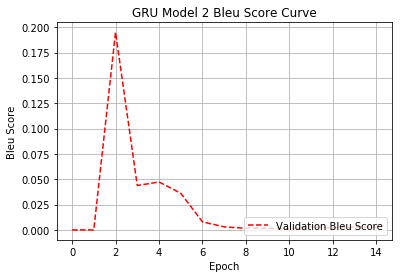

In [6]:
# trains the GRU model
model = bGRU(cfg).to(computing_device)
optimizer = optim.Adam(model.parameters(), cfg['learning_rate'])
criterion = nn.CrossEntropyLoss()

train_loss, valid_loss, valid_bleu = train(model, "GRU" + model_number, criterion, optimizer, computing_device, 
                                           x_train, y_train, x_valid, y_valid, cfg)

process_results("GRU Model " + model_number, train_loss, valid_loss, valid_bleu)

predicted_reviews = generate(model, x_train, cfg)
#print (predicted_reviews)

In [5]:
cfg

{'valid_char': "abcdefghijklmnopqrstuvwxyz0123456789!$'()*,-.:;? ",
 'valid_char_len': 49,
 'num_data': 5000,
 'input_dim': 131,
 'hidden_dim': 16,
 'output_dim': 52,
 'layers': 2,
 'train_percentage': 0.8,
 'epochs': 15,
 'batch_size': 32,
 'learning_rate': 0.01,
 'early_stop': 3,
 'gen_temp': 0.5,
 'max_len': 1000,
 'cuda': False,
 'bidirectional': False,
 'L2_penalty': 0,
 'train': True,
 'dropout': 0}

In [ ]:
'''
train(model, X_train, y_train, X_valid, y_valid, cfg) # Train the model
outputs = generate(model, X_test, cfg) # Generate the outputs for test data
save_to_file(outputs, out_fname) # Save the generated outputs to a file
'''